In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
def import_metrics_json(models_path, run_num):
    """
    Looks in `{models_path}/{run_num}/metrics.json` and returns the contents as a
    Python dictionary. Returns None if the path does not exist, or if the JSON is
    malformed.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        print("Path does not exist: %s" % path)
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except json.JSONDecodeError:
        print("Malformed JSON: %s" % path)
        return None

In [4]:
def import_all_metrics_json(models_path):
    """
    Looks in `models_path` and finds all instances of
    `{models_path}/{run_num}/metrics.json`, returning a dictionary that maps
    `{run_num}` to the metrics dictionary.
    """
    all_metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    all_metrics = {key : val for key, val in all_metrics.items() if val}  # Remove empties
    return all_metrics

In [5]:
def import_config_json(models_path, run_num):
    """
    Looks in `{models_path}/{run_num}/config.json` and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "config.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [6]:
def import_all_config_json(models_path):
    """
    Looks in `models_path` and finds all instances of
    `{models_path}/{run_num}/config.json`, returning a dictionary that maps
    `{run_num}` to the config dictionary.
    """
    all_config = {run_num : import_config_json(models_path, run_num) for run_num in os.listdir(models_path)}
    all_config = {key : val for key, val in all_config.items() if val}  # Remove empties
    return all_config

In [7]:
def extract_metrics_values(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the set of values with the given key.
    """
    return metrics[key]["values"]

In [8]:
def extract_metrics_values_at_best_val(metrics, loss_key, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the set of values with the given key, but only for
    the epoch that yielded the minimal validation loss given by `loss_key`.
    It is assumed that the requested key is saved once per epoch.
    """
    best_epoch = np.argmin(extract_metrics_values(metrics, "val_epoch_loss"))
    return extract_metrics_values(metrics, key)[best_epoch]

In [9]:
def plot_hyperparam_performance(models_path):
    # Import the metrics and config files
    all_metrics = import_all_metrics_json(models_path)
    all_configs = import_all_config_json(models_path)

    # Extract the validation losses, test NLLs, and test correlations
    # Each one is a dictionary mapping run -> average performance scalar
    log_val_losses = {
        key : np.log10(np.mean(extract_metrics_values_at_best_val(m, "val_epoch_loss", "val_epoch_loss")))
        for key, m in all_metrics.items()
    }
    test_prof_nlls = {
        key : np.mean(extract_metrics_values(m, "summit_prof_nll"))
        for key, m in all_metrics.items()
    }
    test_count_spears = {
        key : np.mean(extract_metrics_values(m, "summit_count_spearman"))
        for key, m in all_metrics.items()
    }
    
    # Extract the hyperparameter values
    # Each one is a dictionary mapping run -> hyperparameter value
    log_learning_rates = {
        key : np.log10(c["learning_rate"]) for key, c in all_configs.items()
    }
    log_counts_loss_weights = {
        key : np.log10(c["counts_loss_weight"]) for key, c in all_configs.items()
    }
    
    # Plot
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))

    color_1, color_2 = "darkgoldenrod", "darkblue"

    ax1, ax2 = ax[0], ax[0].twiny()
    ax1.scatter(
        *zip(*[(log_learning_rates[k], log_val_losses[k]) for k in all_metrics.keys()]),
        color=color_1
    )
    ax2.scatter(
        *zip(*[(log_counts_loss_weights[k], log_val_losses[k]) for k in all_metrics.keys()]),
        color=color_2
    )
    ax1.set_xlabel("log10(learning rate)", color=color_1)
    ax2.set_xlabel("log10(counts_loss_weight)", color=color_2)
    ax1.set_ylabel("log10(validation loss)")
    ax1.tick_params(axis="x", labelcolor=color_1)
    ax2.tick_params(axis="x", labelcolor=color_2)

    color_1, color_2 = "forestgreen", "magenta"

    ax1, ax2 = ax[1], ax[1].twinx()
    ax1.scatter(
        *zip(*[(log_learning_rates[k], test_prof_nlls[k]) for k in all_metrics.keys()]),
        color=color_1
    )
    ax2.scatter(
        *zip(*[(log_learning_rates[k], test_count_spears[k]) for k in all_metrics.keys()]),
        color=color_2
    )
    ax1.set_xlabel("log10(learning rate)")
    ax1.set_ylabel("Test profile NLL", color=color_1)
    ax2.set_ylabel("Test count Spearman", color=color_2)
    ax1.tick_params(axis="y", labelcolor=color_1)
    ax2.tick_params(axis="y", labelcolor=color_2)

    ax1, ax2 = ax[2], ax[2].twinx()
    ax1.scatter(
        *zip(*[(log_counts_loss_weights[k], test_prof_nlls[k]) for k in all_metrics.keys()]),
        color=color_1
    )
    ax2.scatter(
        *zip(*[(log_counts_loss_weights[k], test_count_spears[k]) for k in all_metrics.keys()]),
        color=color_2
    )
    ax1.set_xlabel("log10(counts loss weight)")
    ax1.set_ylabel("Test profile NLL", color=color_1)
    ax2.set_ylabel("Test count Spearman", color=color_2)
    ax1.tick_params(axis="y", labelcolor=color_1)
    ax2.tick_params(axis="y", labelcolor=color_2)
    
    fig.tight_layout(h_pad=10)
    plt.show()

In [10]:
model_base = "/users/amtseng/tfmodisco/models/trained_models/"
tfs = ["E2F6", "FOXA2", "SPI1", "CEBPB", "MAX", "GABPA", "MAFK", "JUND", "NR3C1-reddytime", "REST"]
tf_num_tasks = {
    "E2F6": 2,
    "FOXA2": 4,
    "SPI1": 4,
    "CEBPB": 7,
    "MAX": 7,
    "GABPA": 9,
    "MAFK": 9,
    "JUND": 14,
    "NR3C1-reddytime": 16,
    "REST": 20
}

E2F6


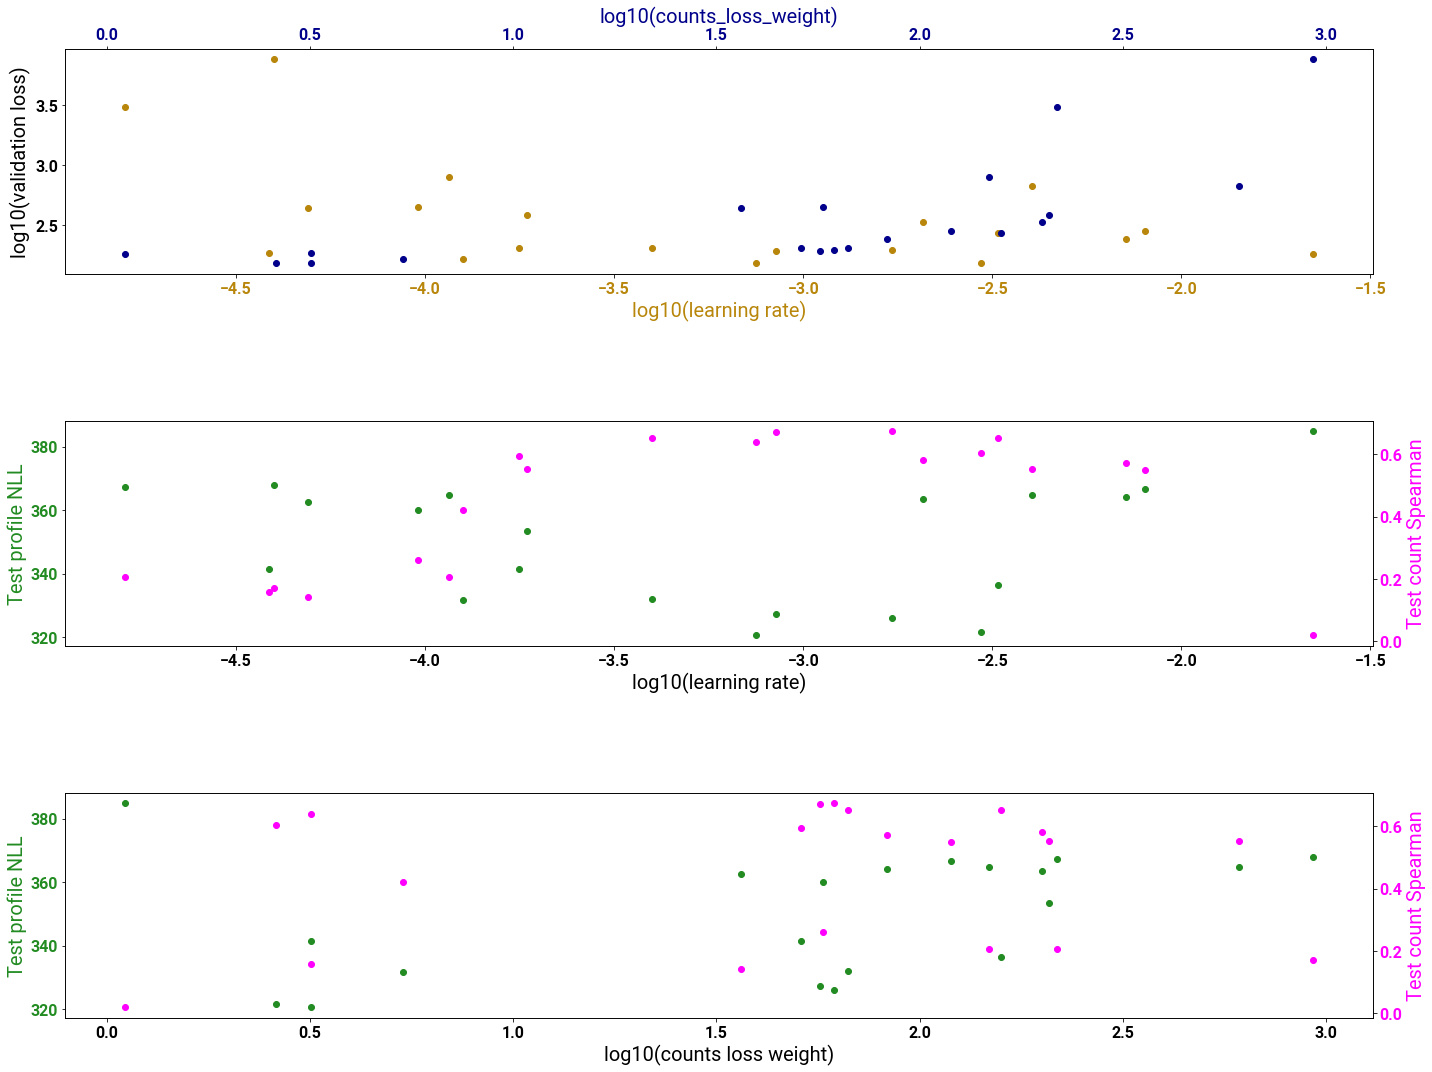

FOXA2


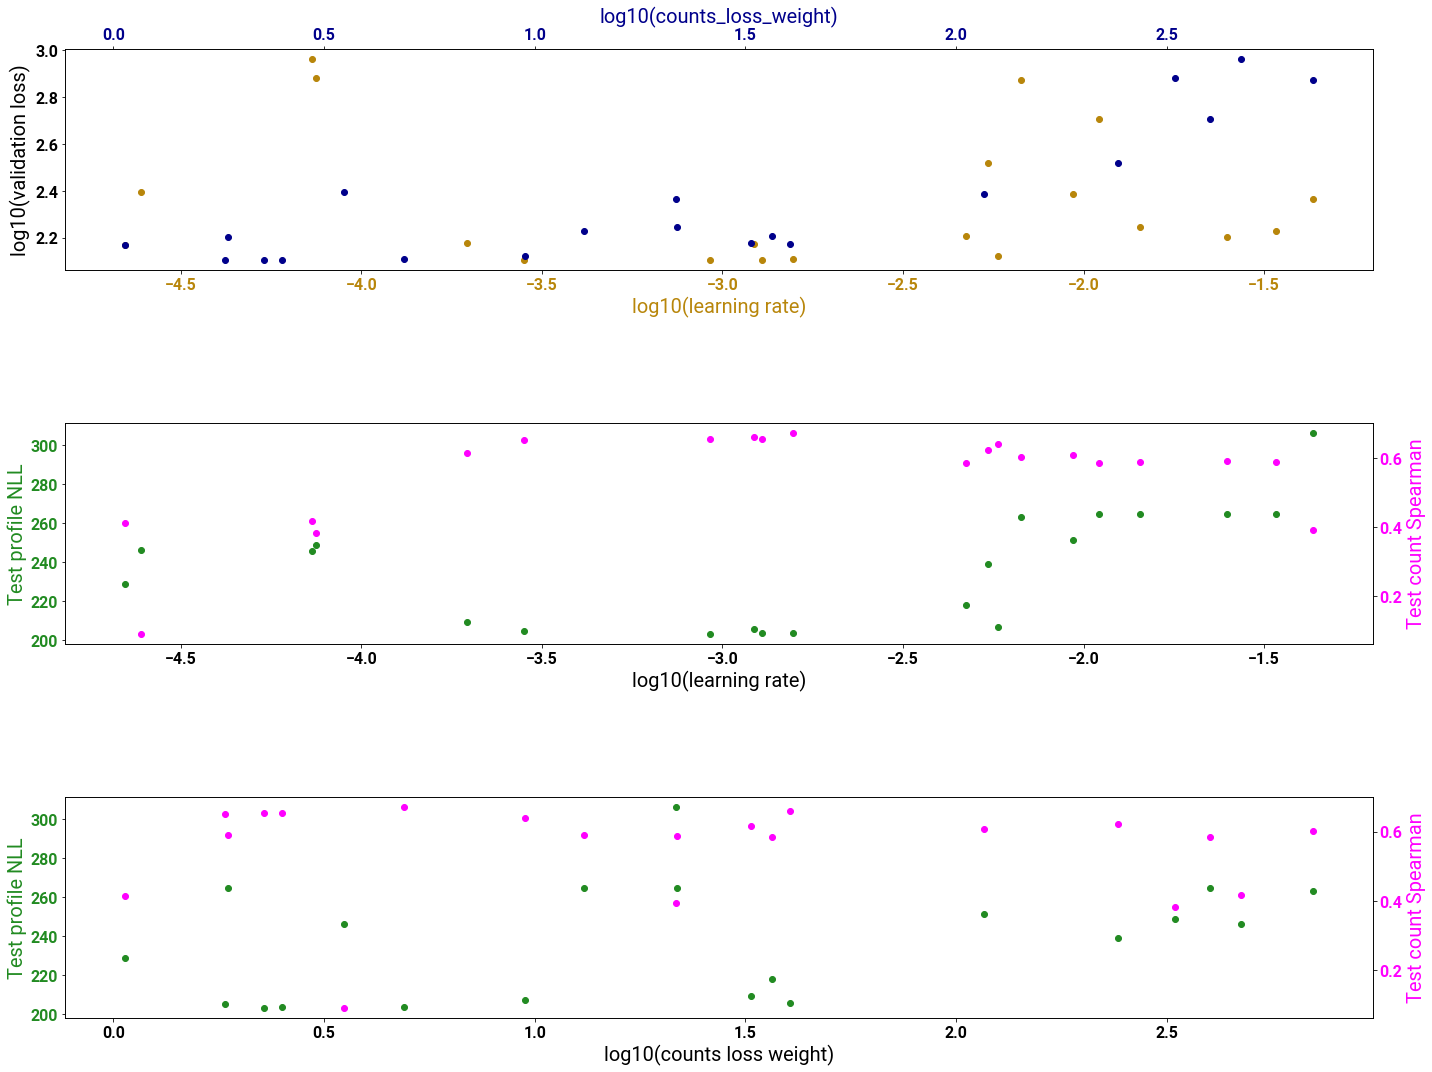

SPI1


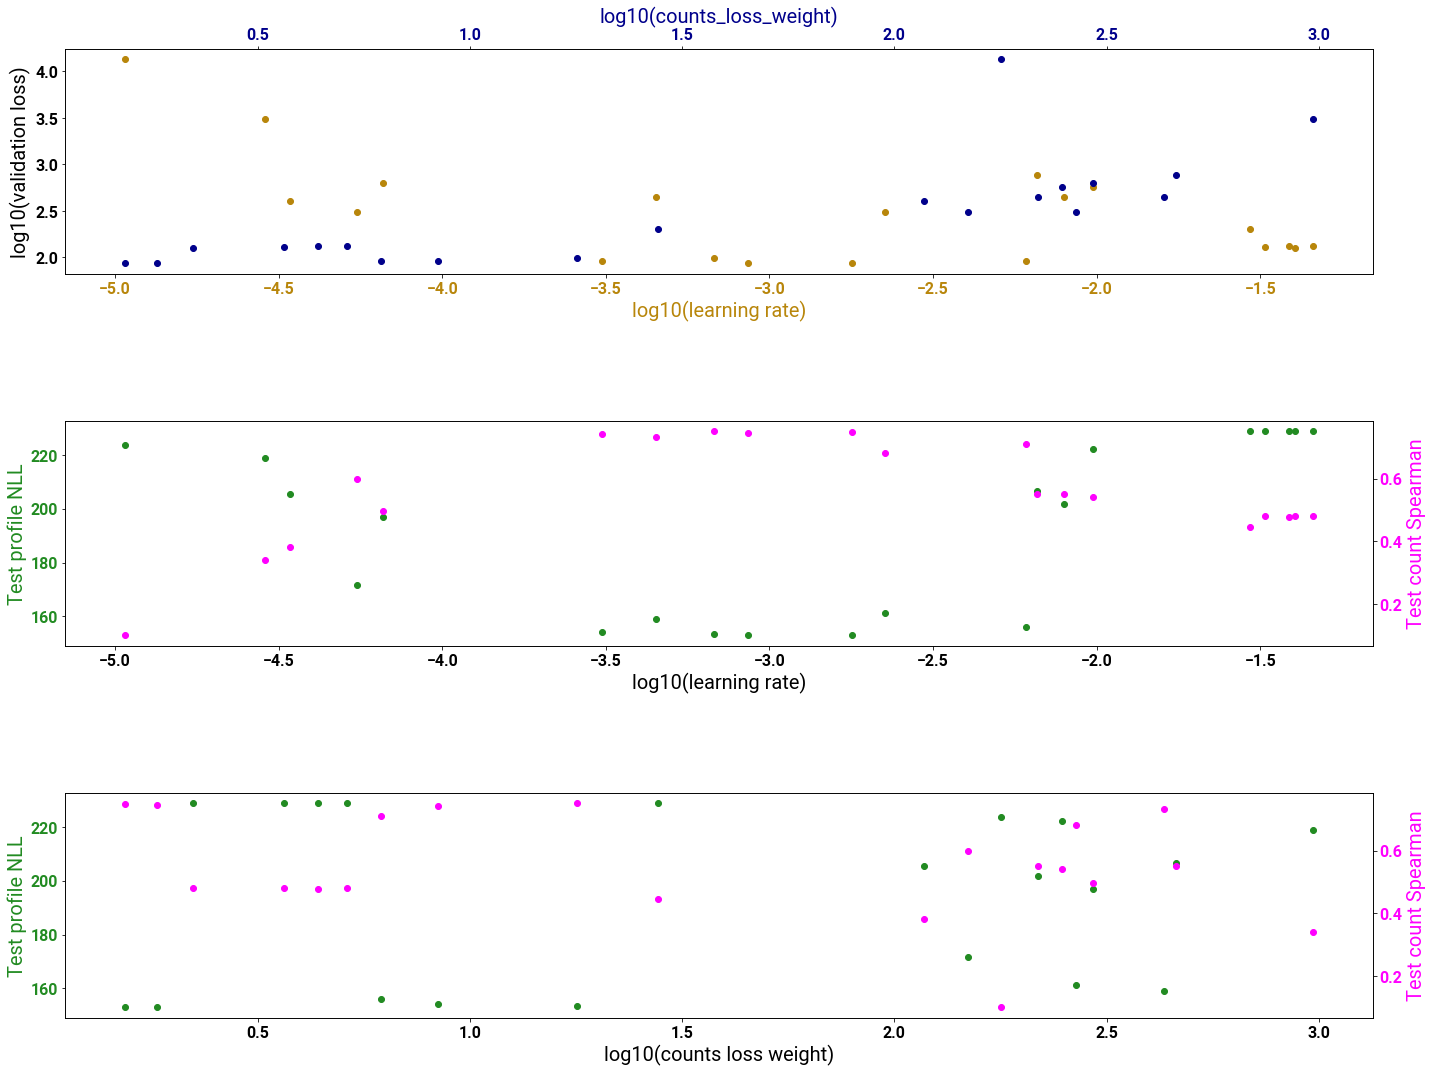

CEBPB


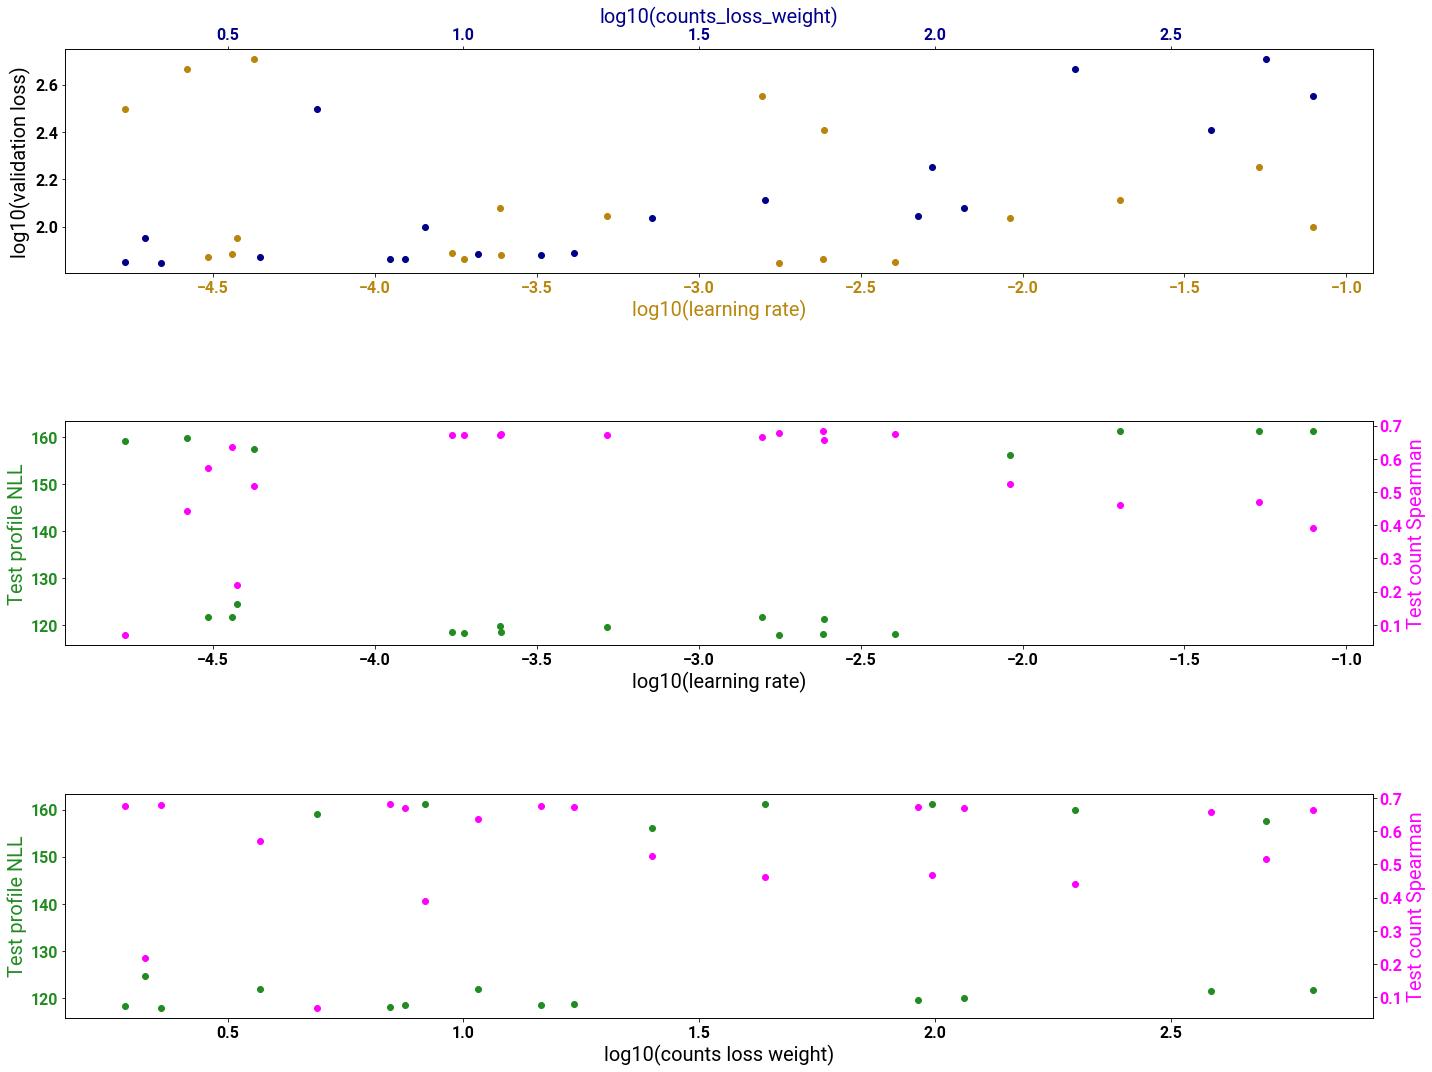

MAX


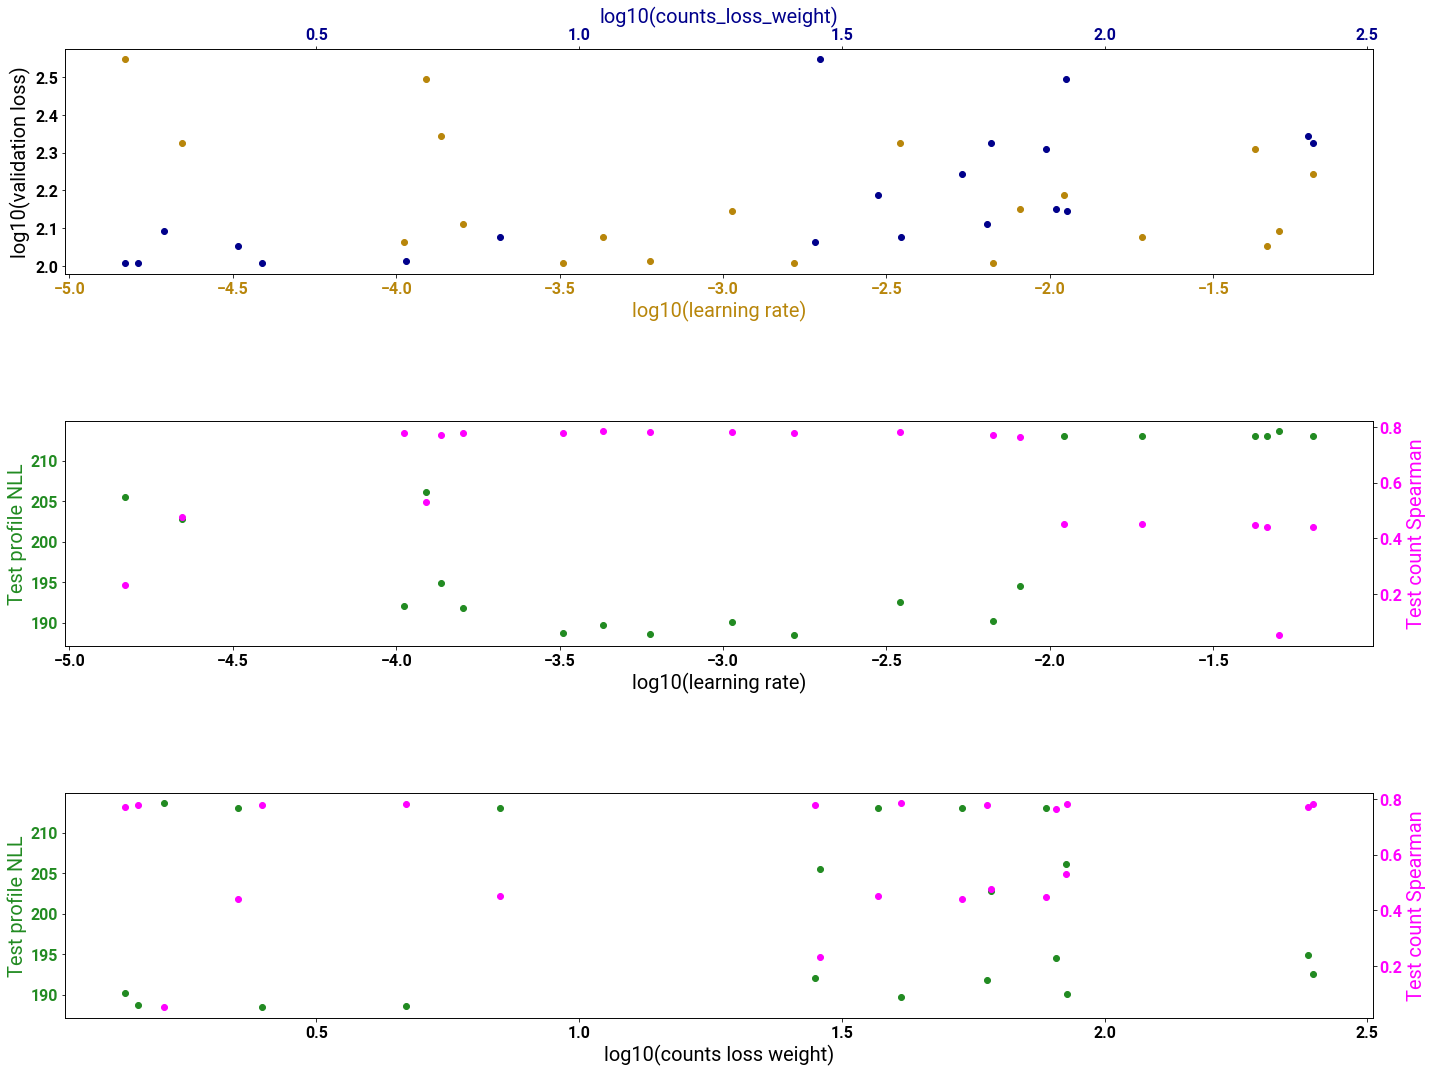

GABPA


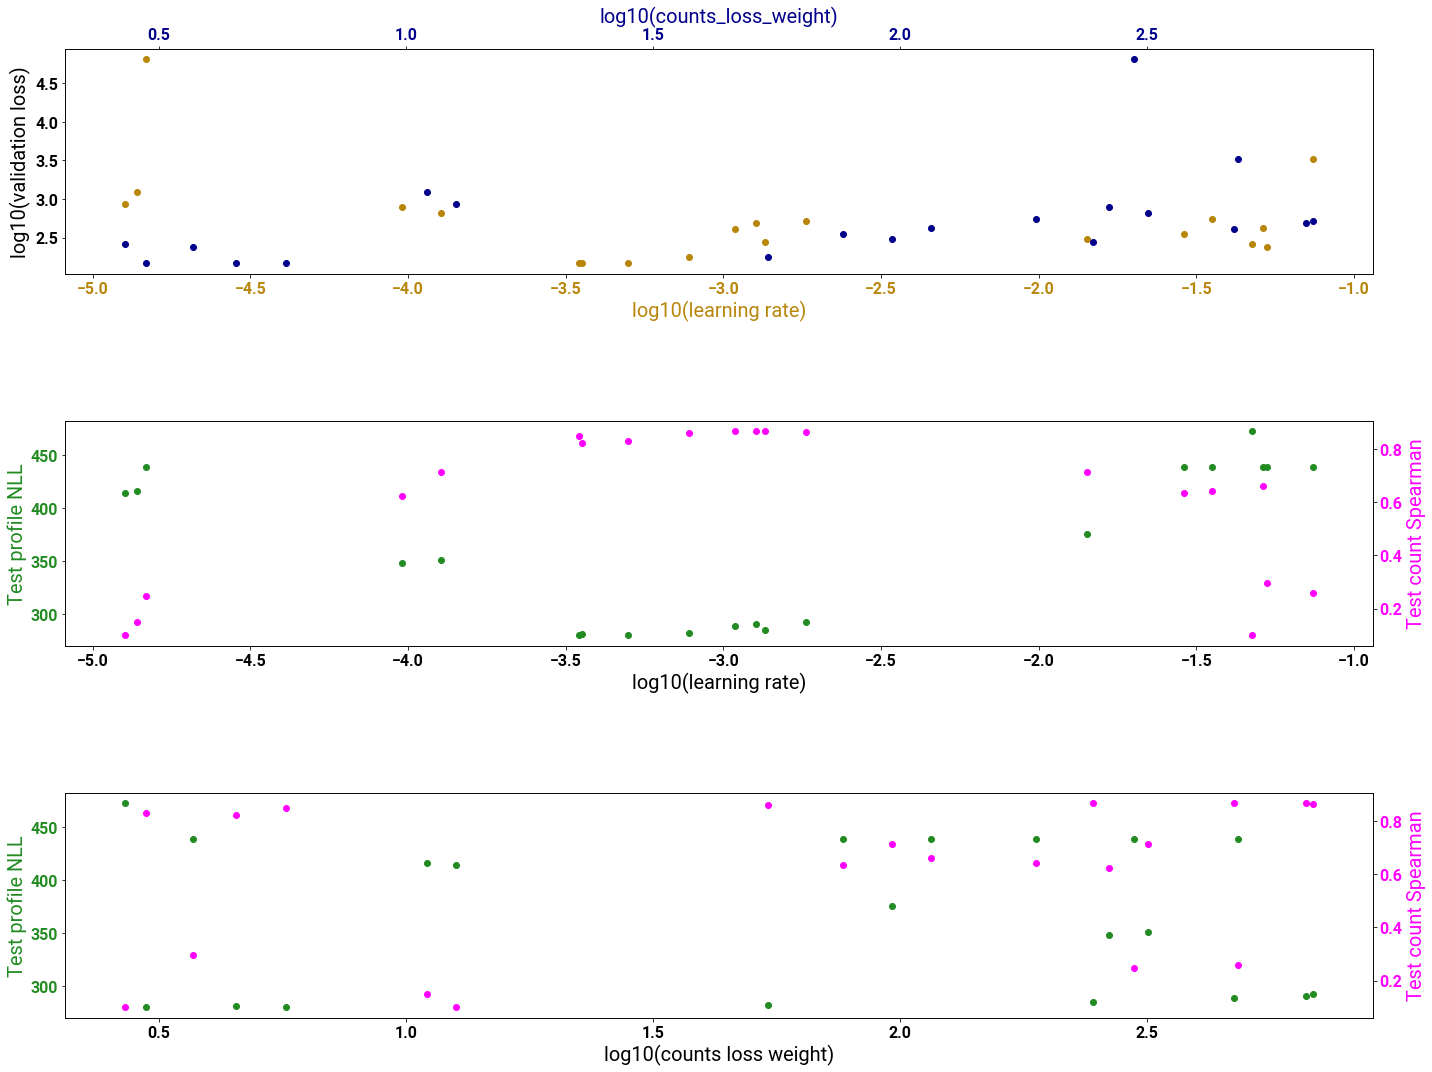

MAFK


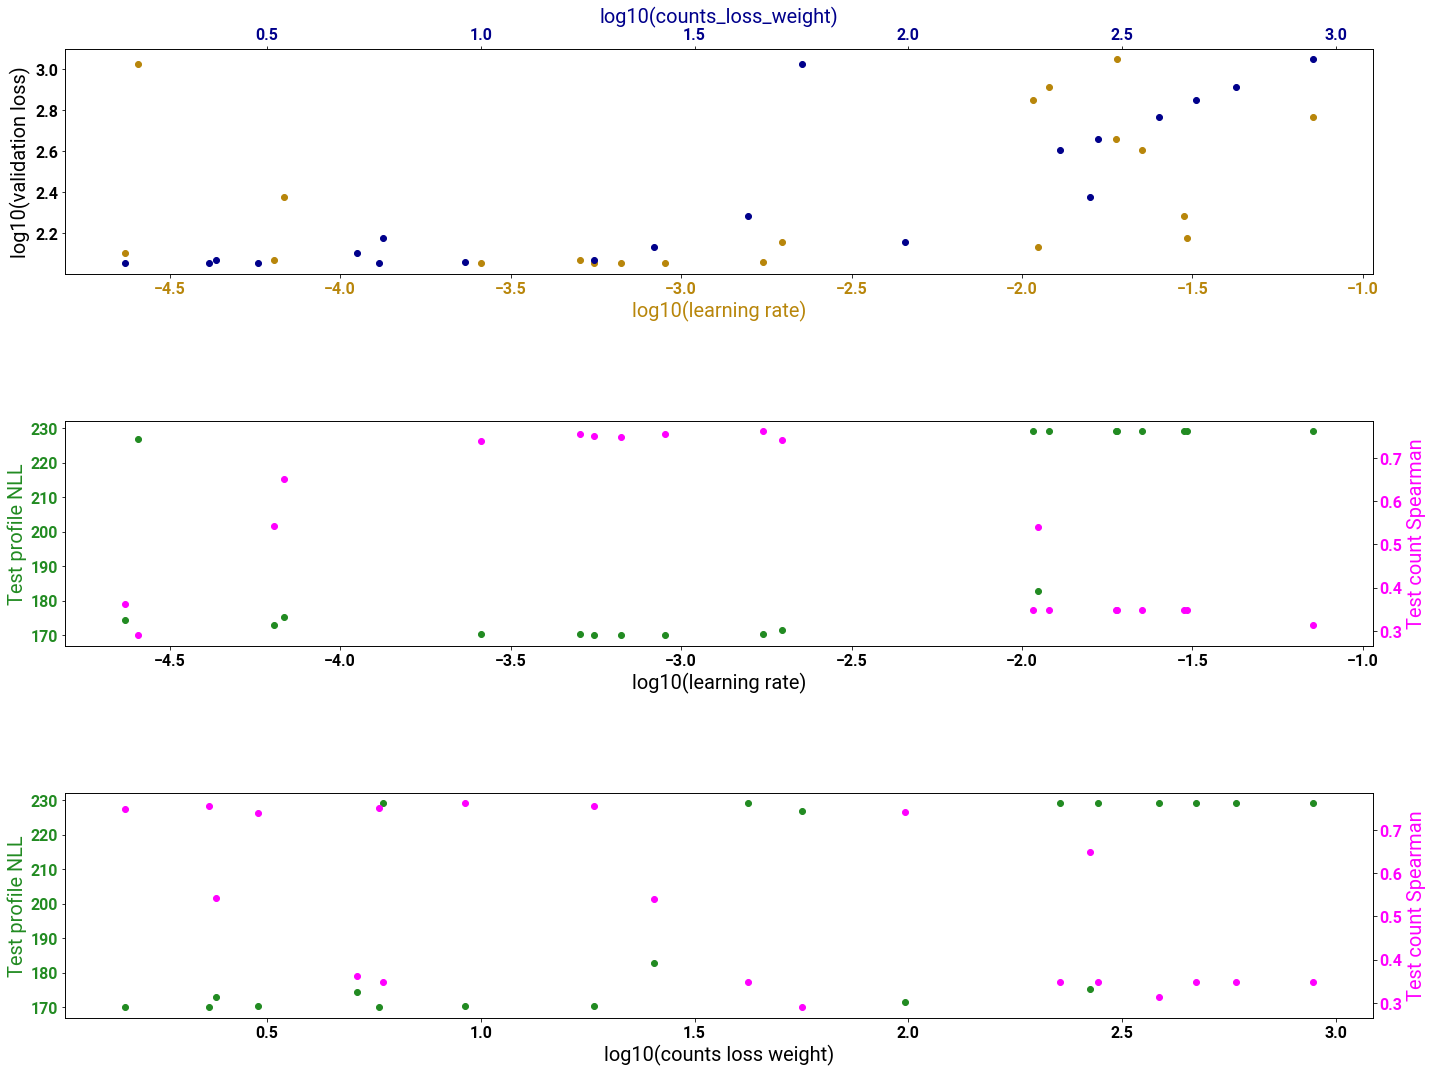

JUND
Path does not exist: /users/amtseng/tfmodisco/models/trained_models/multitask_profile_hypertune/JUND_multitask_profile_hypertune_fold1/_sources/metrics.json


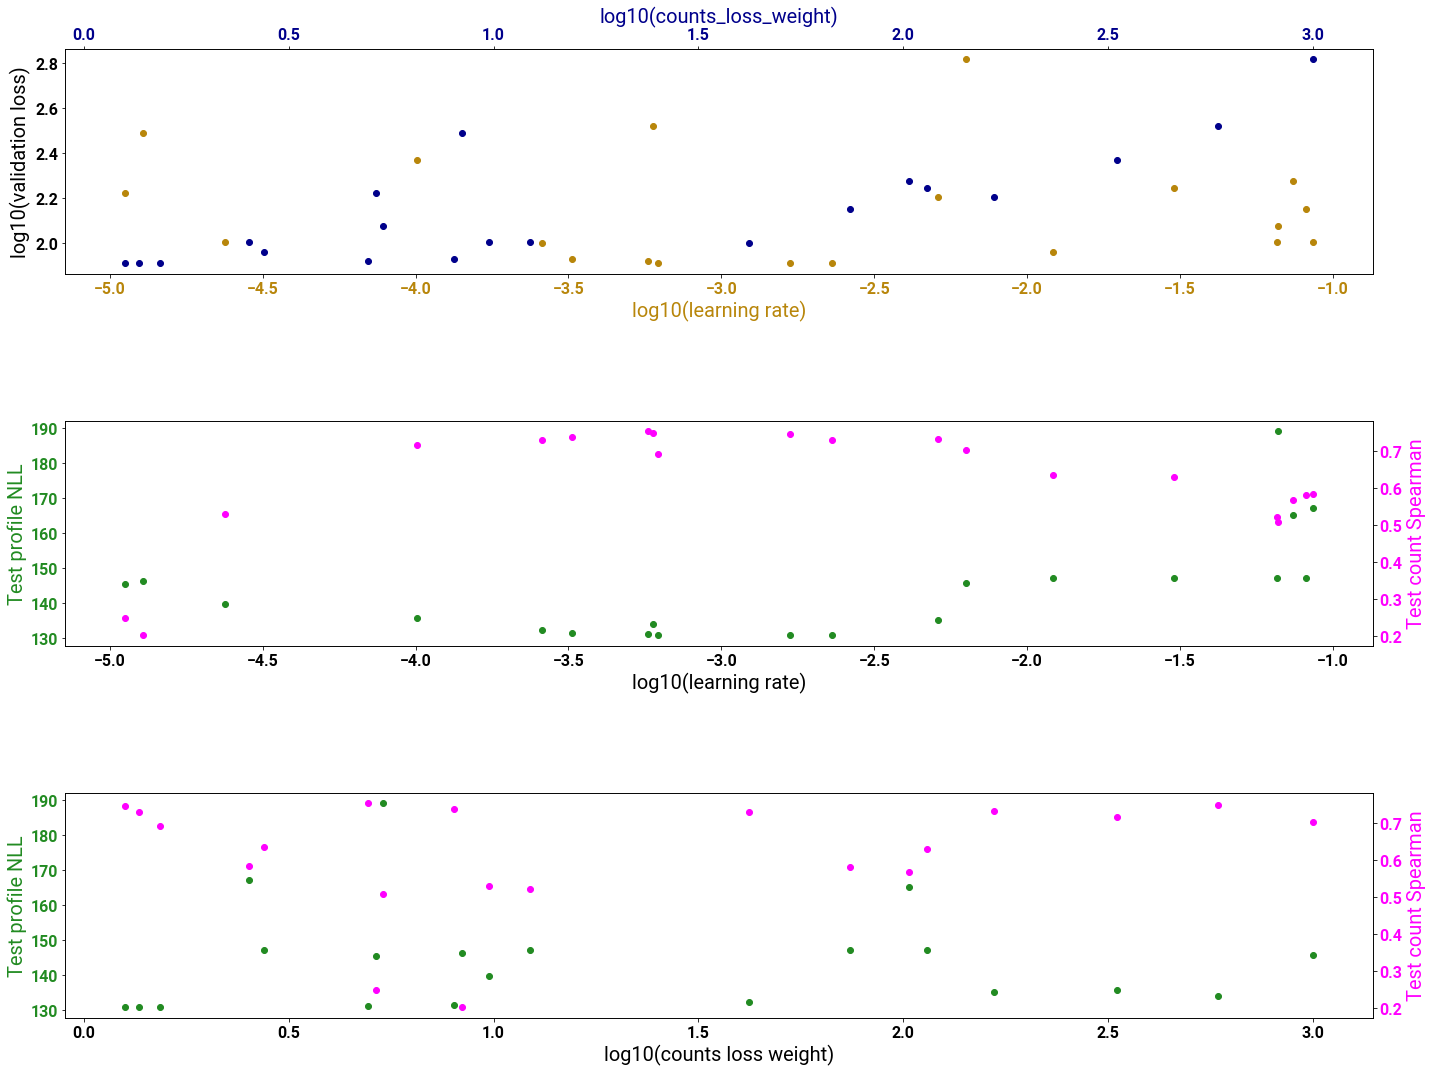

NR3C1-reddytime


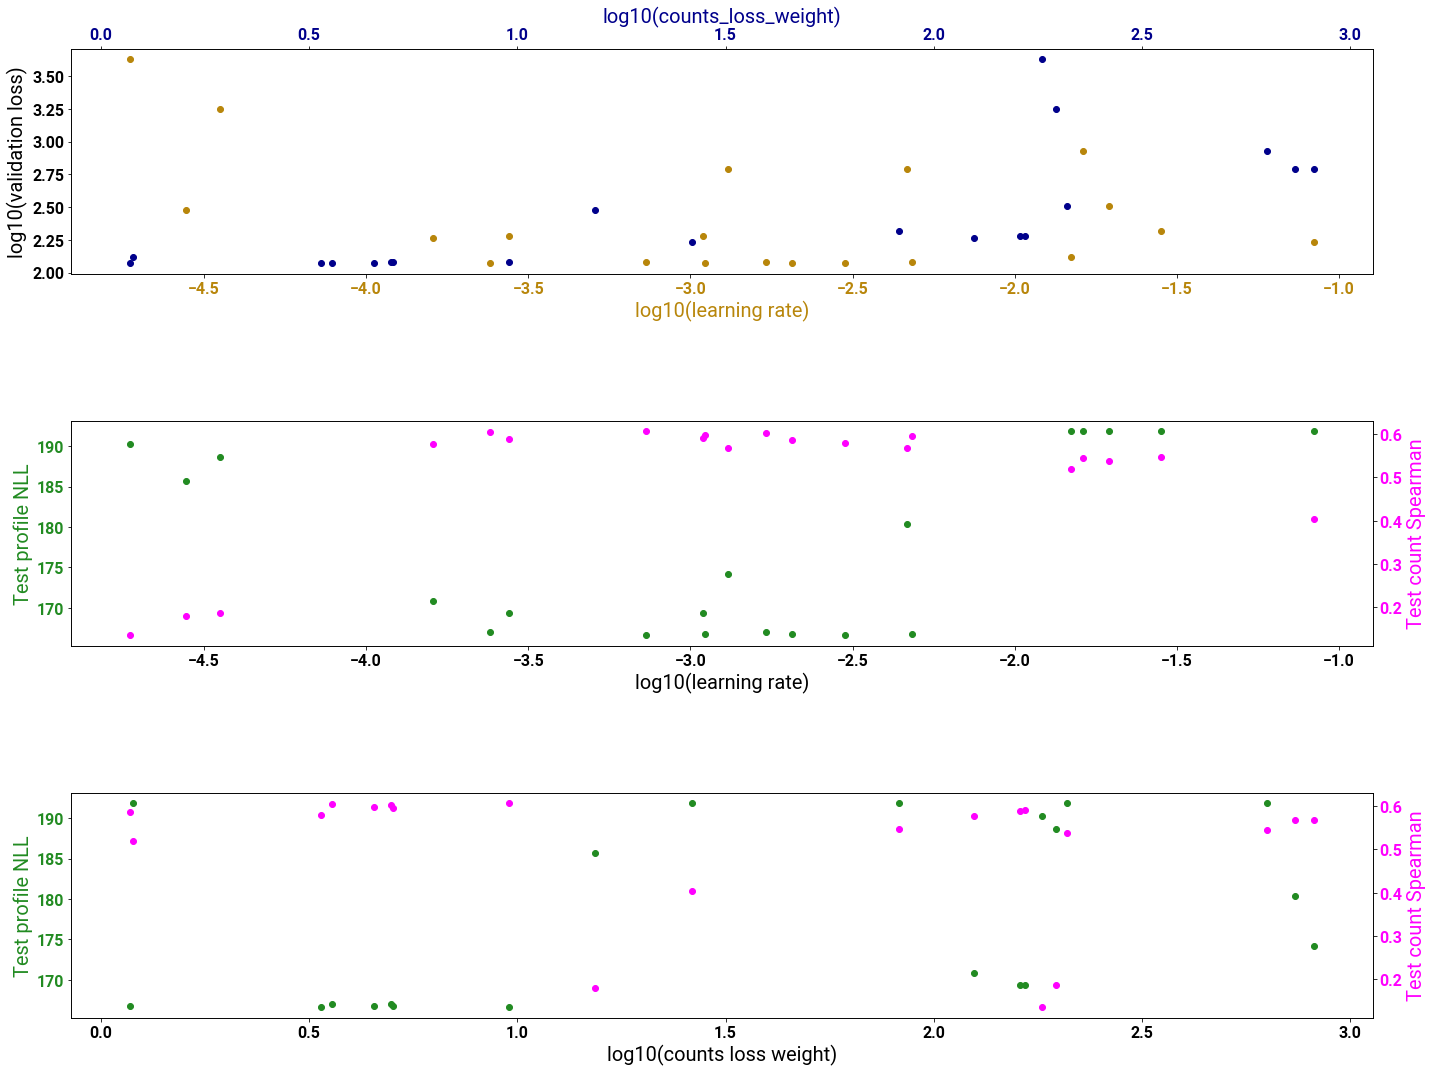

REST
Path does not exist: /users/amtseng/tfmodisco/models/trained_models/multitask_profile_hypertune/REST_multitask_profile_hypertune_fold1/_sources/metrics.json


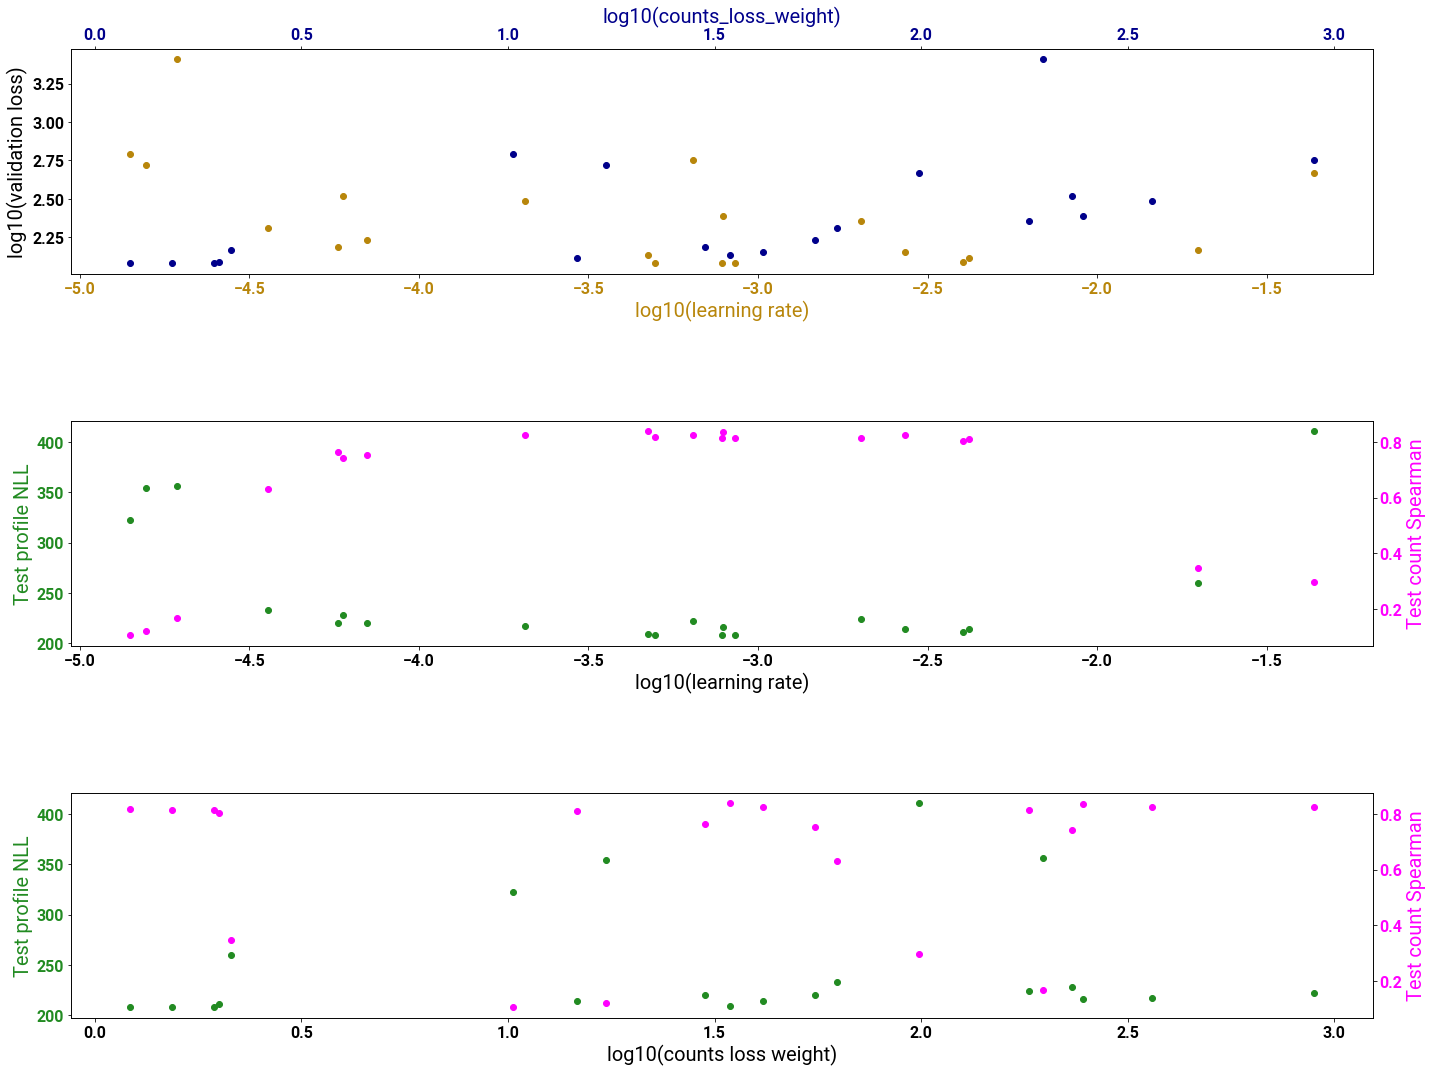

In [11]:
# Multi-task models
for tf in tfs:
    print(tf)
    plot_hyperparam_performance(
        os.path.join(
            model_base,
            "multitask_profile_hypertune",
            "%s_multitask_profile_hypertune_fold1" % tf
        )
    )

E2F6: task_0


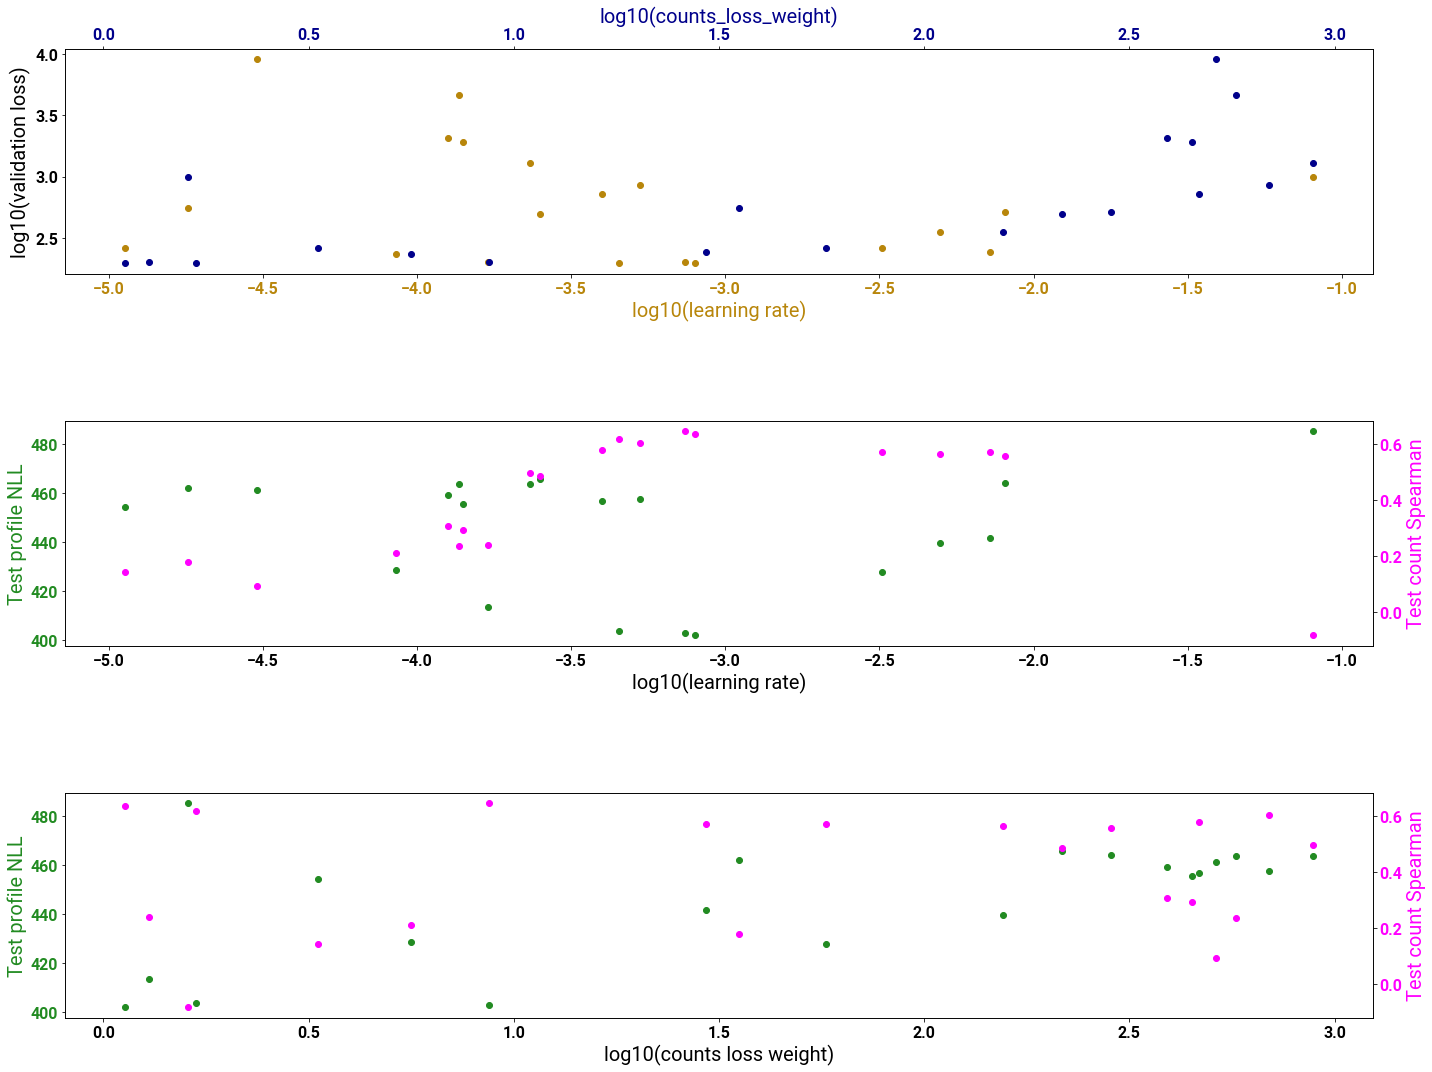

E2F6: task_1


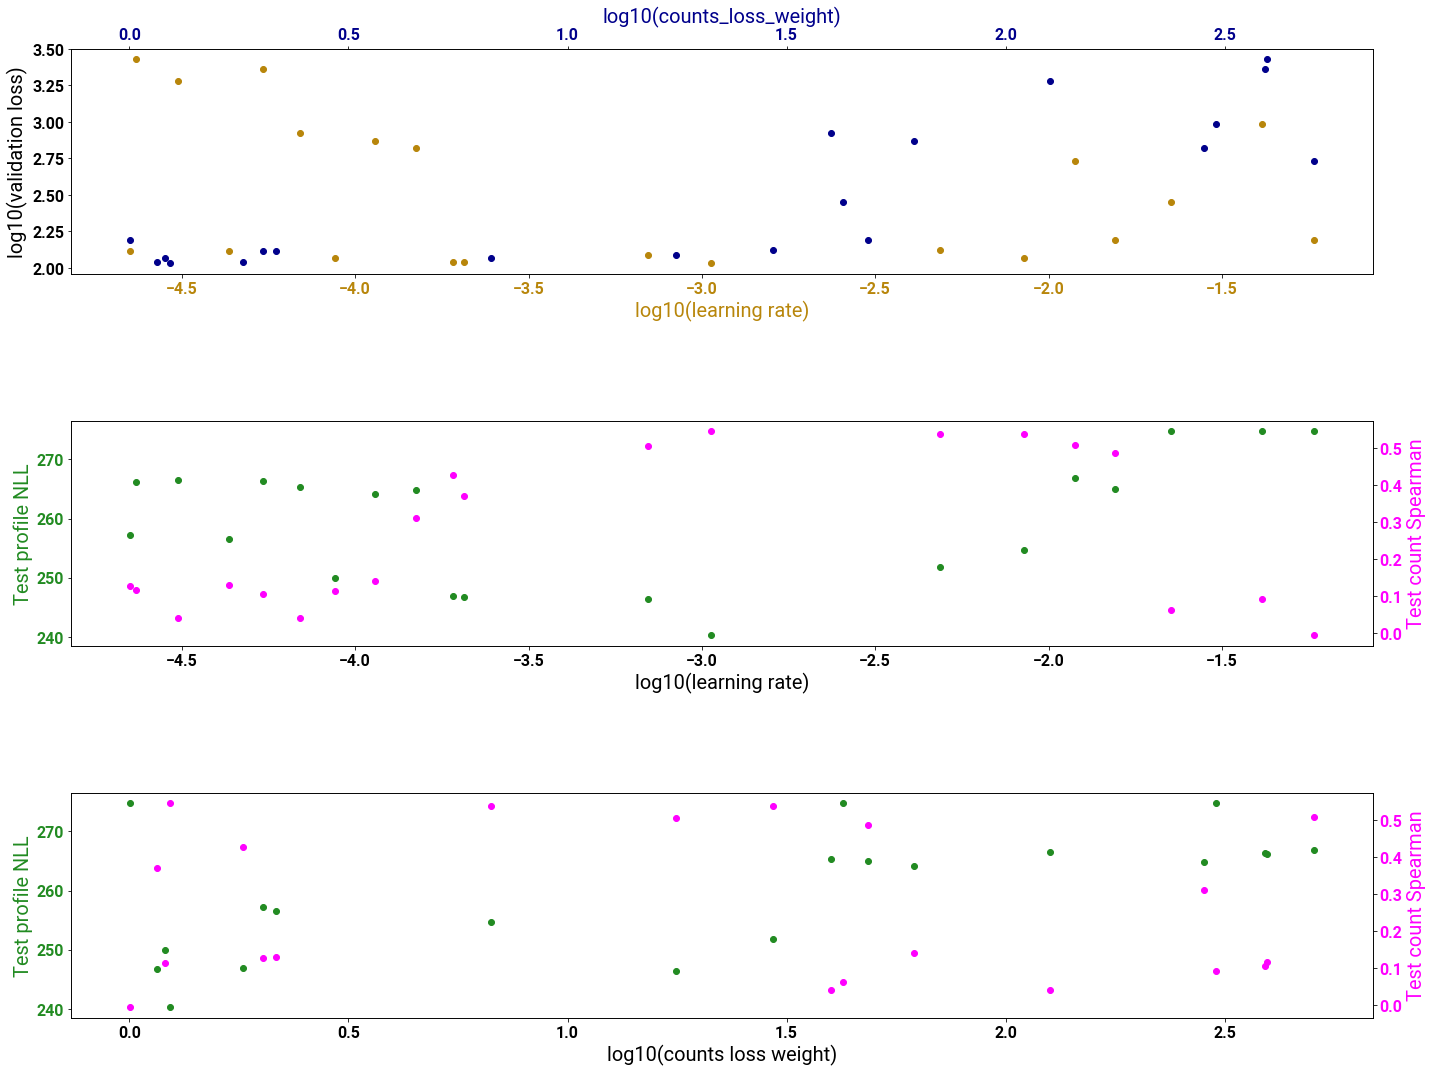

FOXA2: task_0


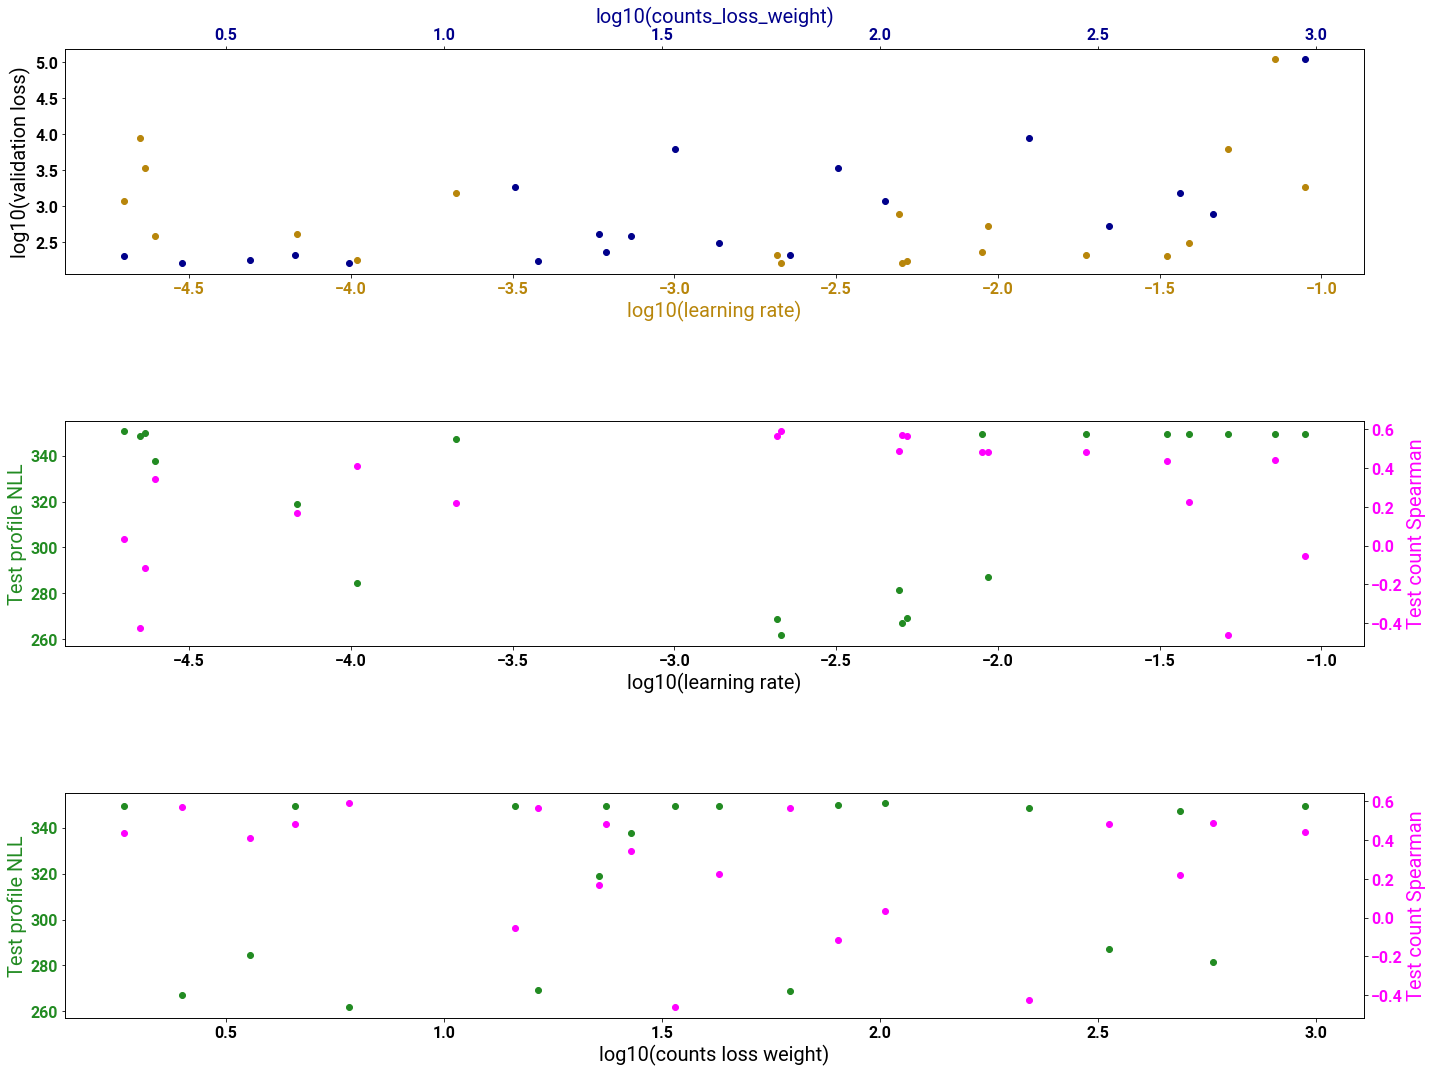

FOXA2: task_1


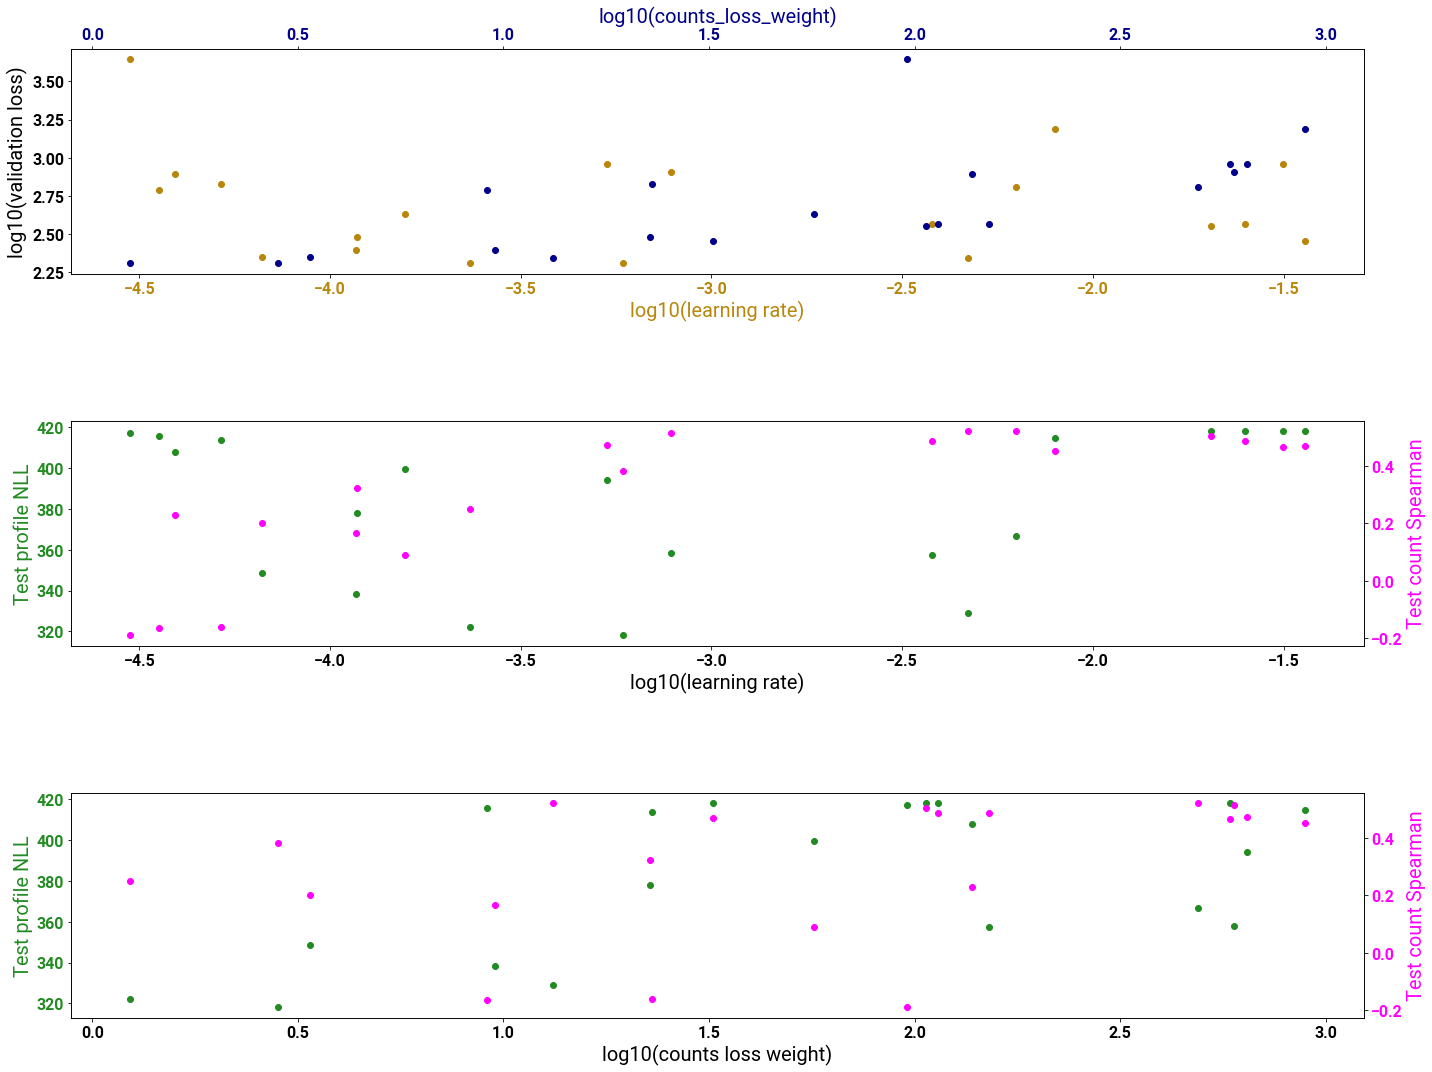

FOXA2: task_2


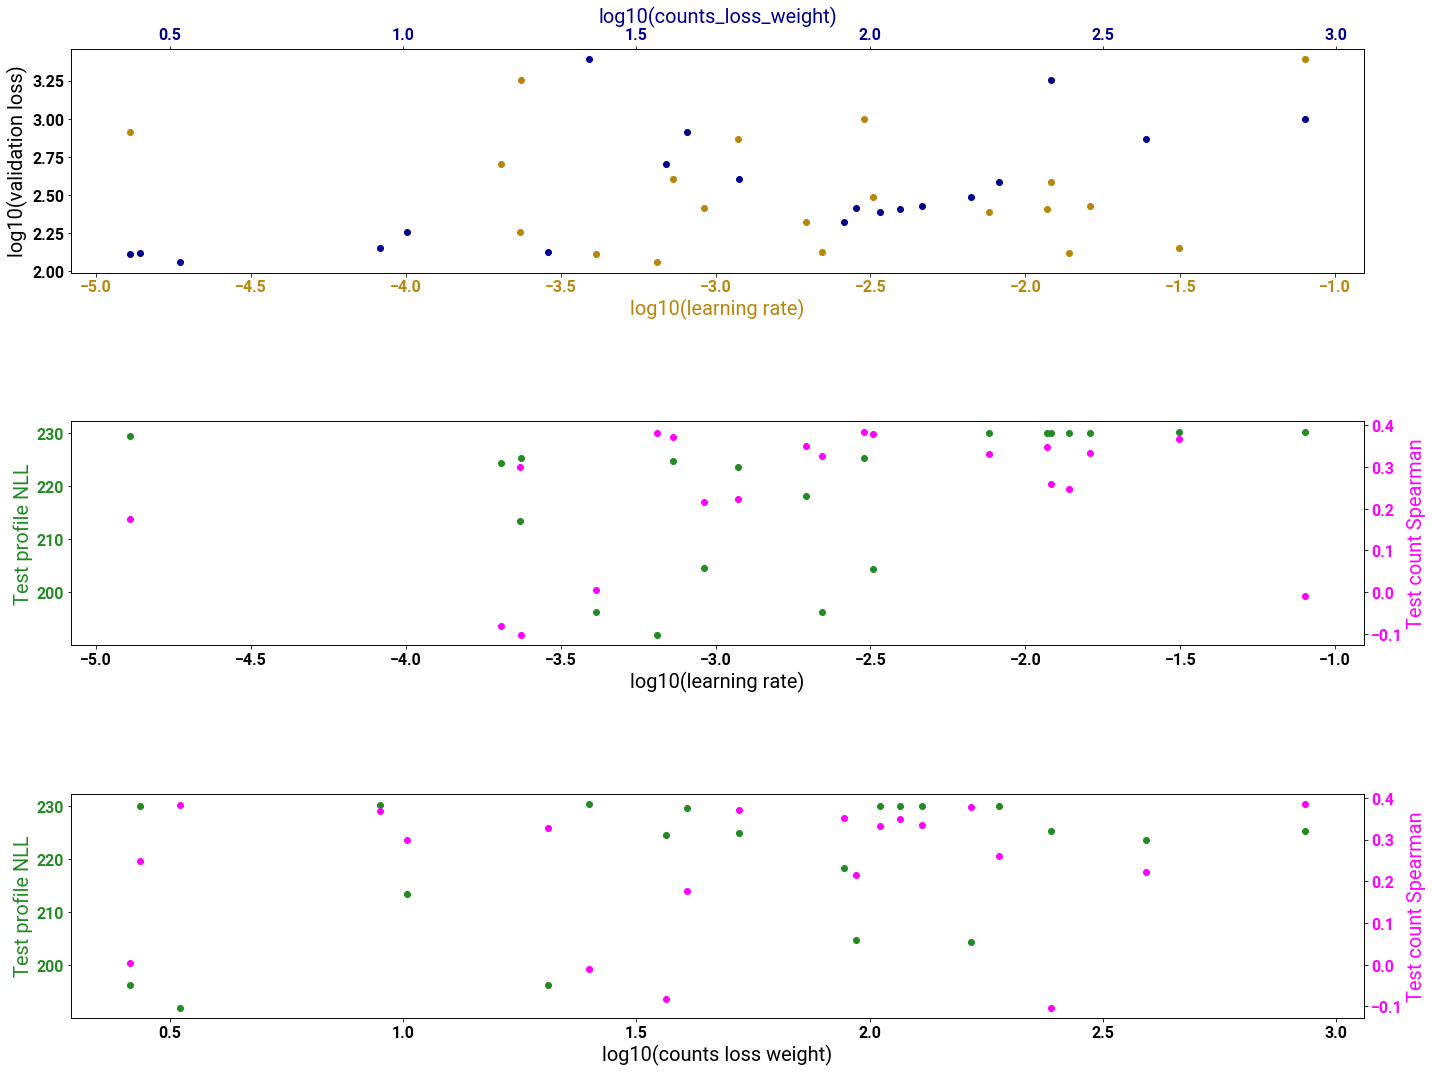

FOXA2: task_3


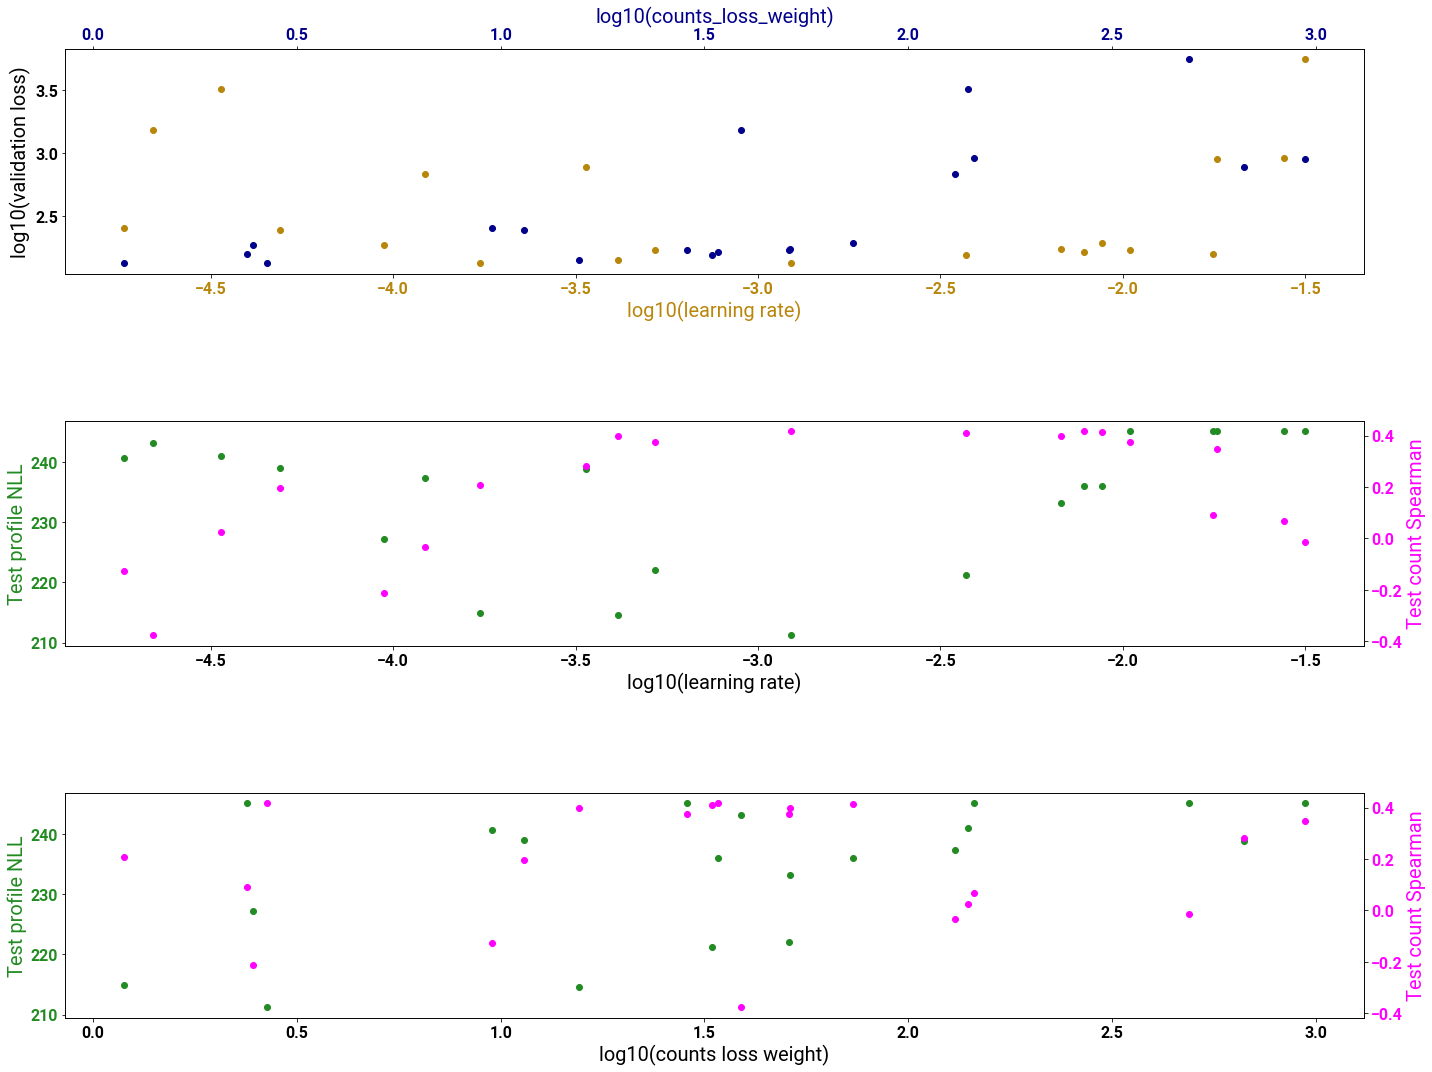

SPI1: task_0


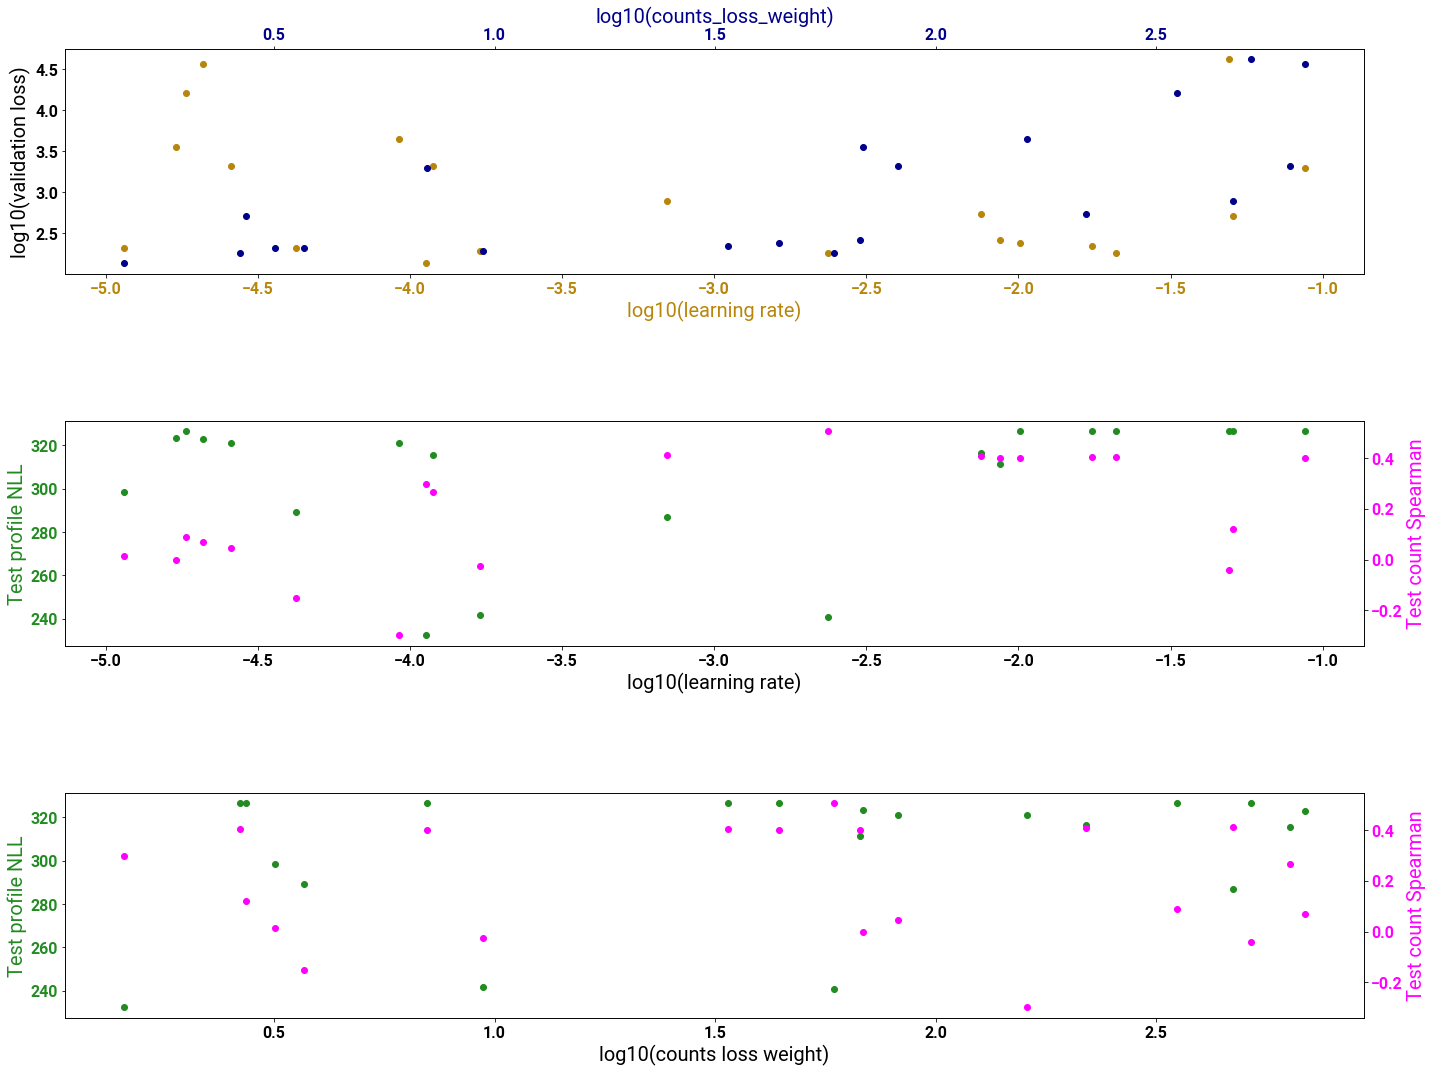

SPI1: task_1


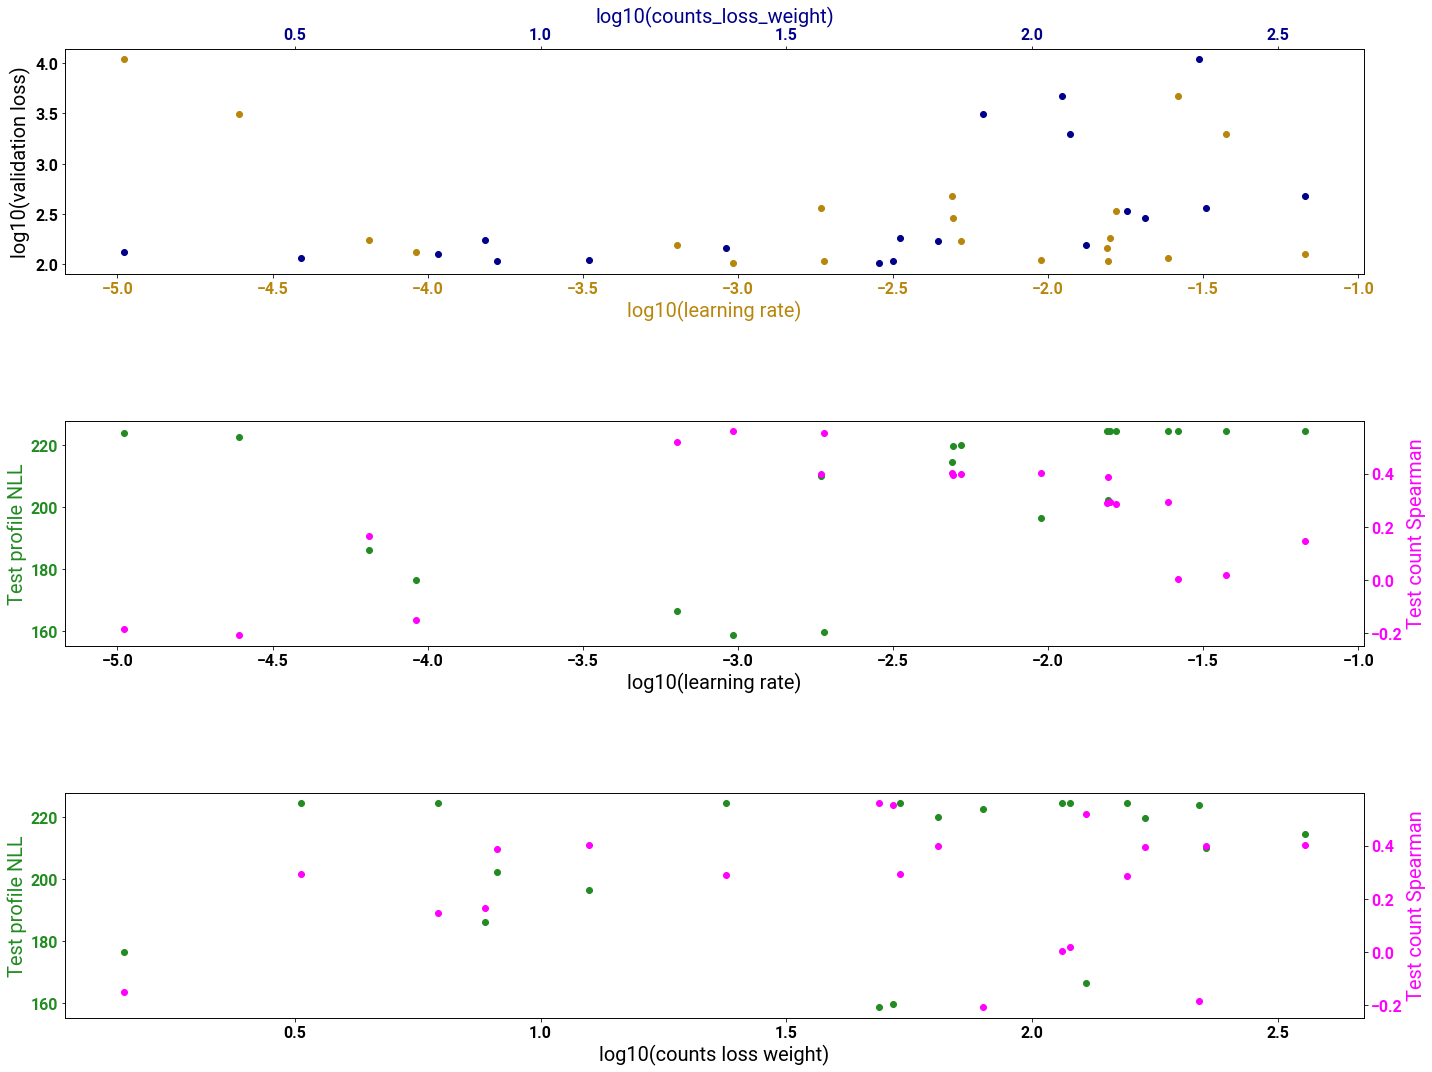

SPI1: task_2


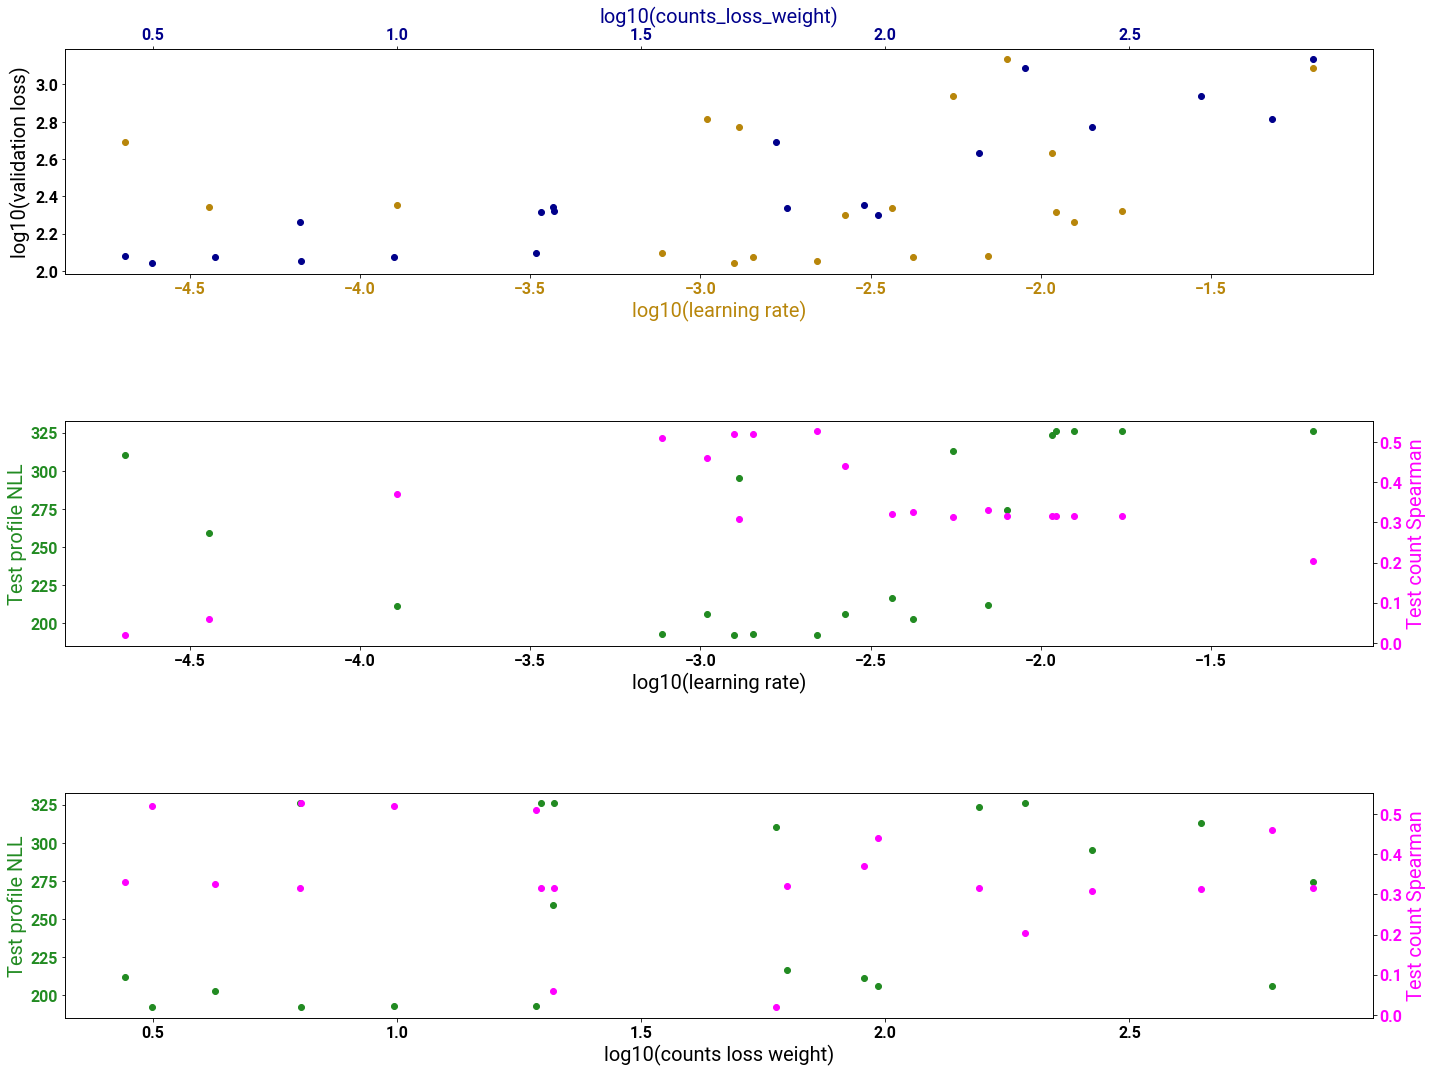

SPI1: task_3


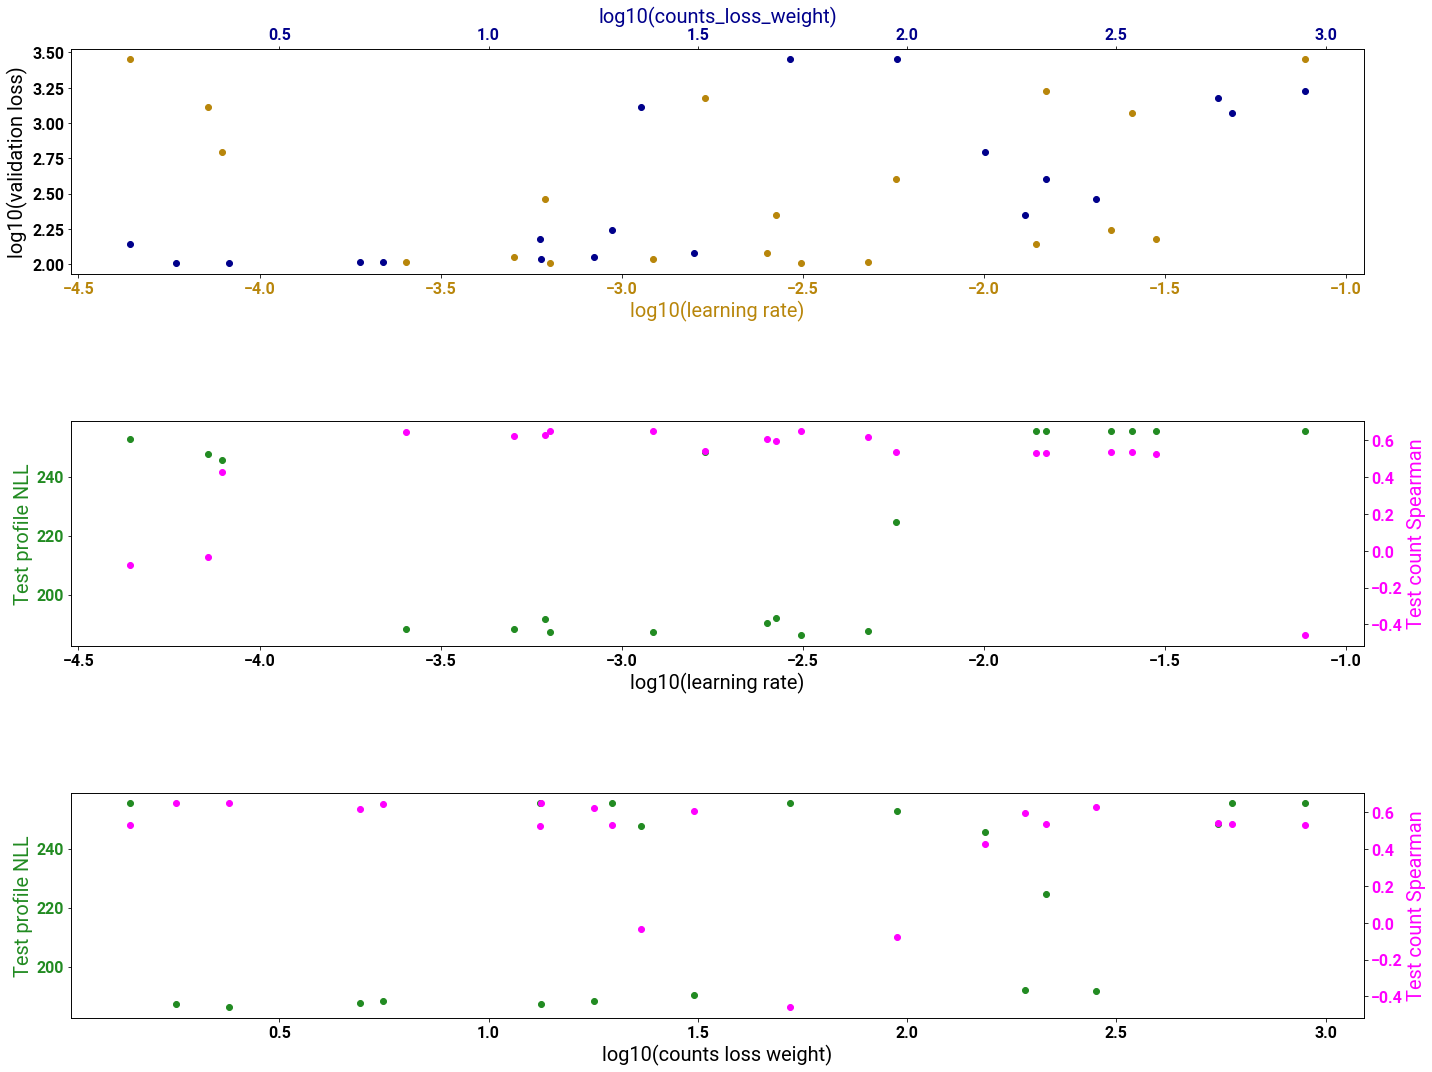

CEBPB: task_0


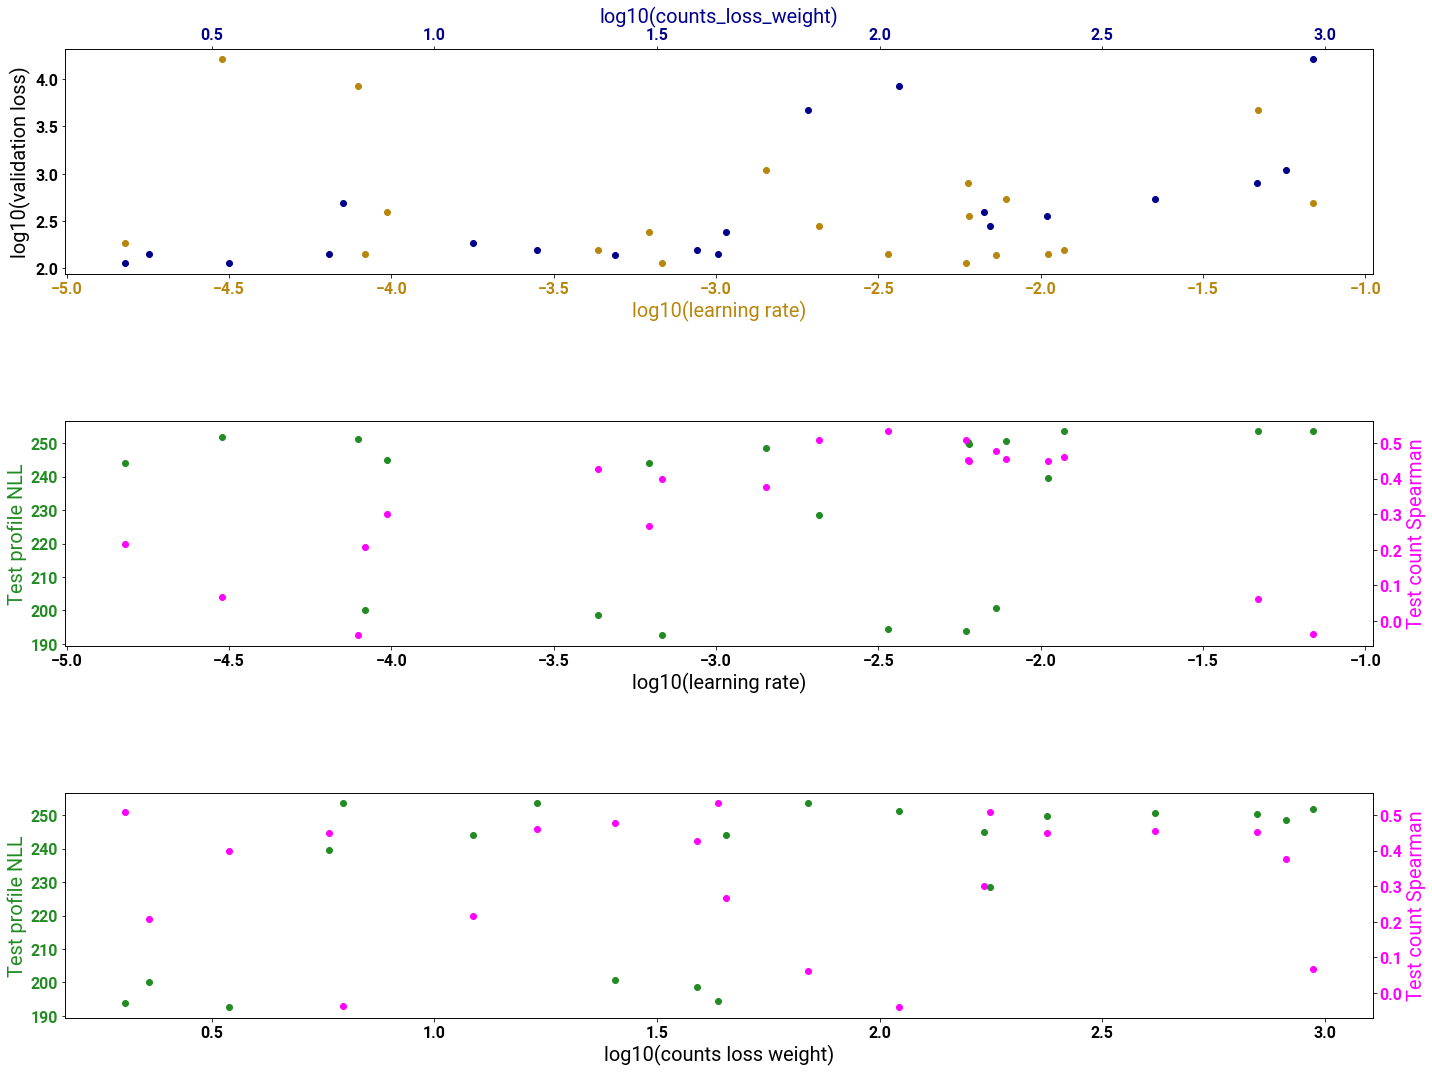

CEBPB: task_1


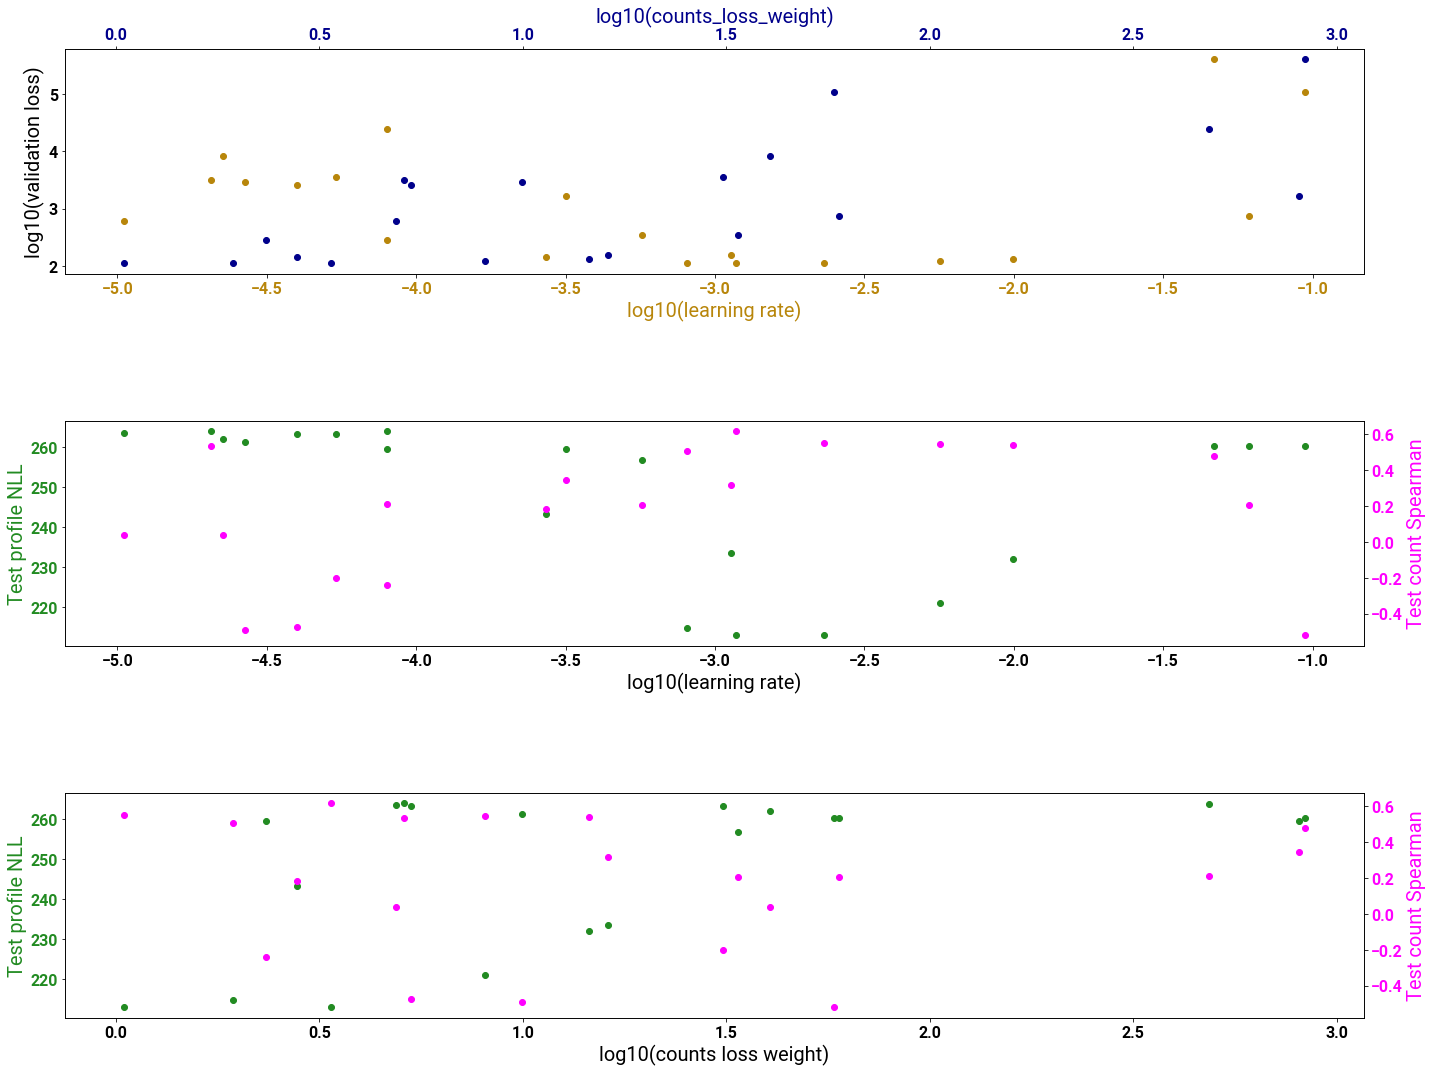

CEBPB: task_2


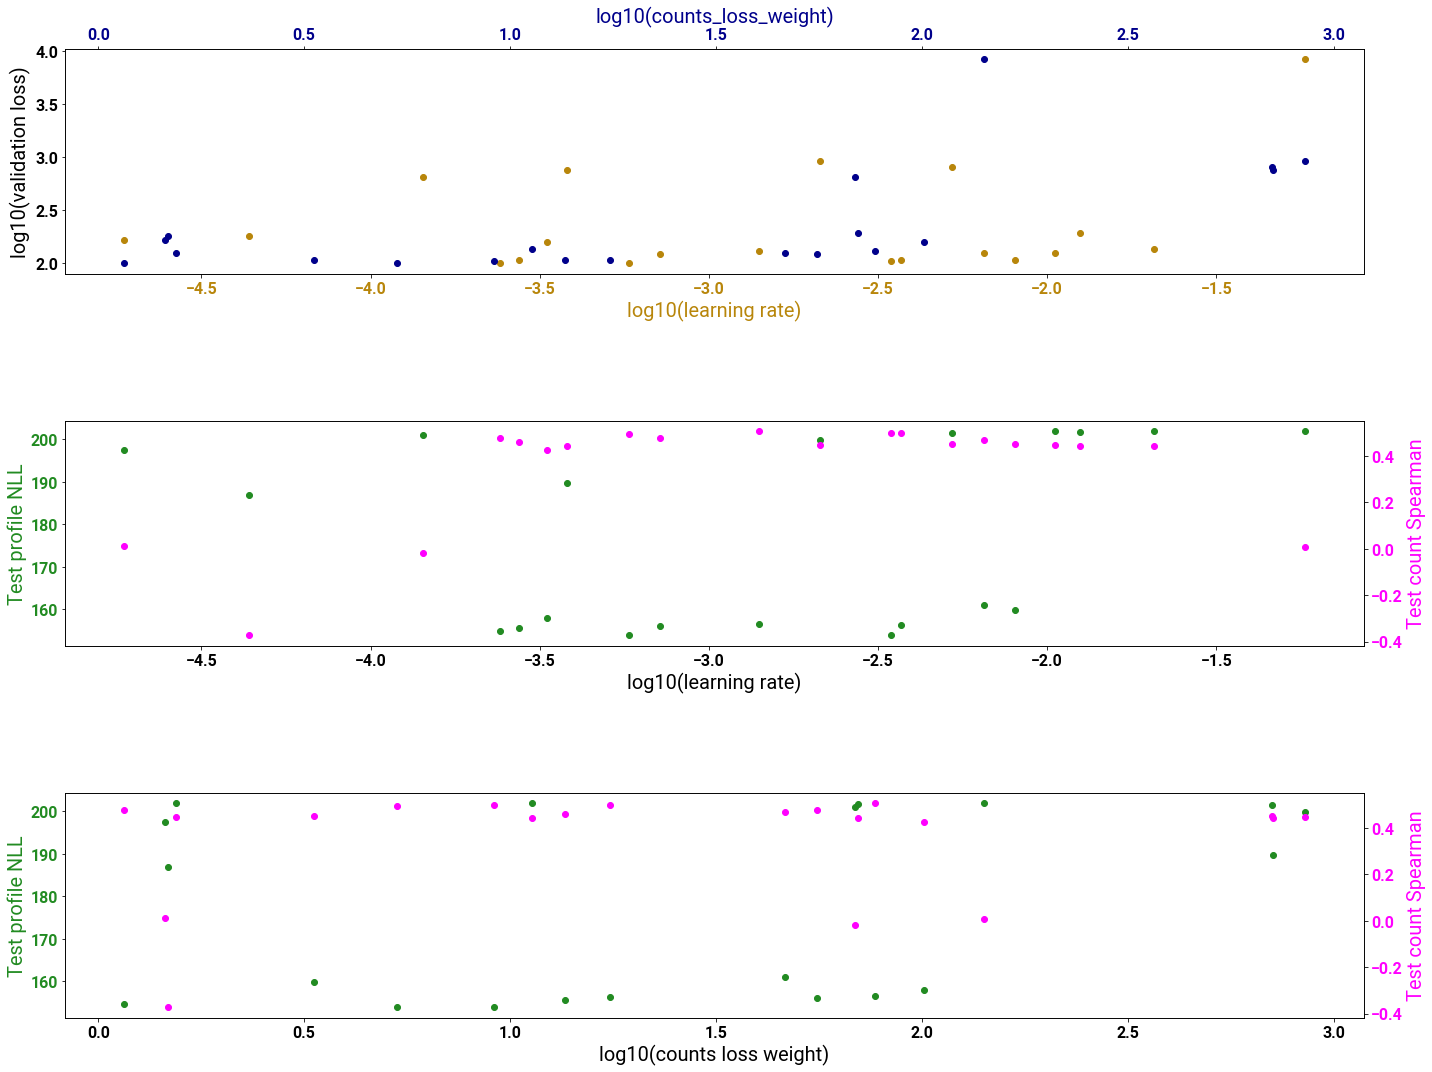

CEBPB: task_3


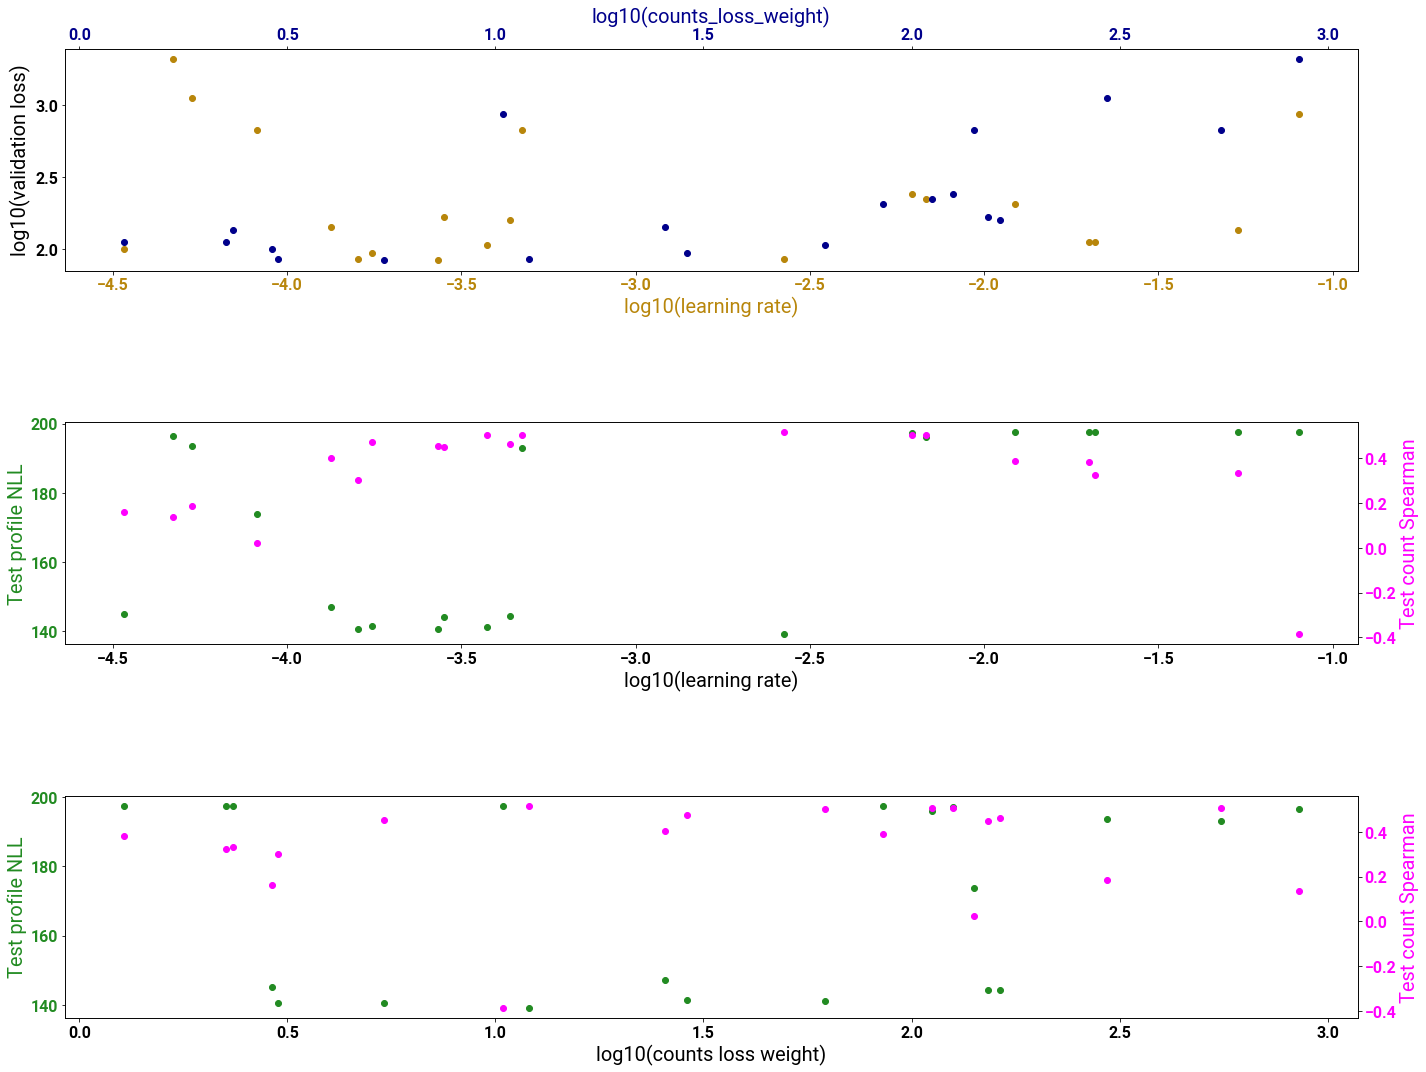

CEBPB: task_4


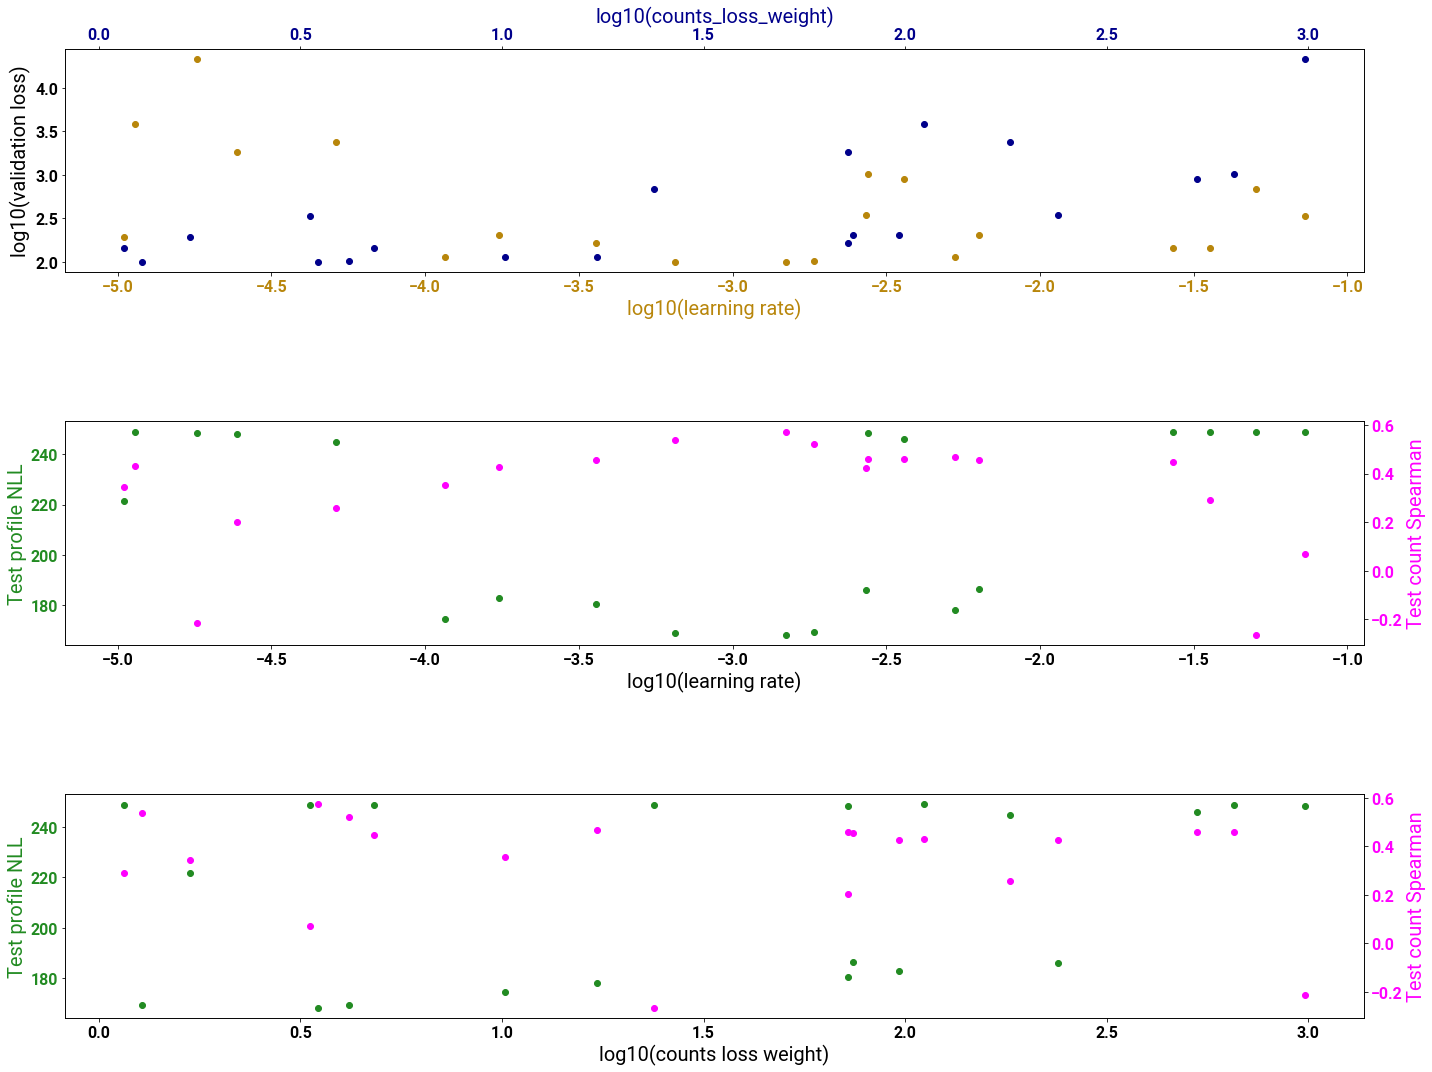

CEBPB: task_5


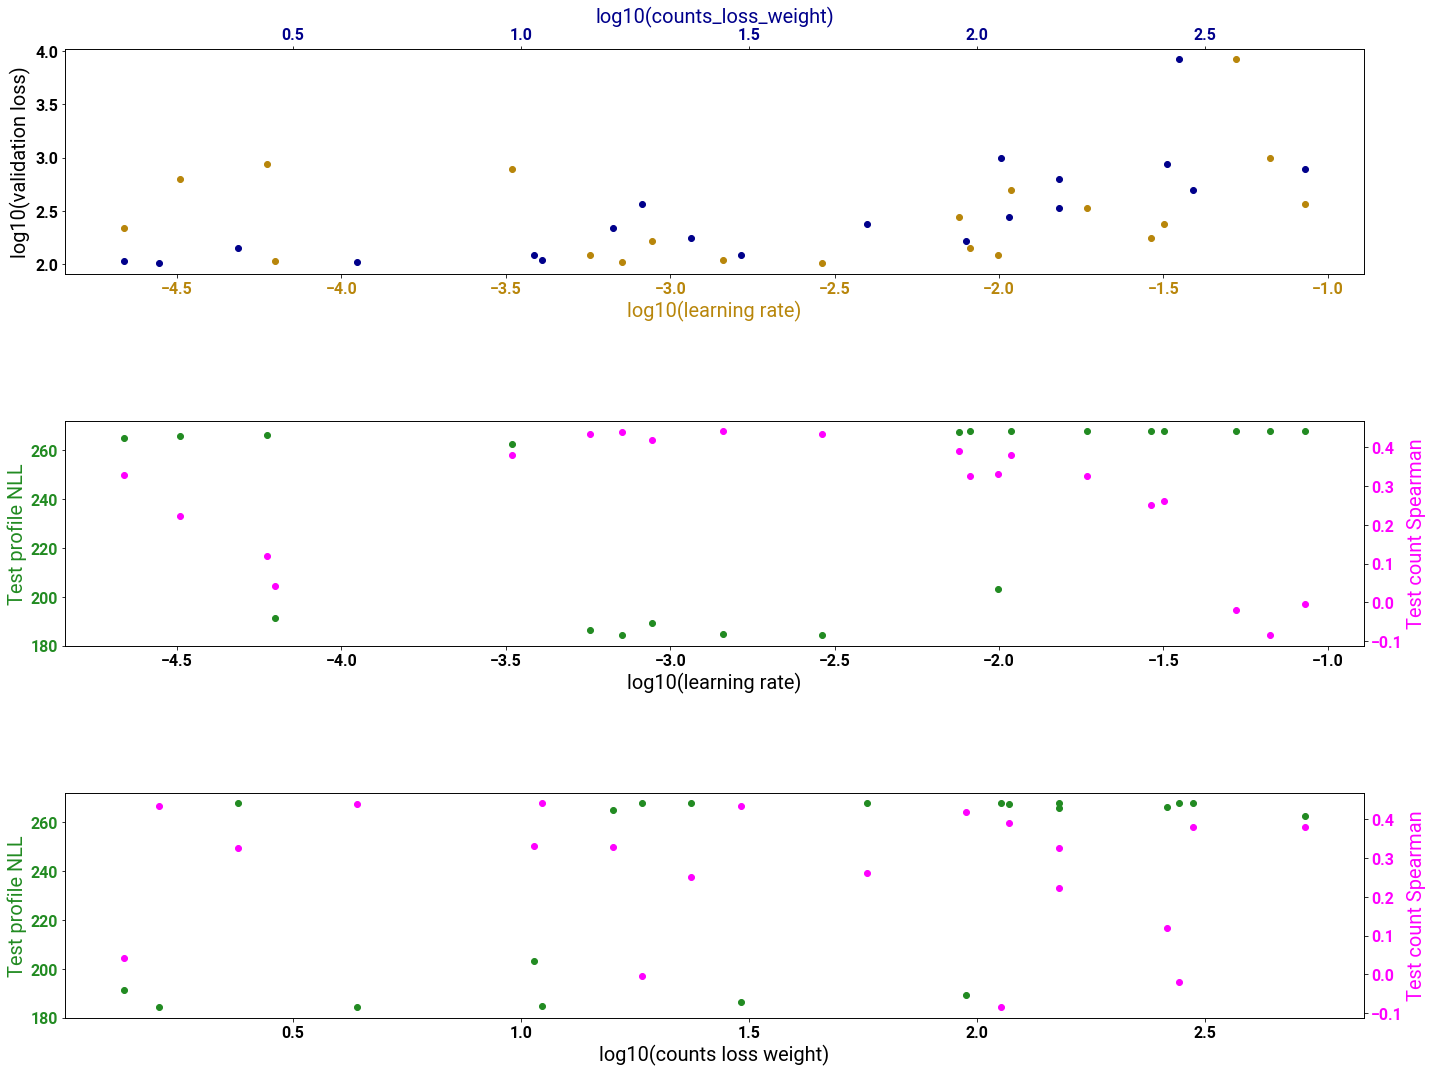

CEBPB: task_6


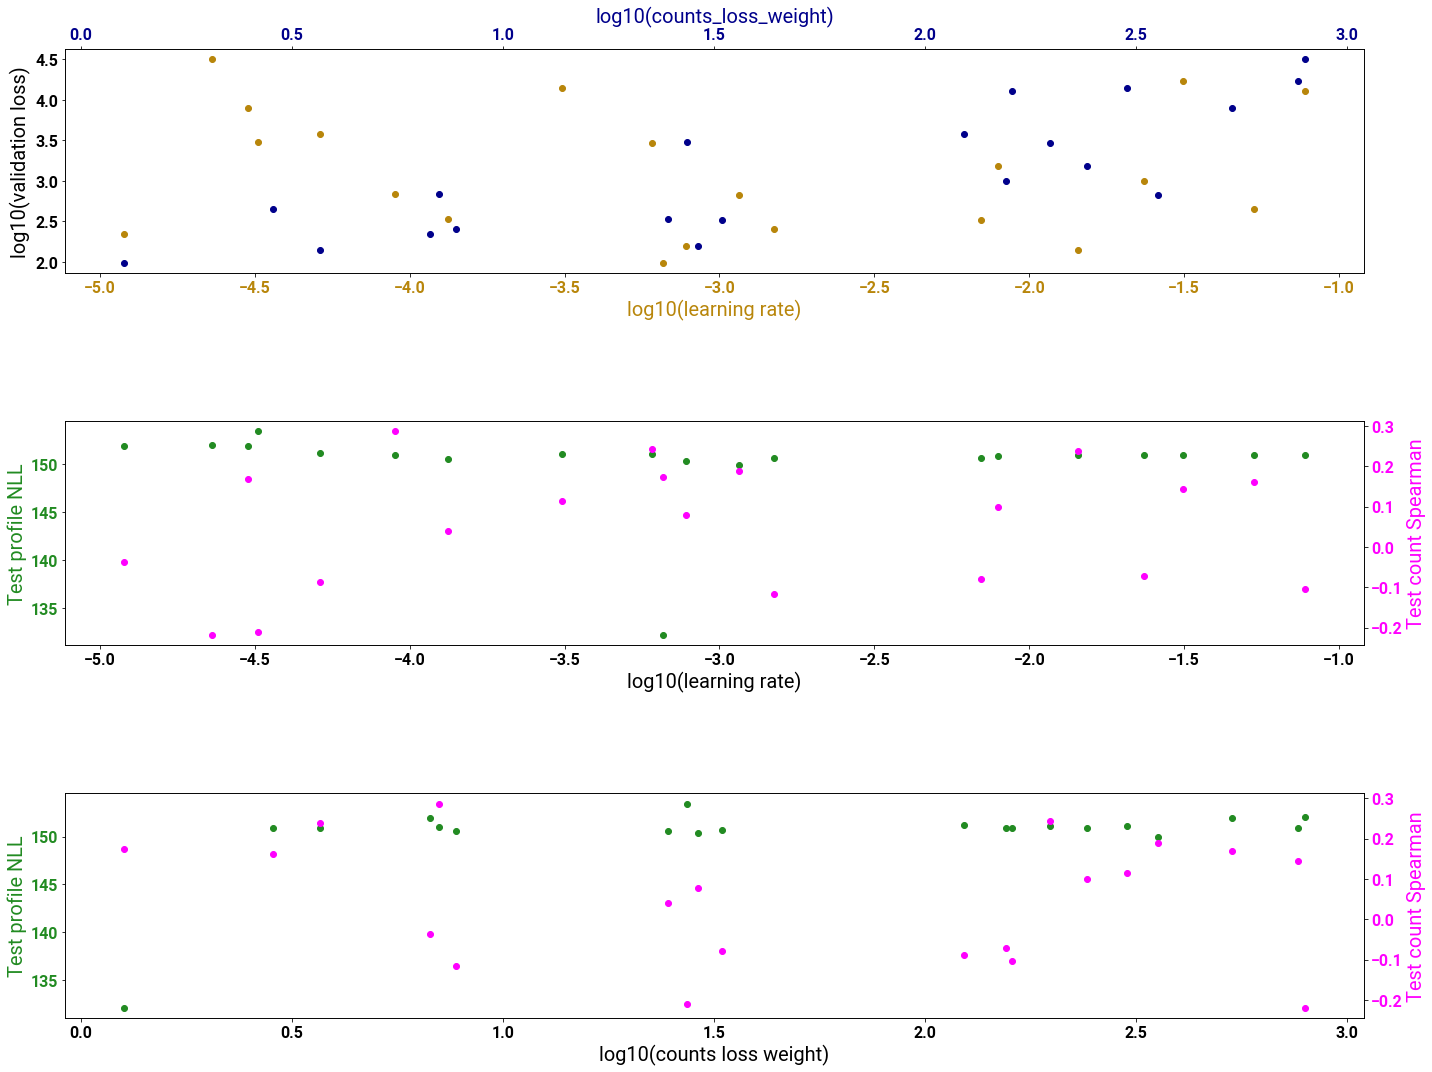

MAX: task_0


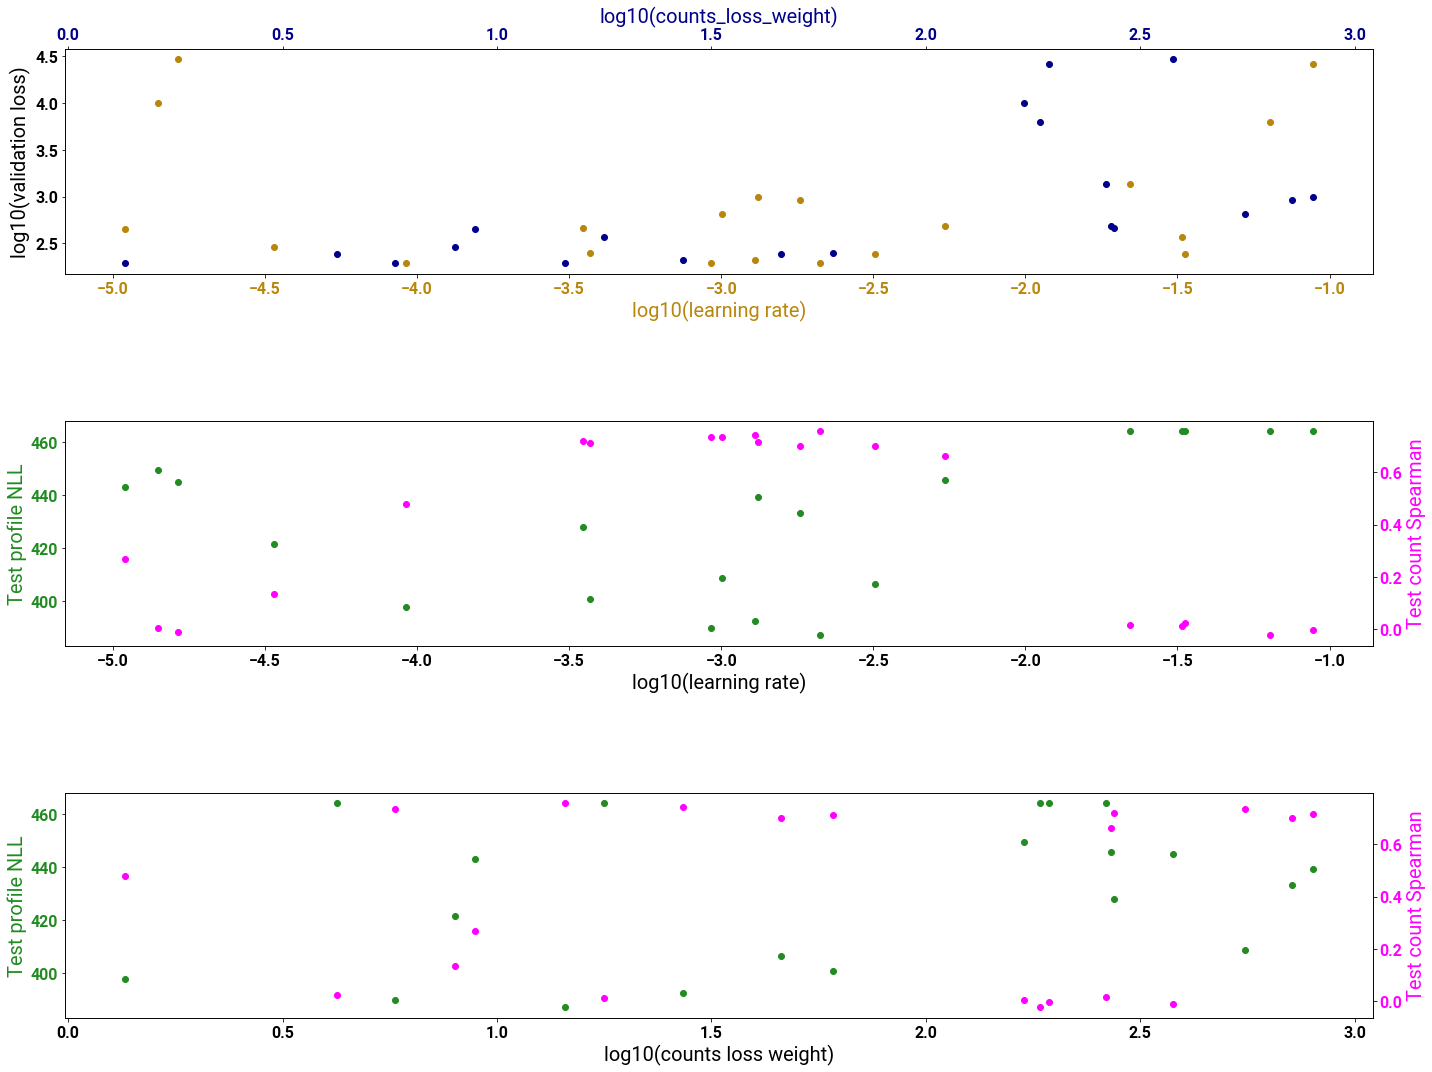

MAX: task_1


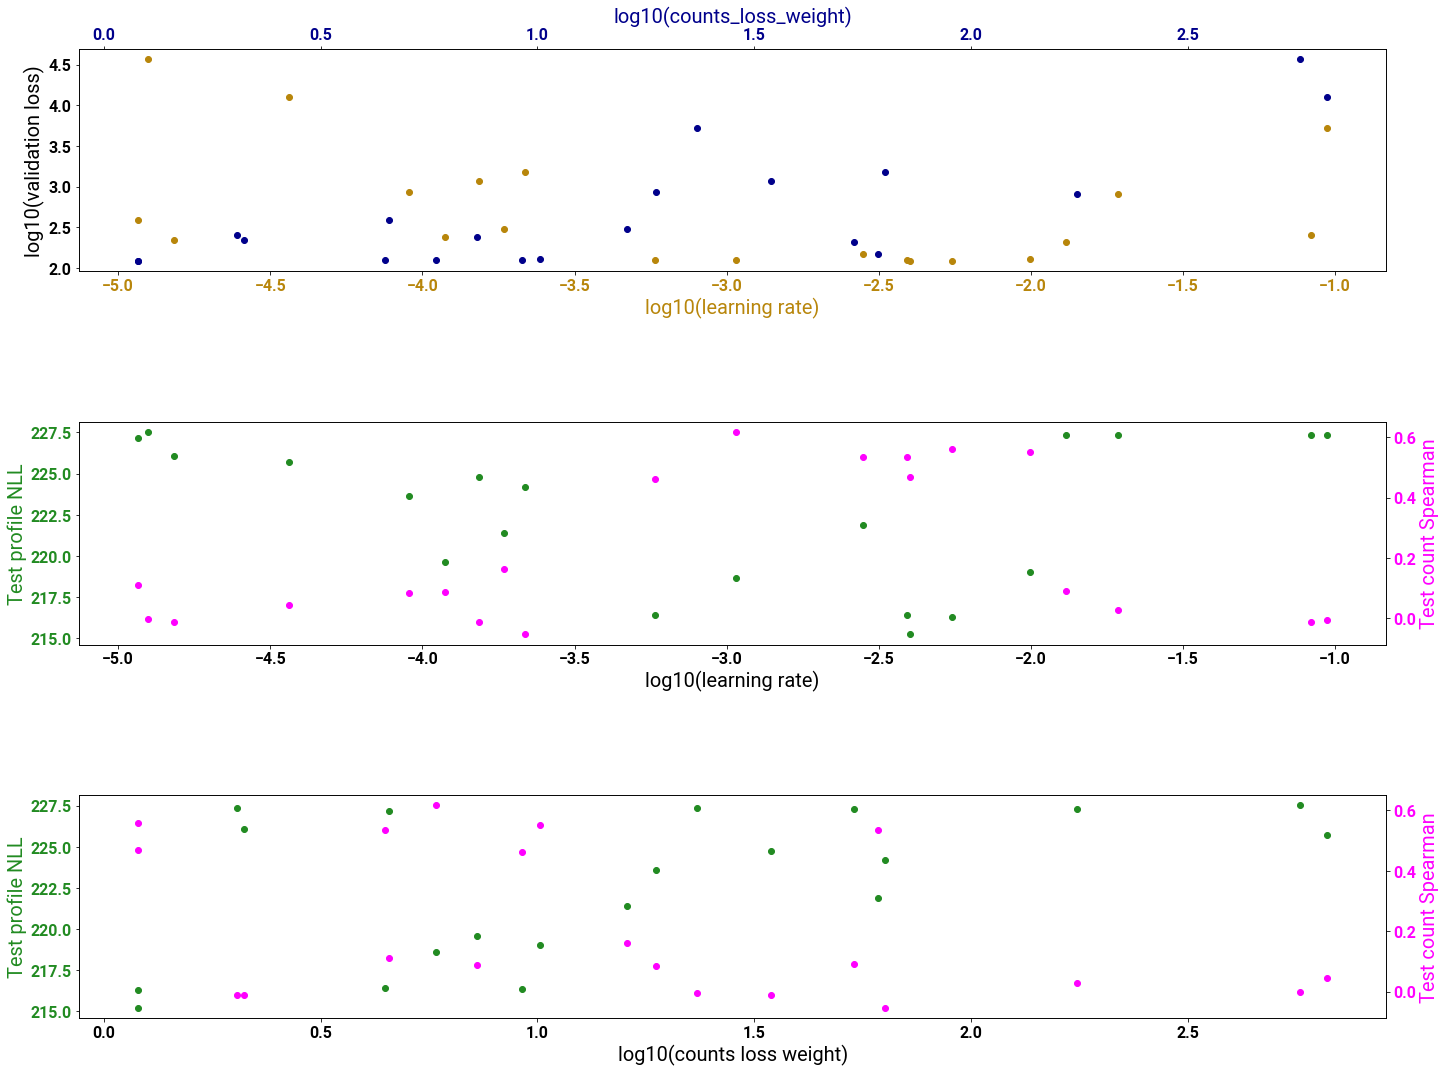

MAX: task_2


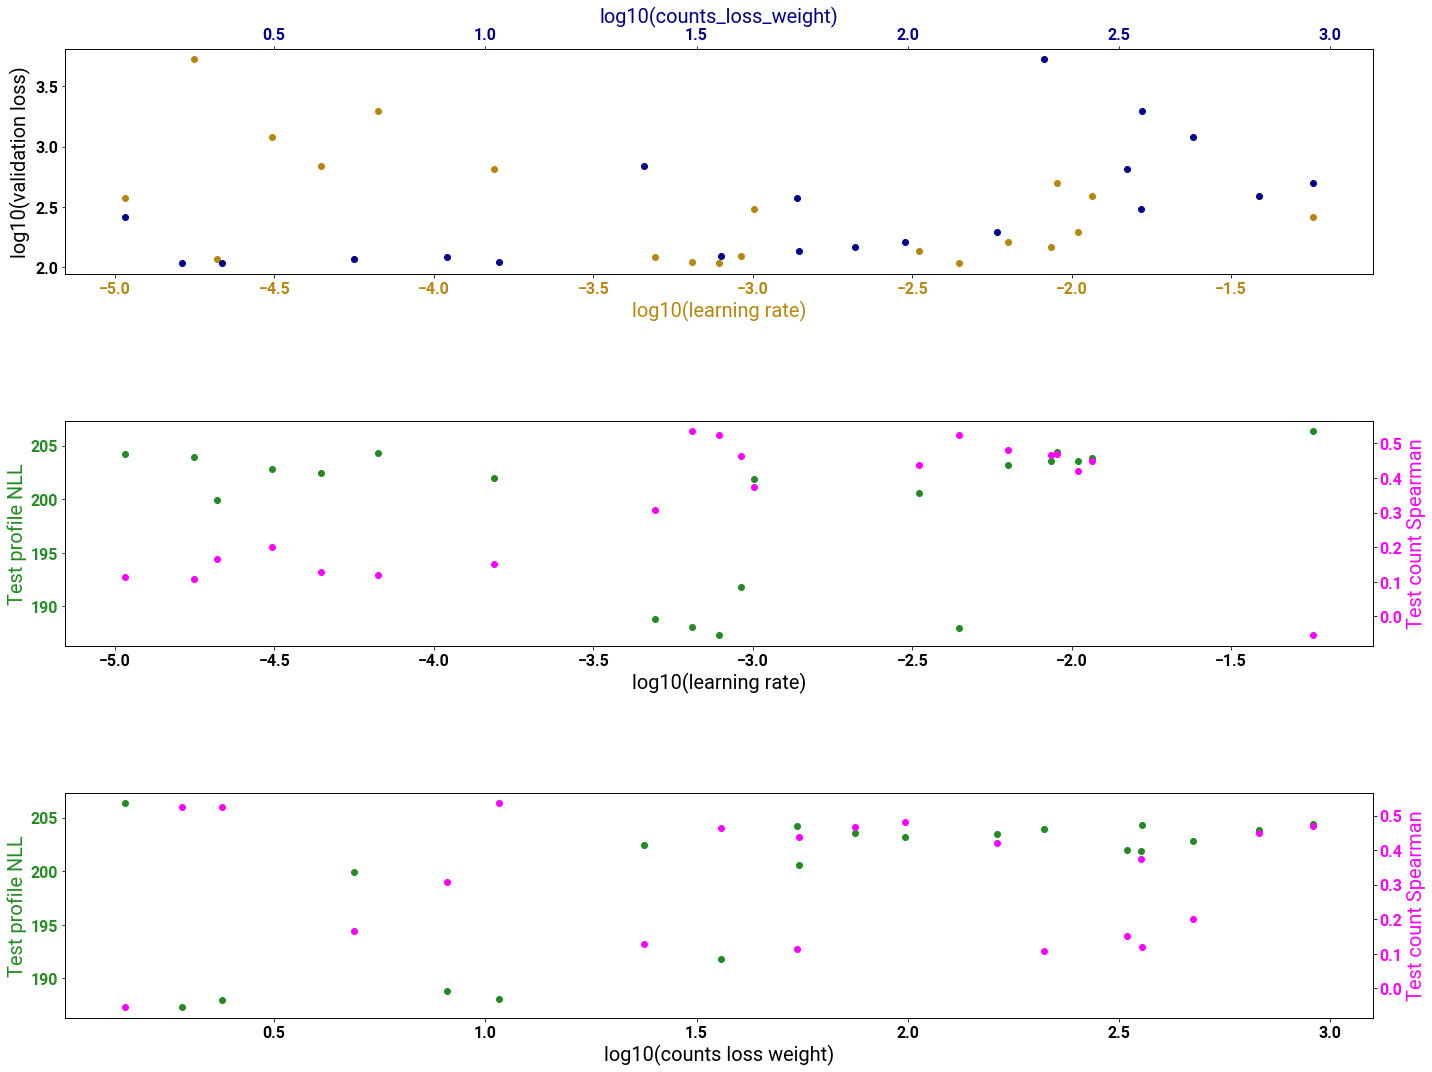

MAX: task_3


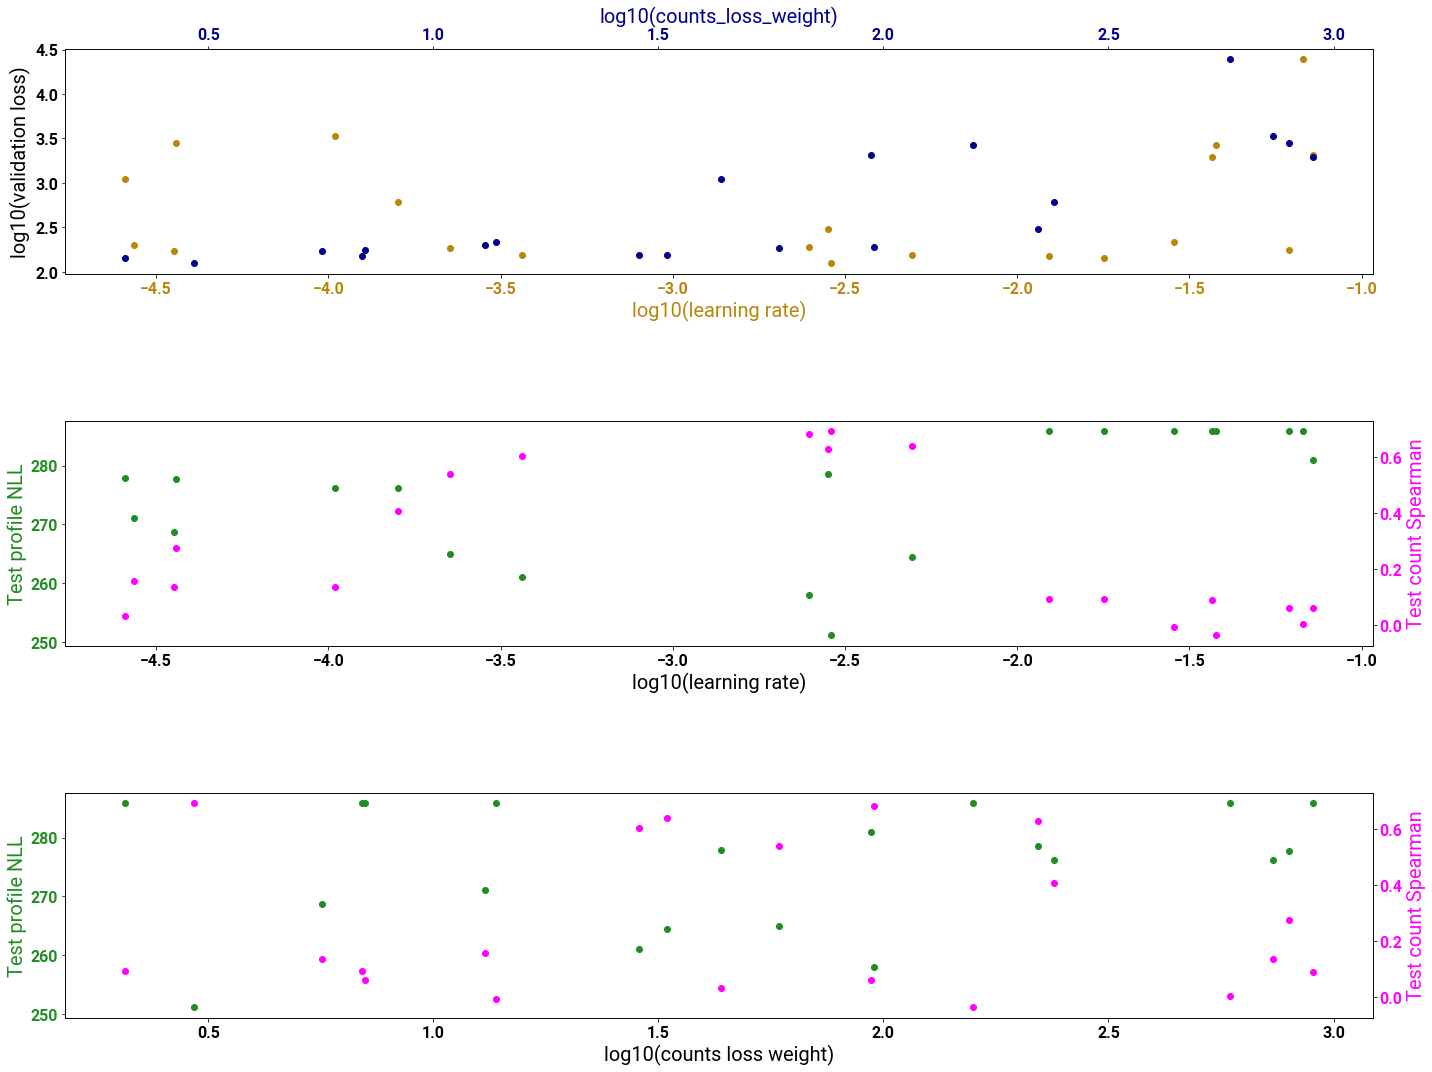

MAX: task_4


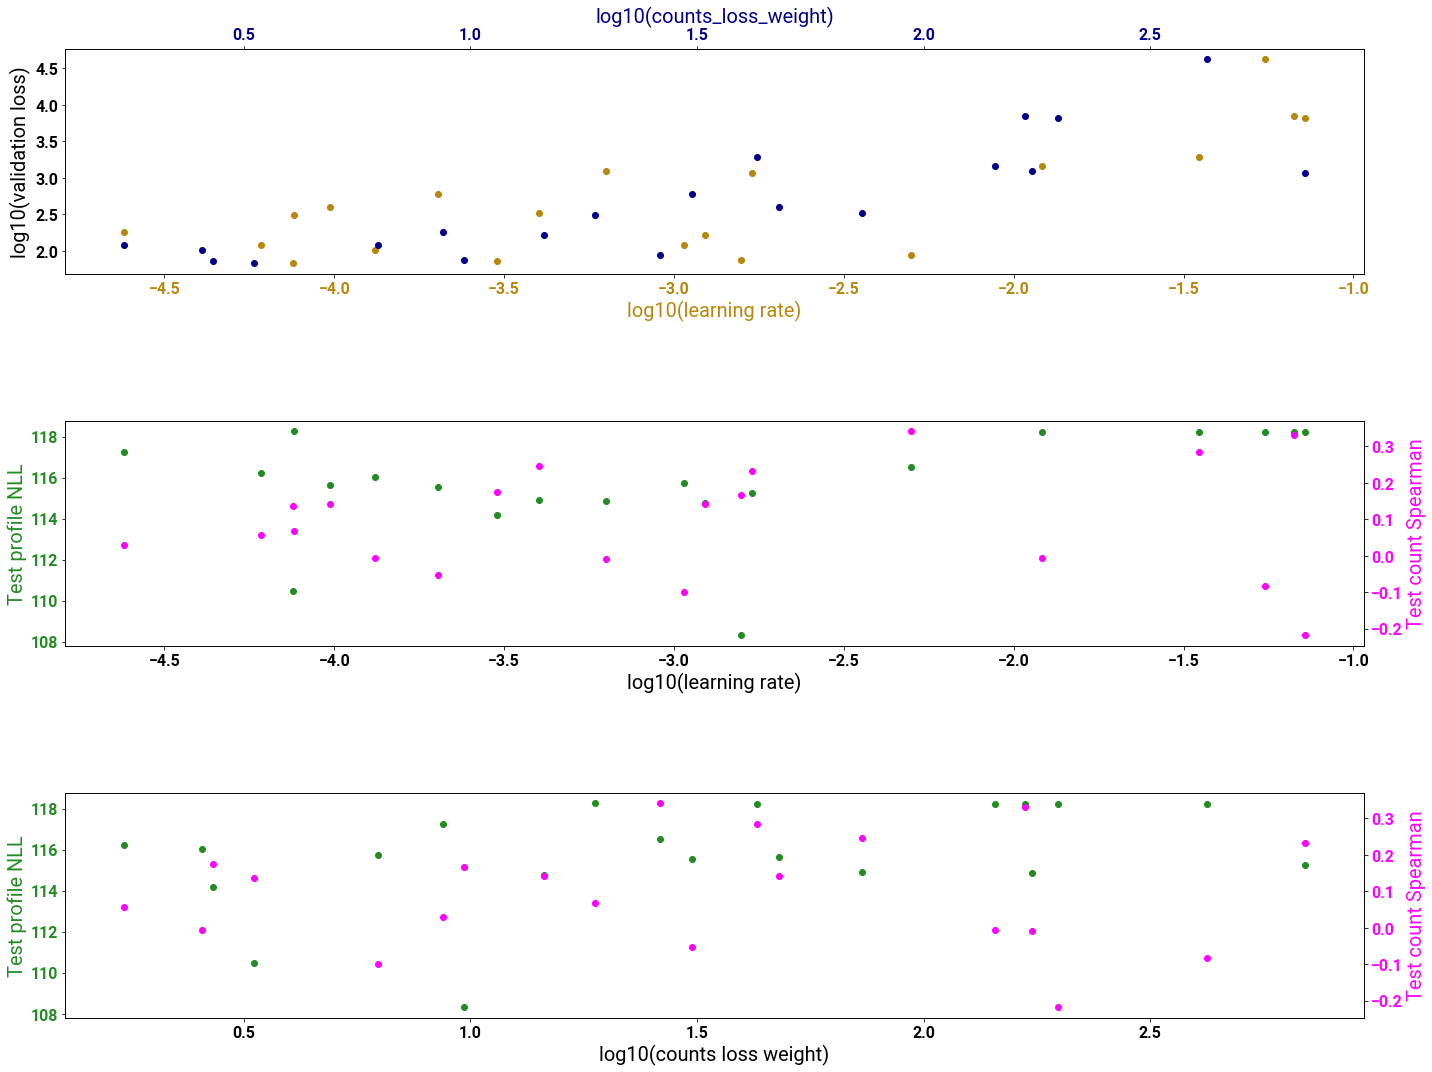

MAX: task_5


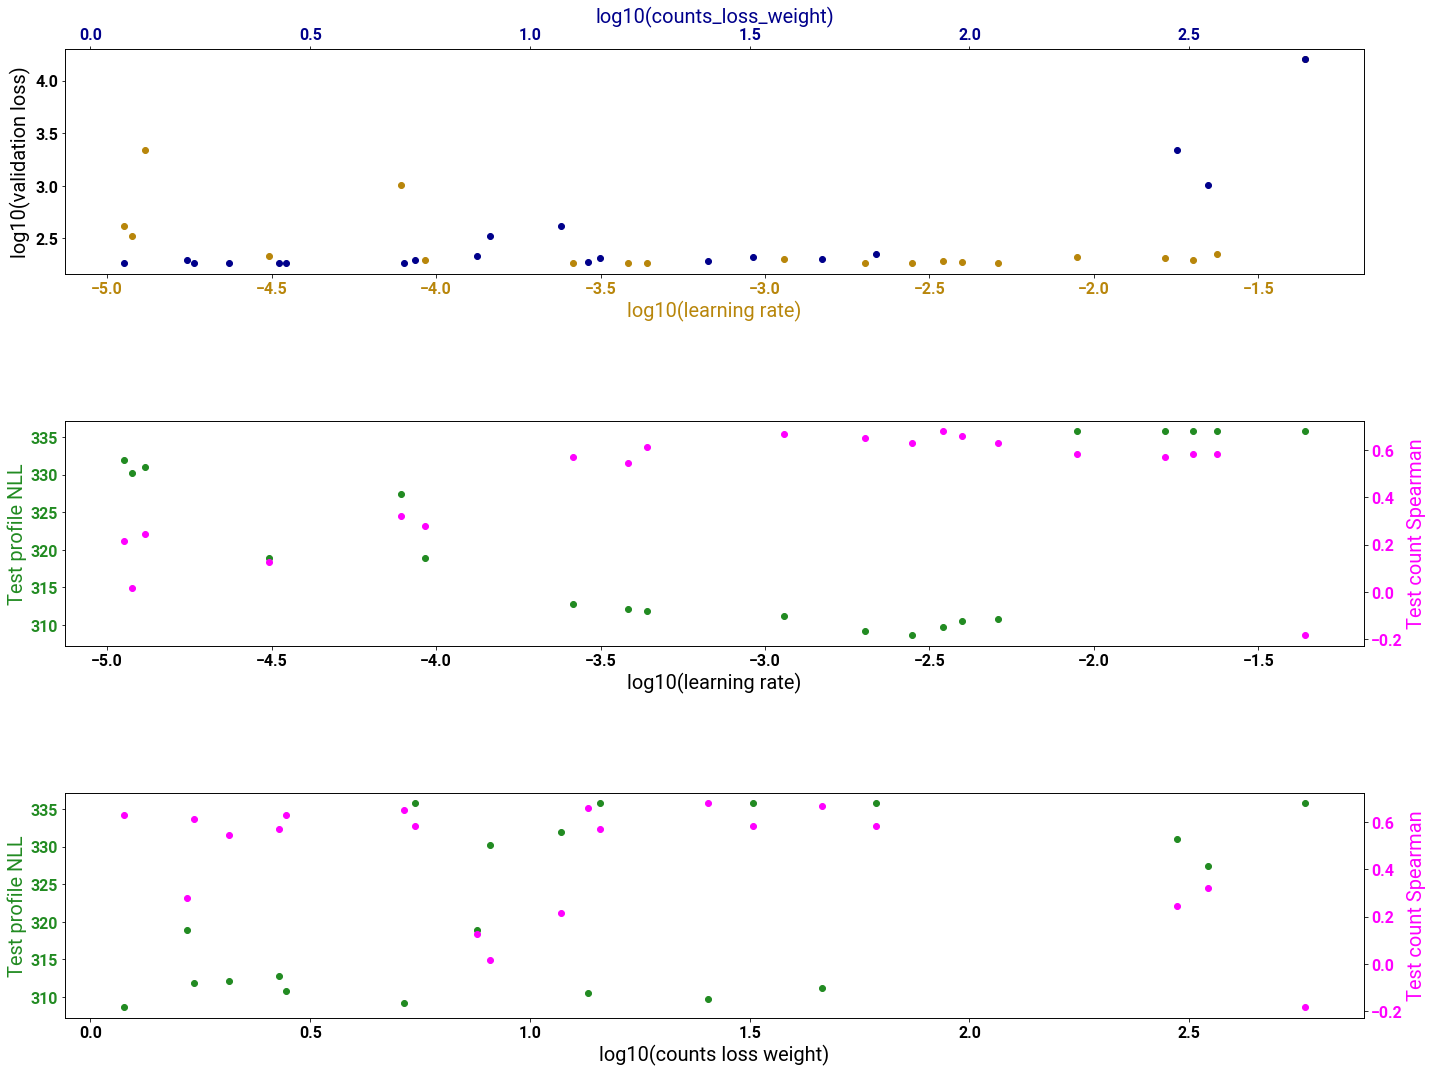

MAX: task_6


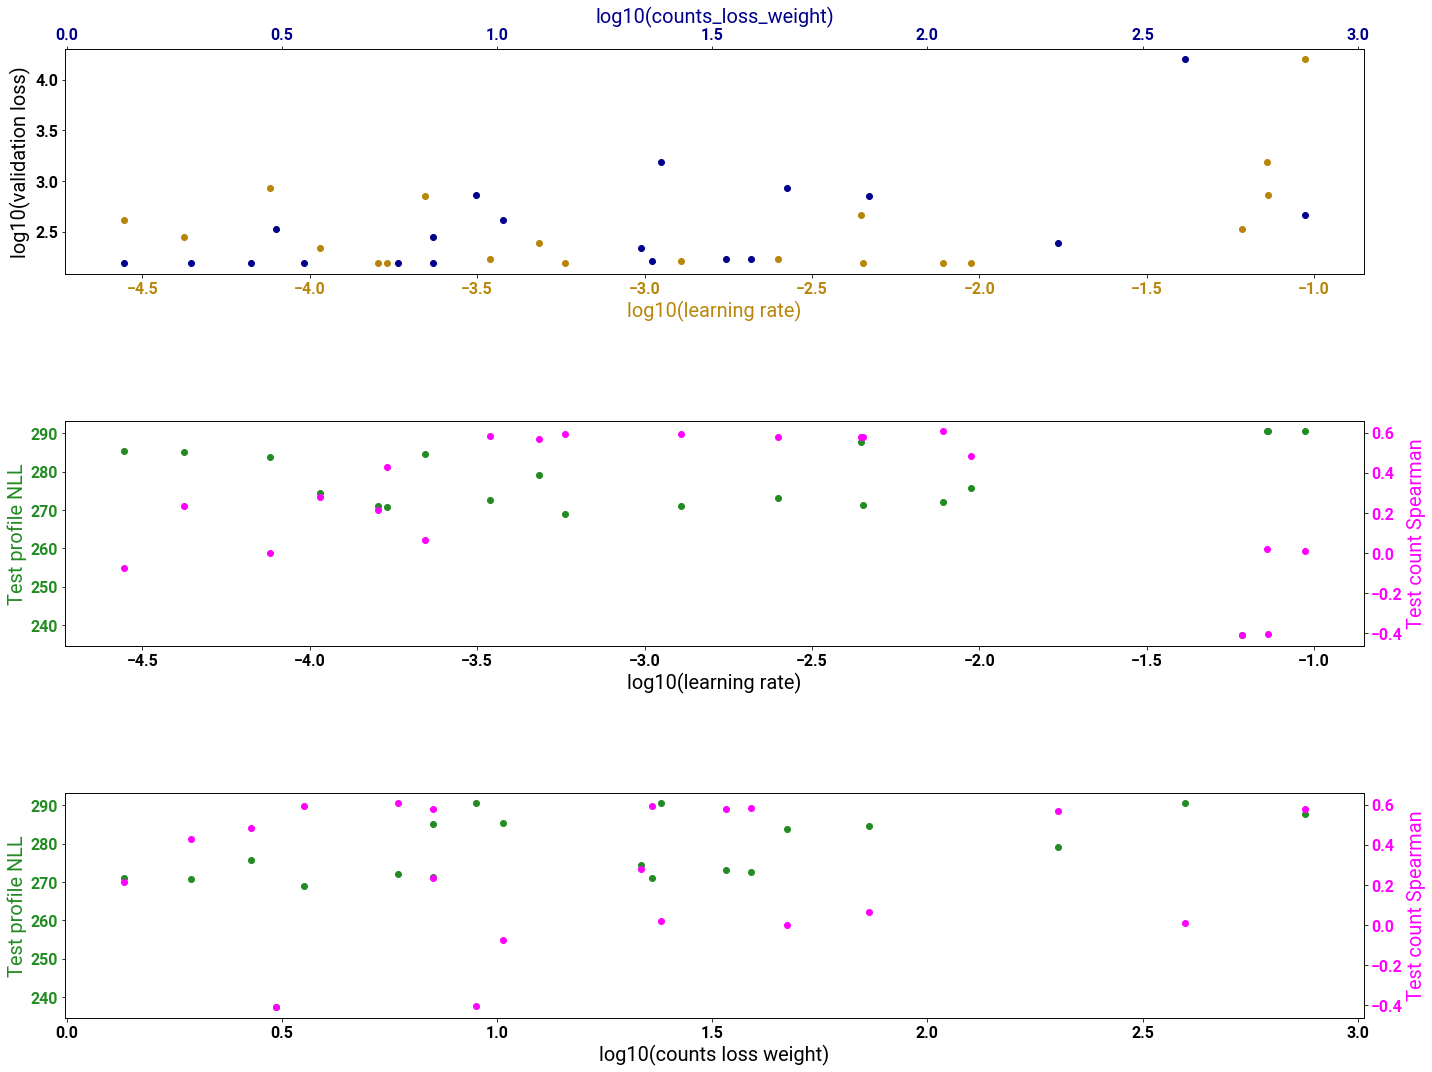

GABPA: task_0


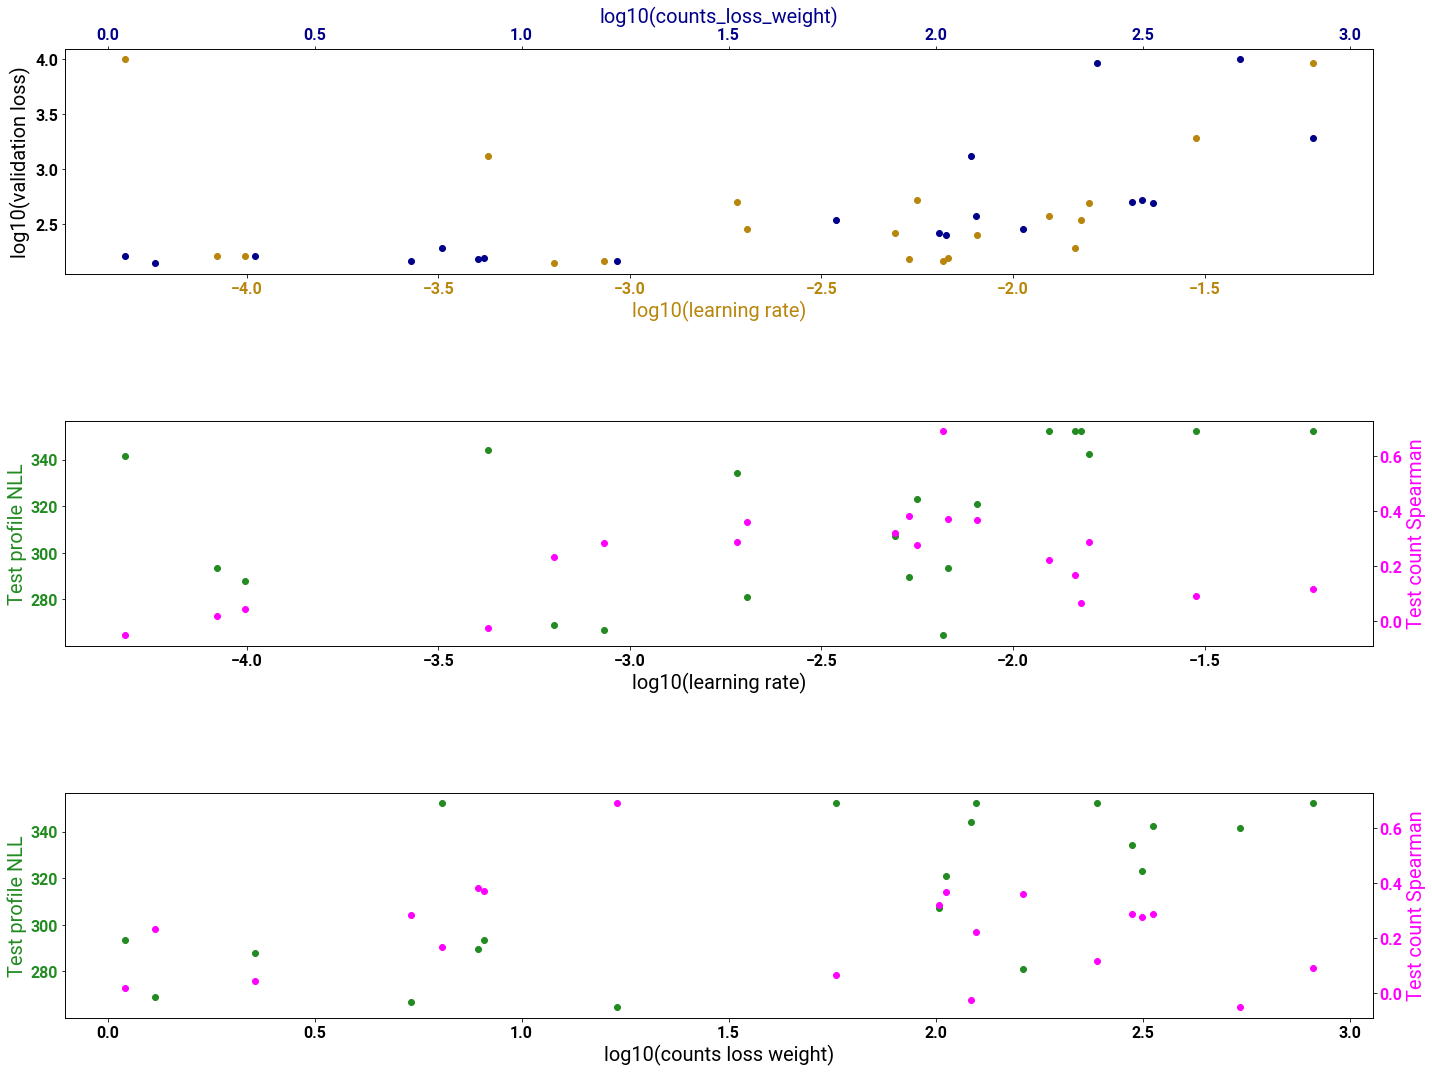

GABPA: task_1


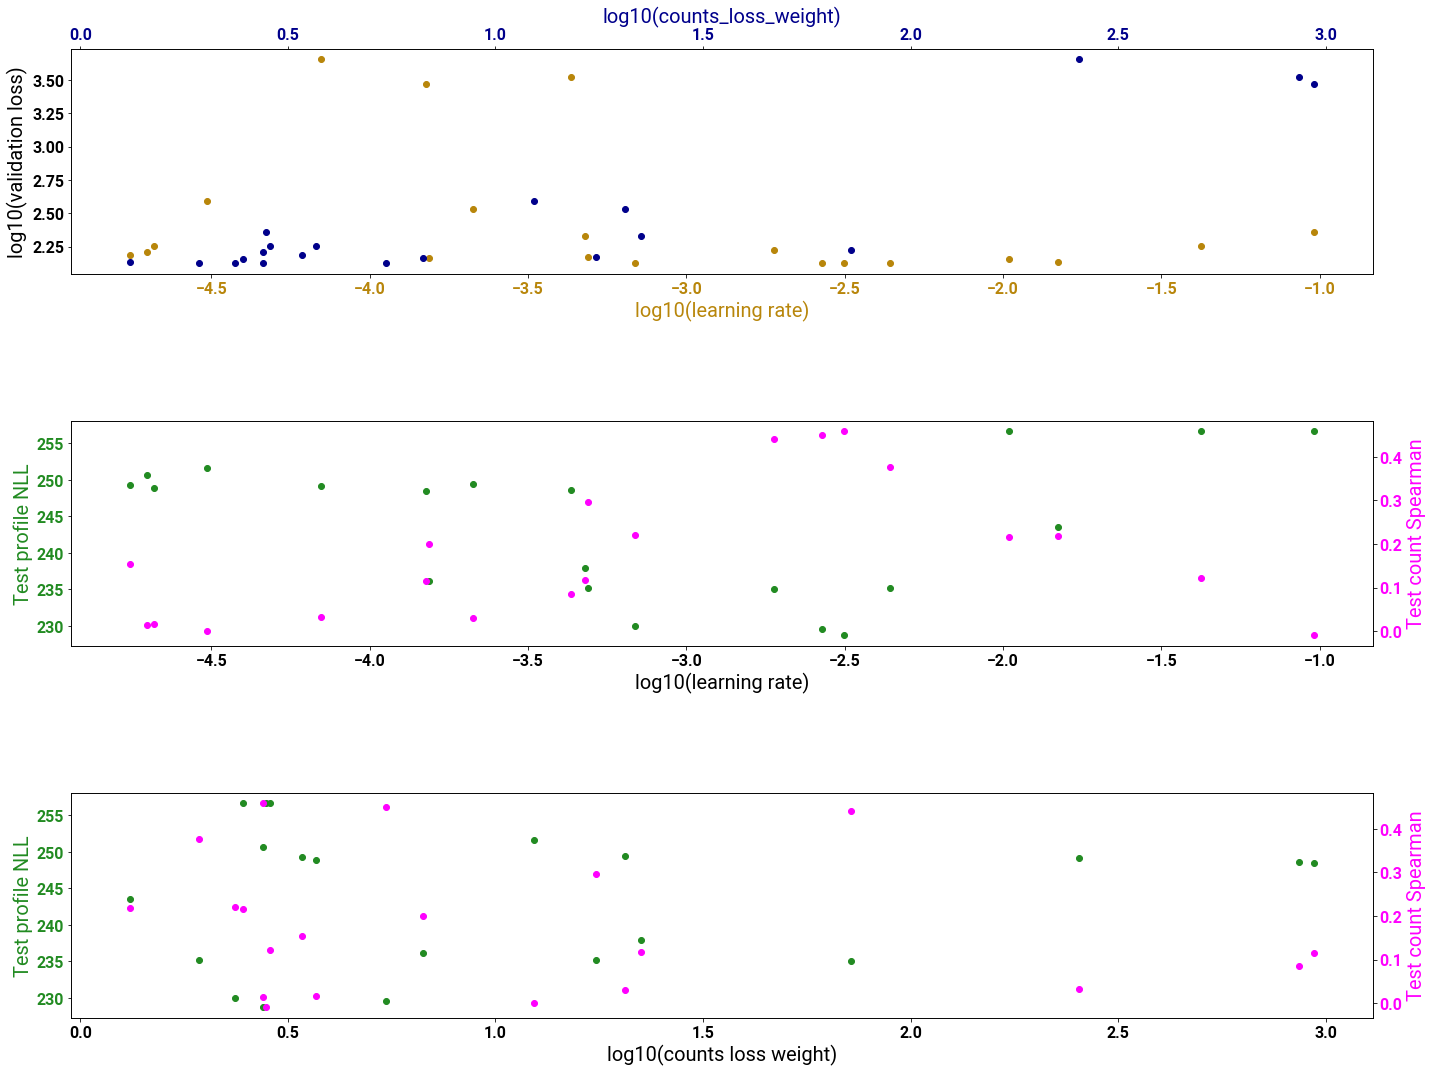

GABPA: task_2


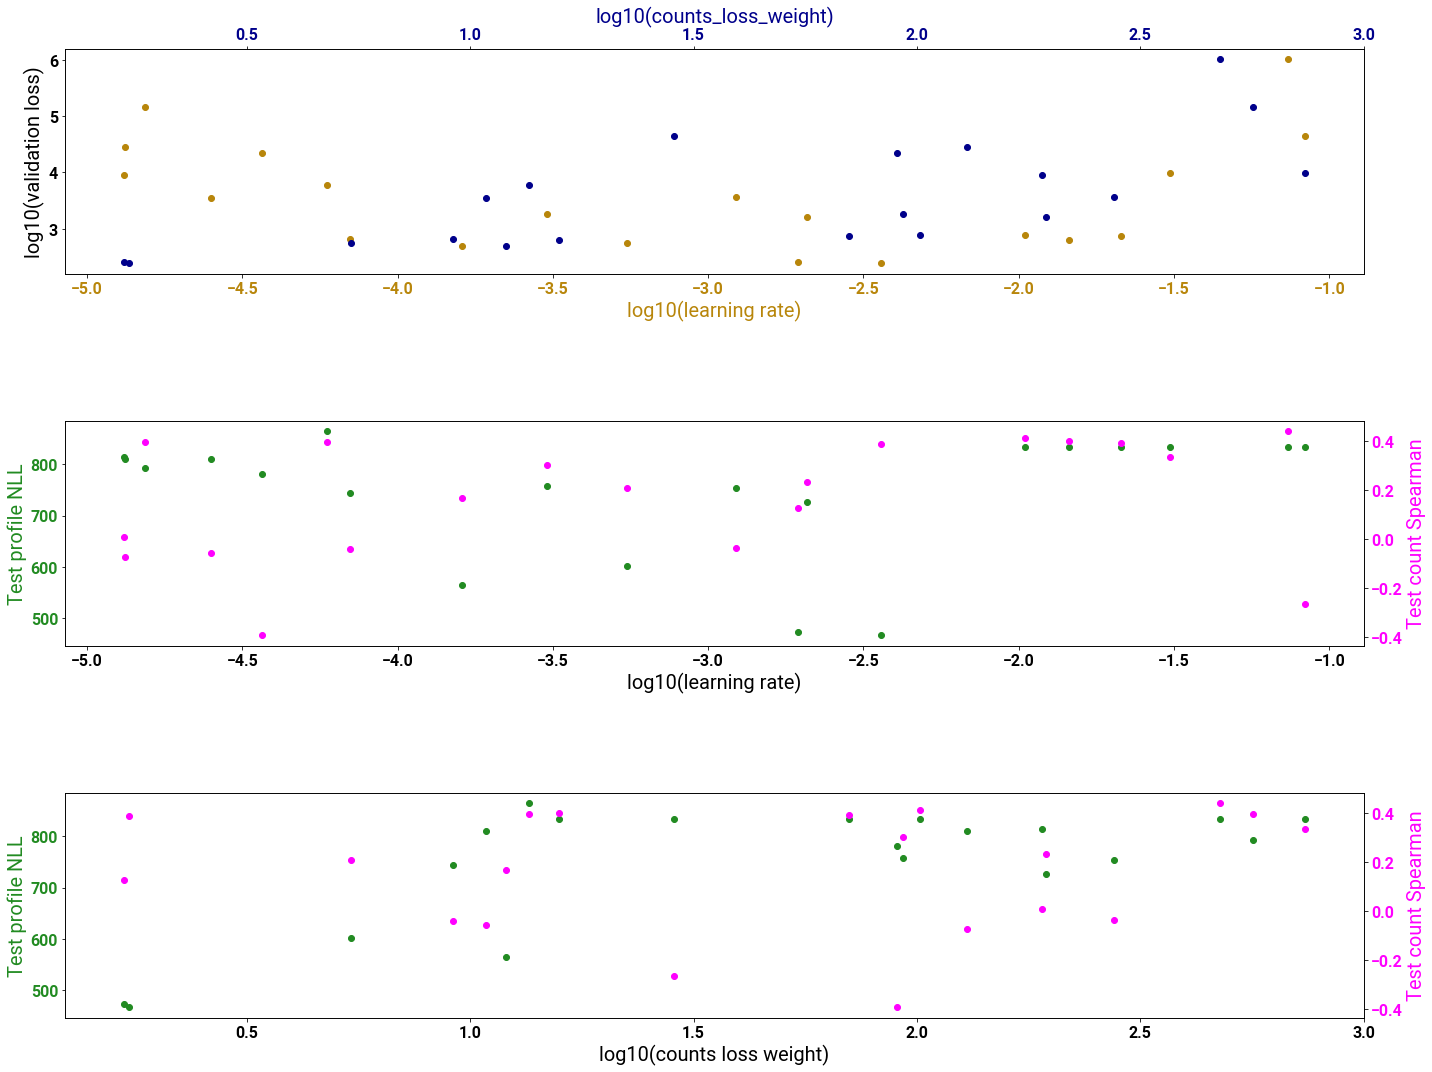

GABPA: task_3


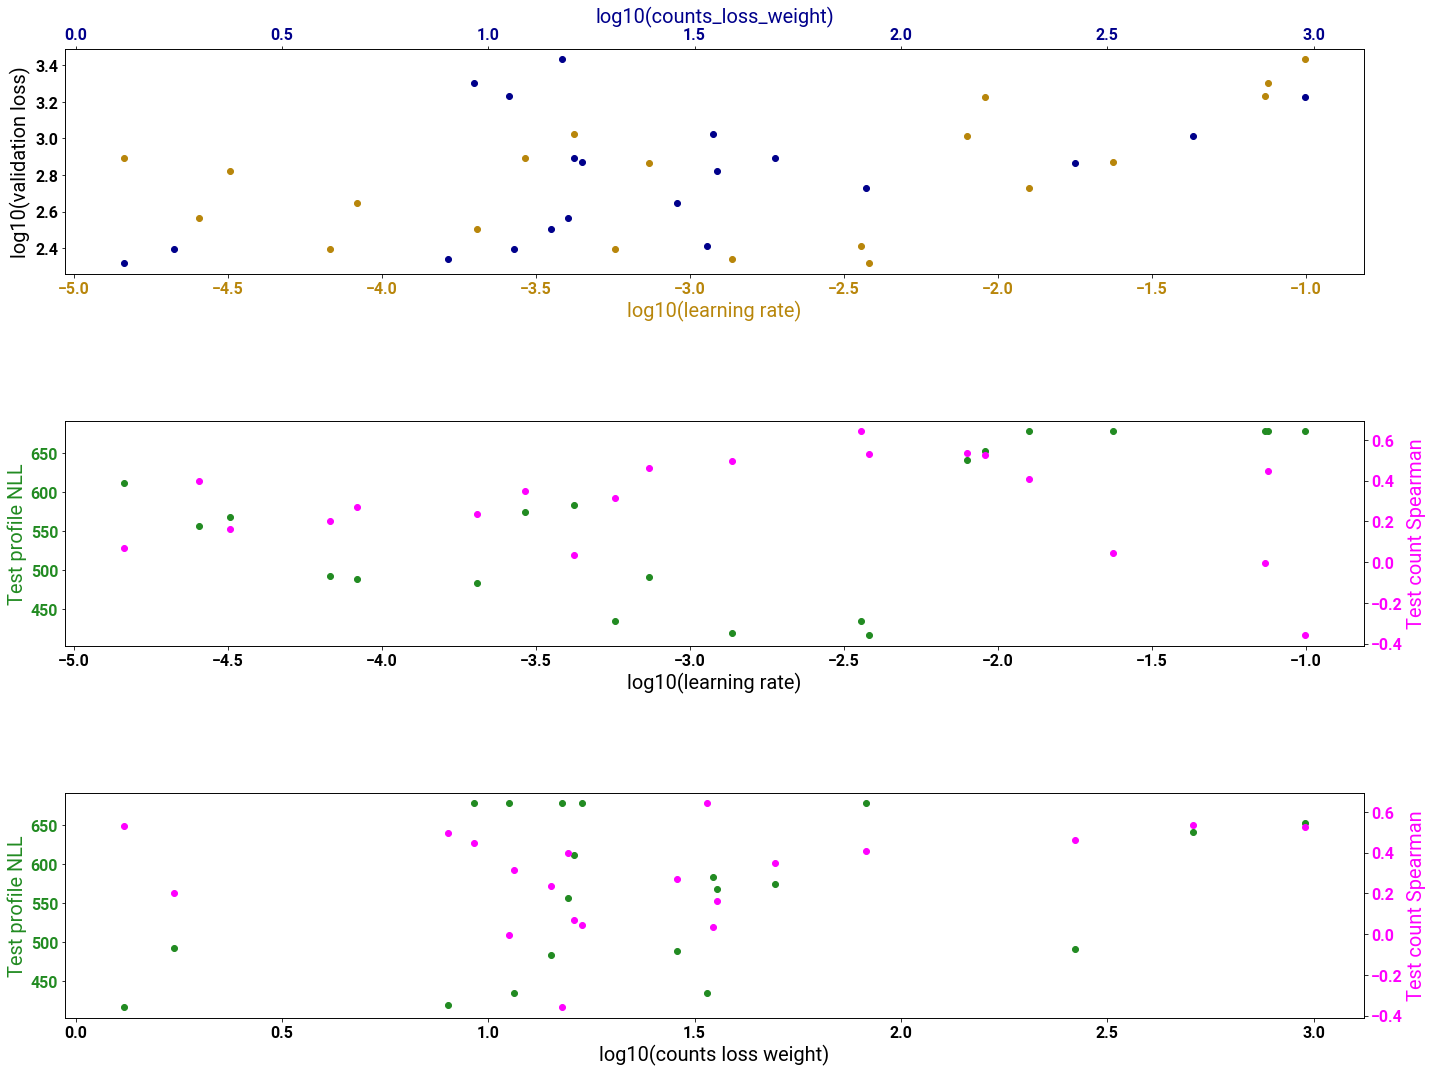

GABPA: task_4


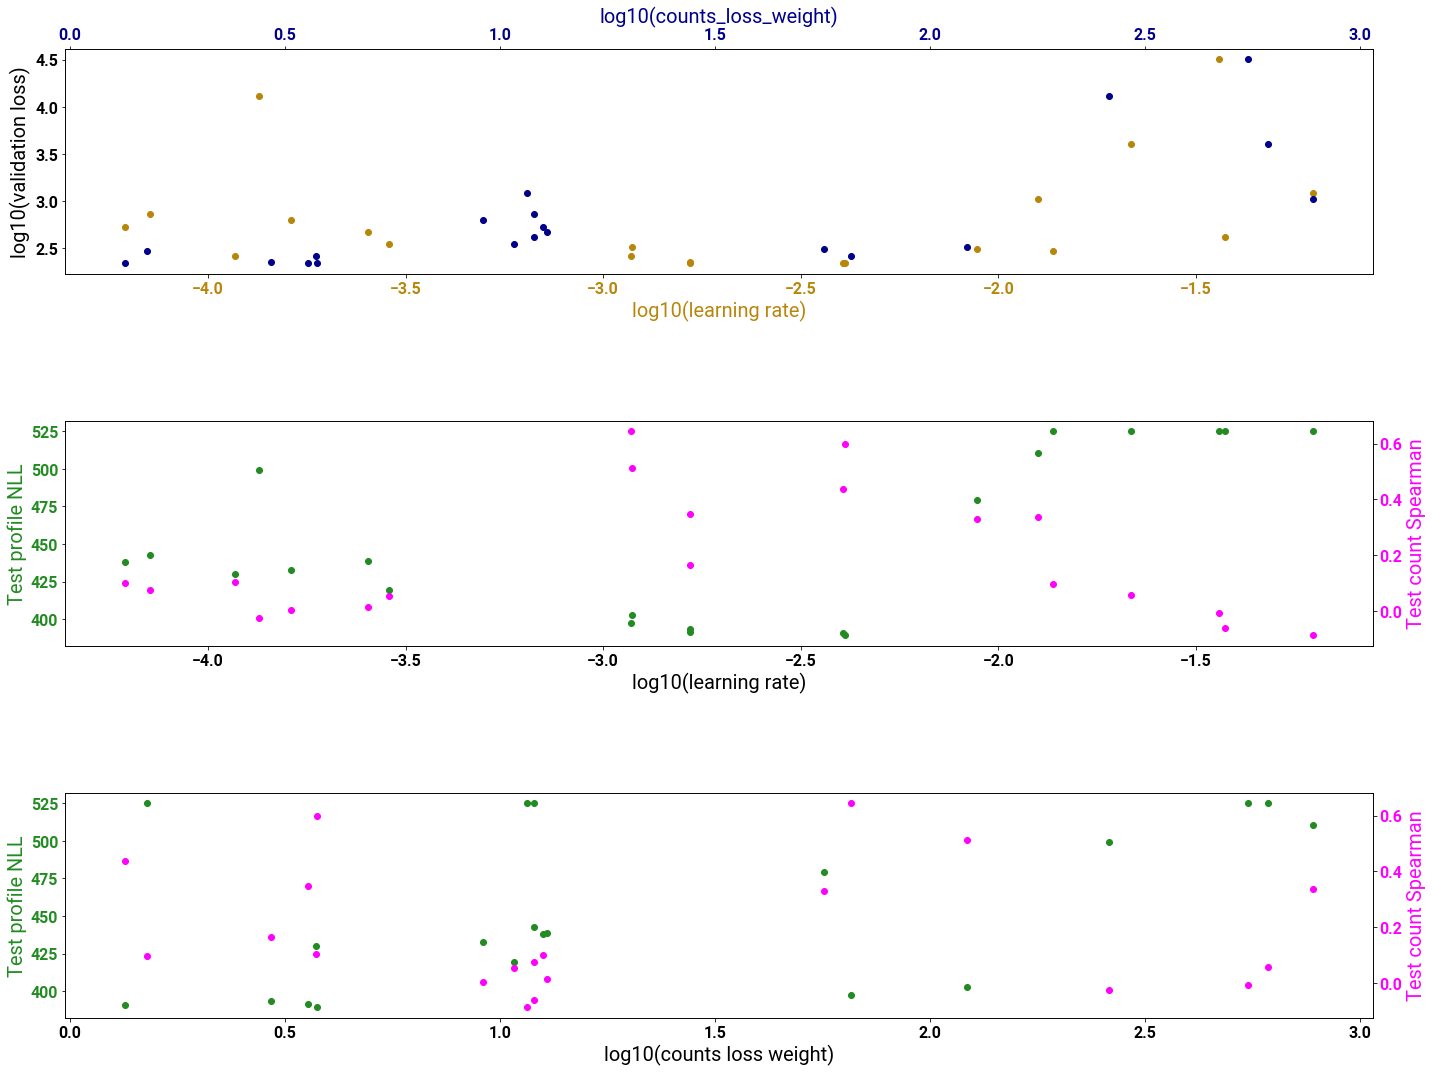

GABPA: task_5


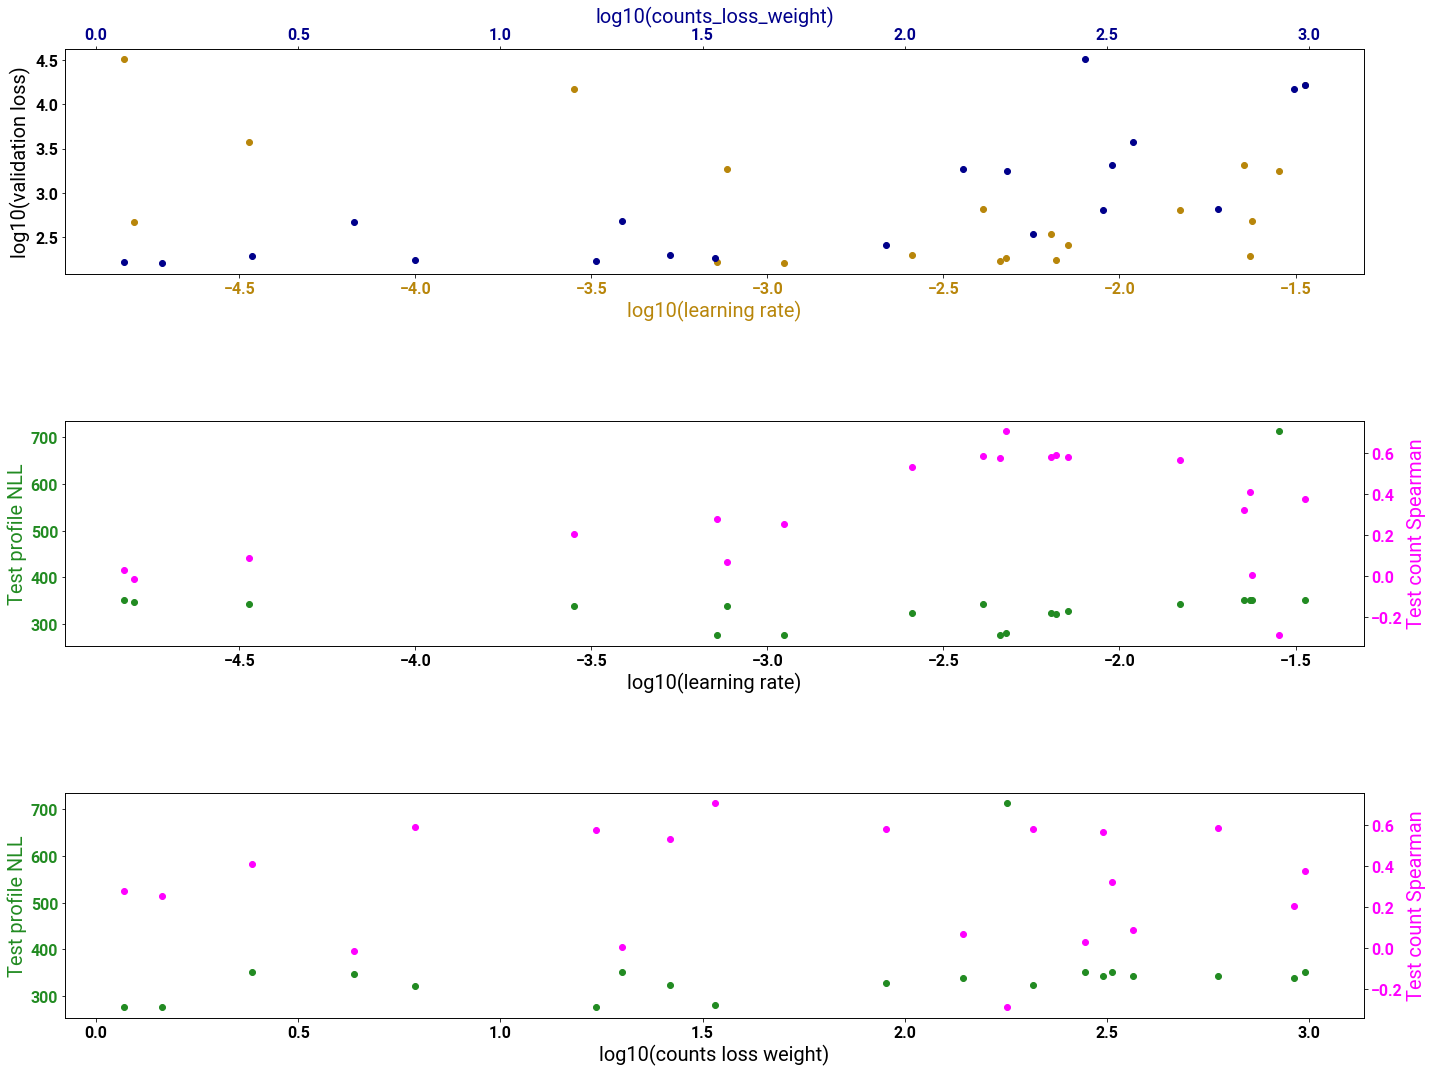

GABPA: task_6


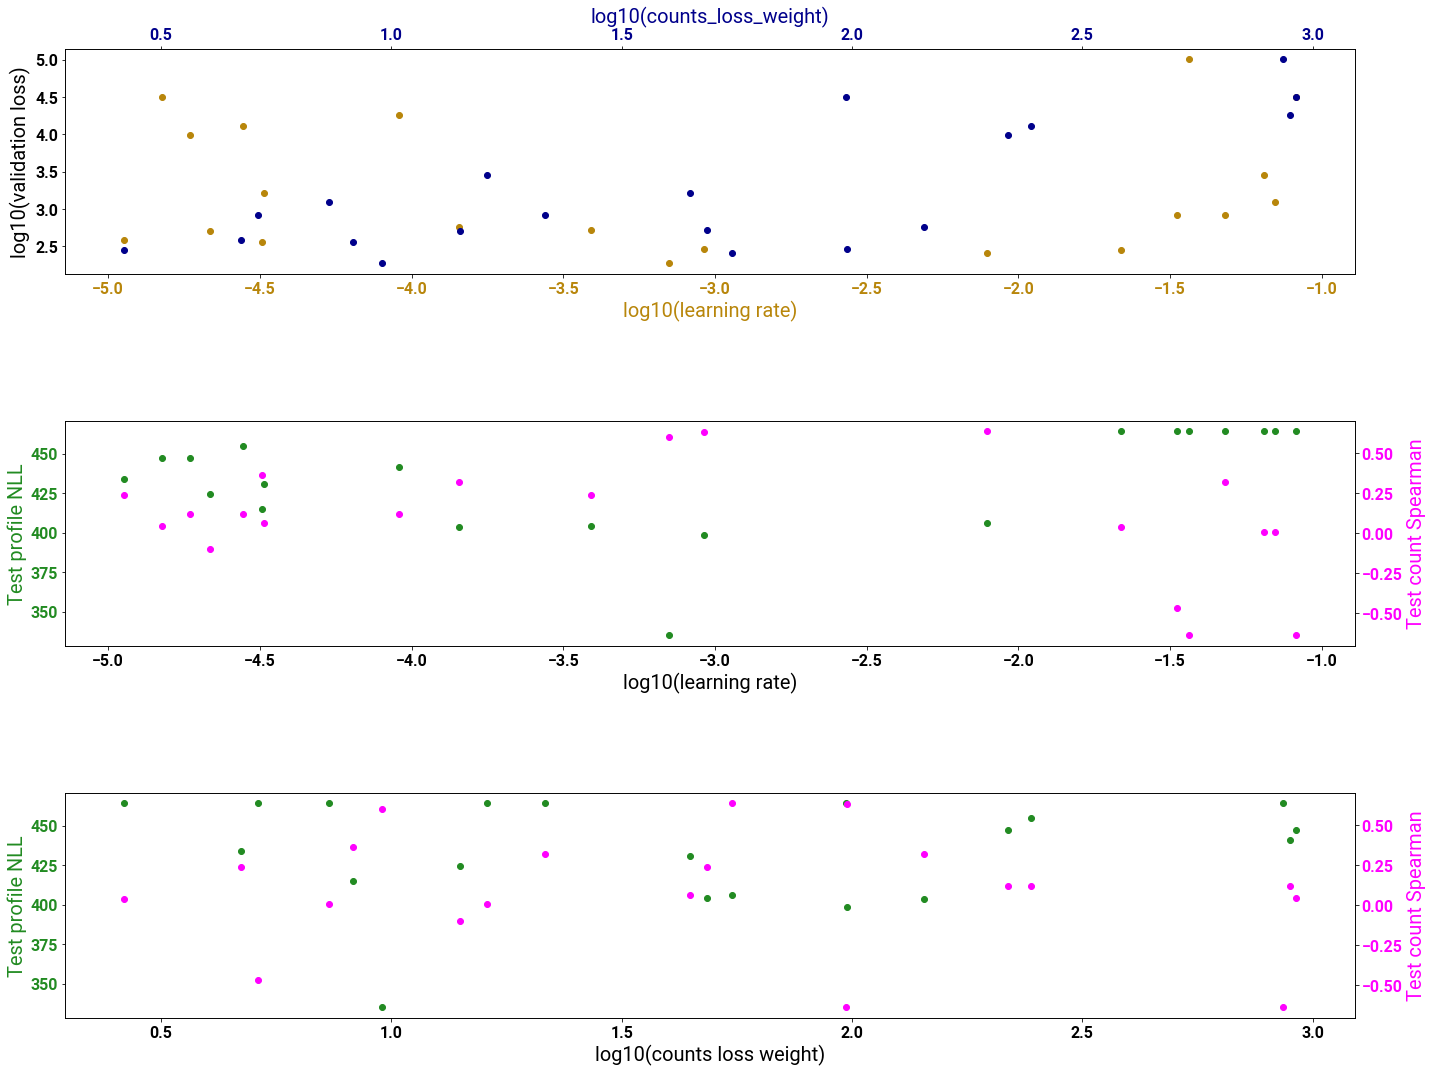

GABPA: task_7


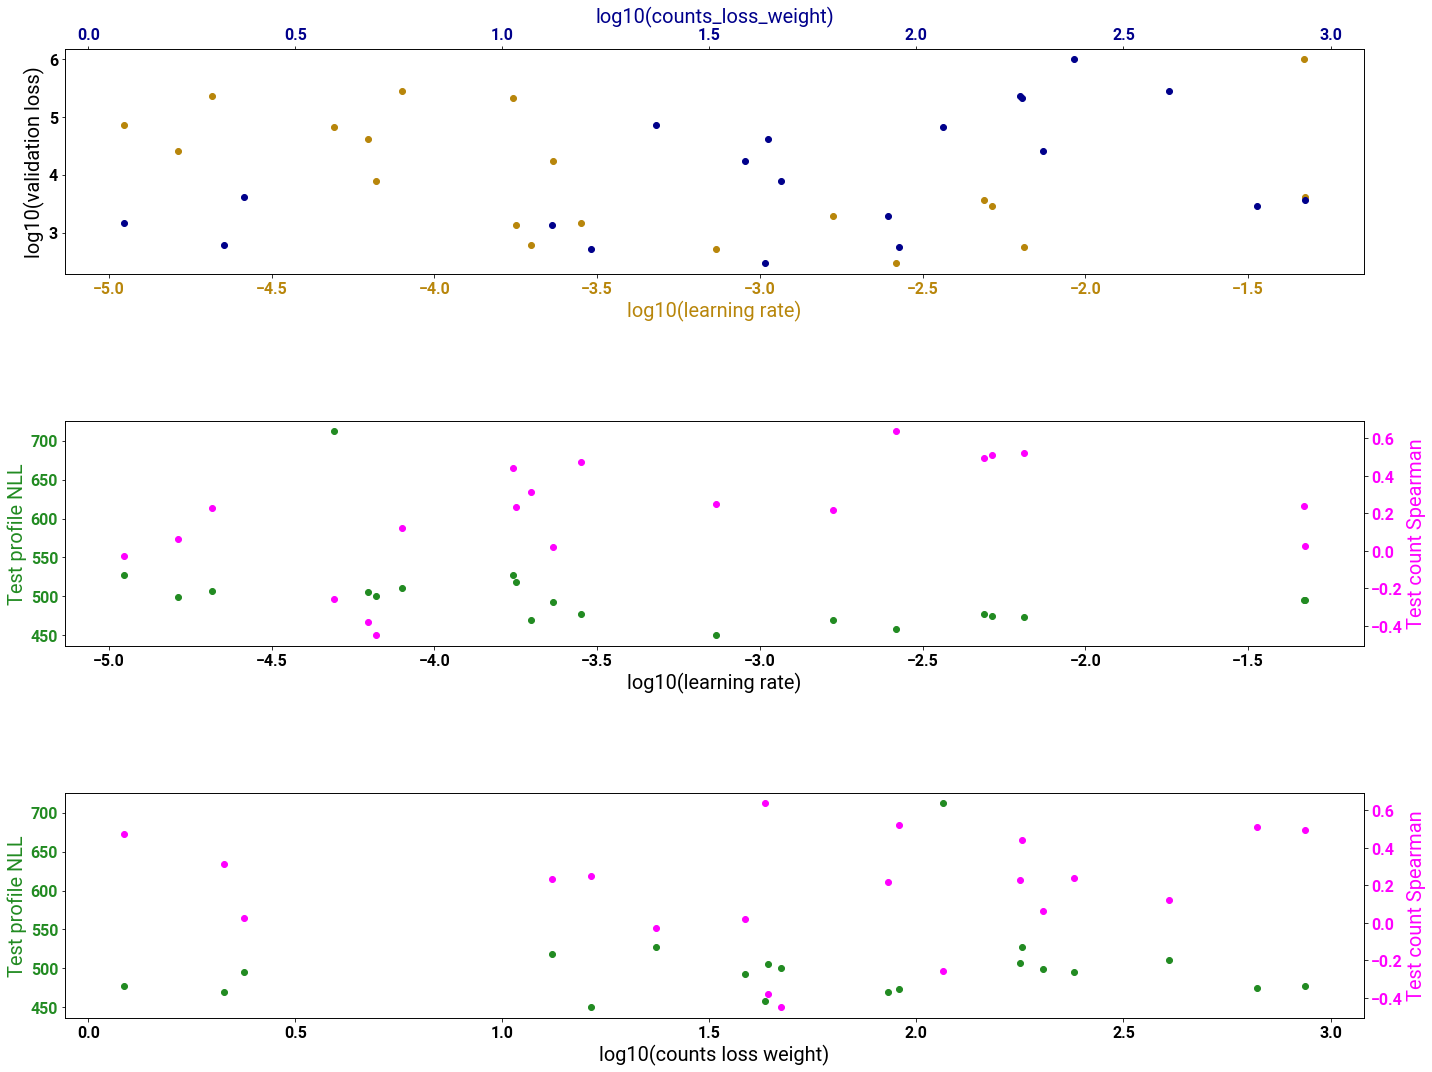

GABPA: task_8


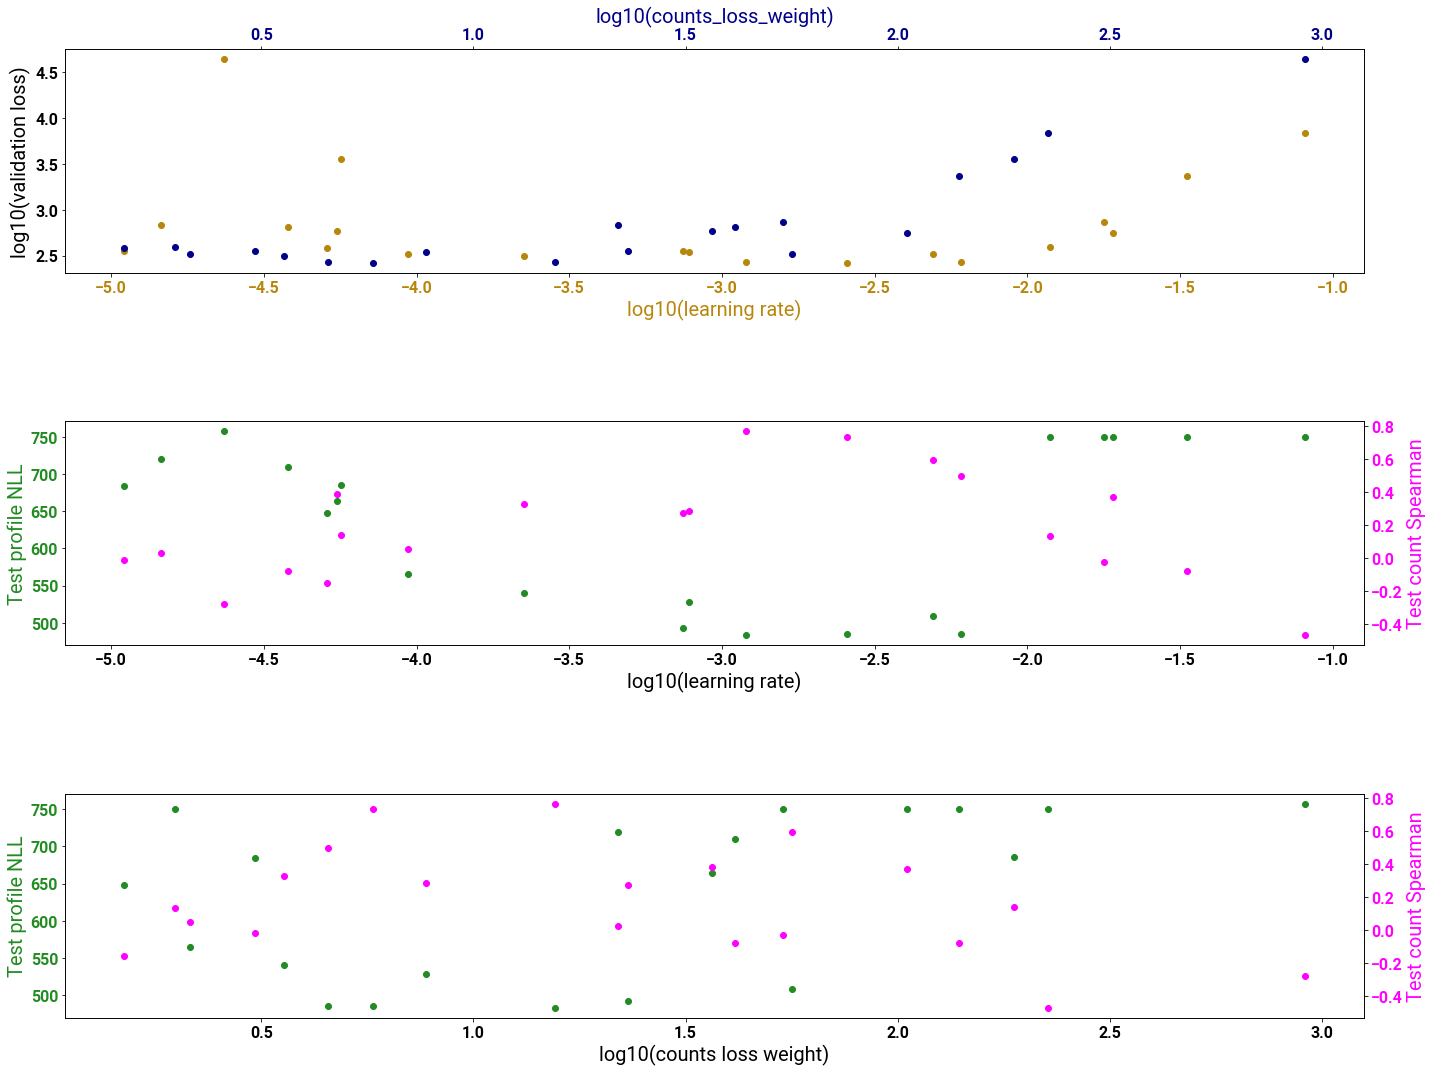

MAFK: task_0


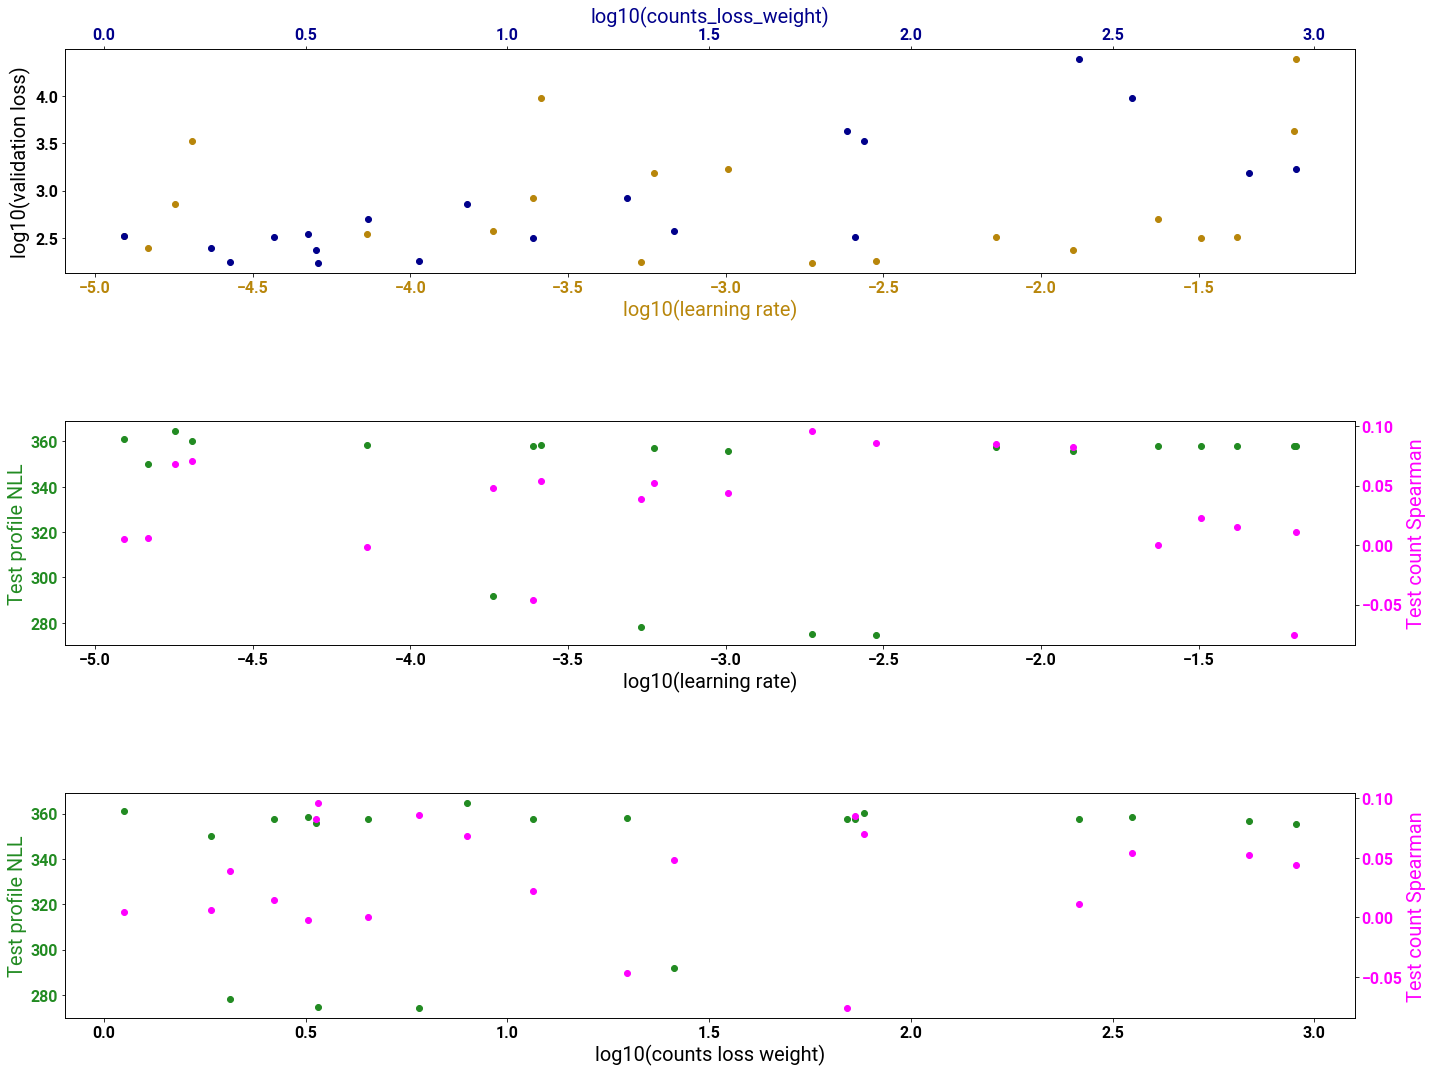

MAFK: task_1


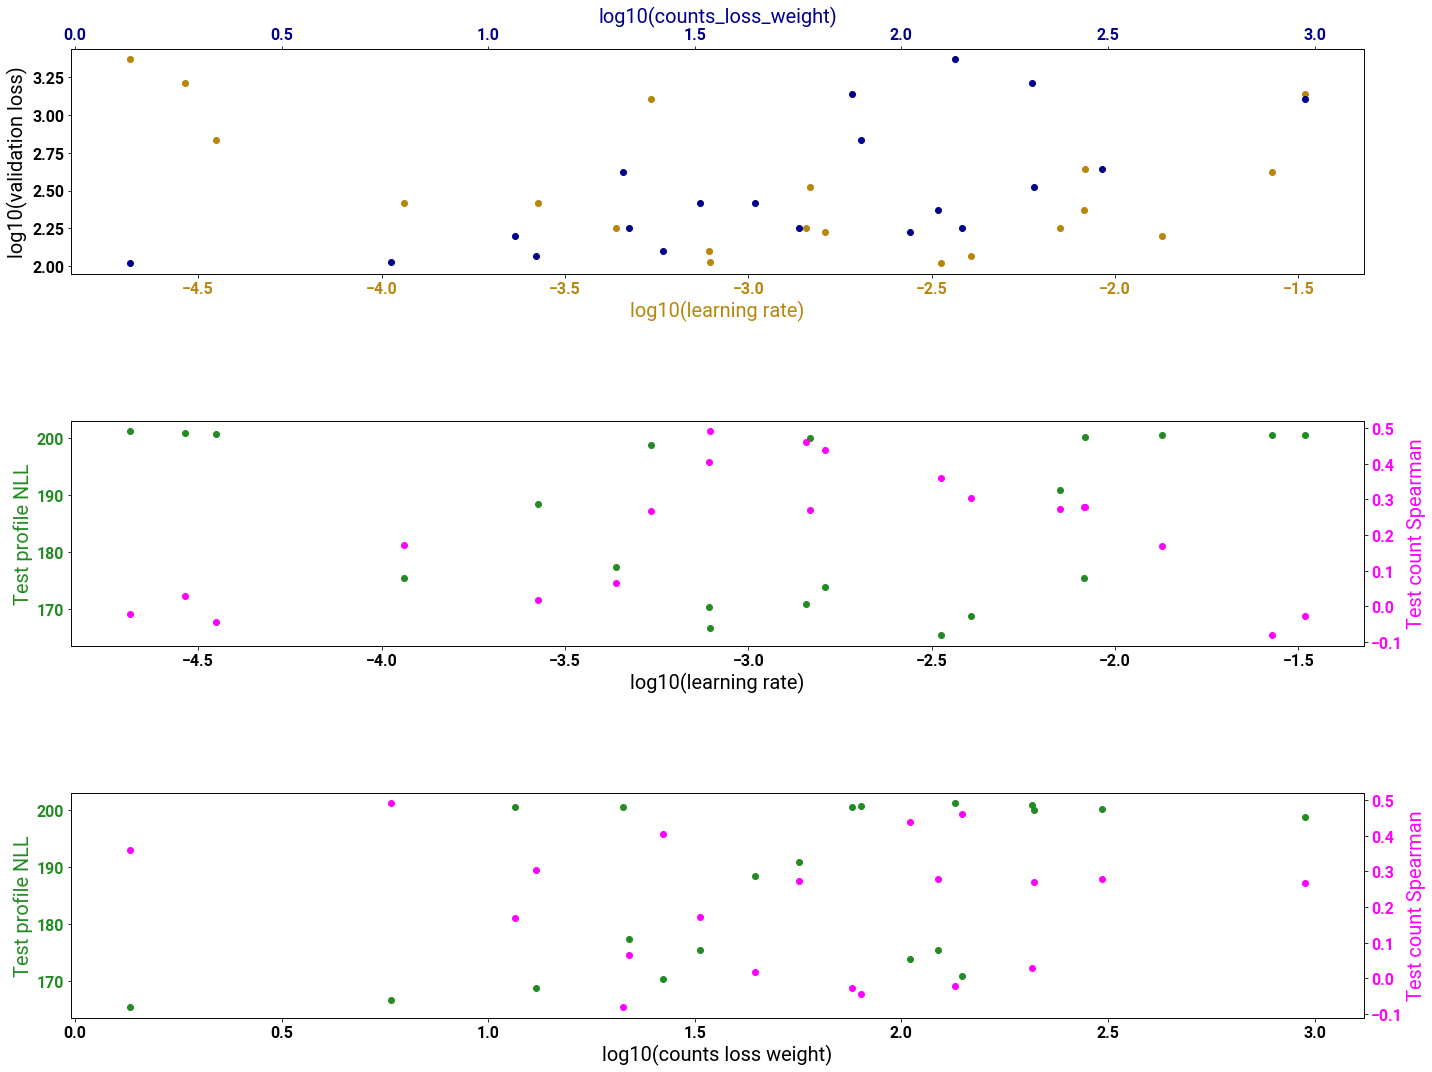

MAFK: task_2


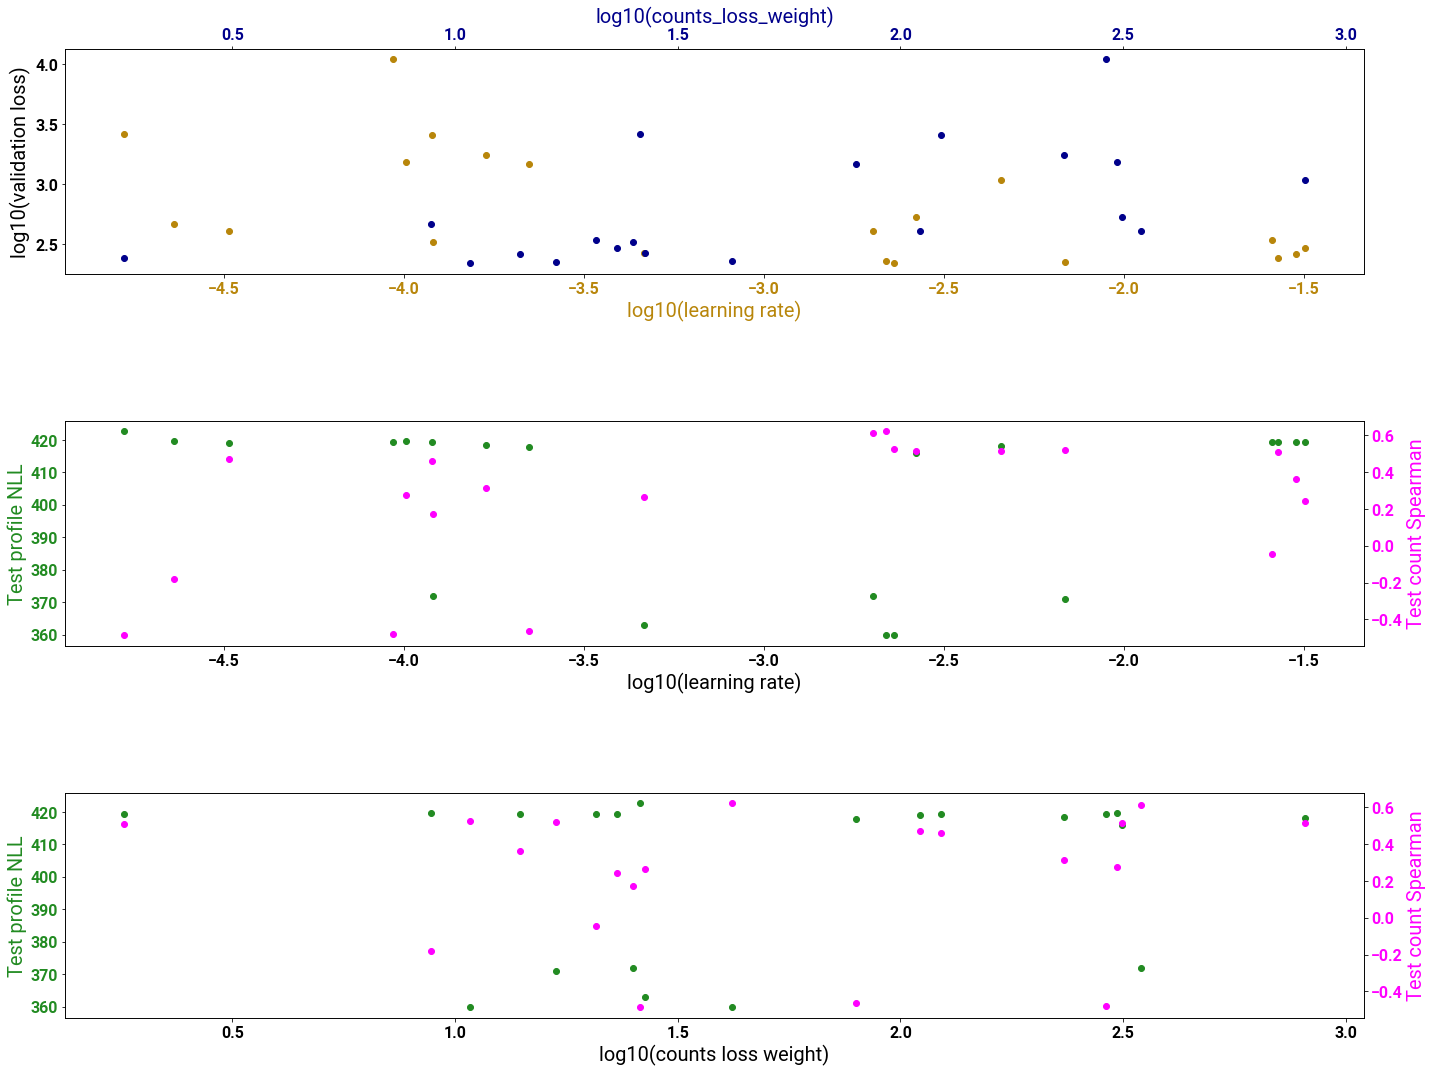

MAFK: task_3


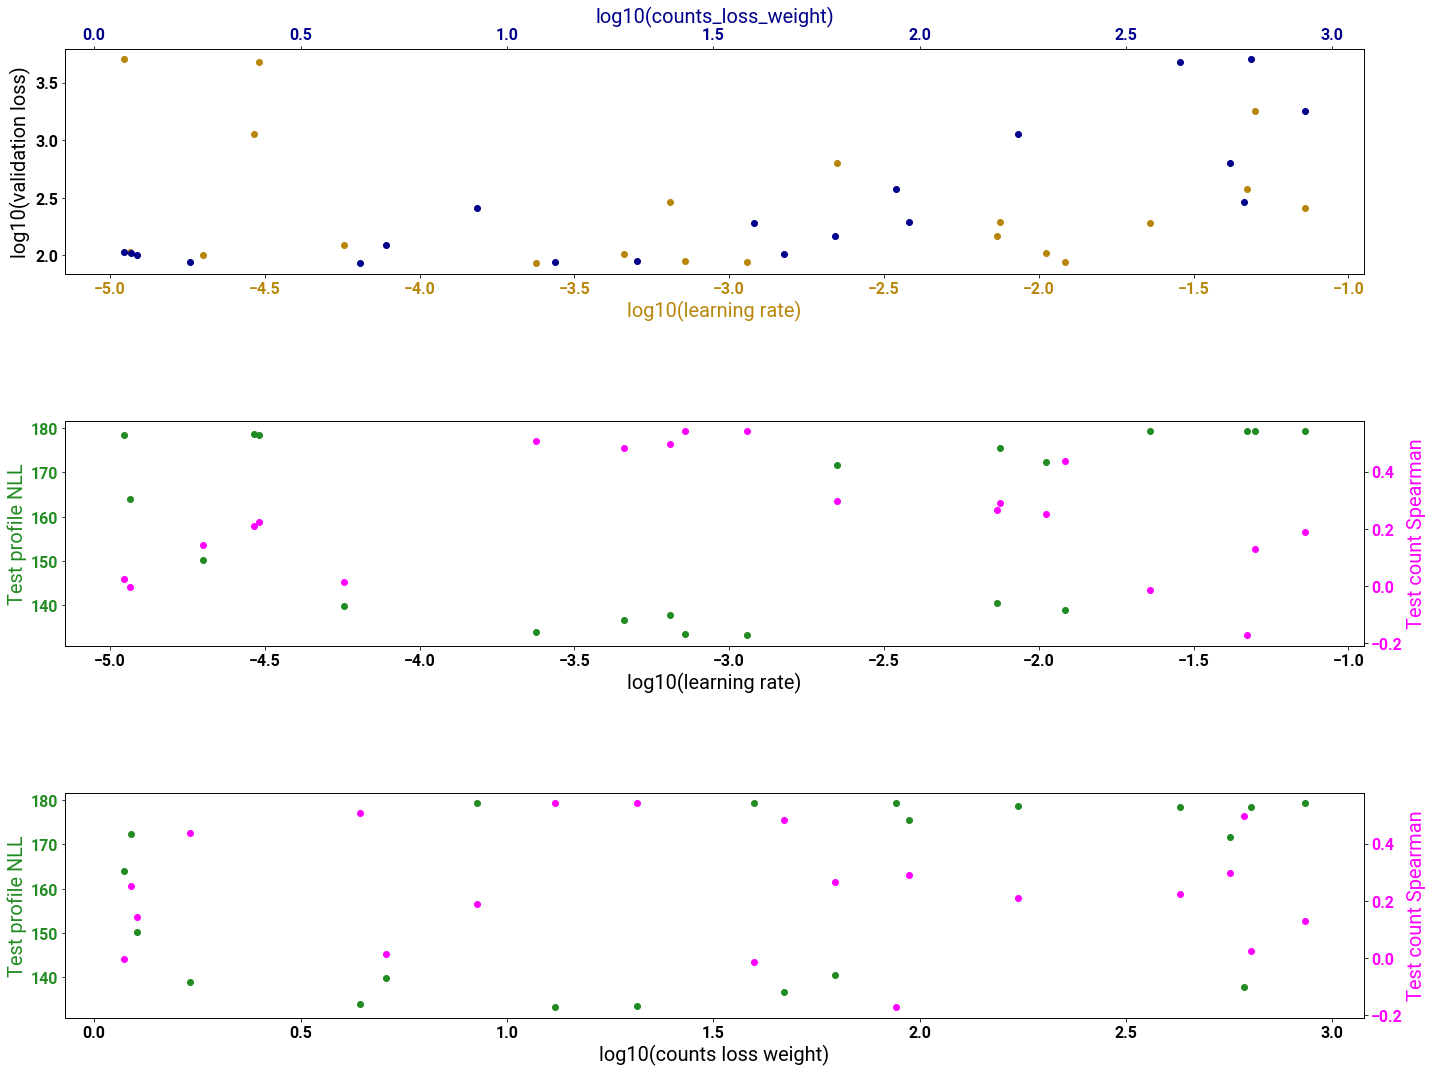

MAFK: task_4


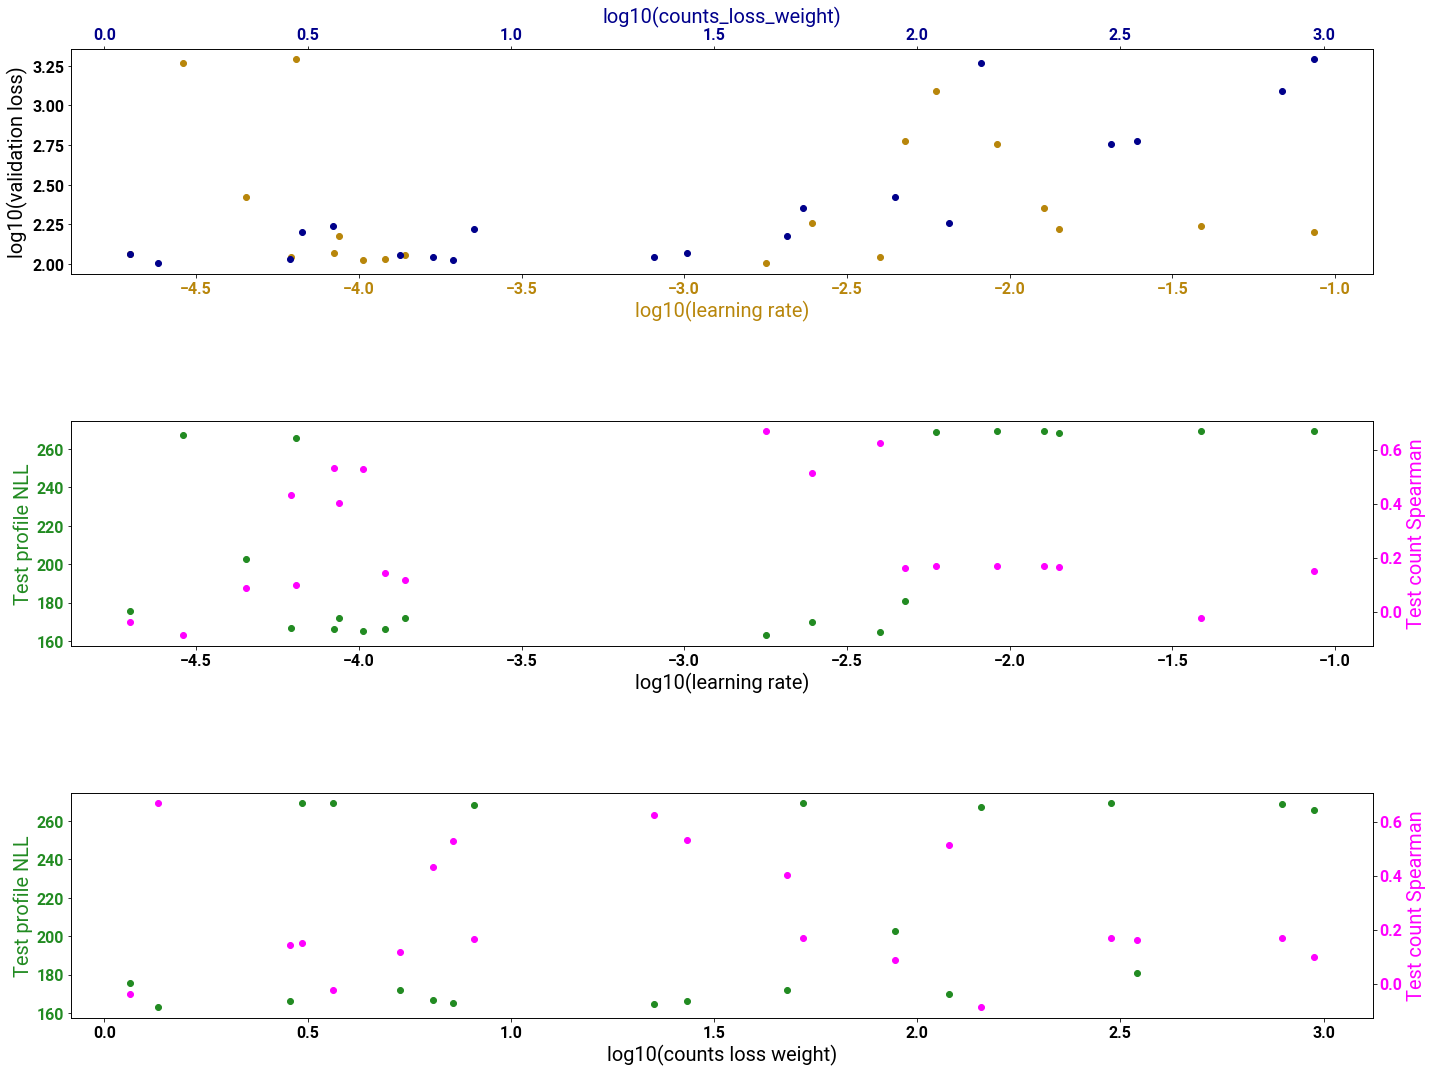

MAFK: task_5


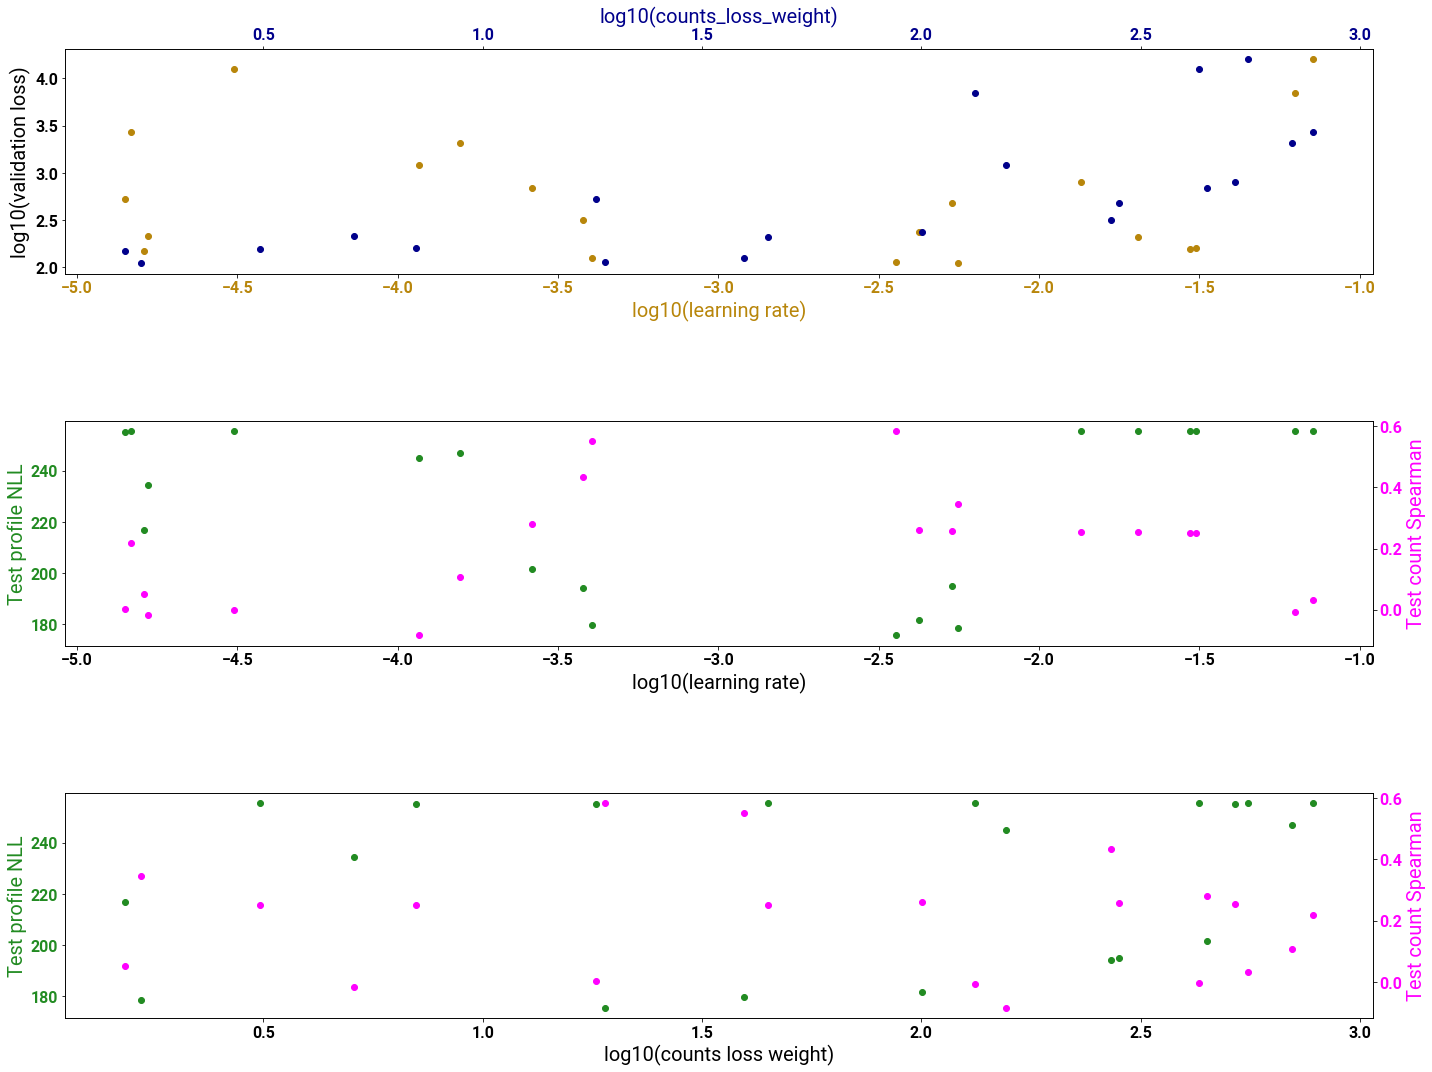

MAFK: task_6


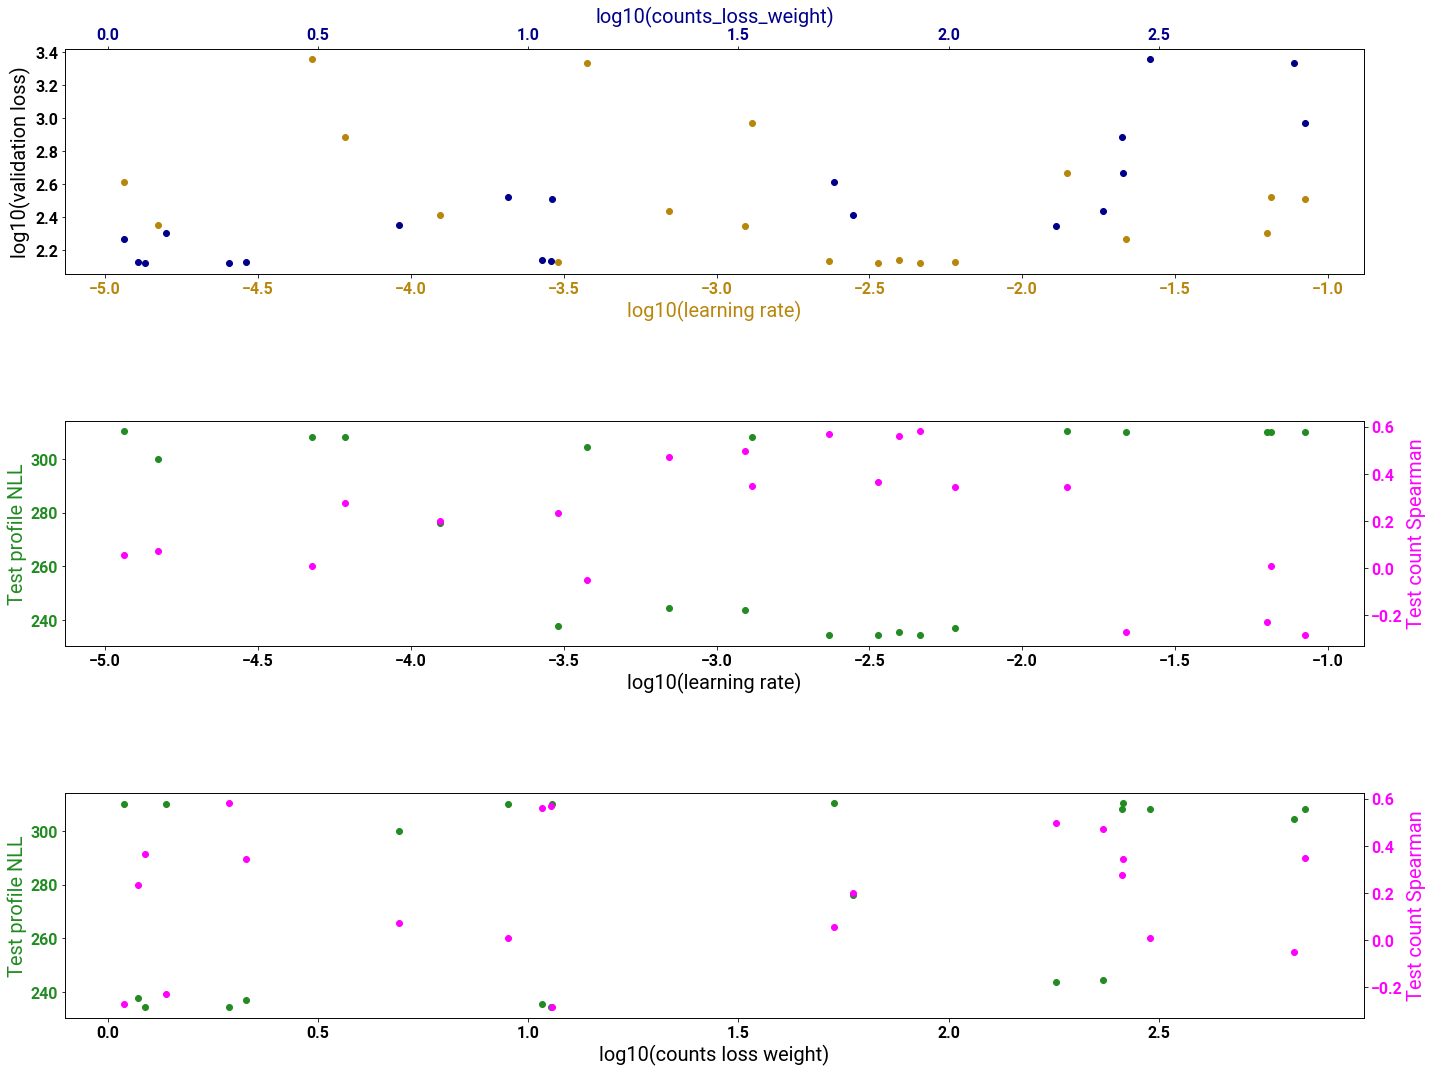

MAFK: task_7


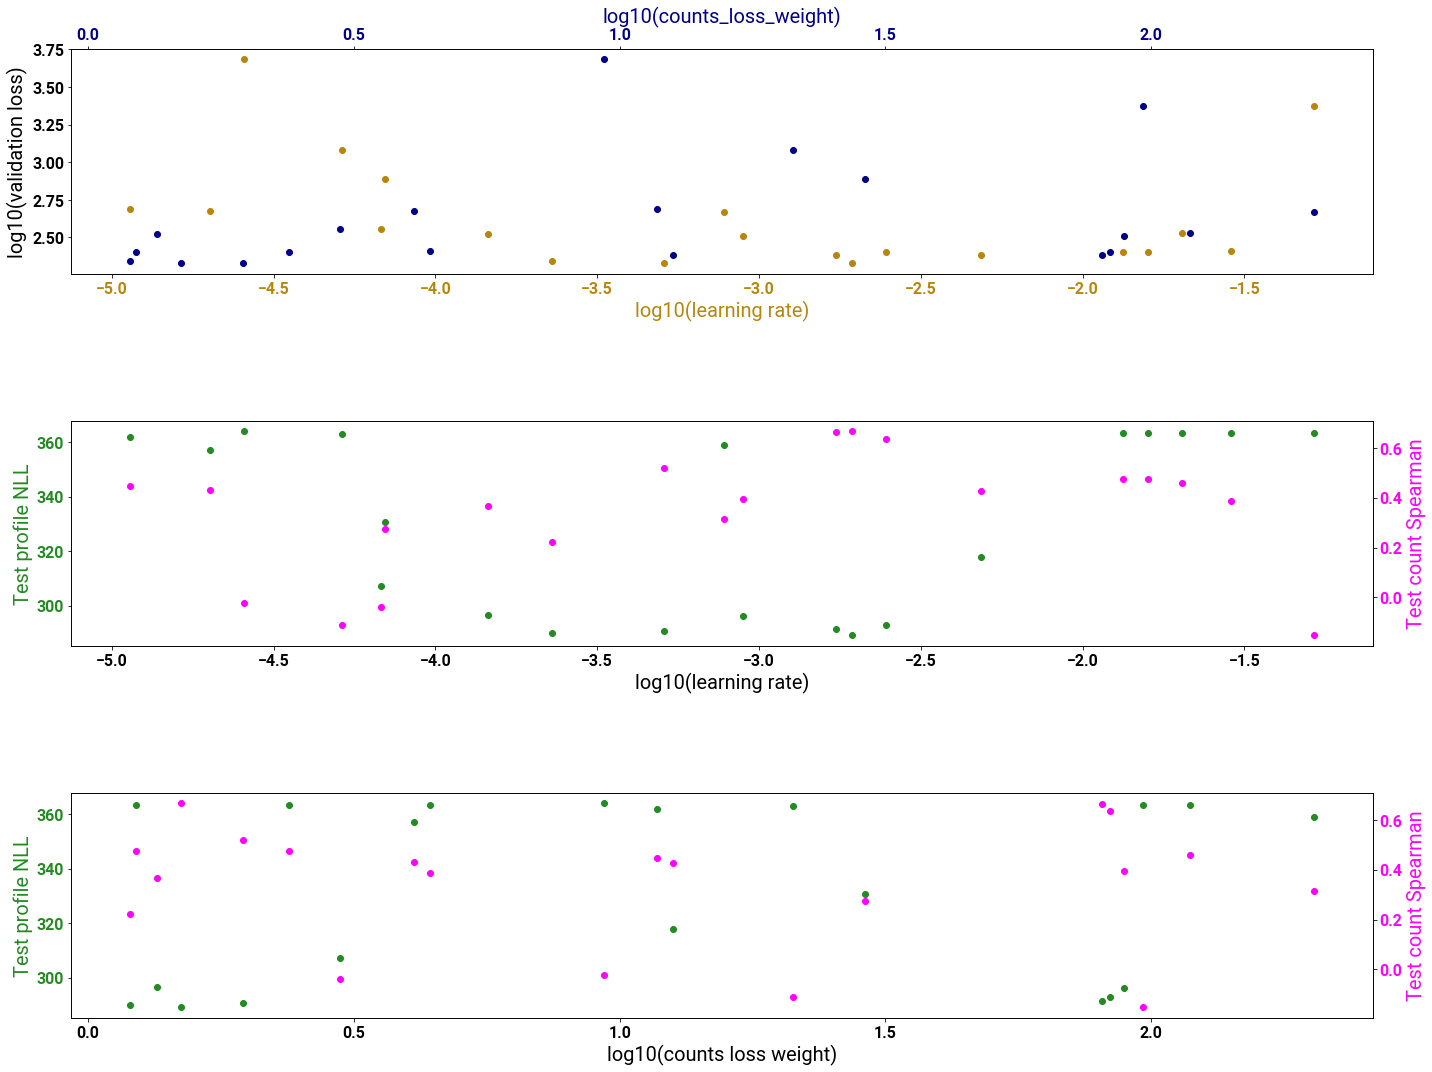

MAFK: task_8


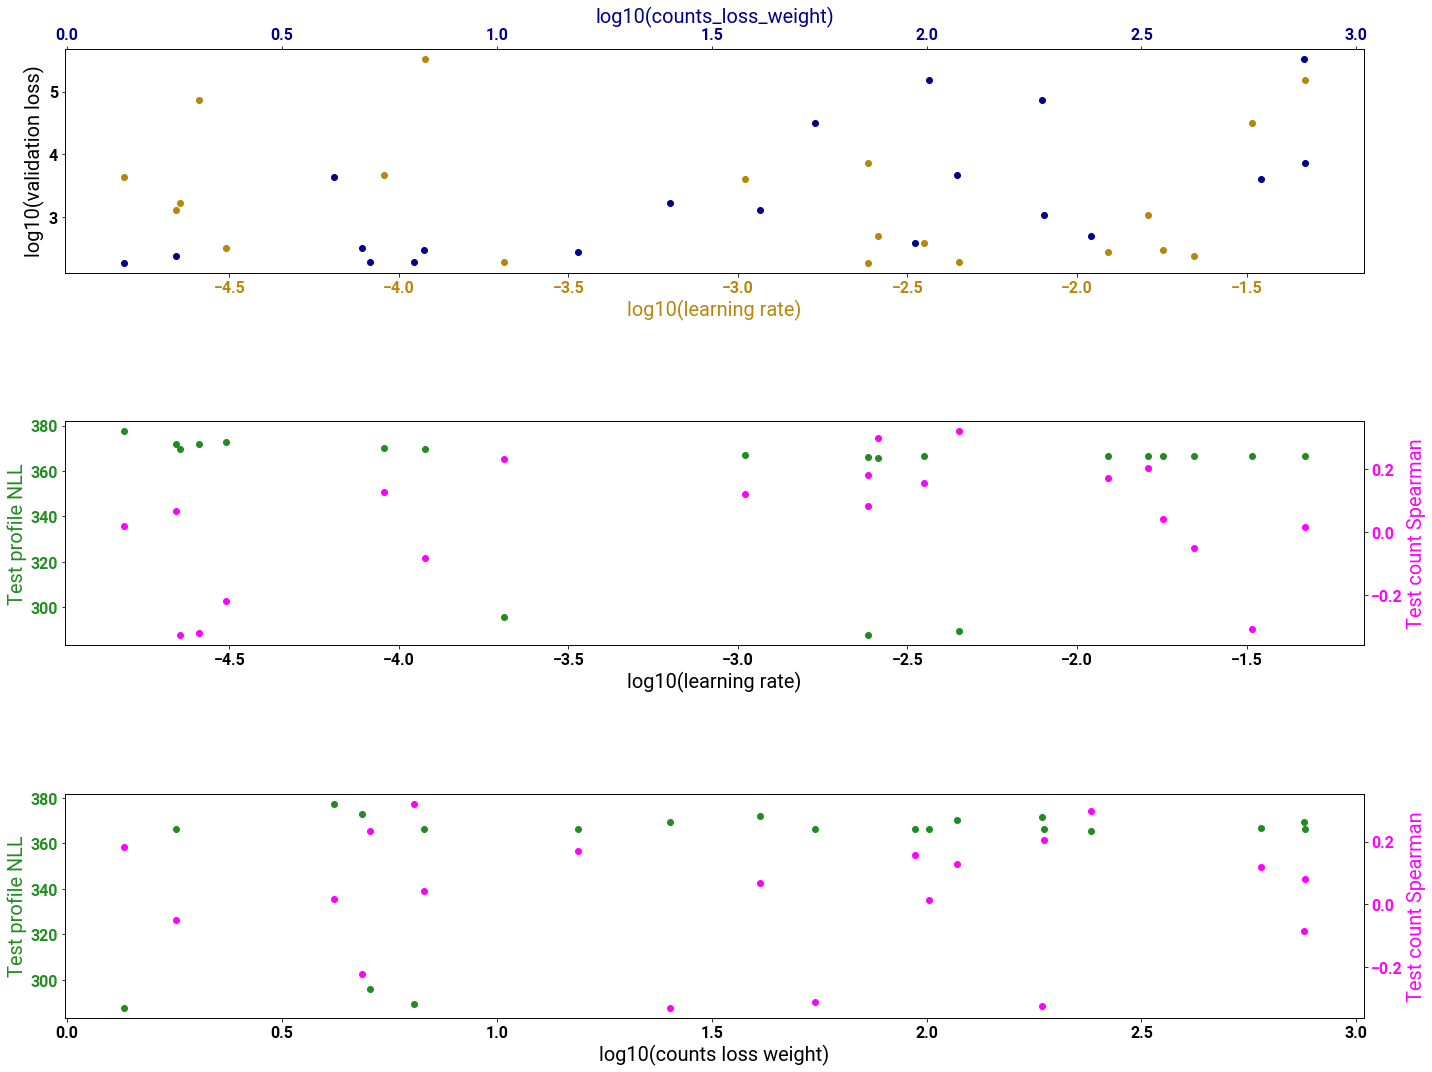

JUND: task_0


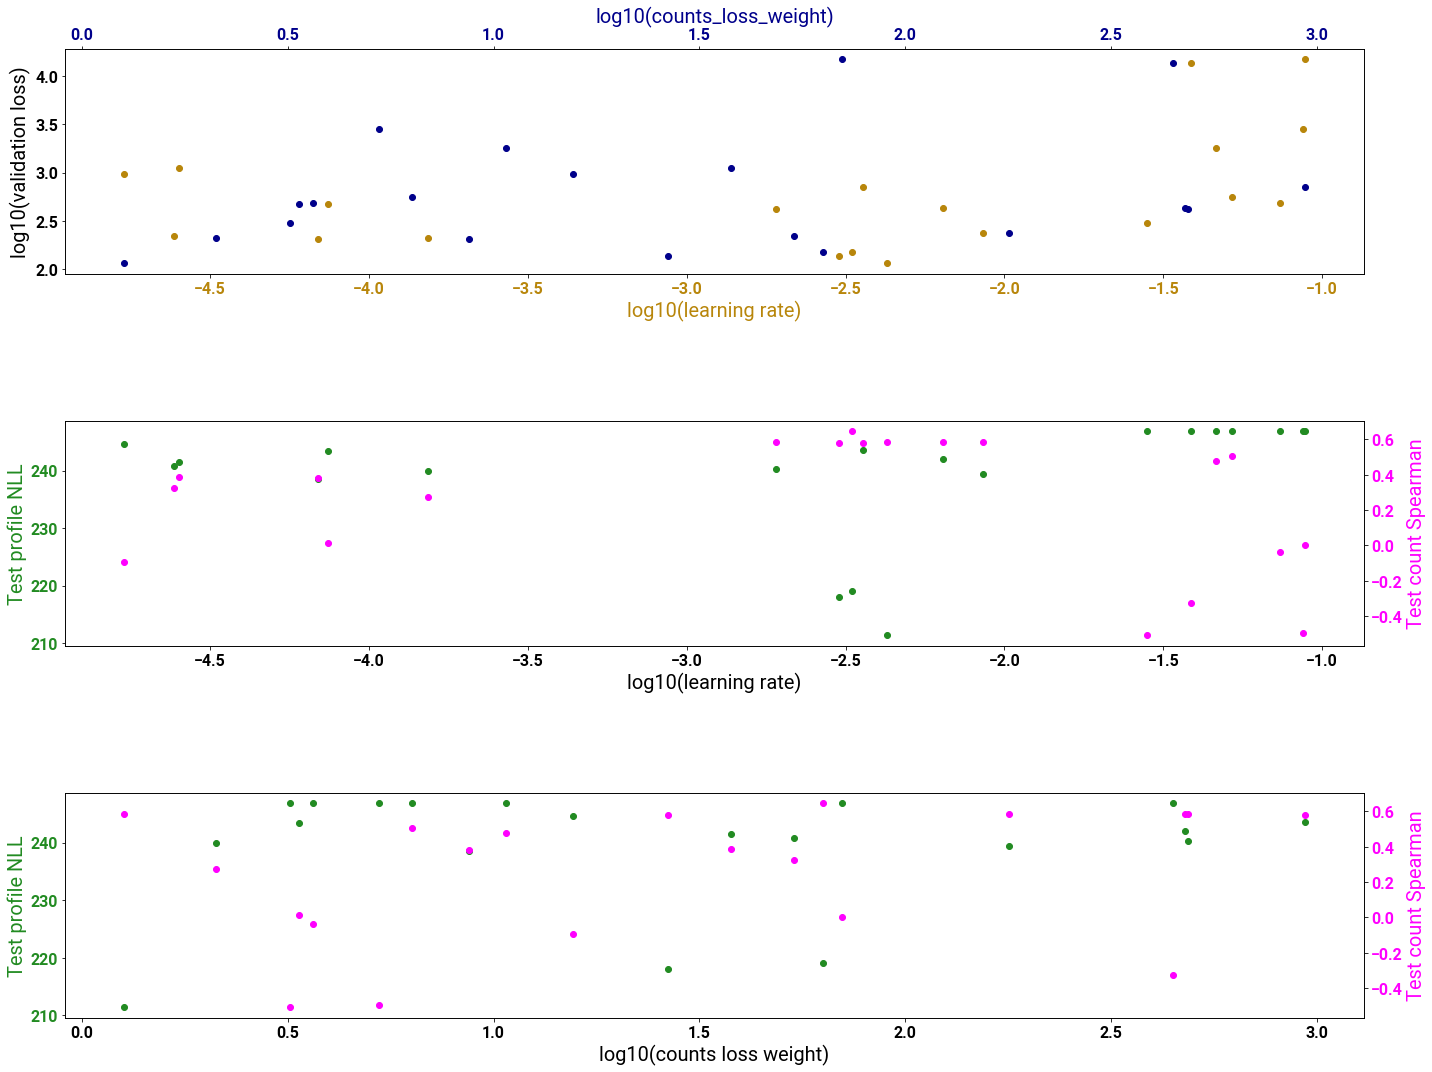

JUND: task_1


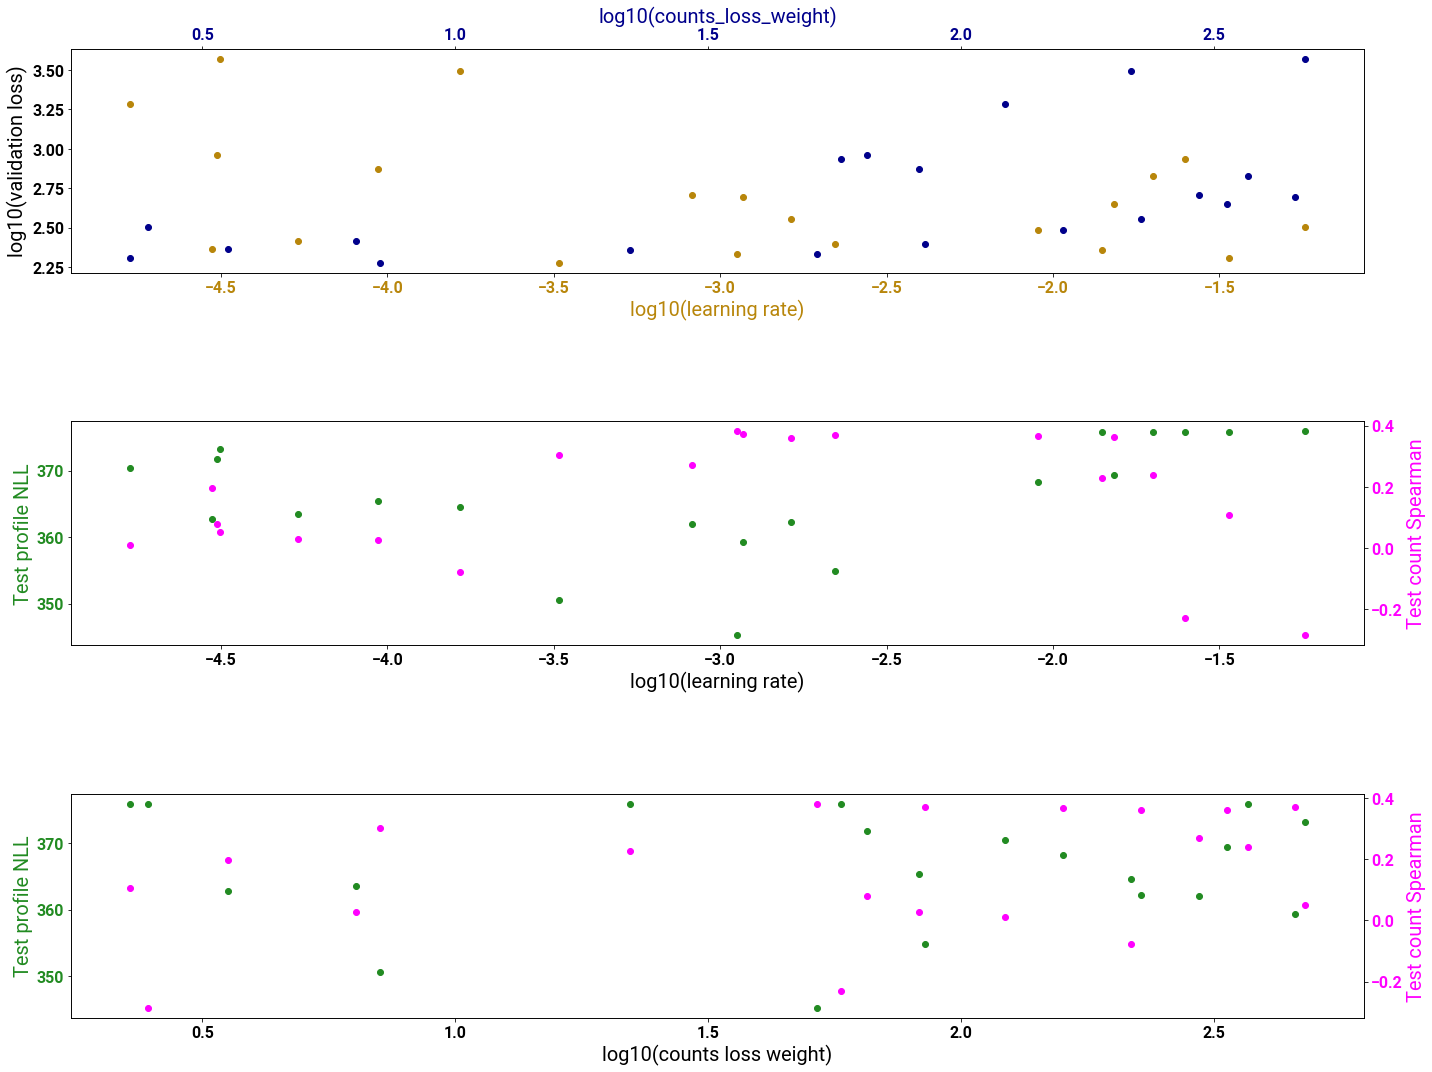

JUND: task_2


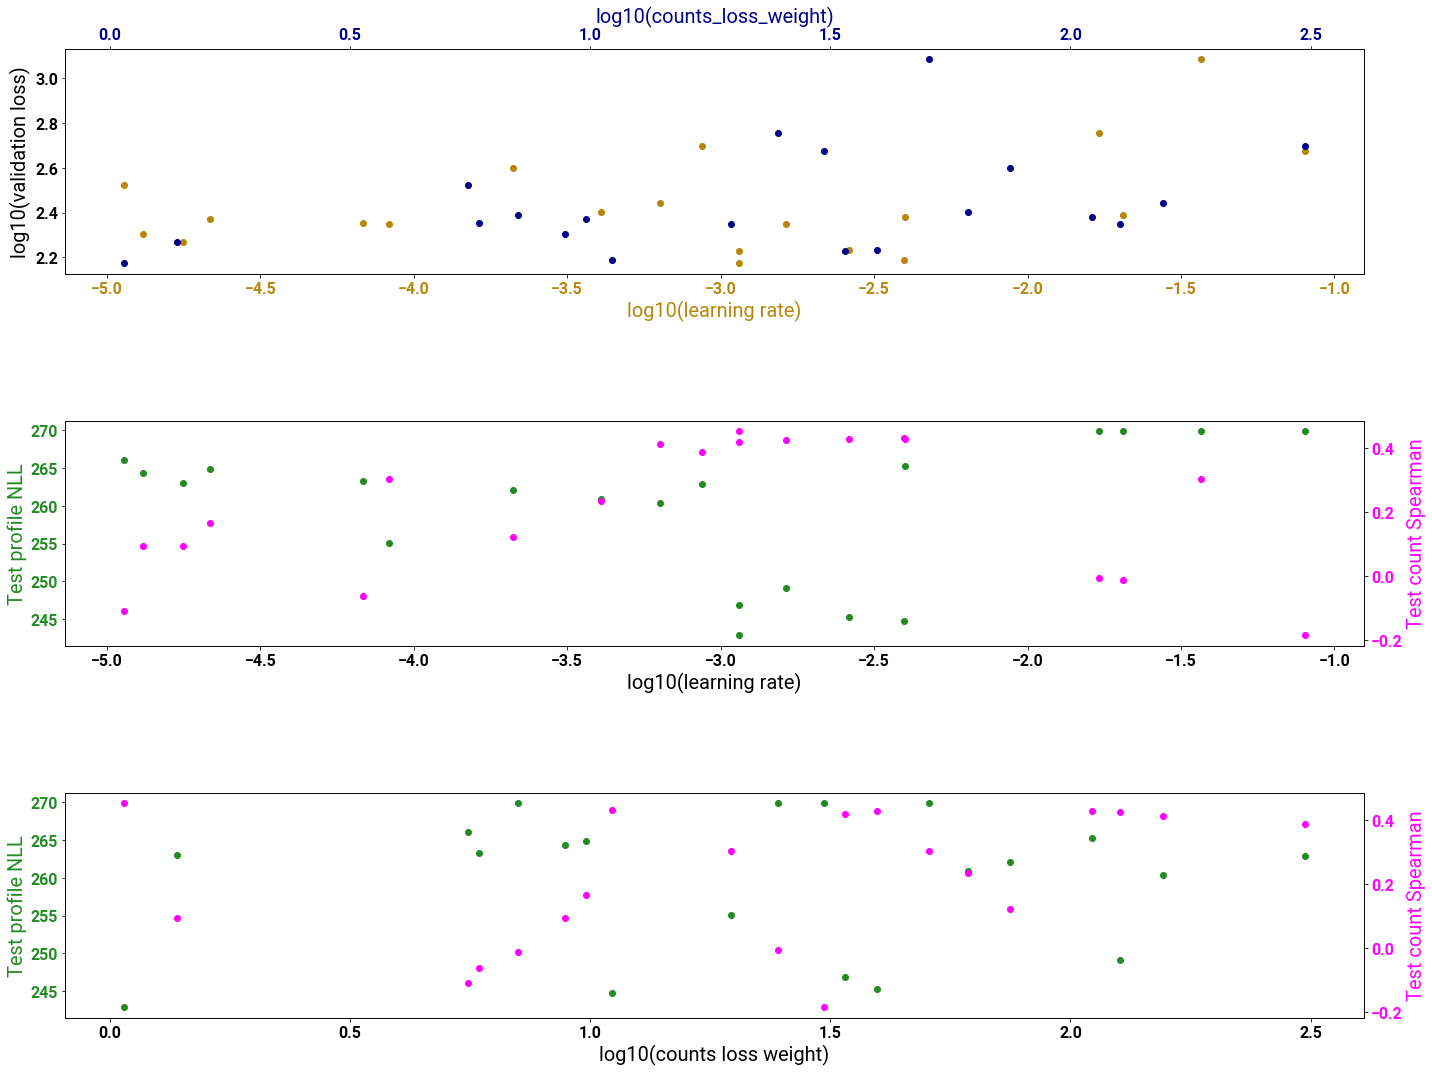

JUND: task_3


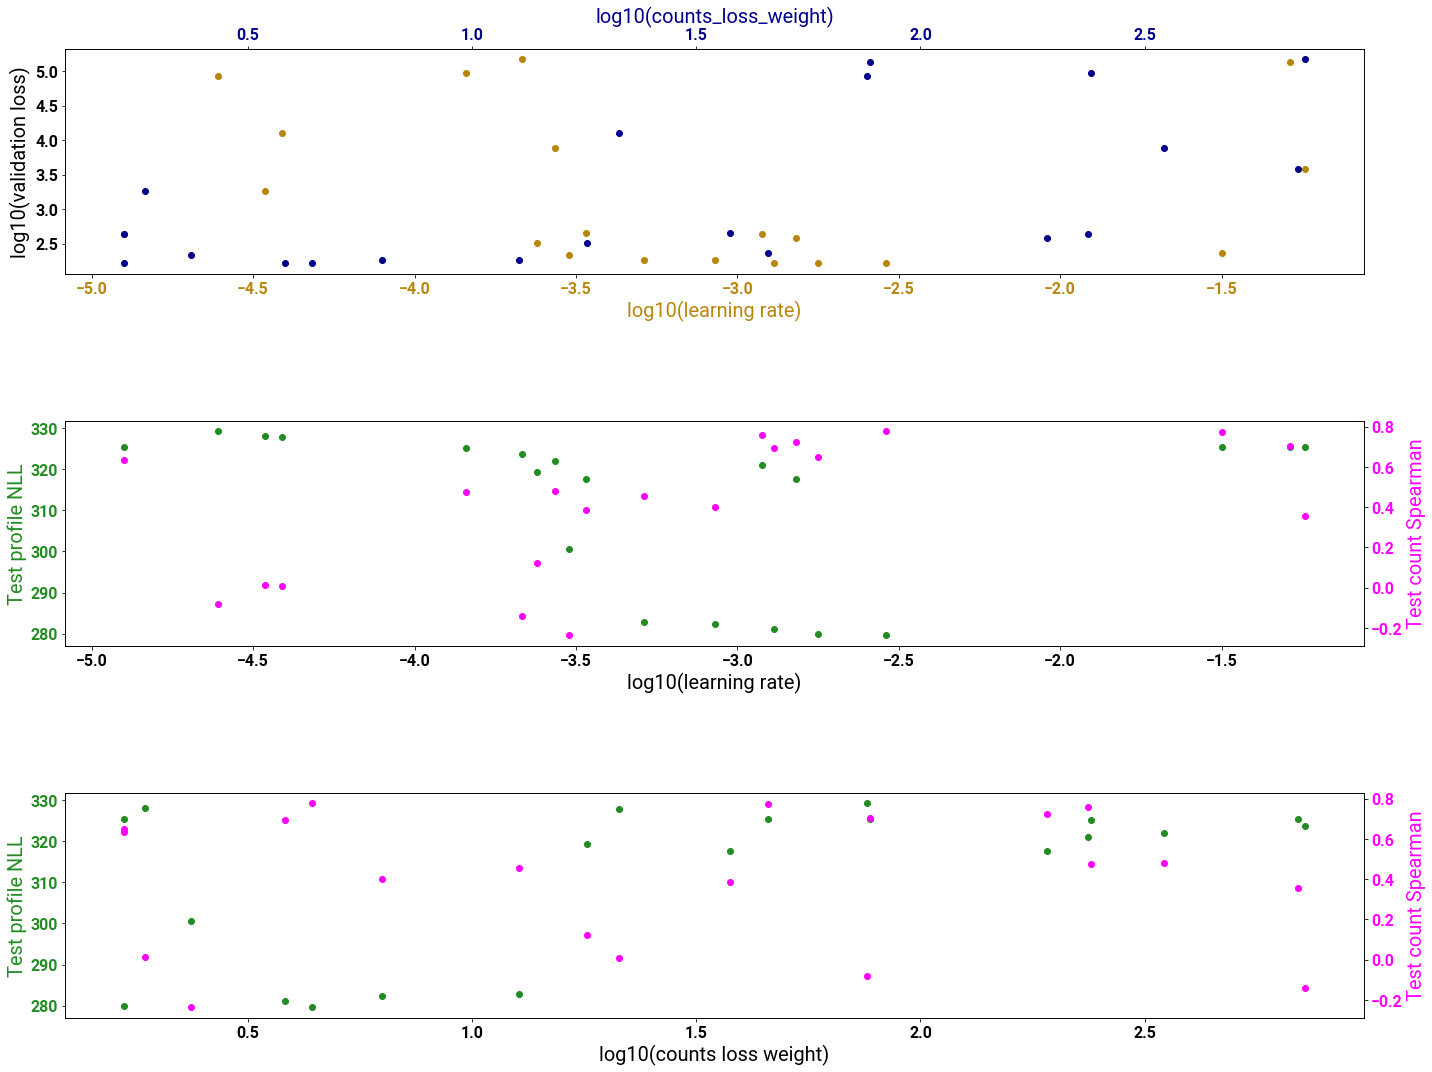

JUND: task_4


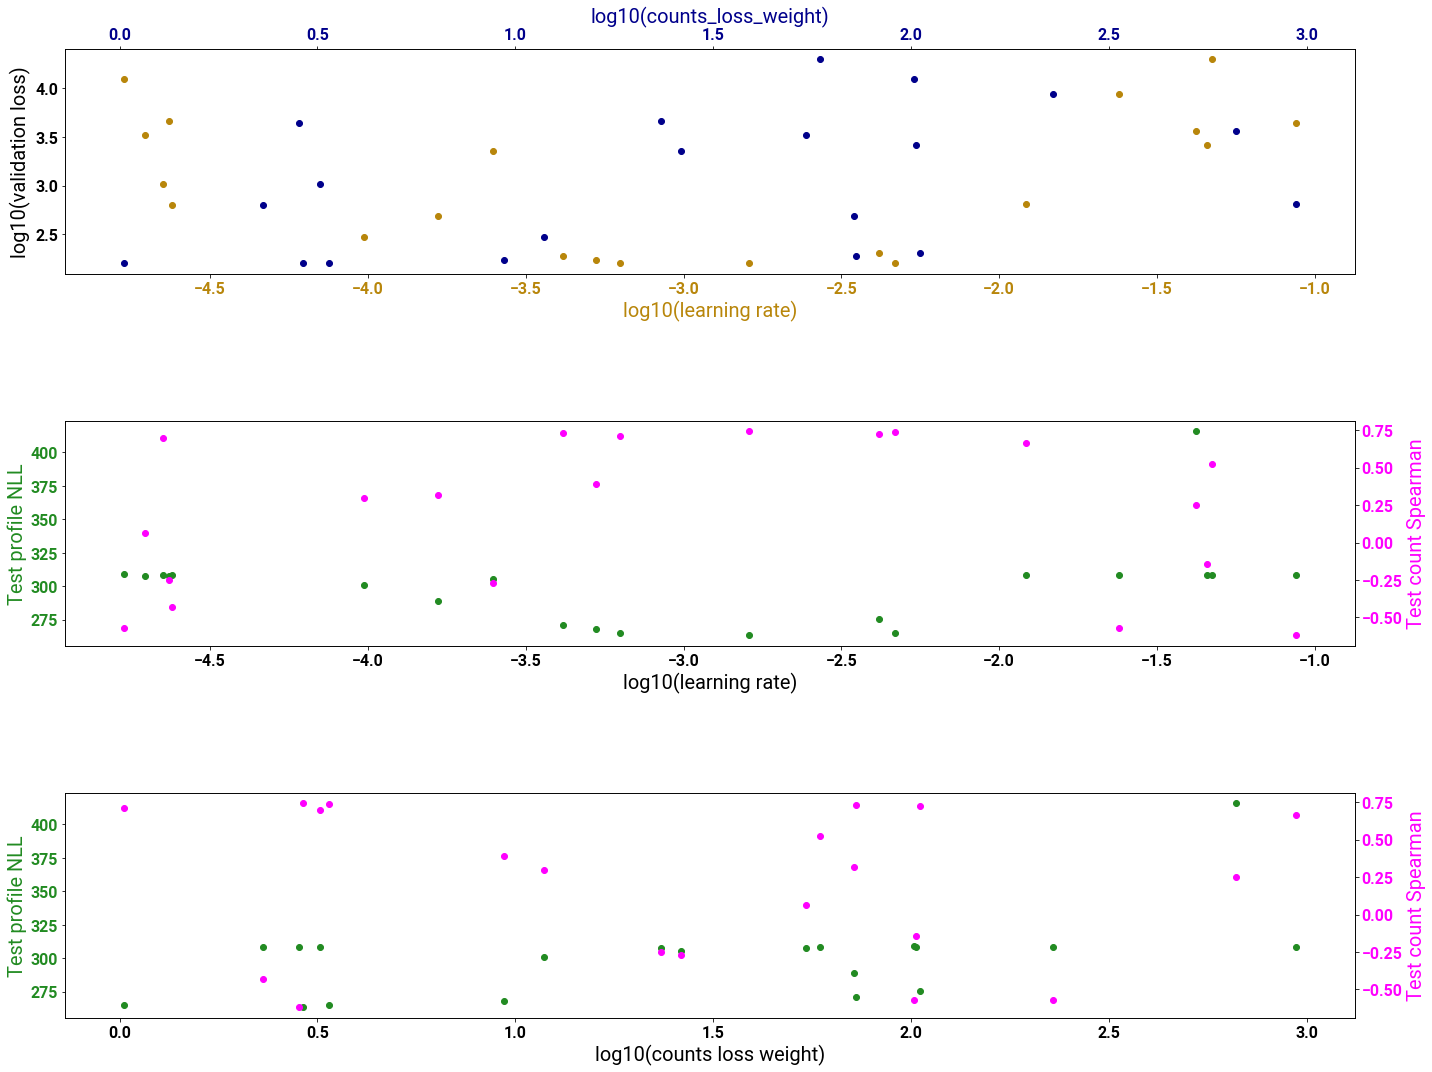

JUND: task_5


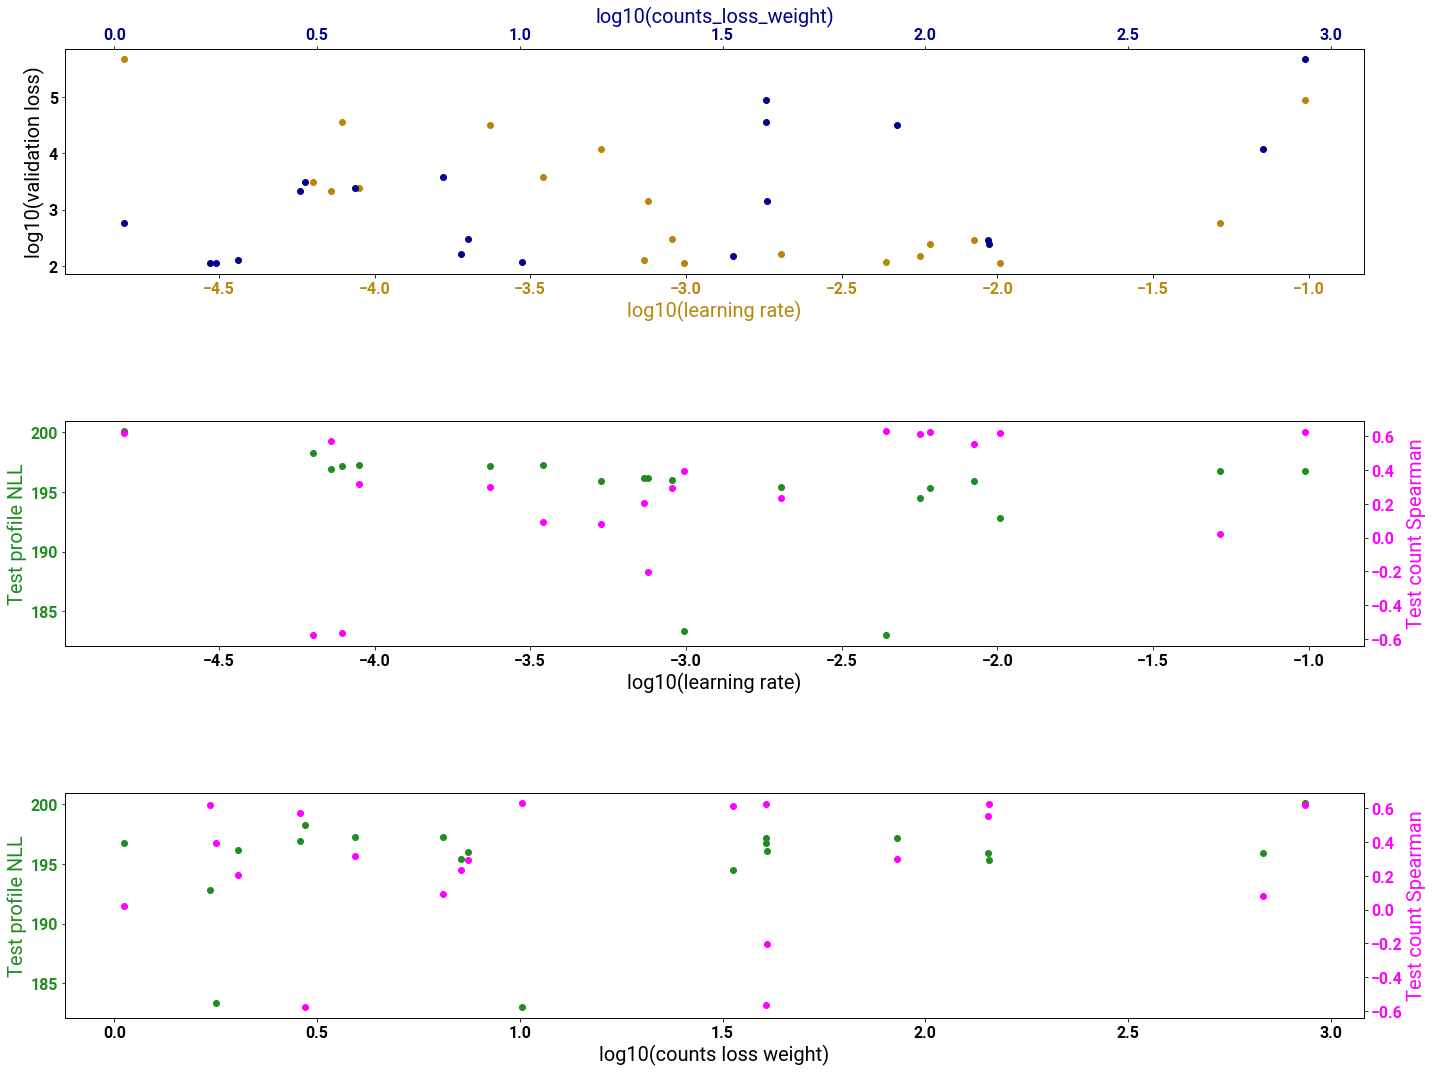

JUND: task_6


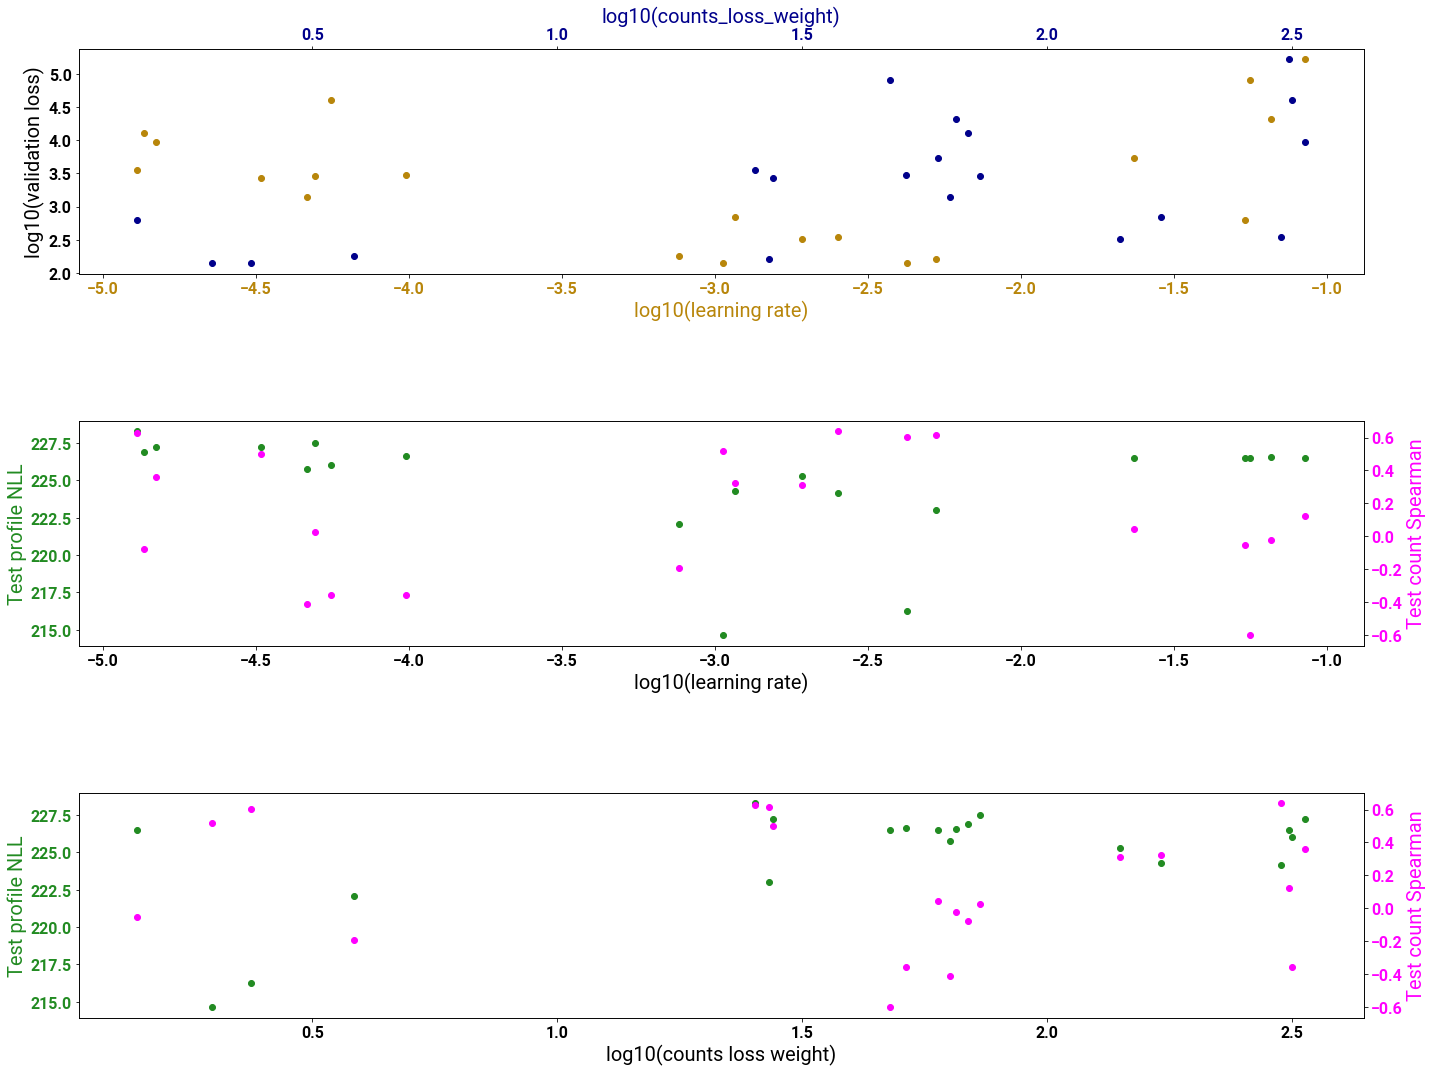

JUND: task_7


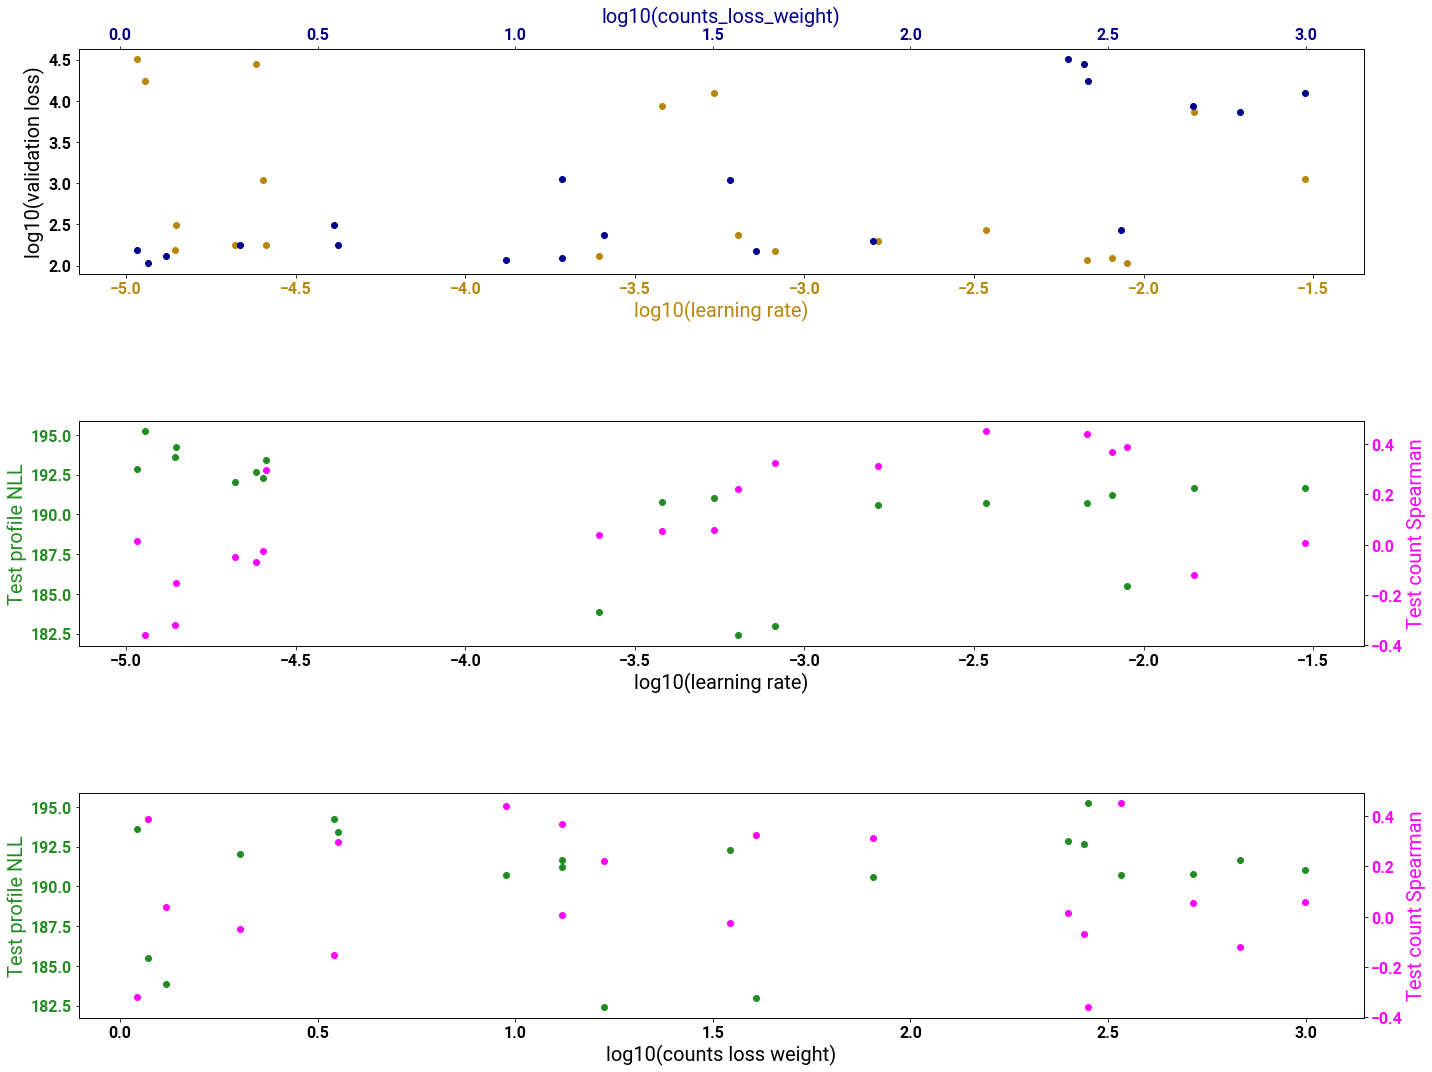

JUND: task_8


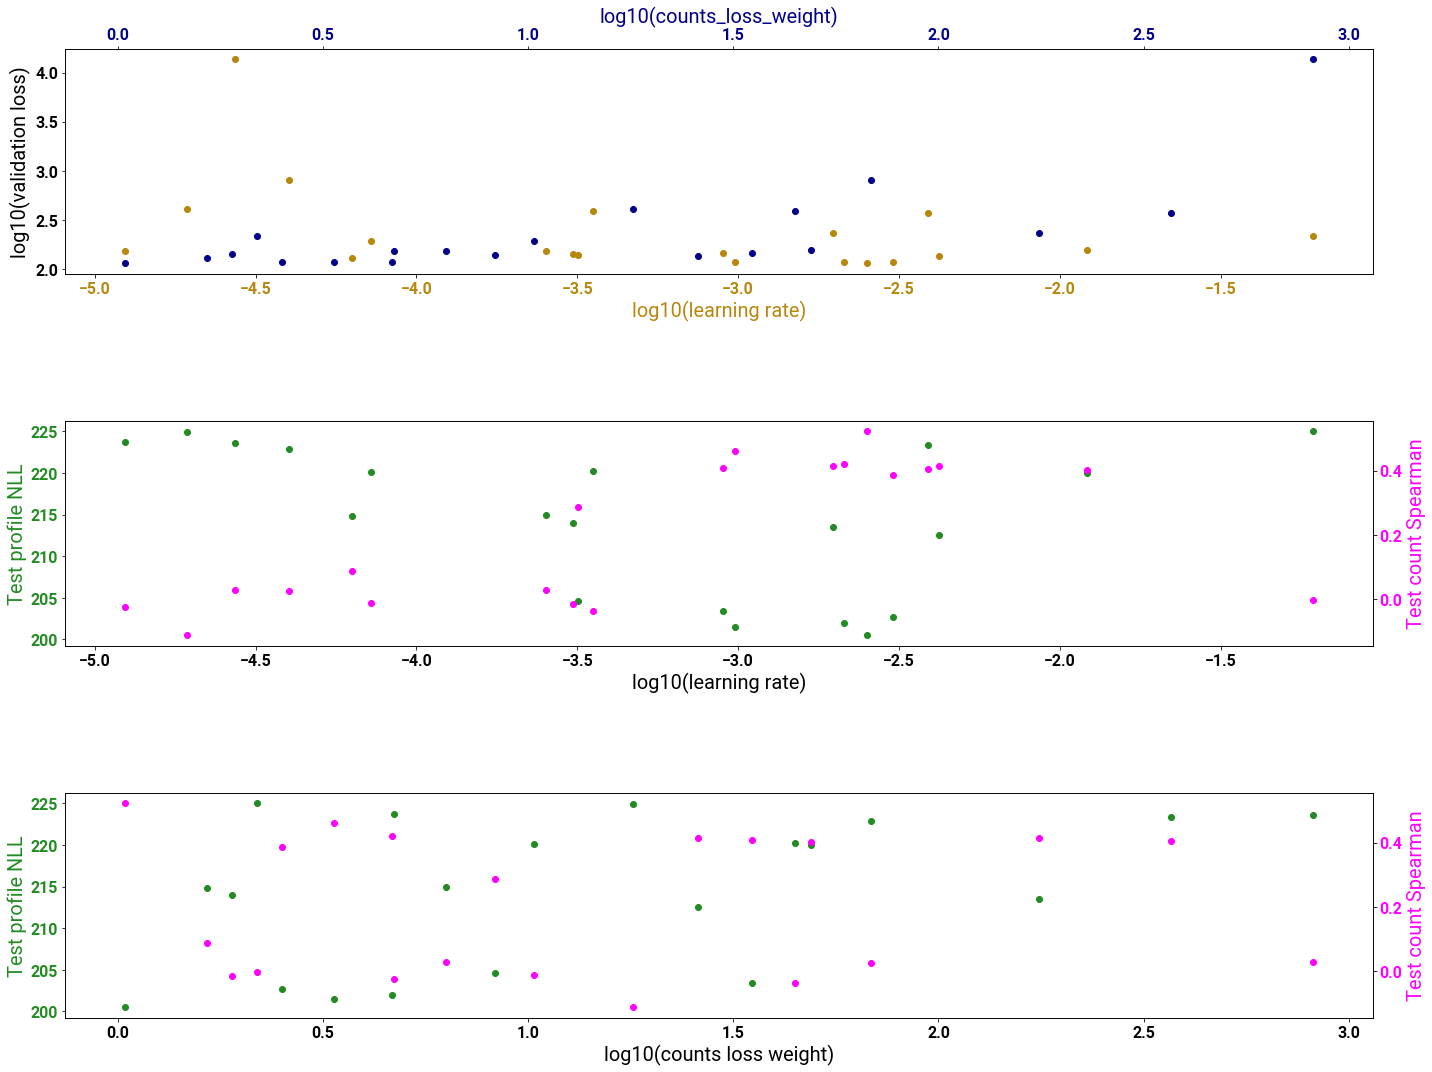

JUND: task_9


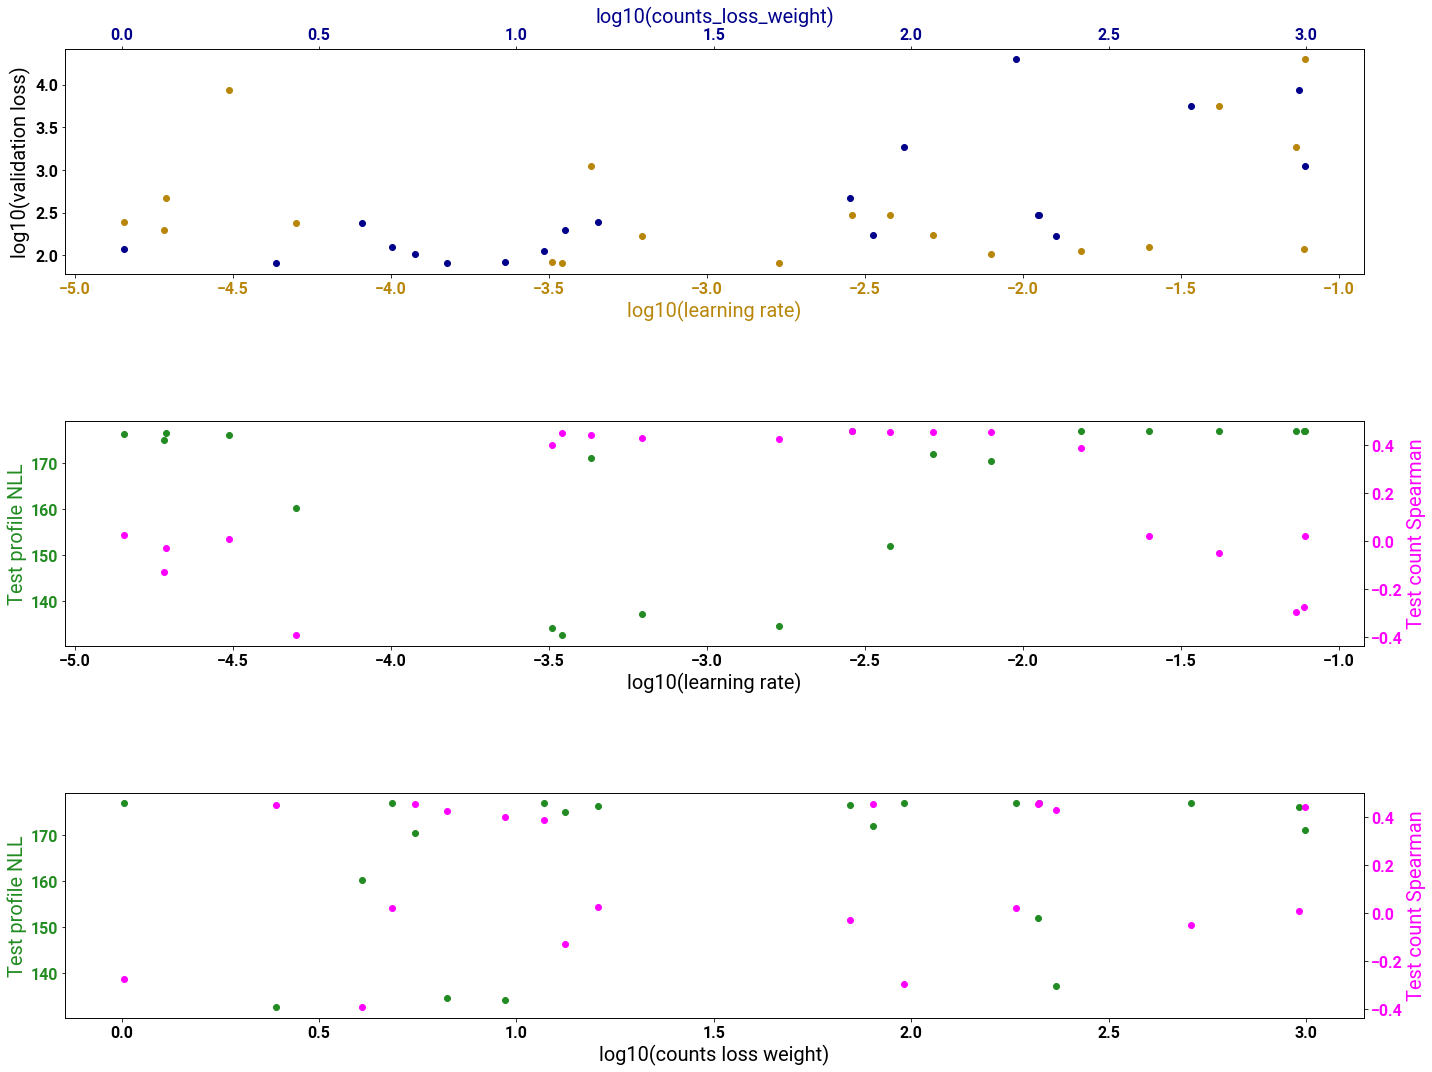

JUND: task_10


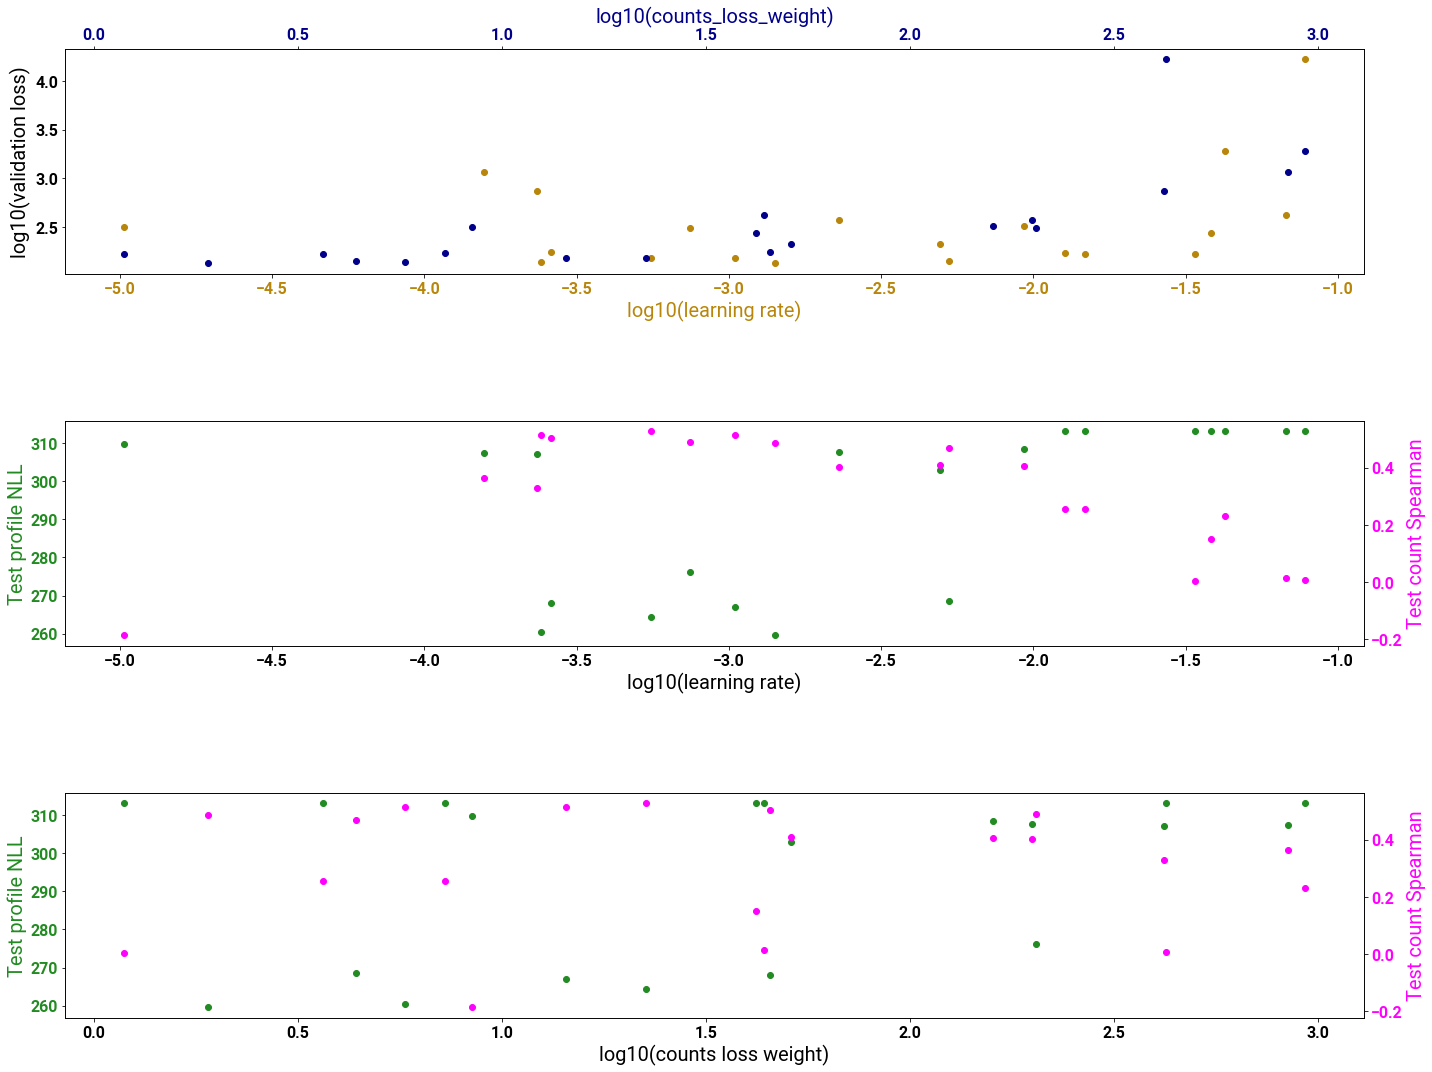

JUND: task_11


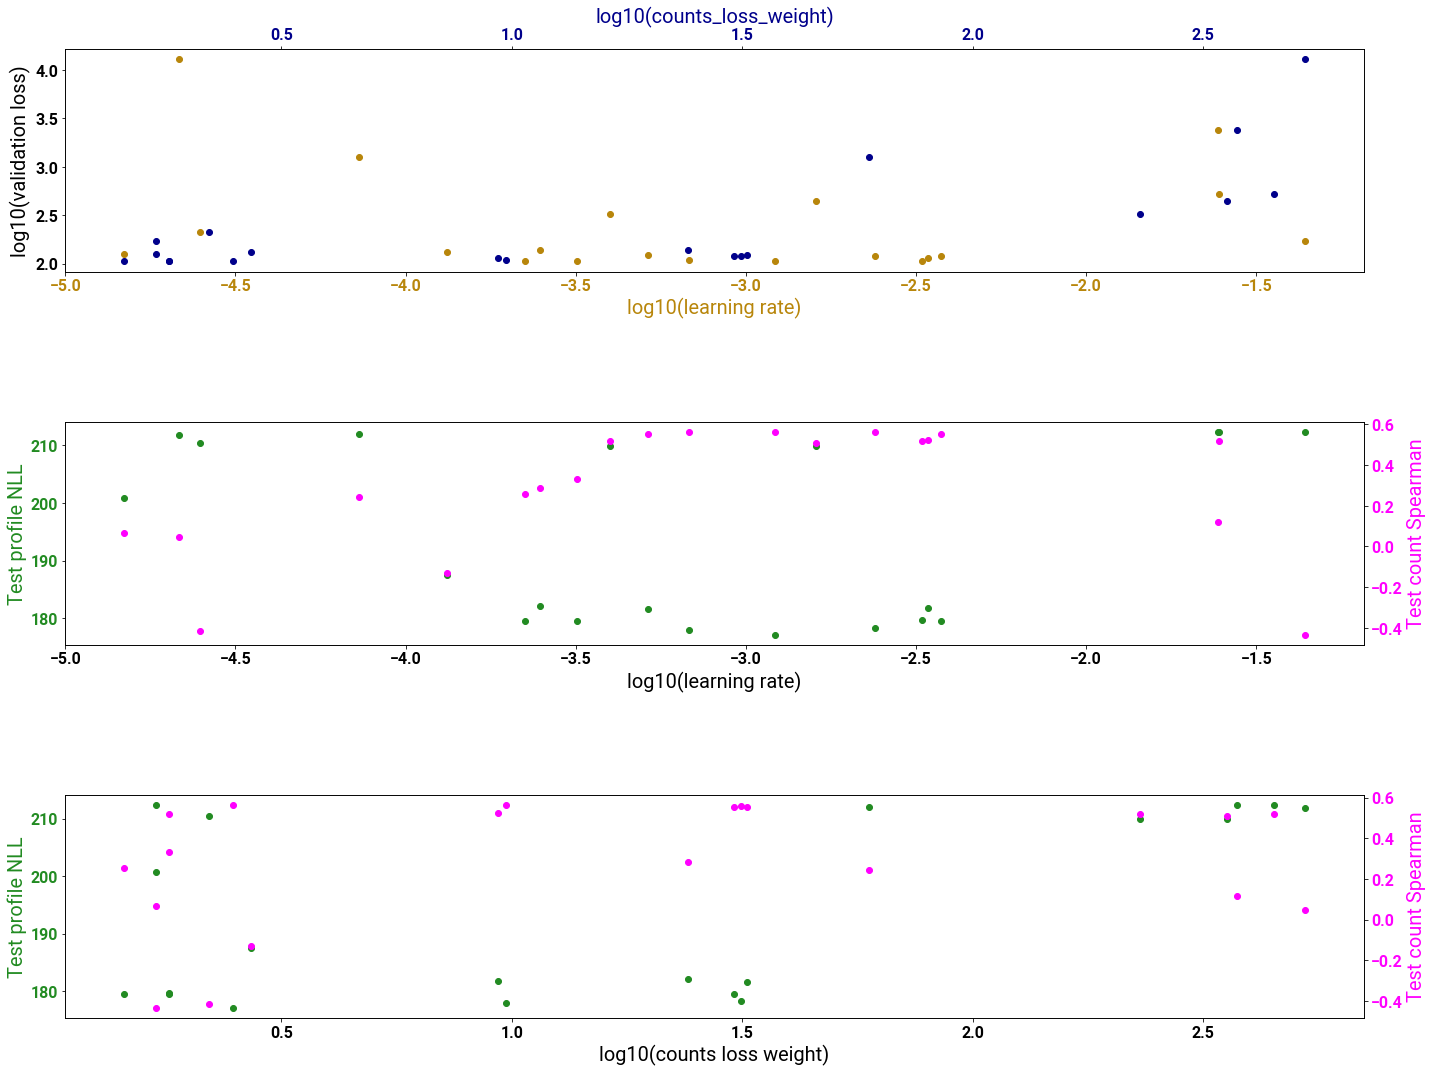

JUND: task_12


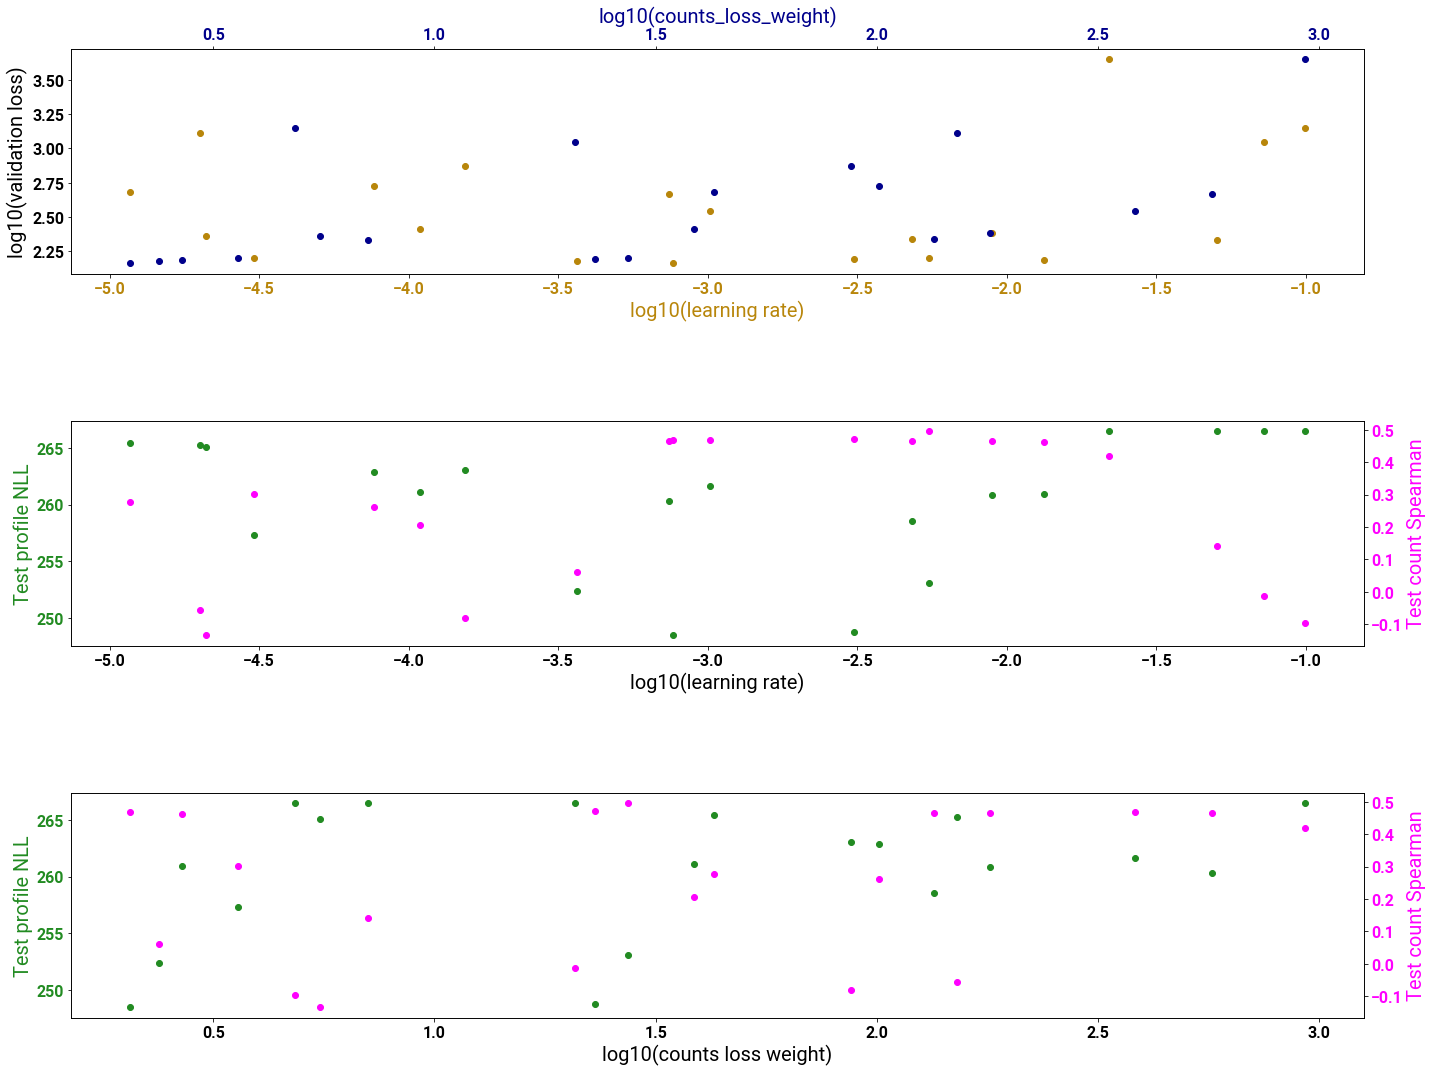

JUND: task_13


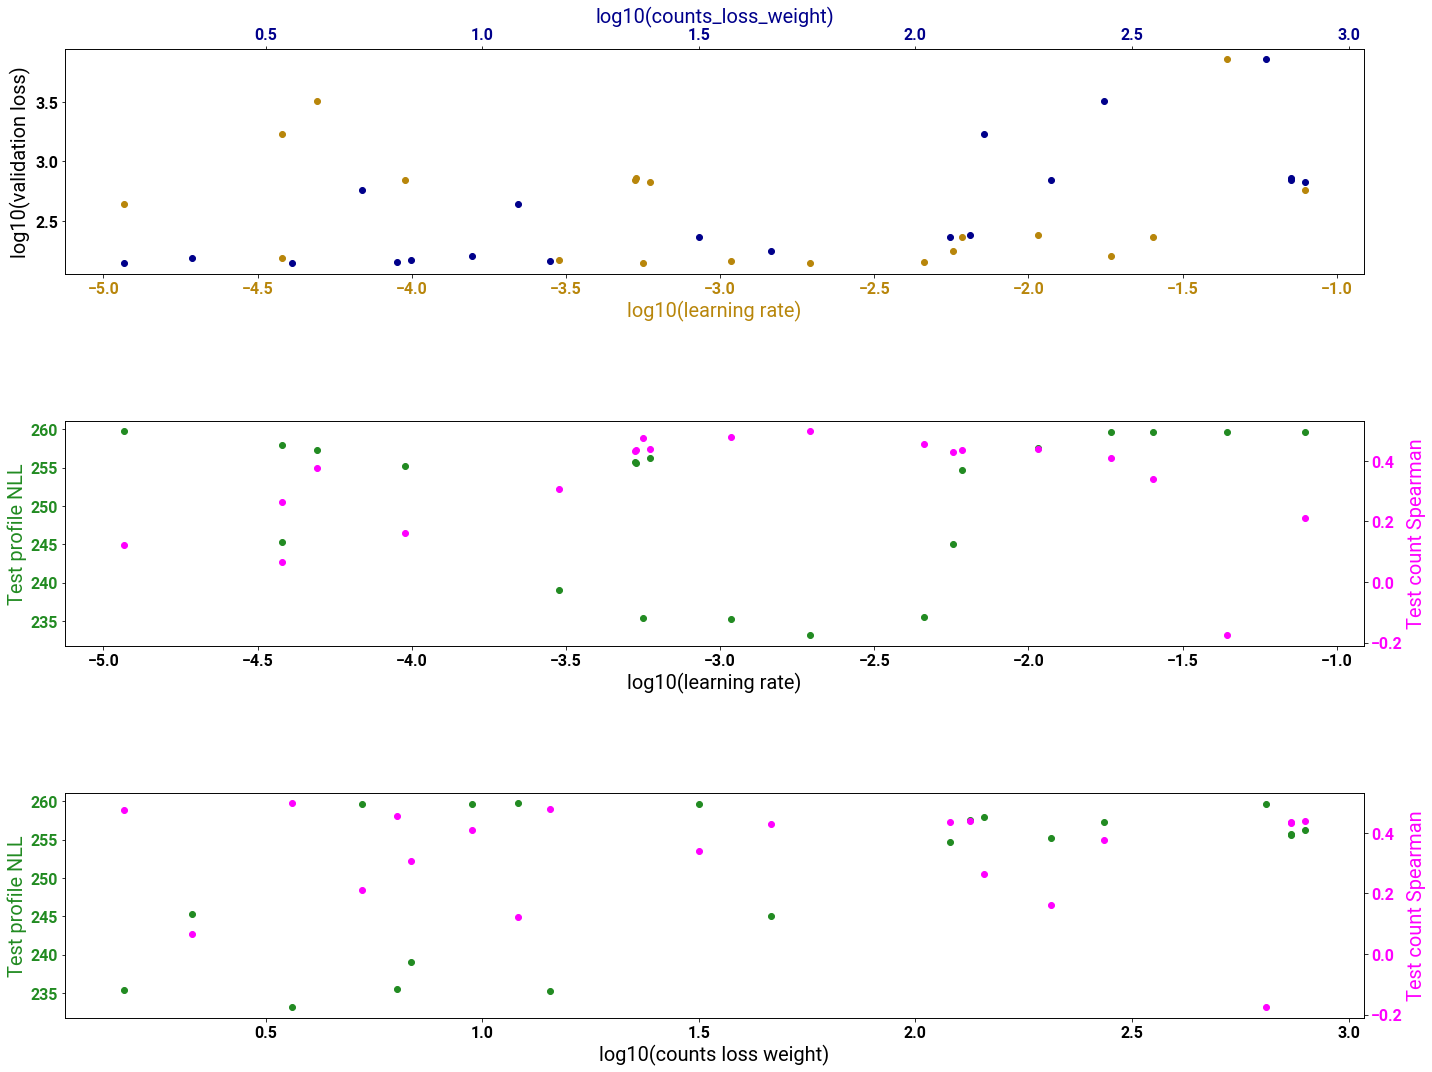

NR3C1-reddytime: task_0


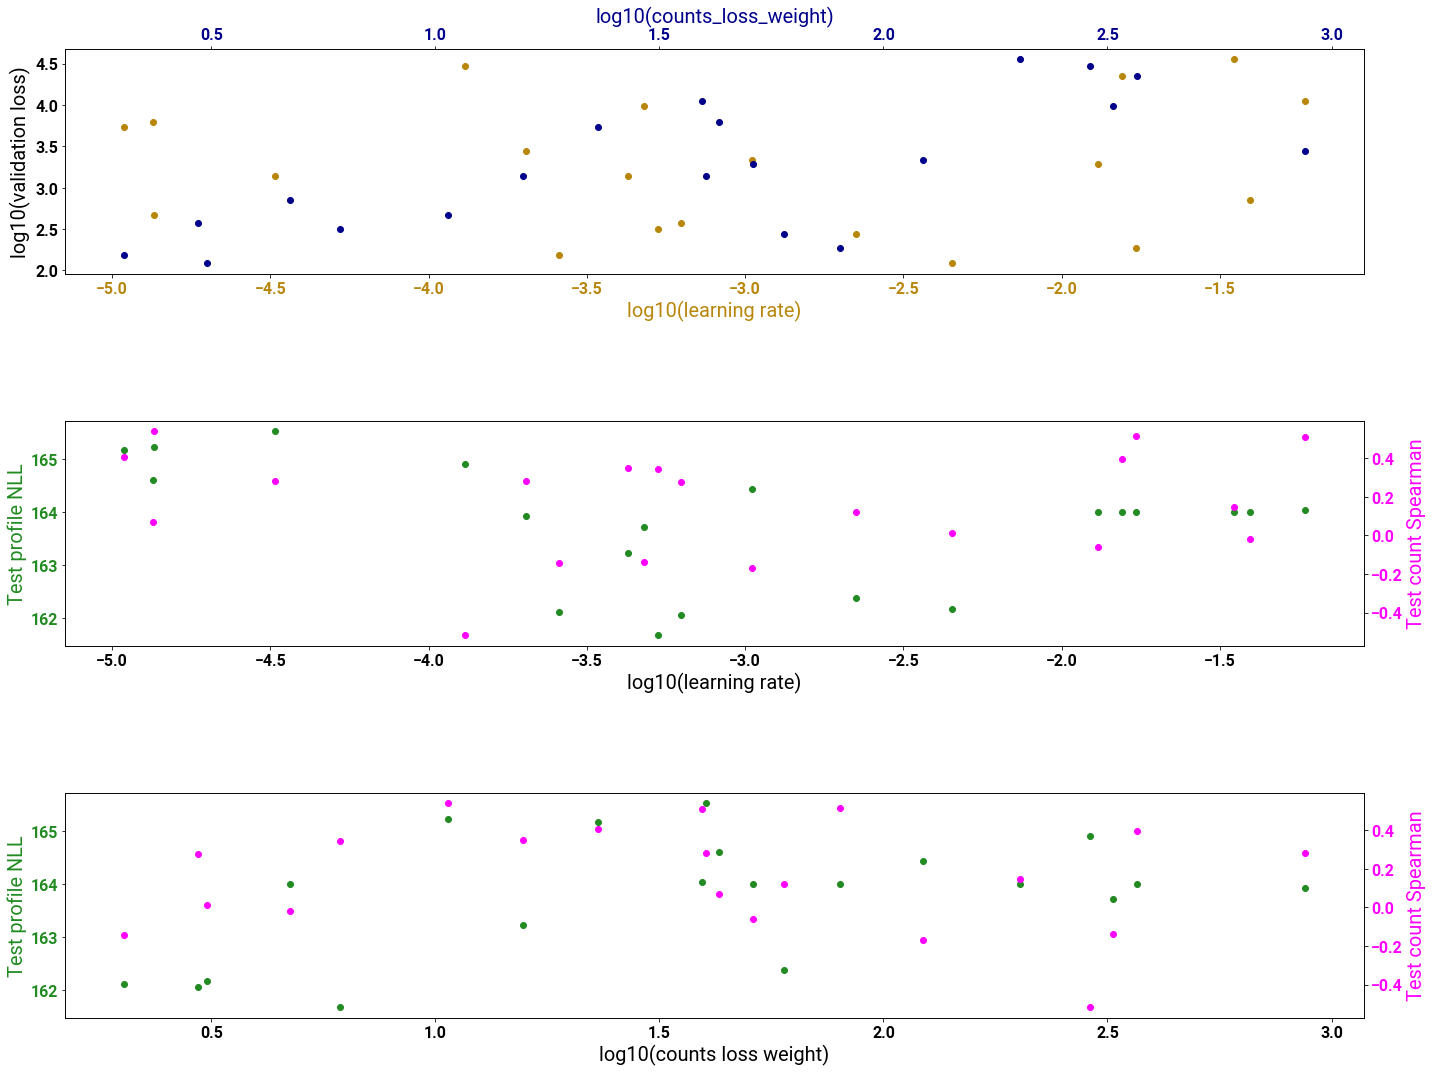

NR3C1-reddytime: task_1


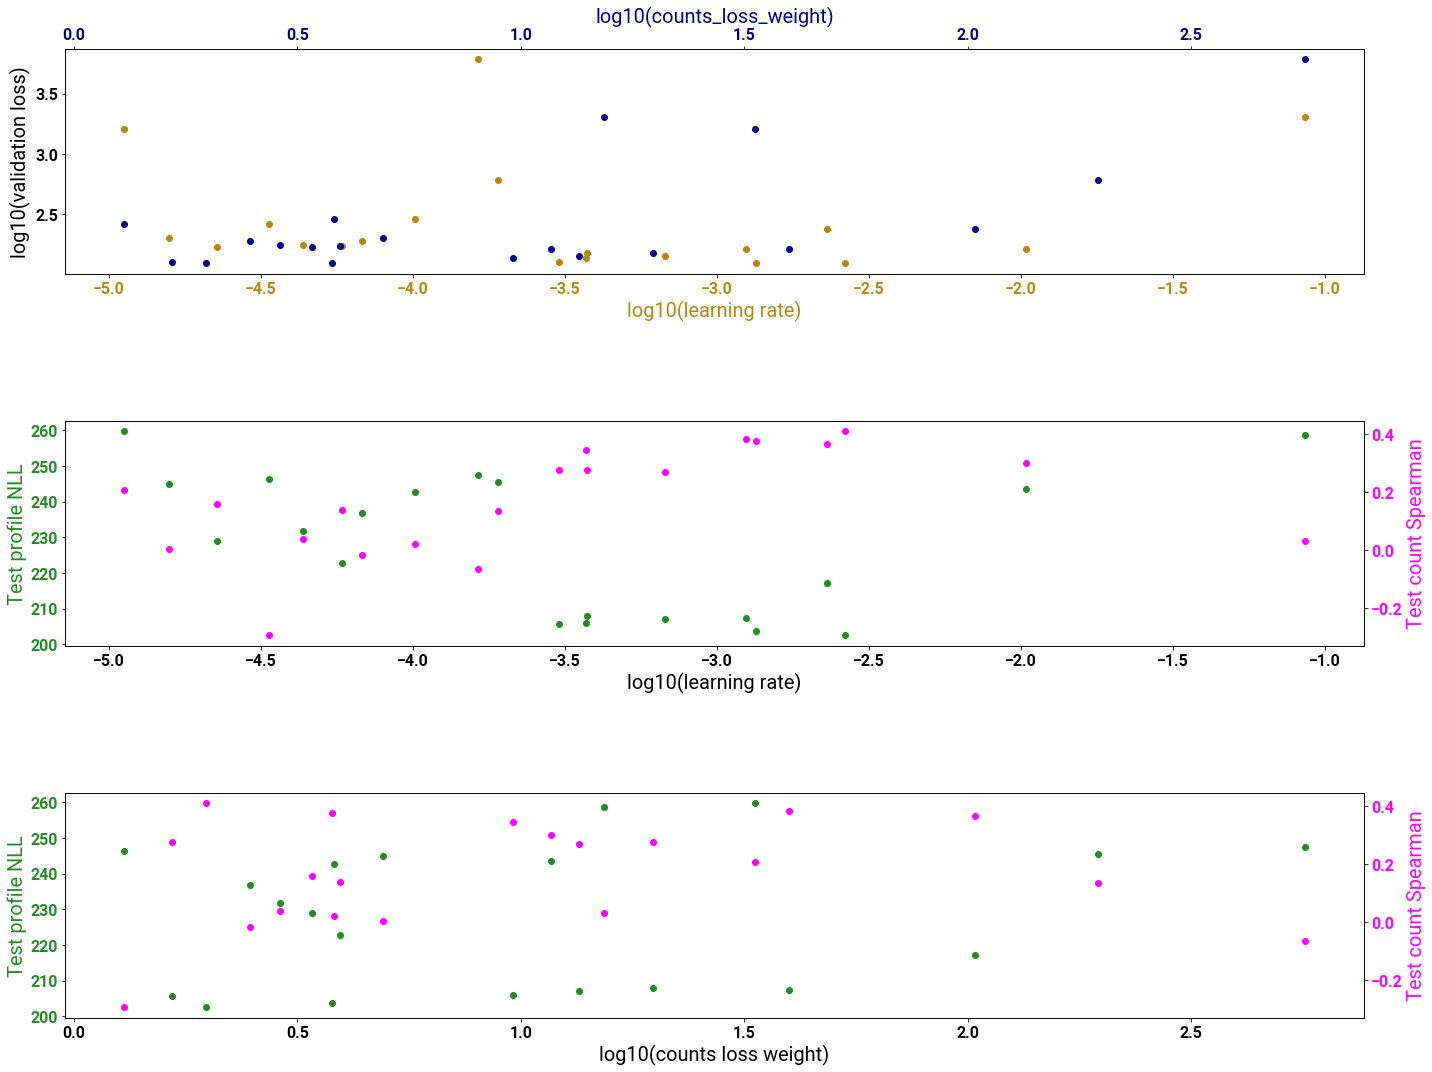

NR3C1-reddytime: task_2


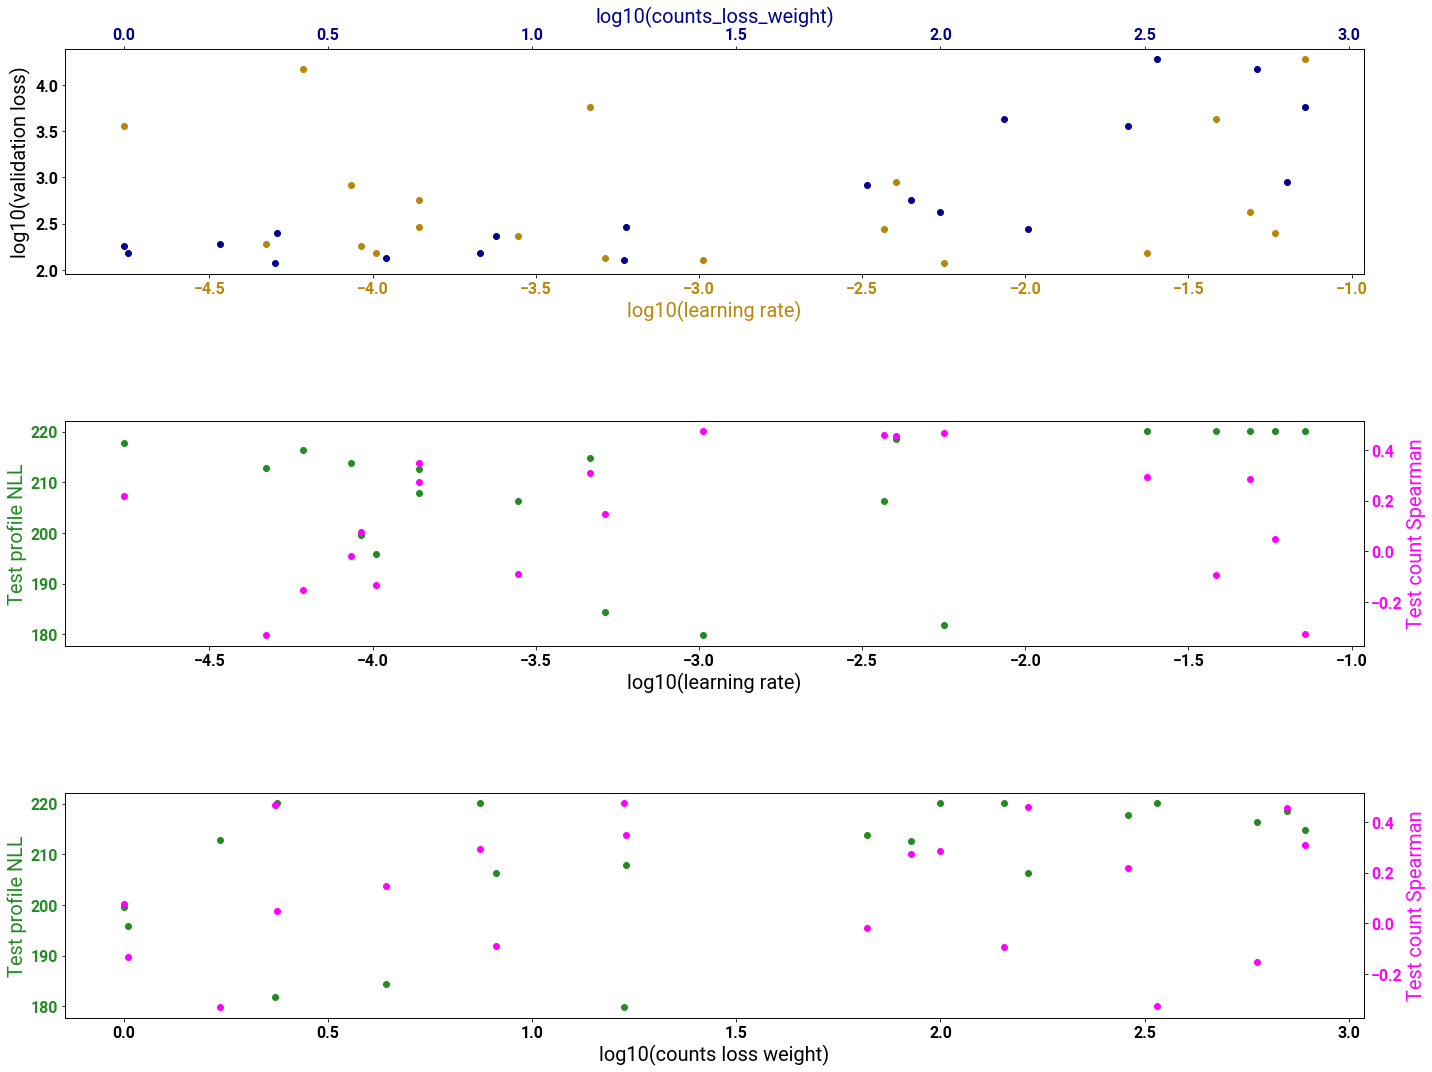

NR3C1-reddytime: task_3


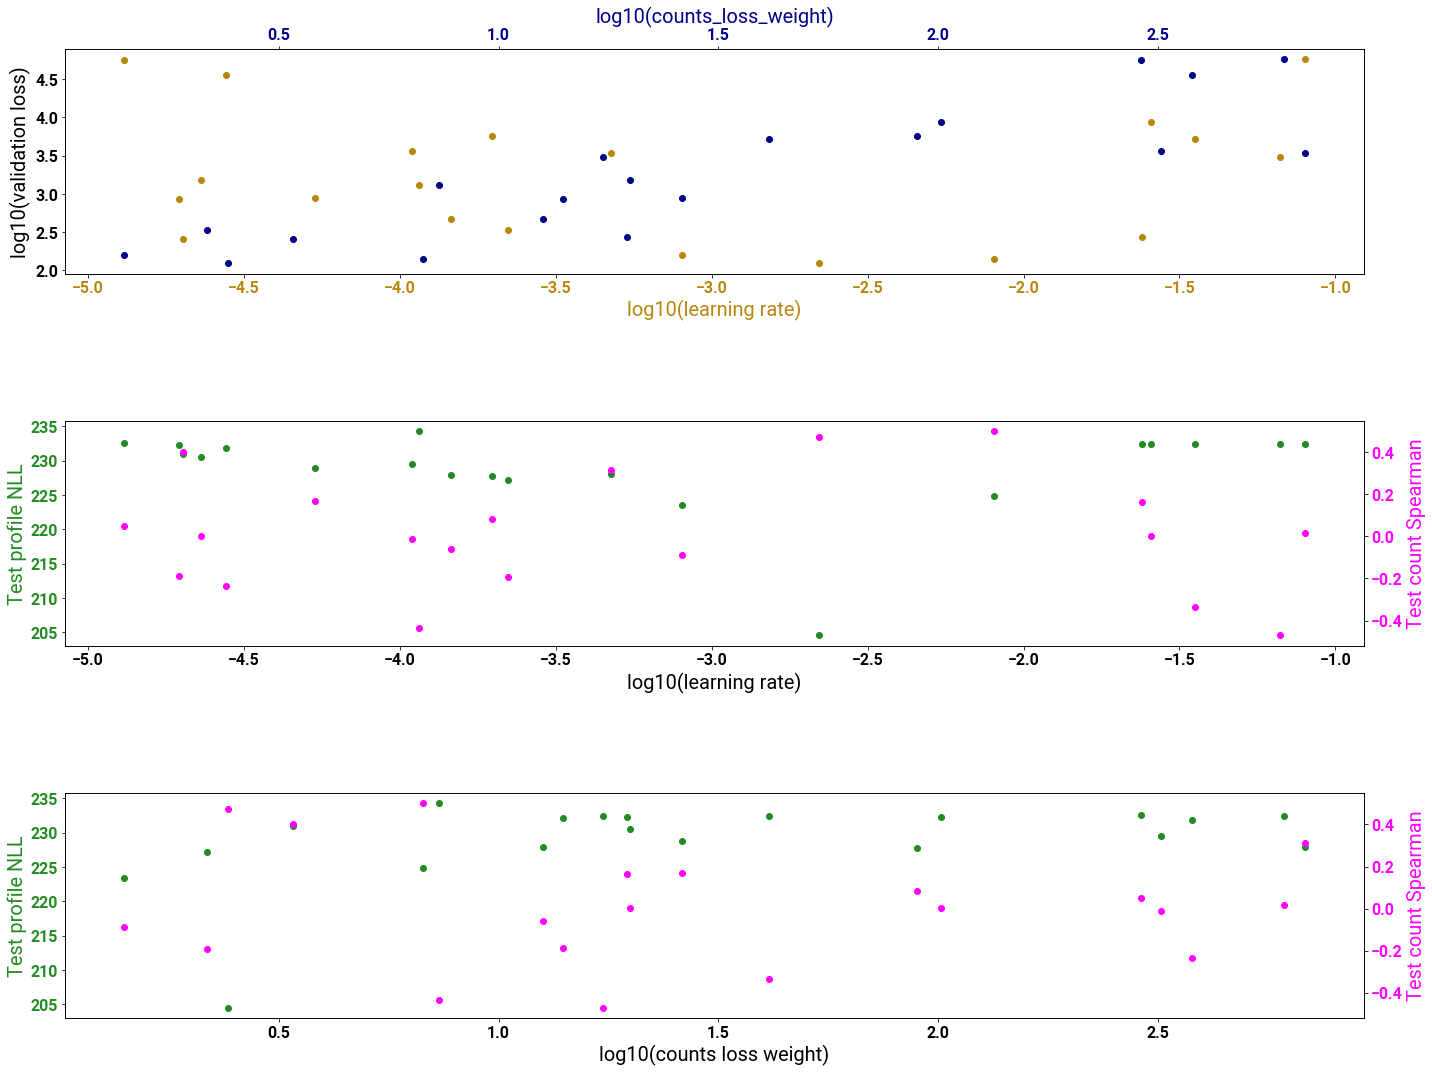

NR3C1-reddytime: task_4


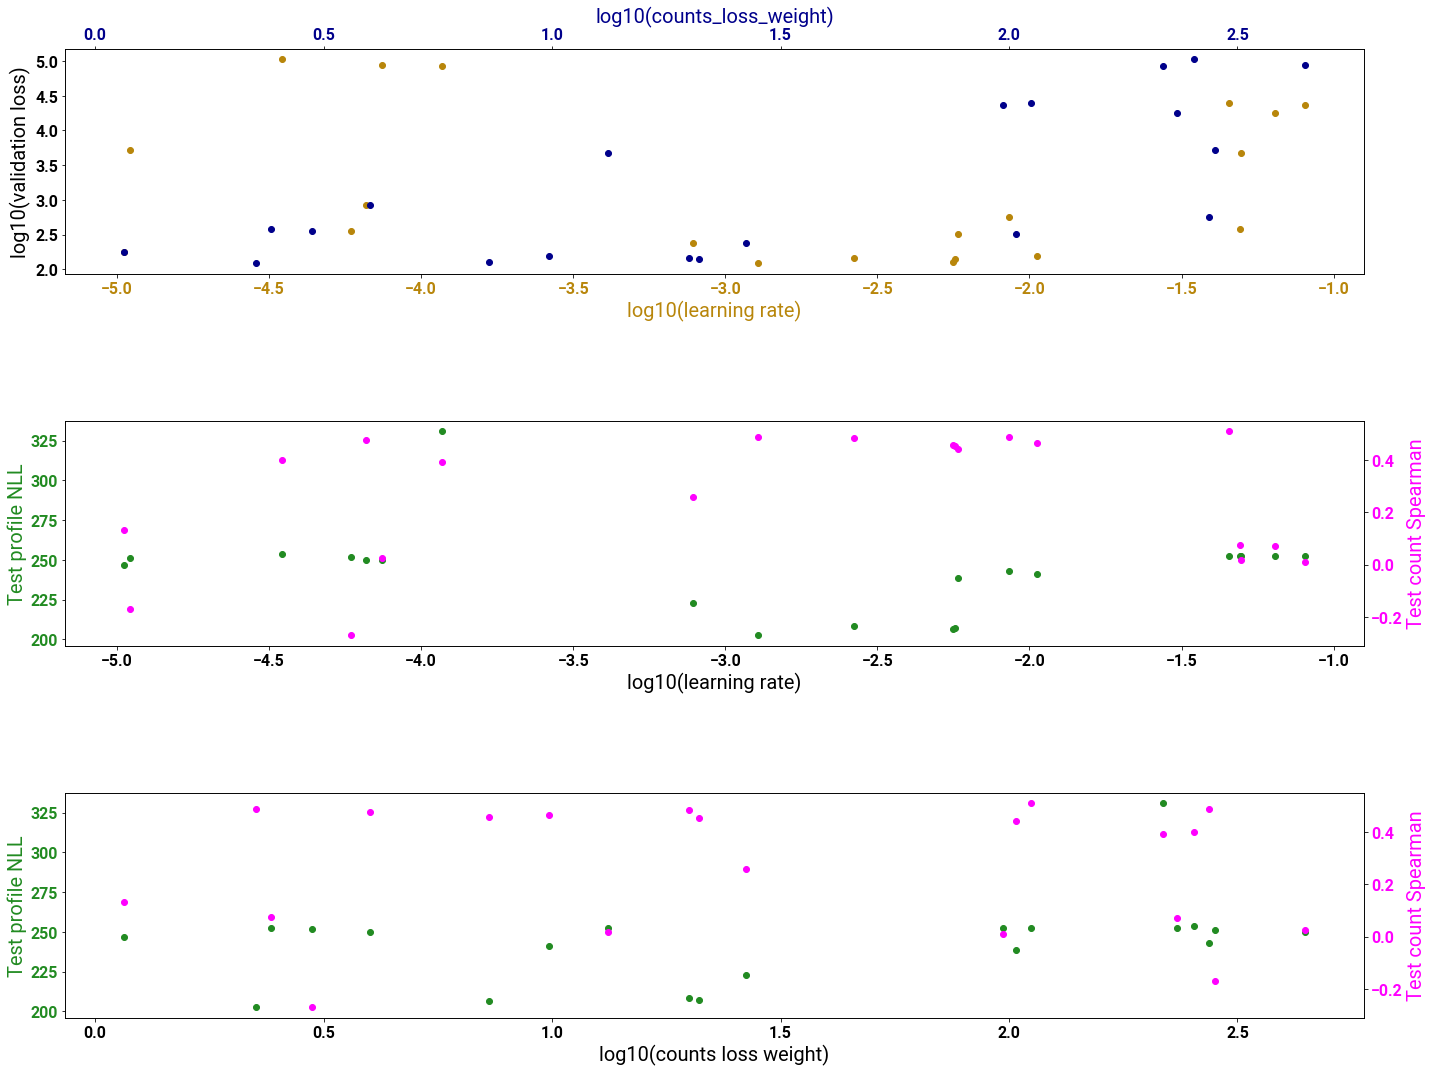

NR3C1-reddytime: task_5


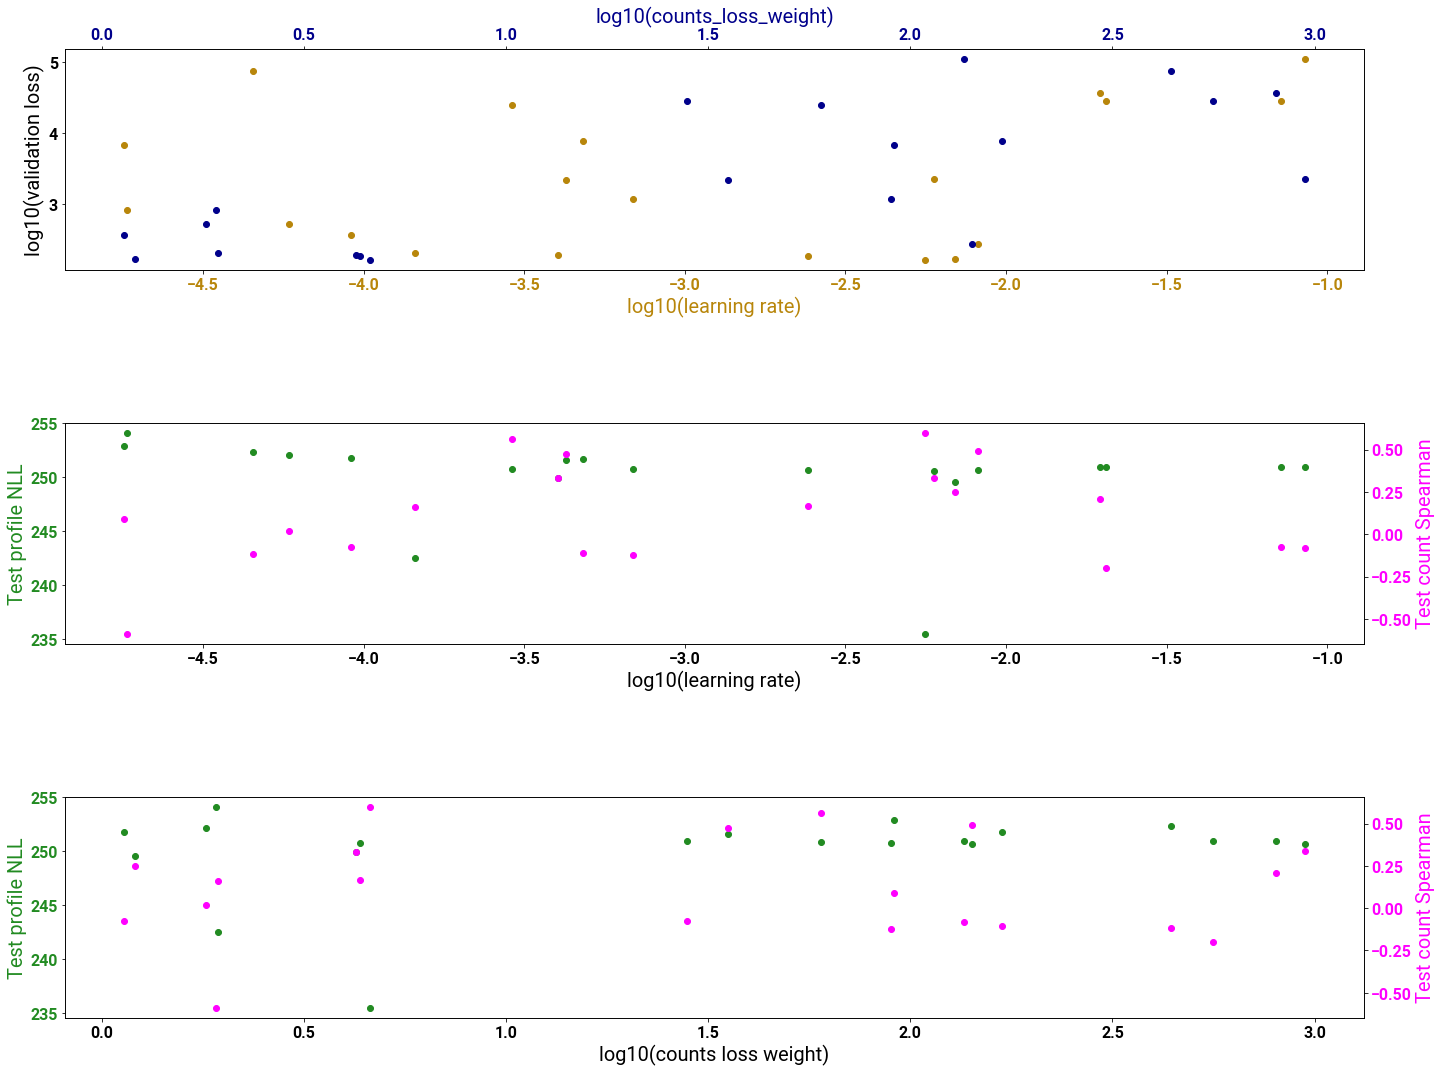

NR3C1-reddytime: task_6


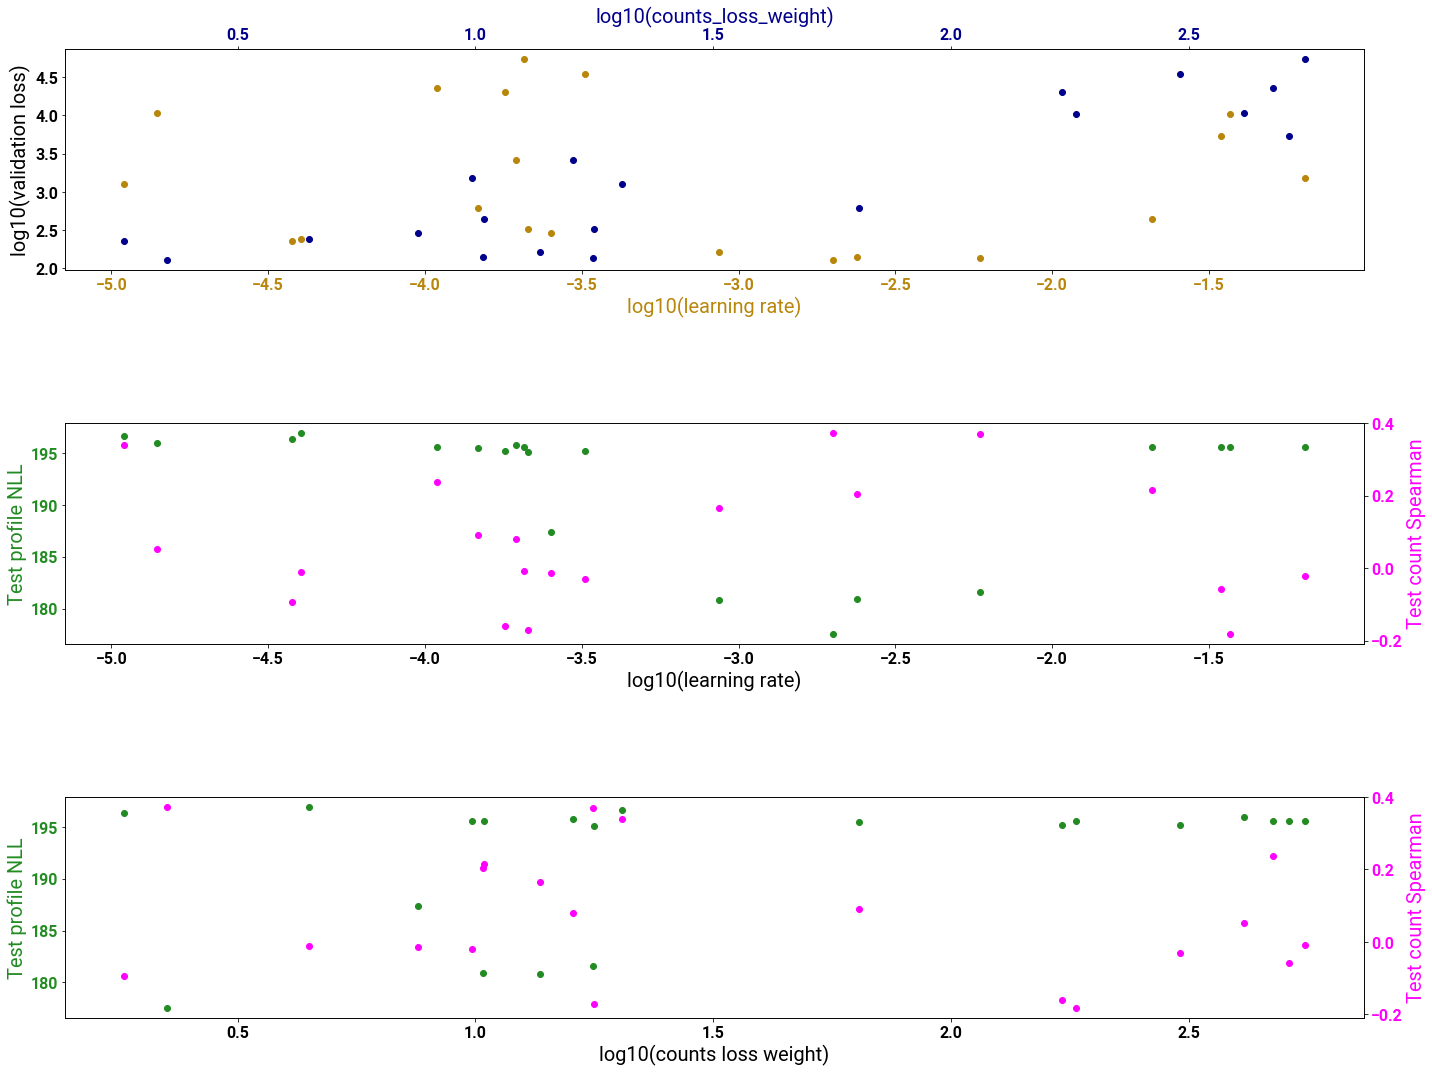

NR3C1-reddytime: task_7


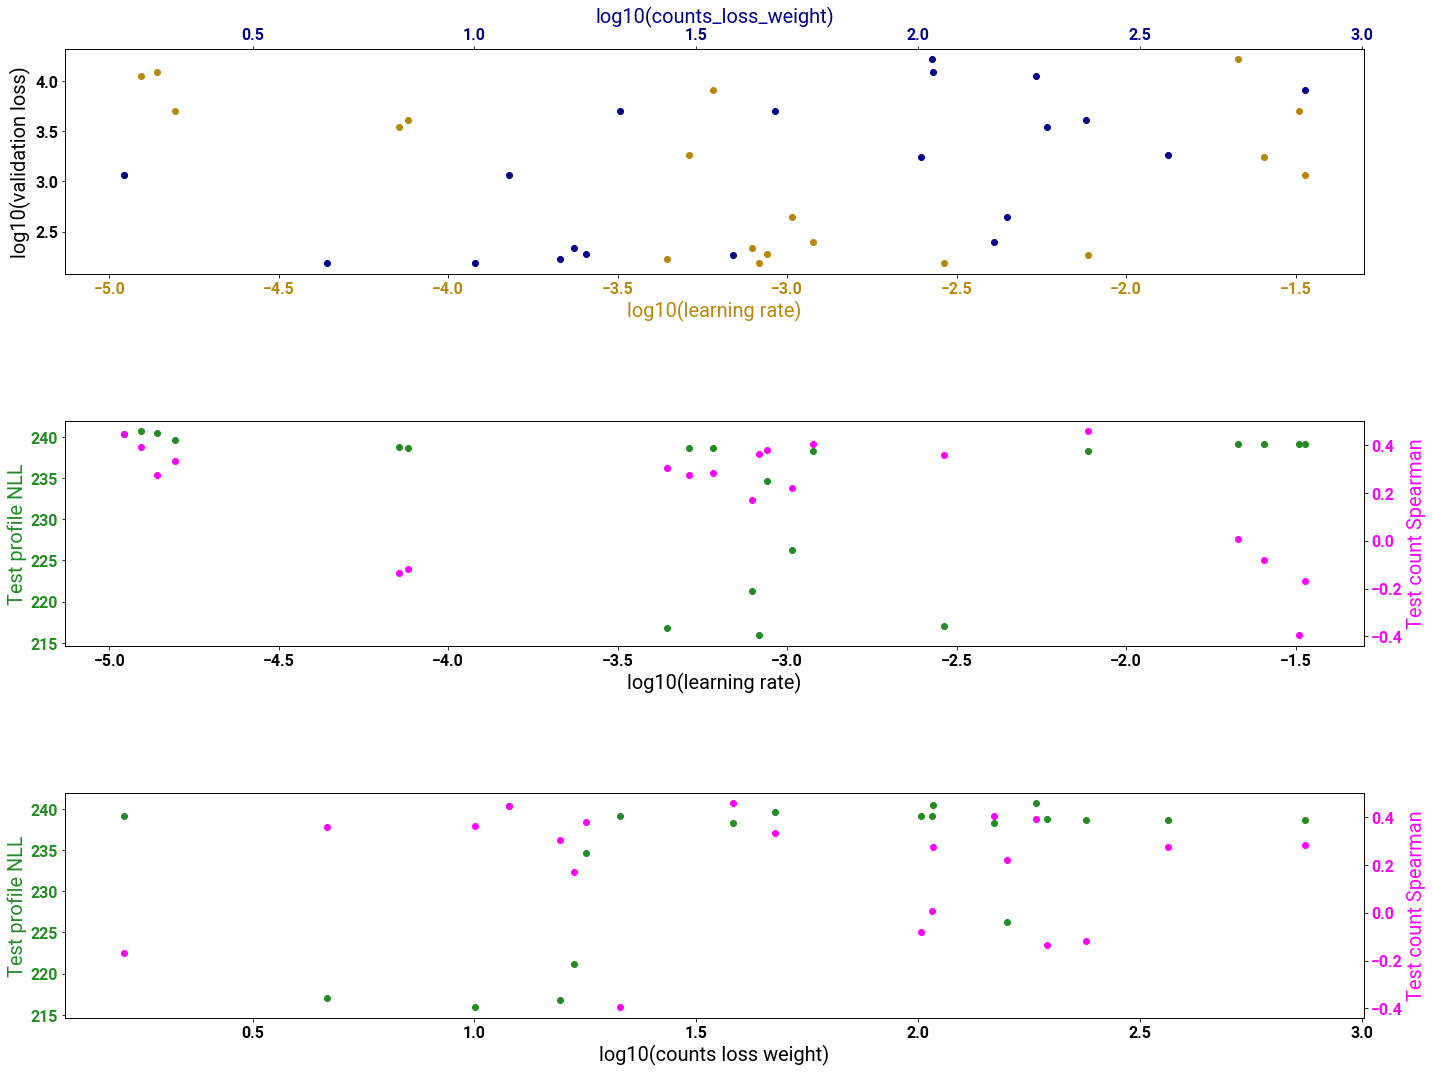

NR3C1-reddytime: task_8


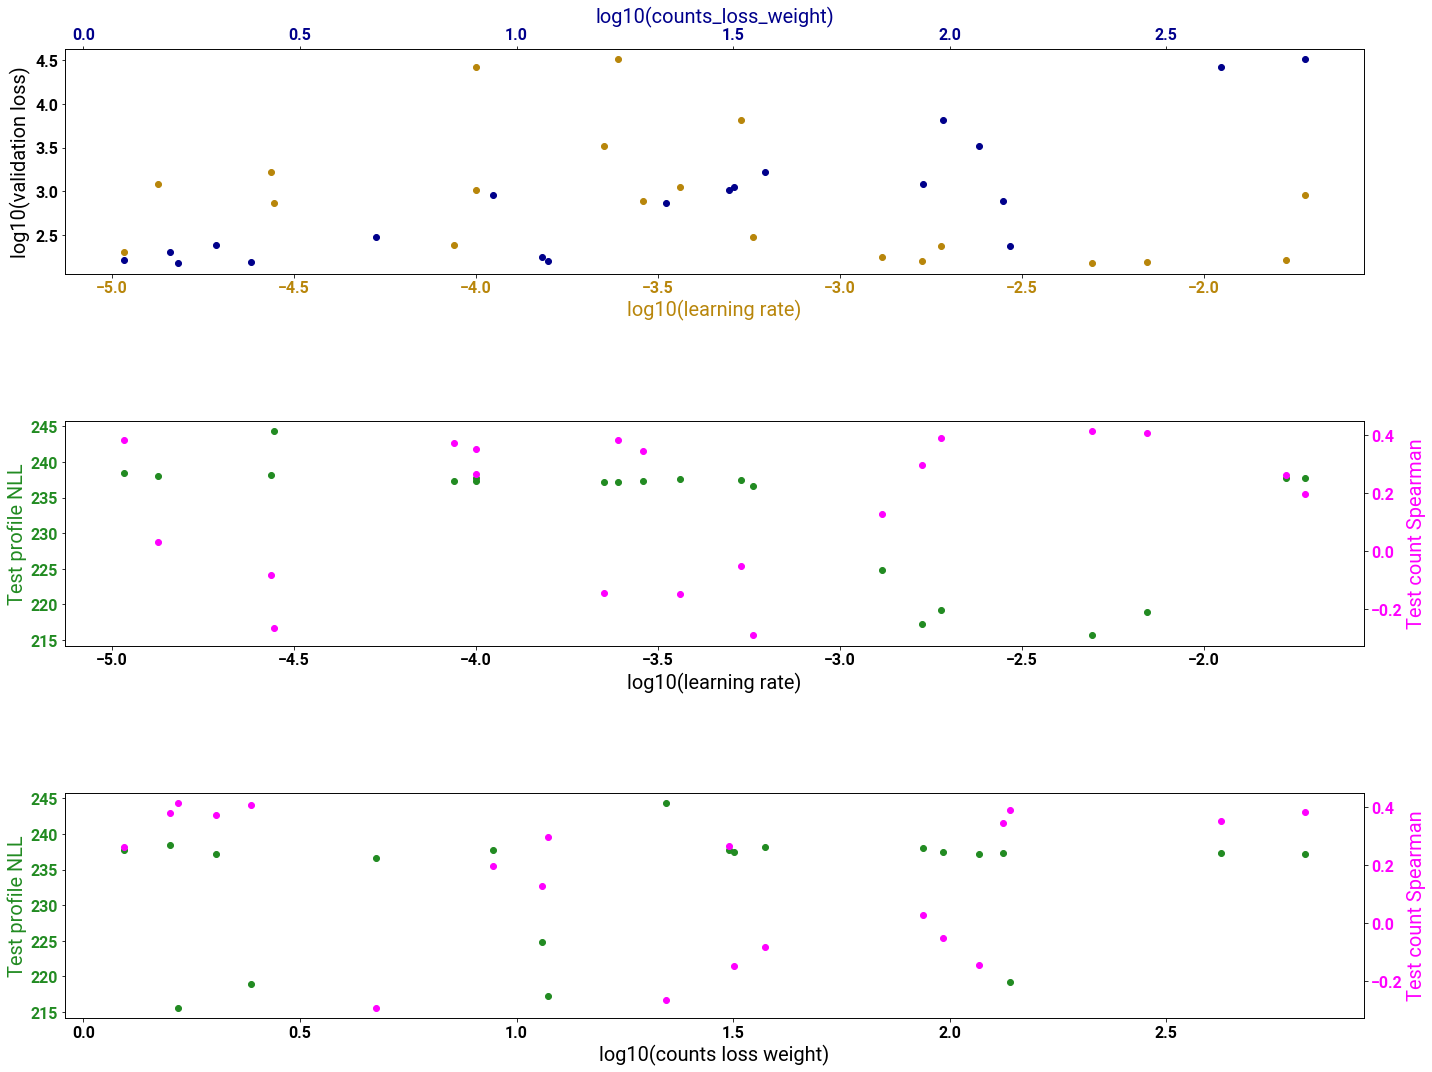

NR3C1-reddytime: task_9


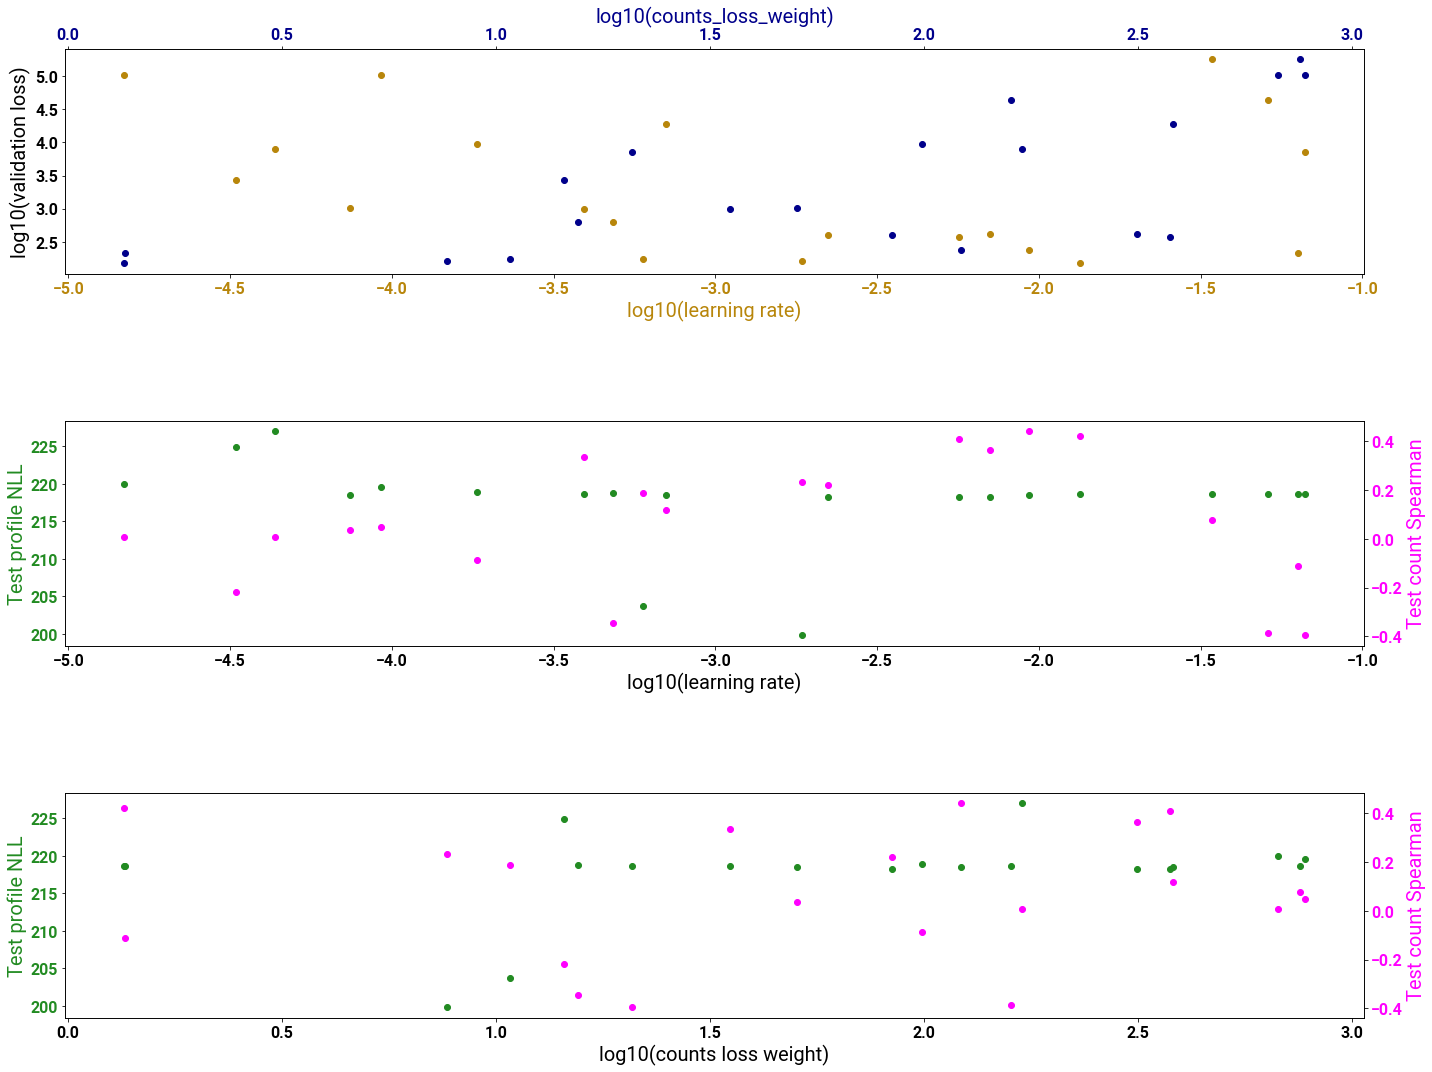

NR3C1-reddytime: task_10


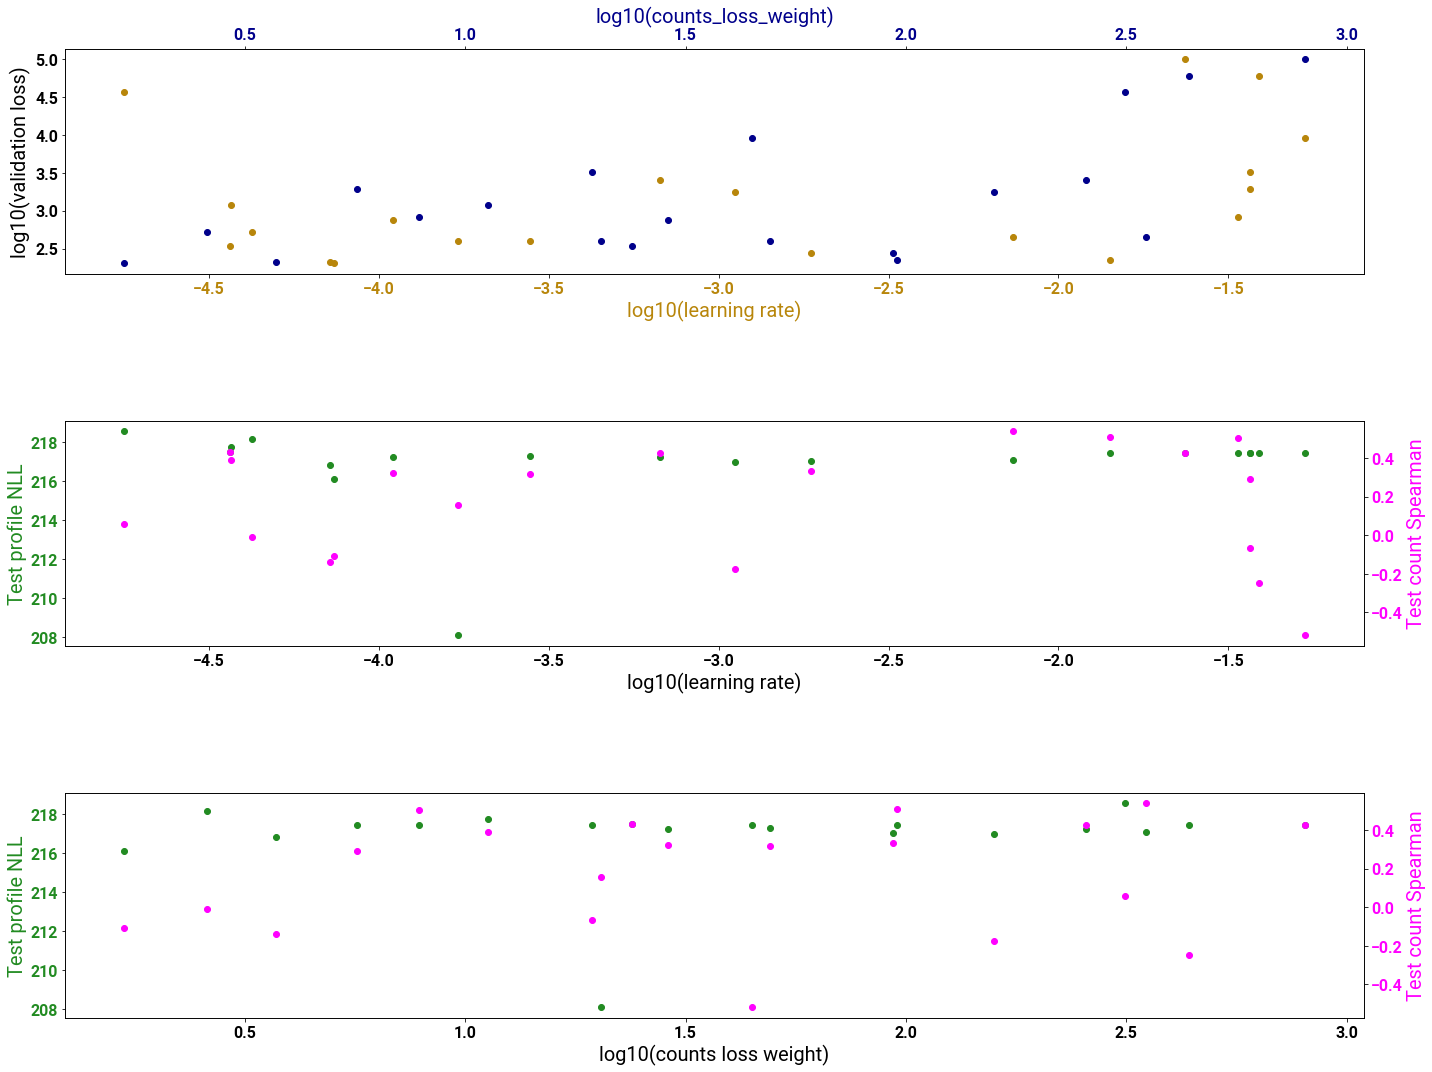

NR3C1-reddytime: task_11


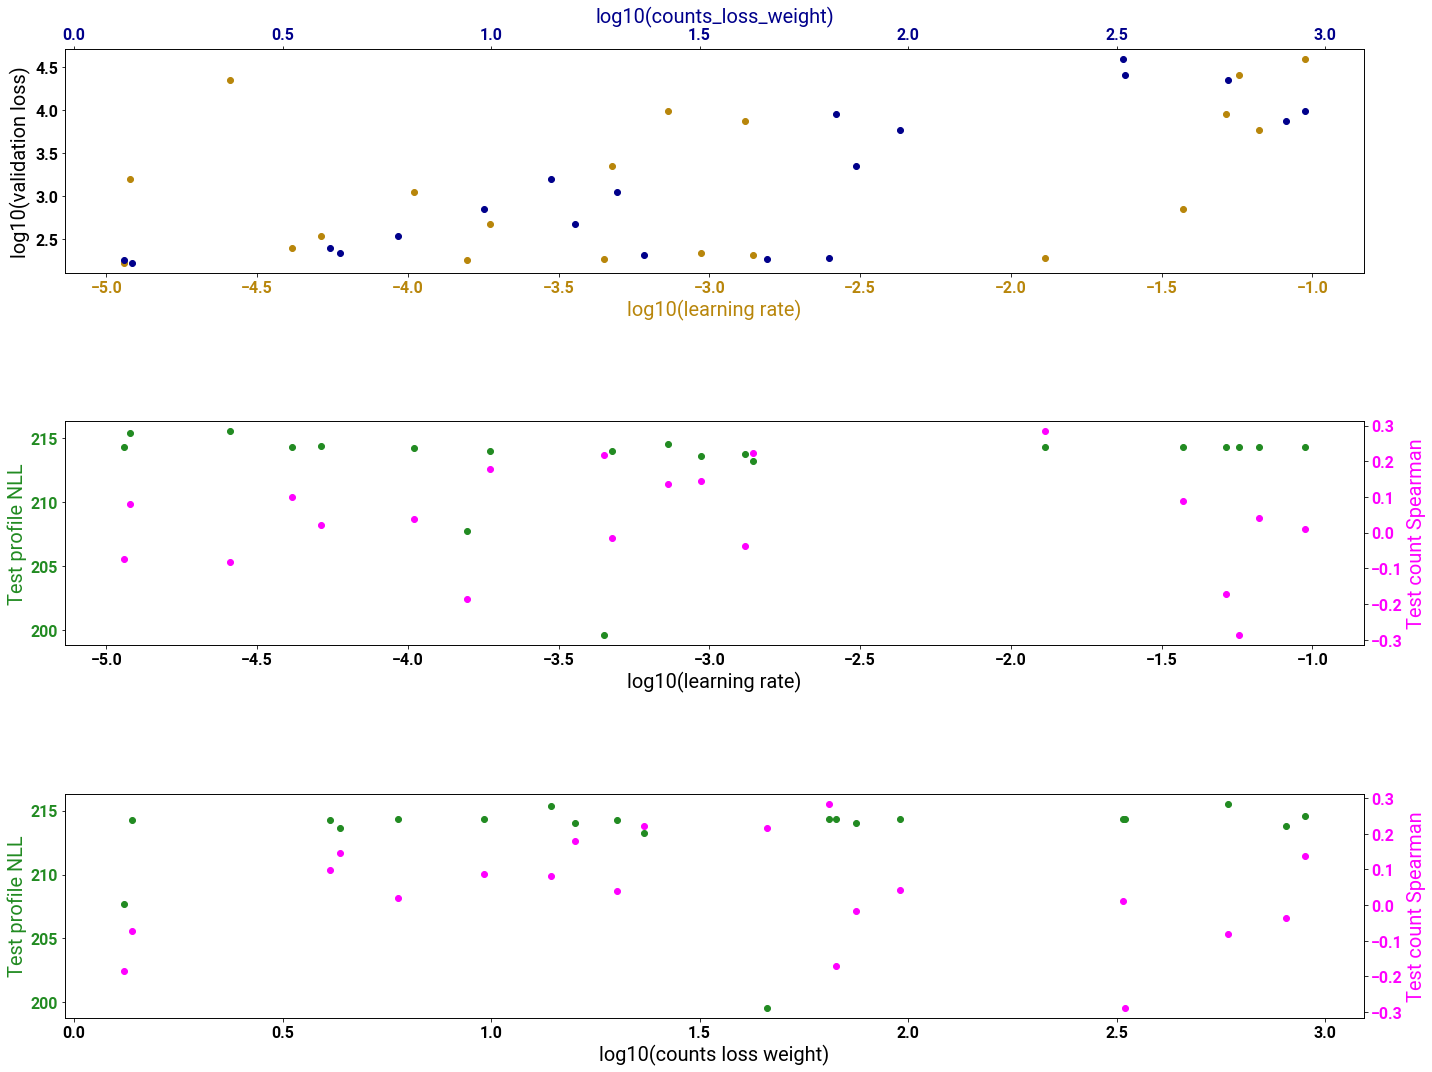

NR3C1-reddytime: task_12


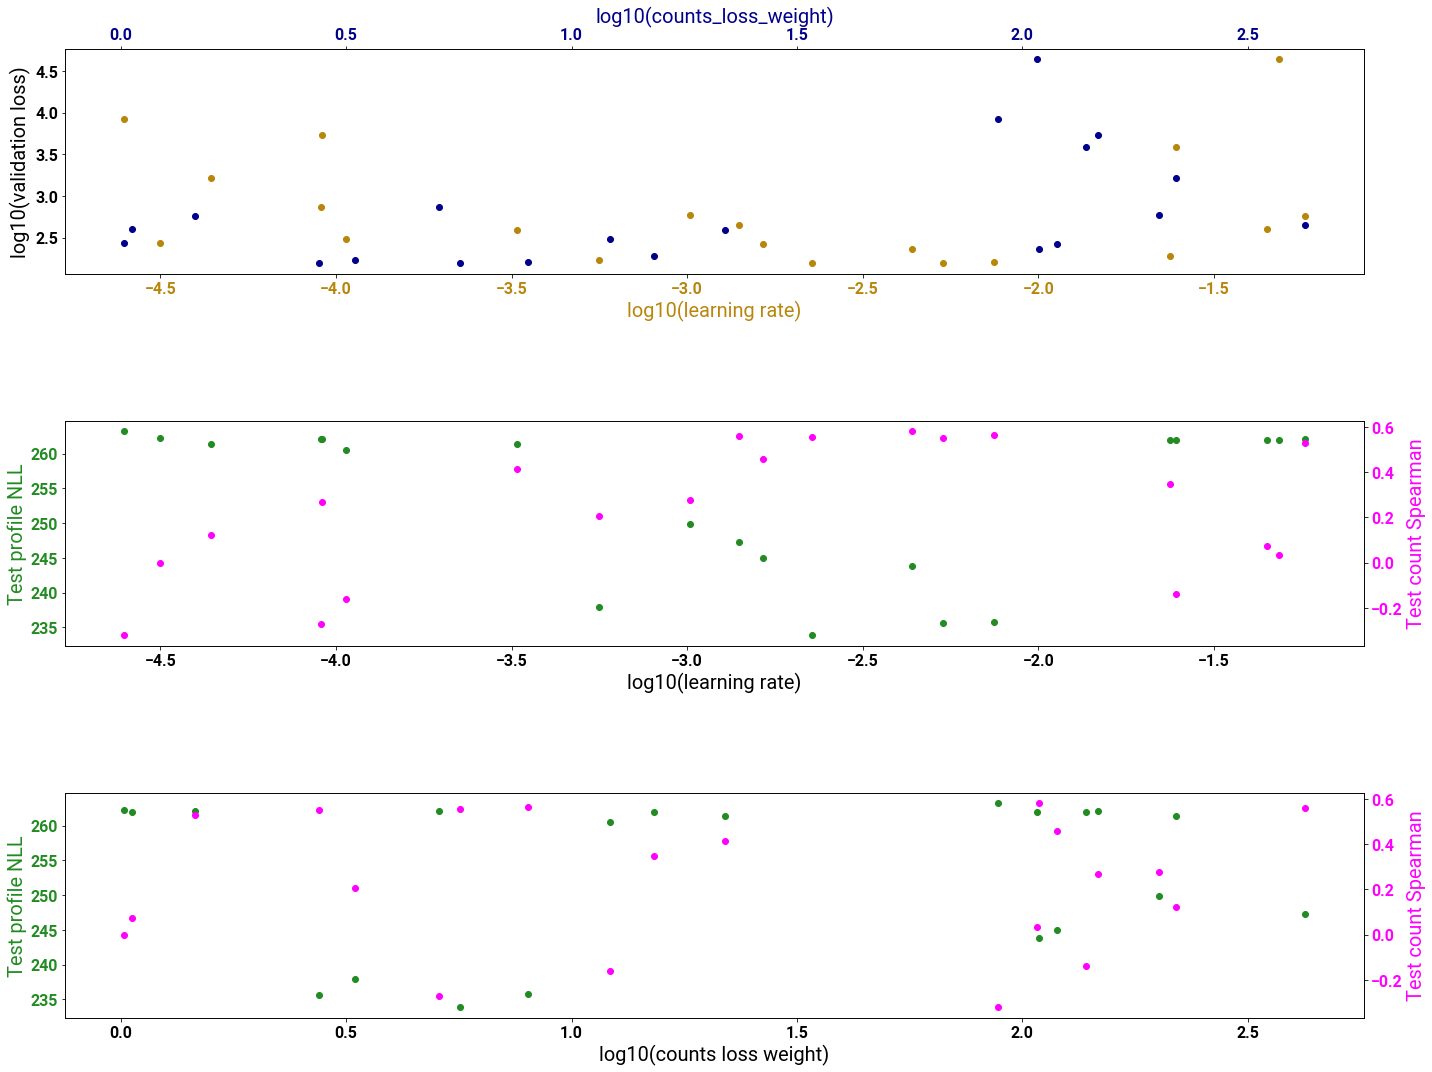

NR3C1-reddytime: task_13


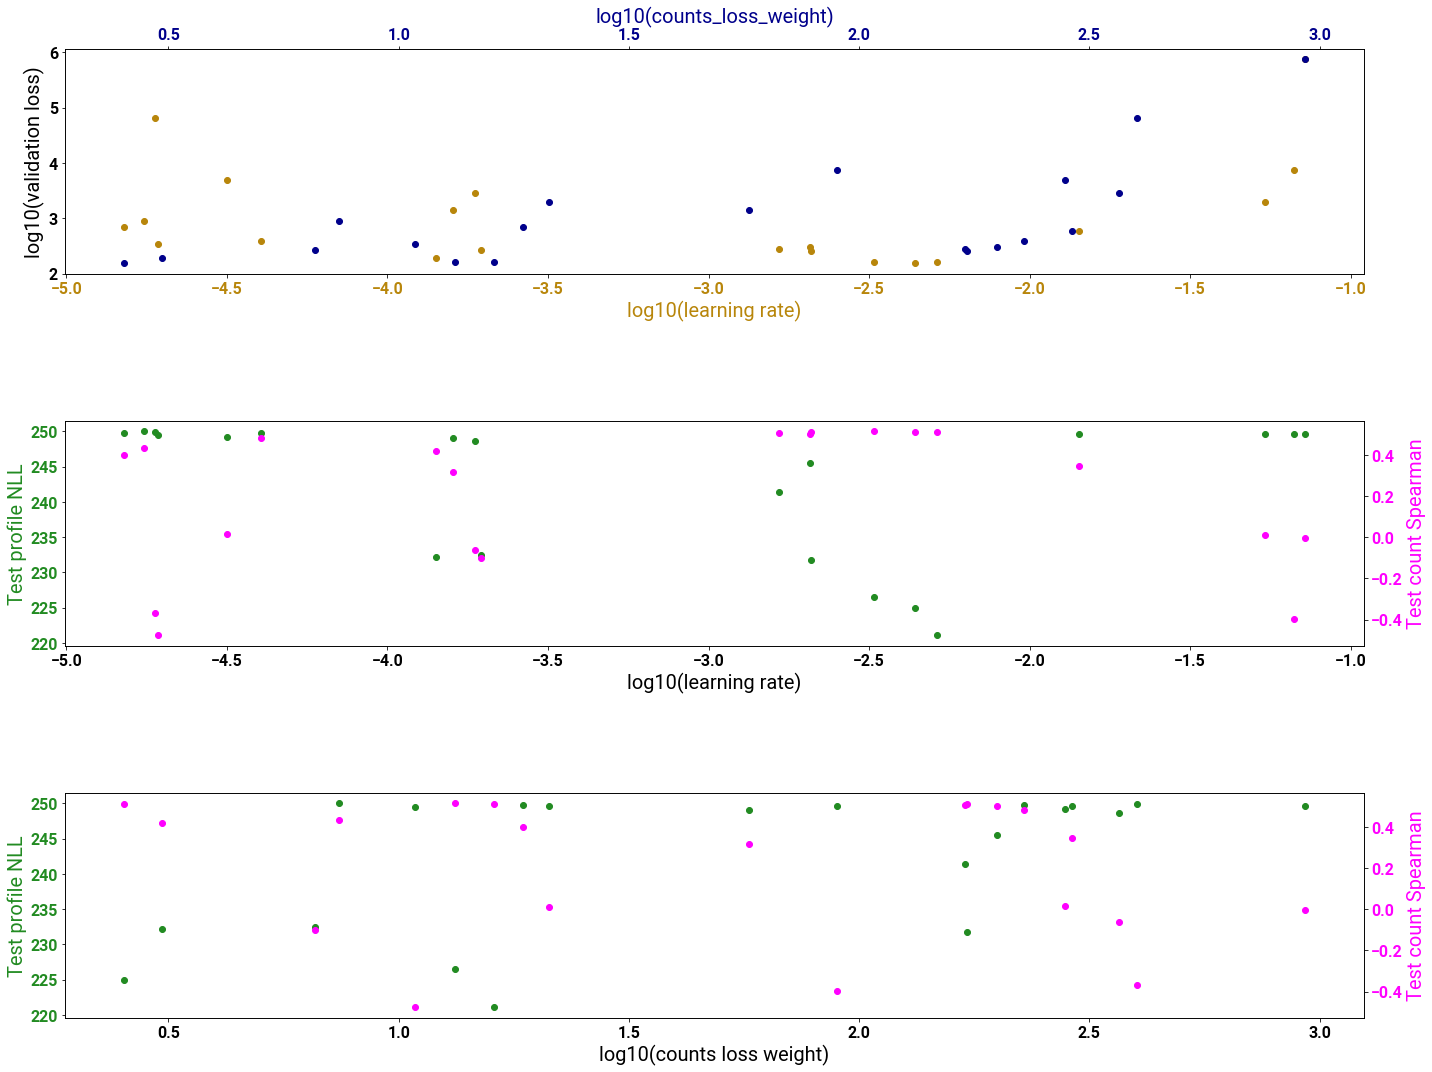

NR3C1-reddytime: task_14


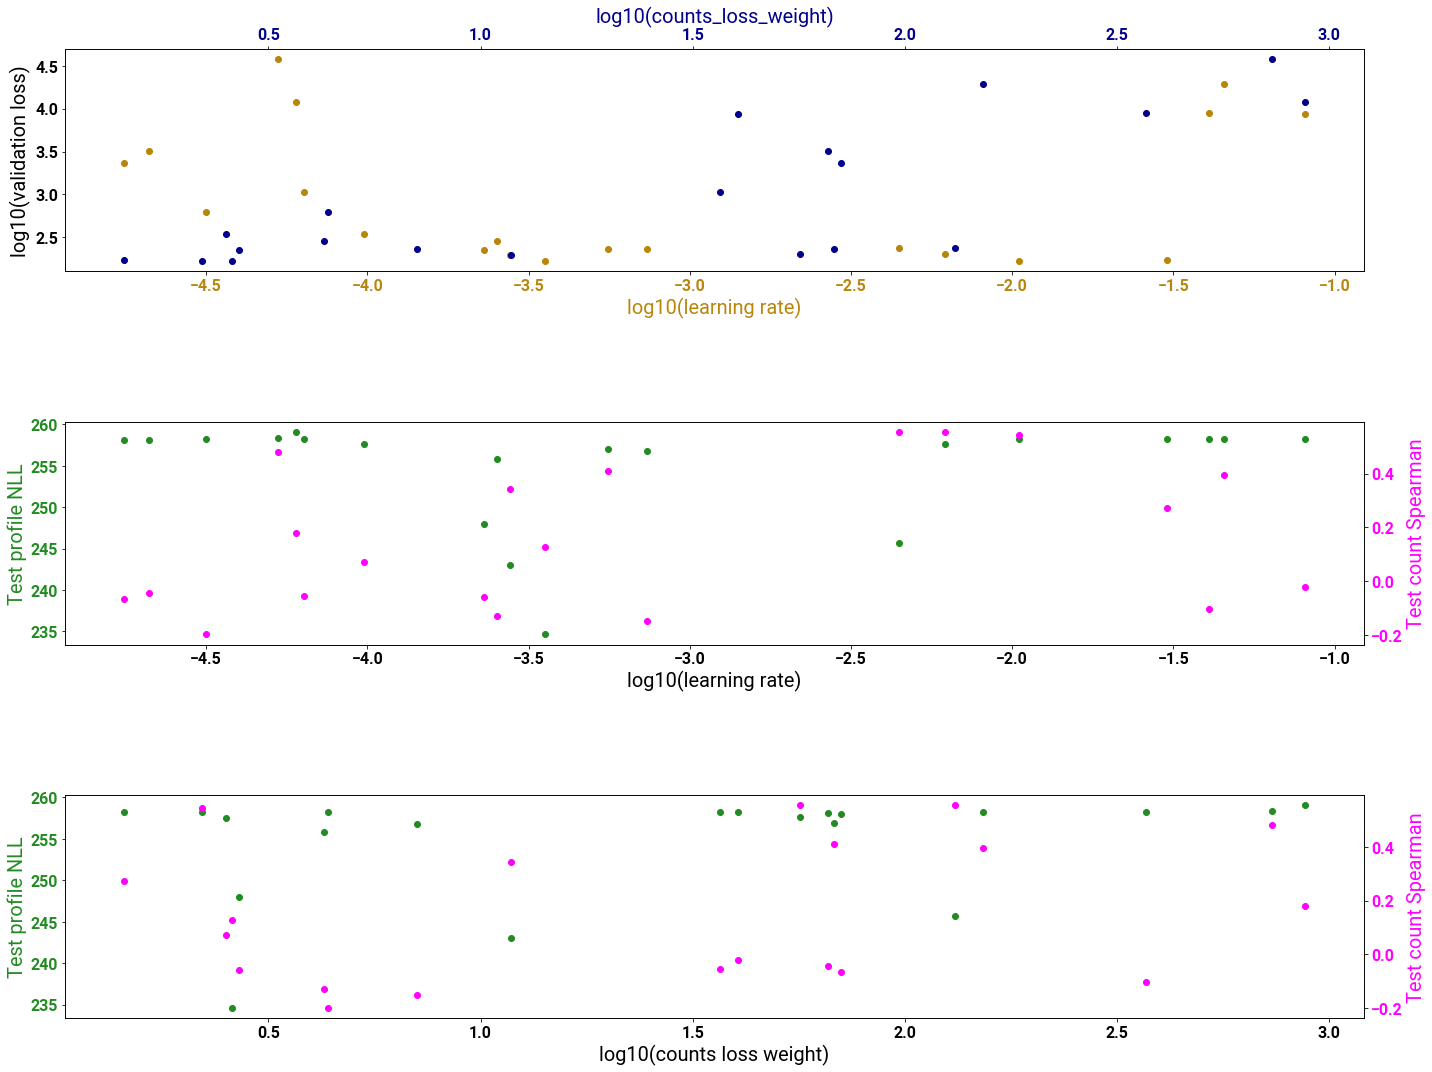

NR3C1-reddytime: task_15


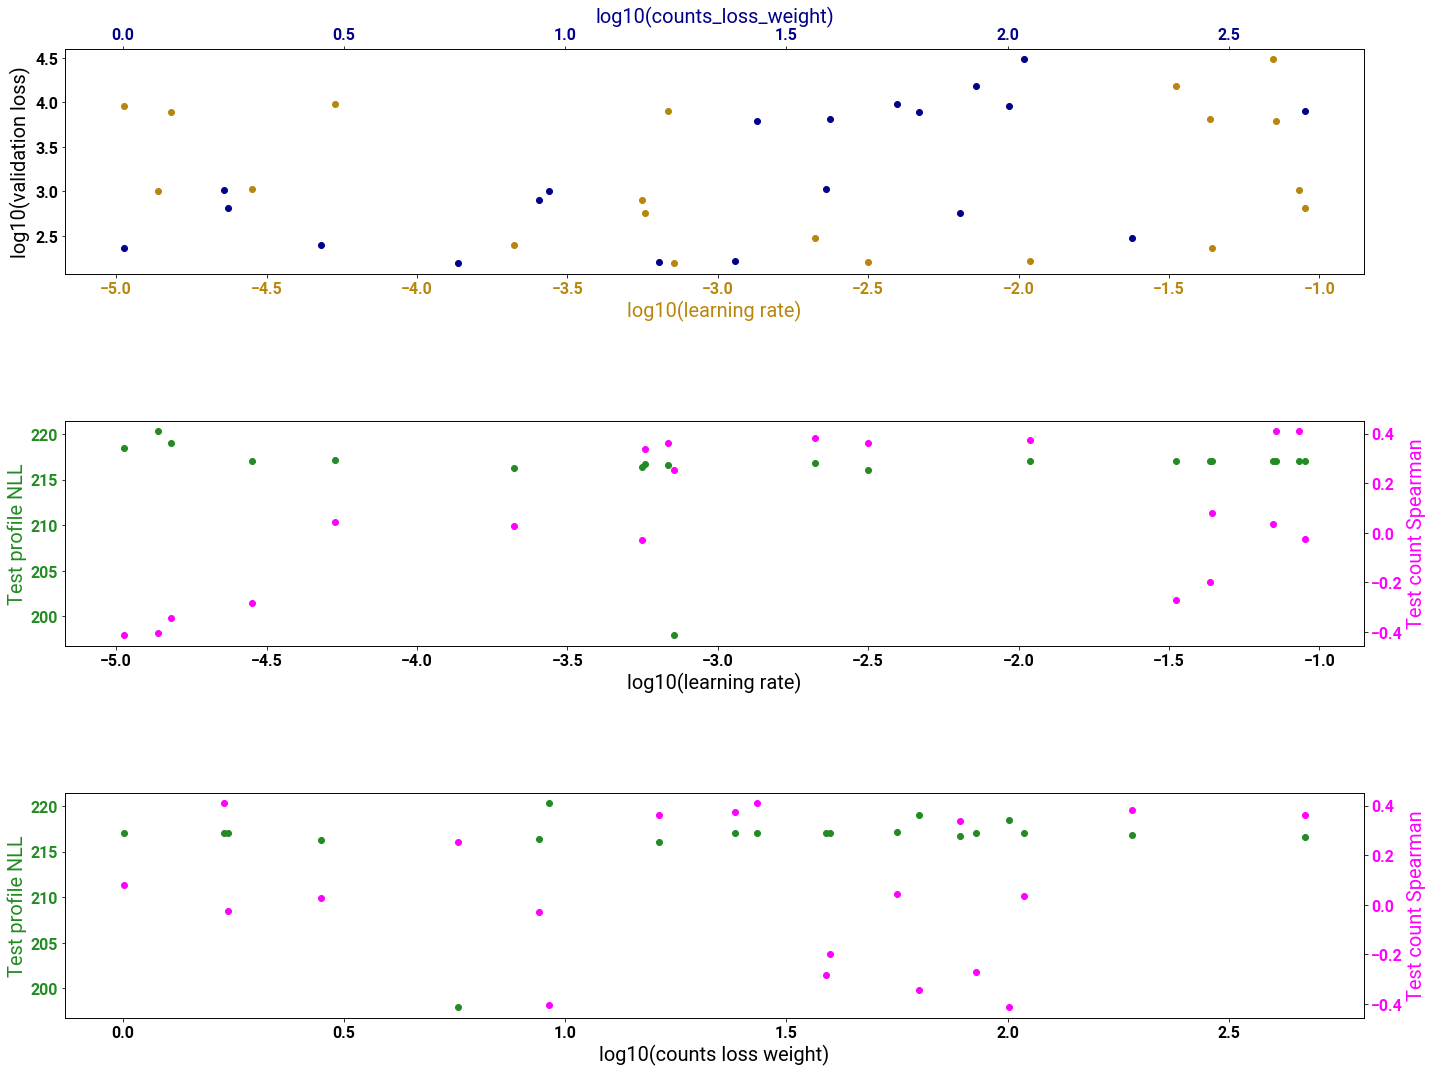

REST: task_0


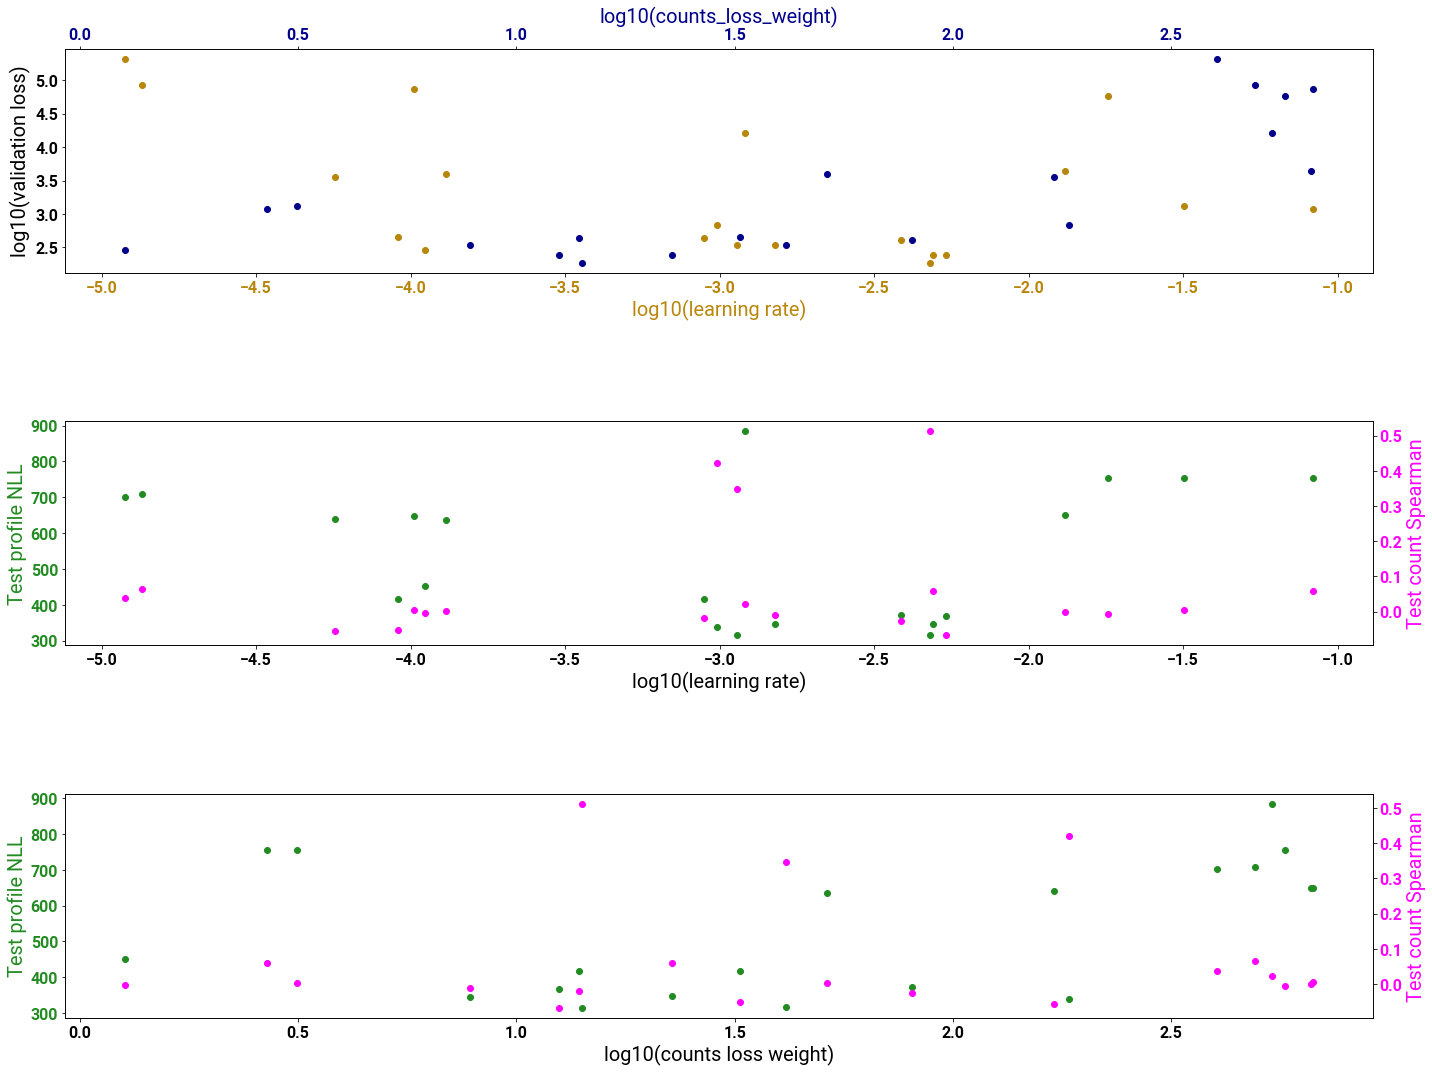

REST: task_1


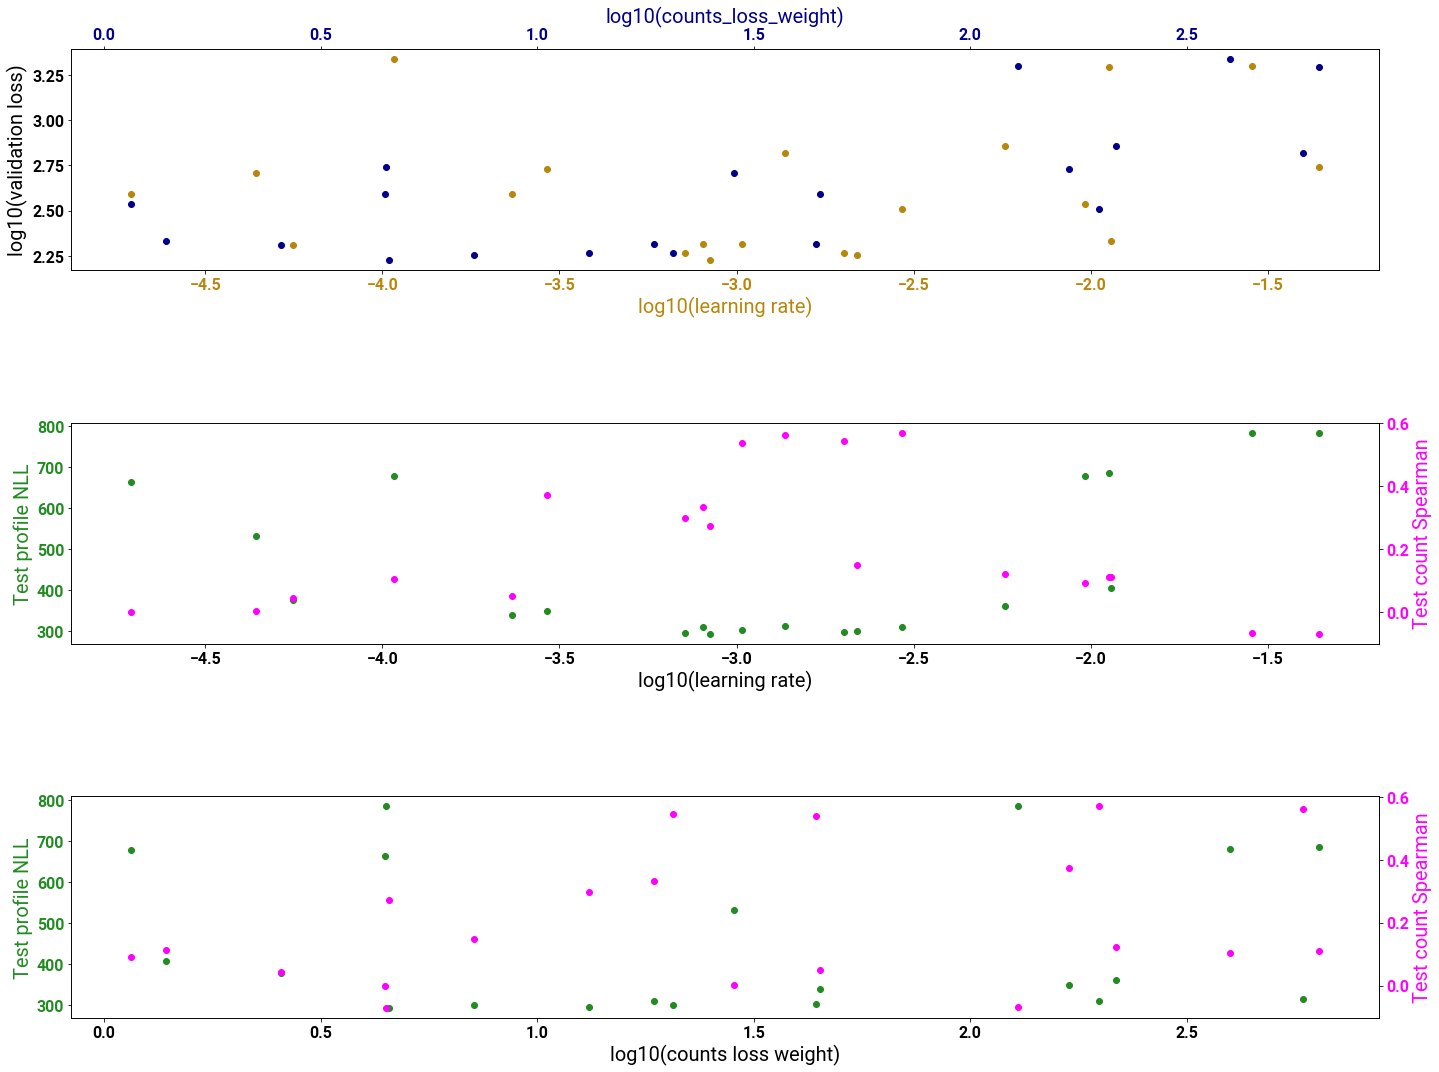

REST: task_2


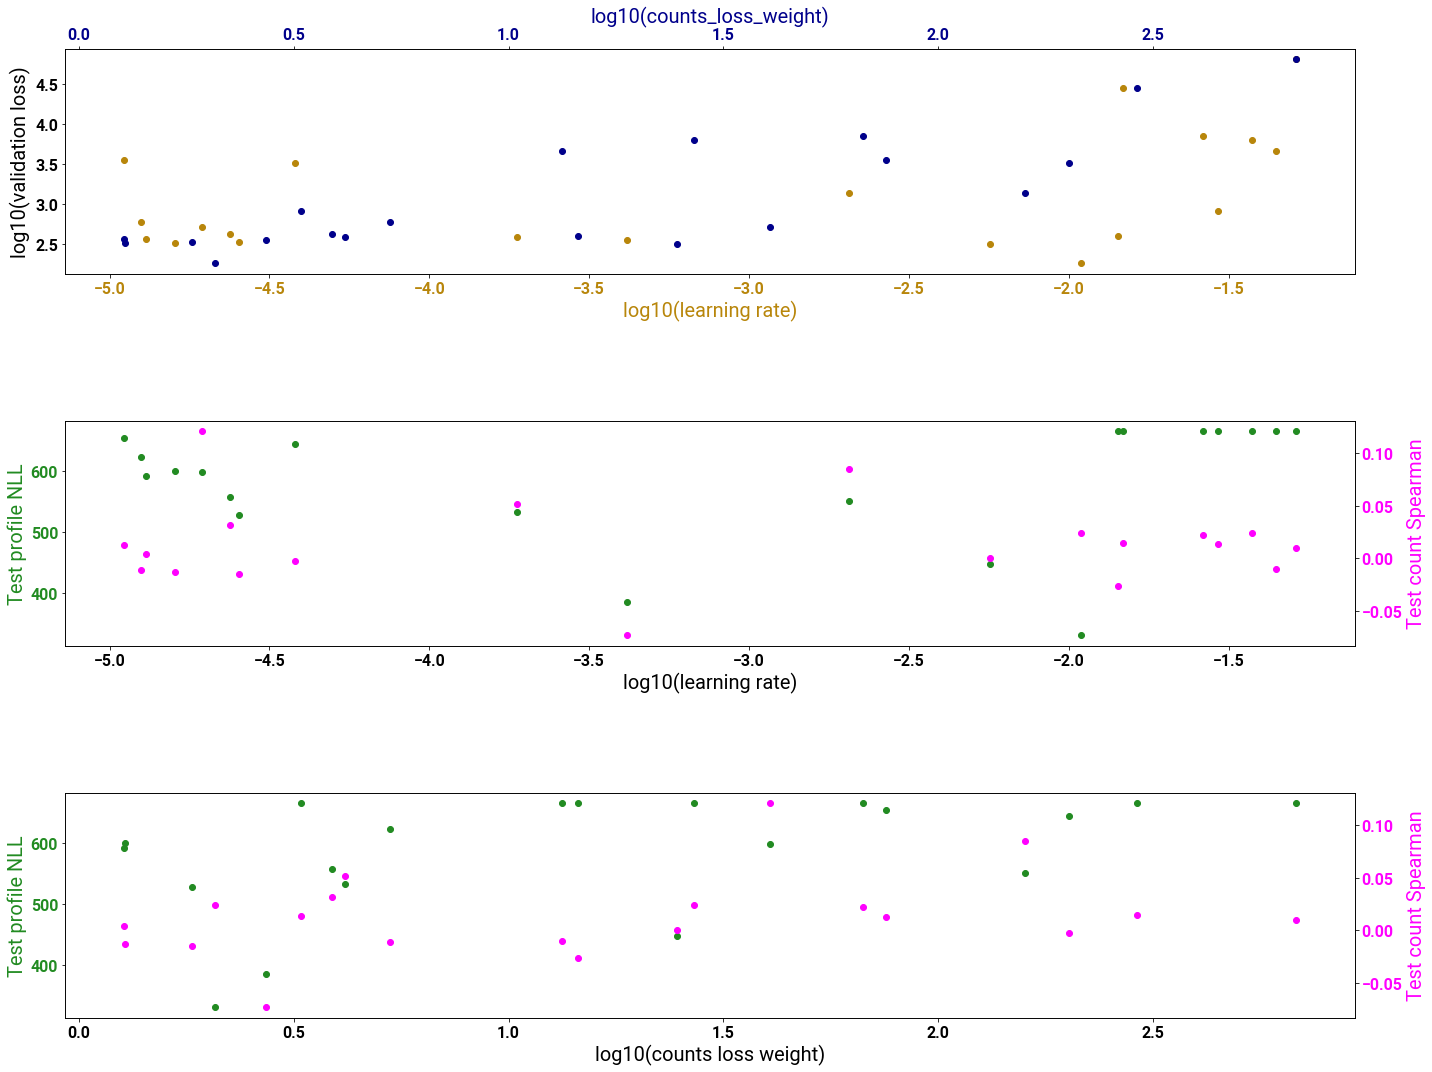

REST: task_3


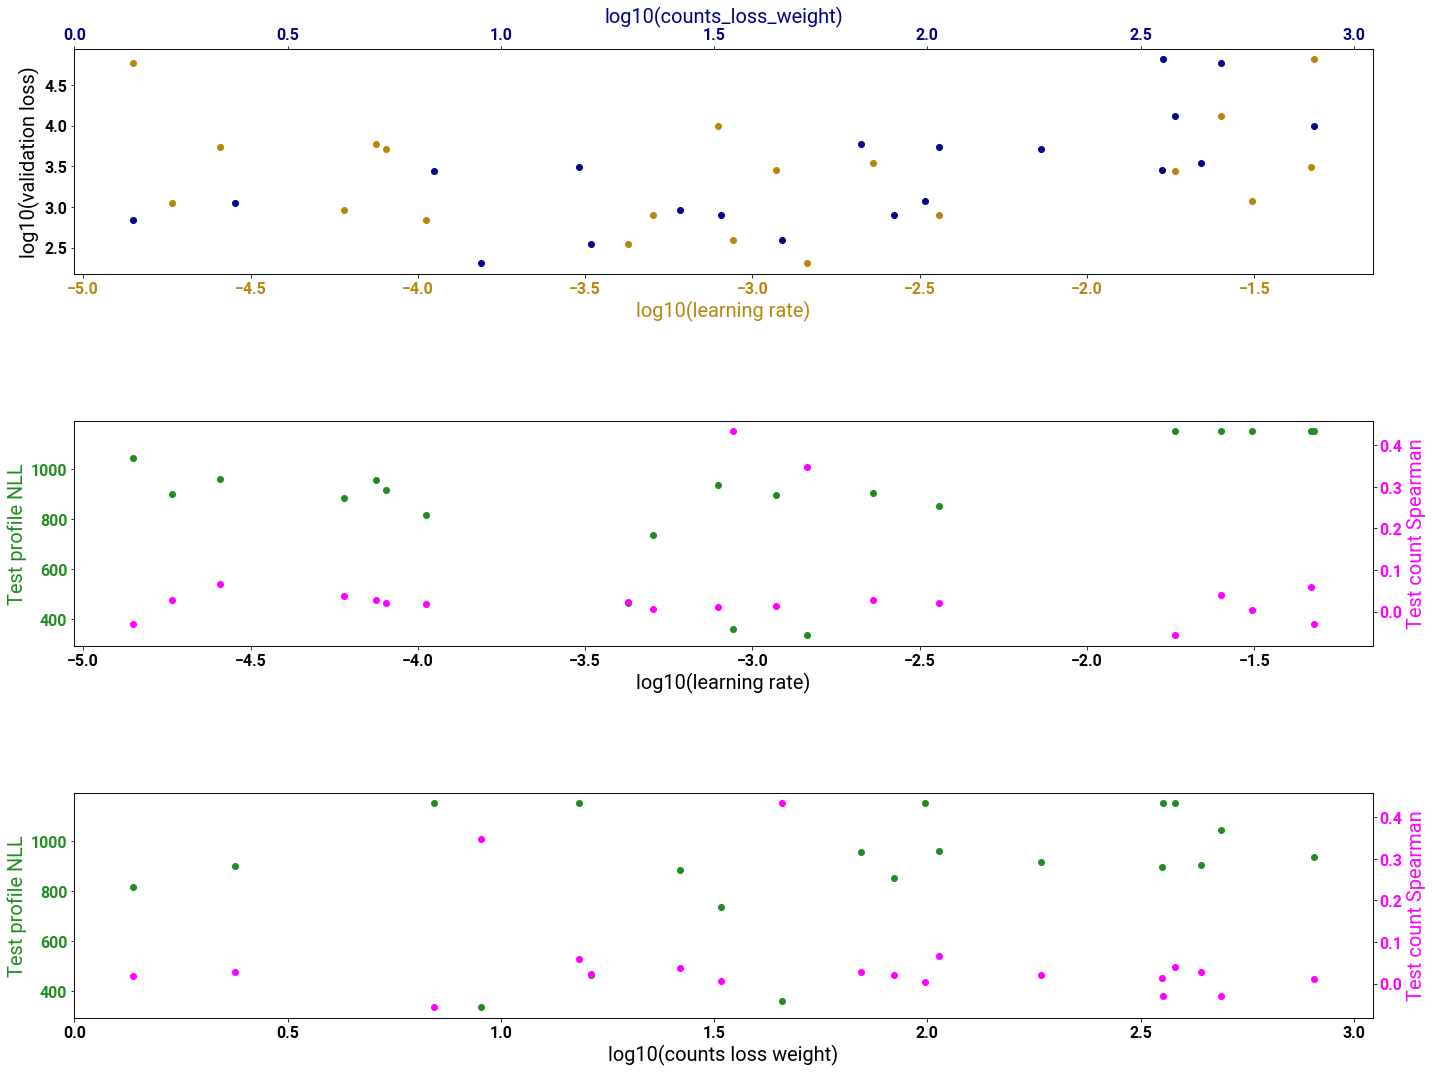

REST: task_4


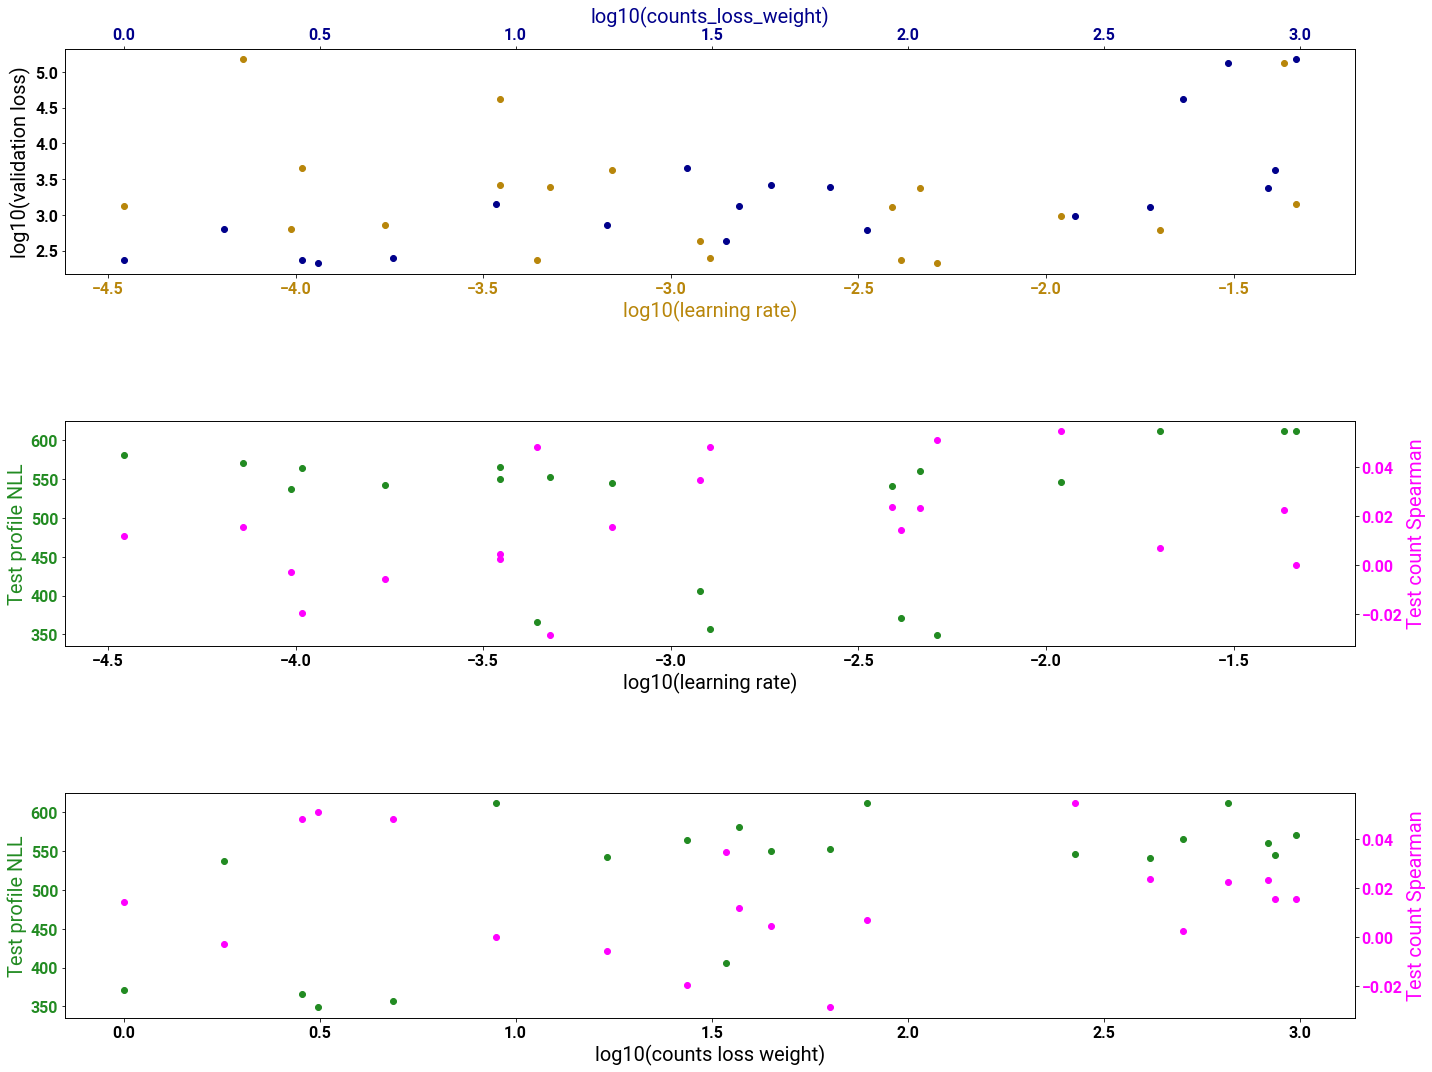

REST: task_5


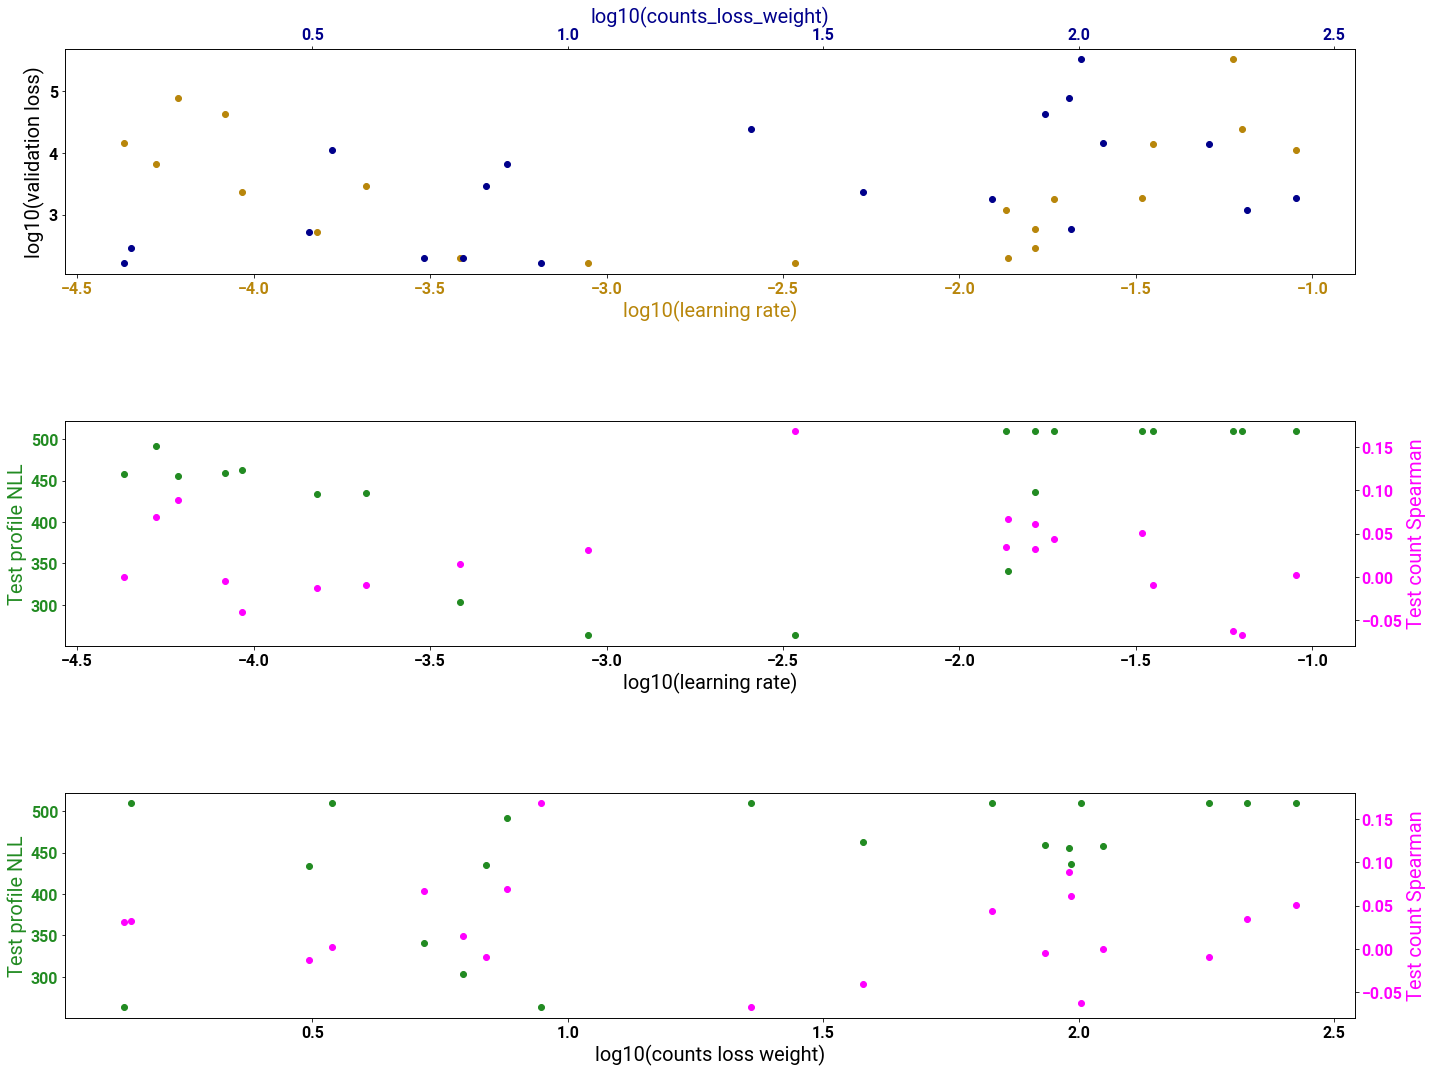

REST: task_6


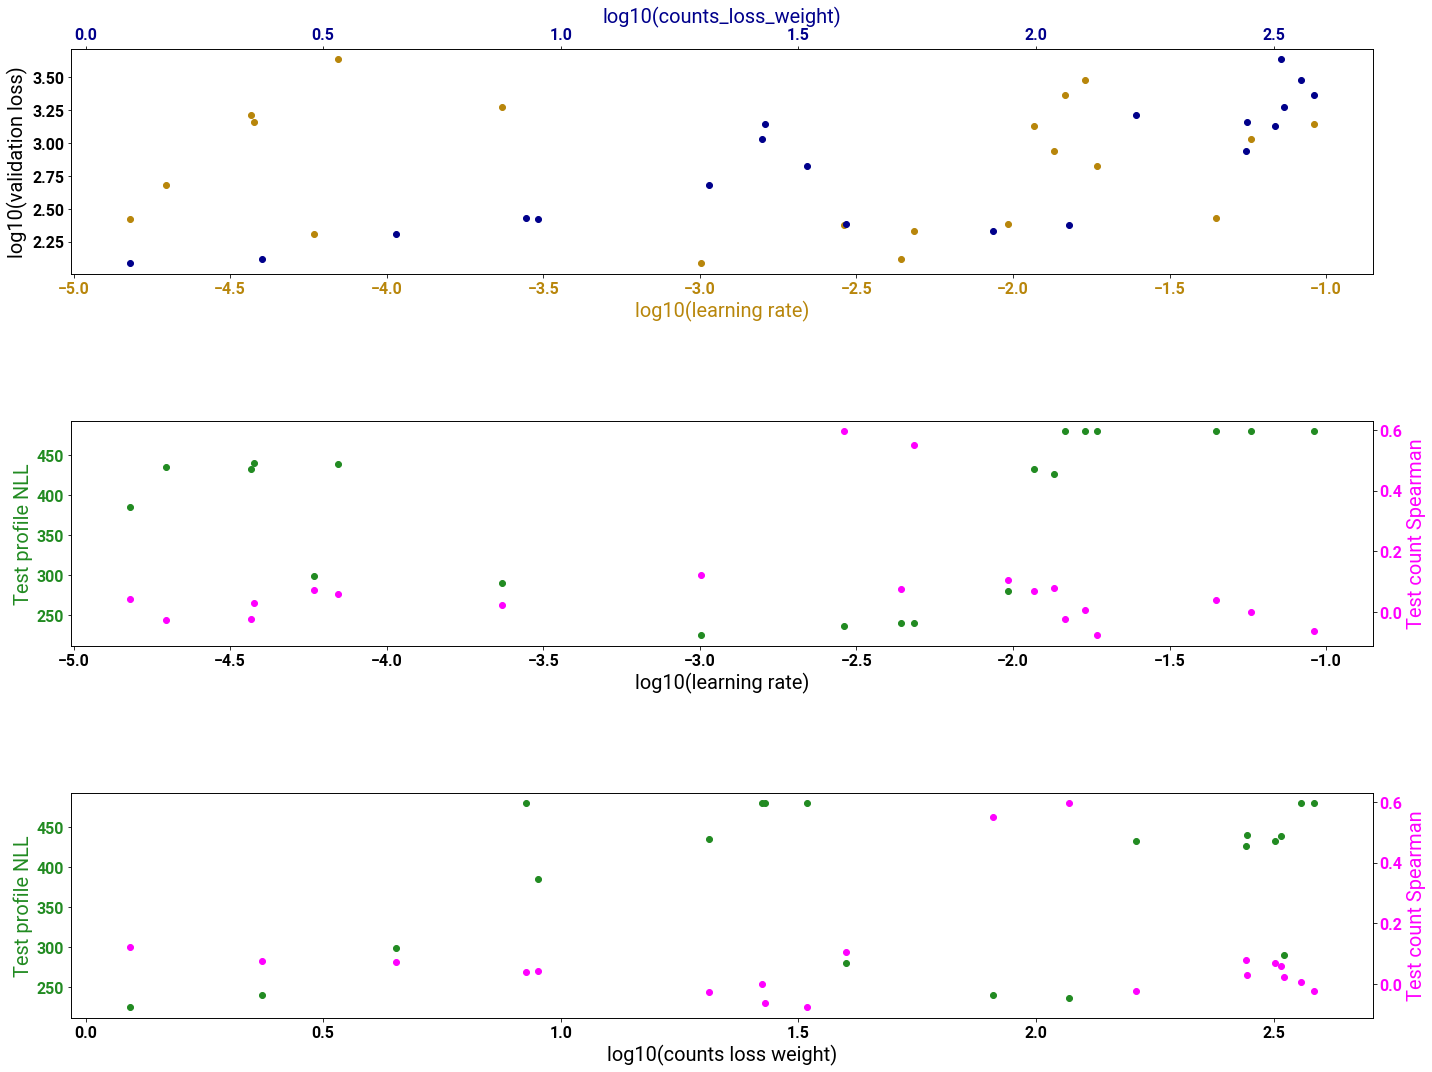

REST: task_7


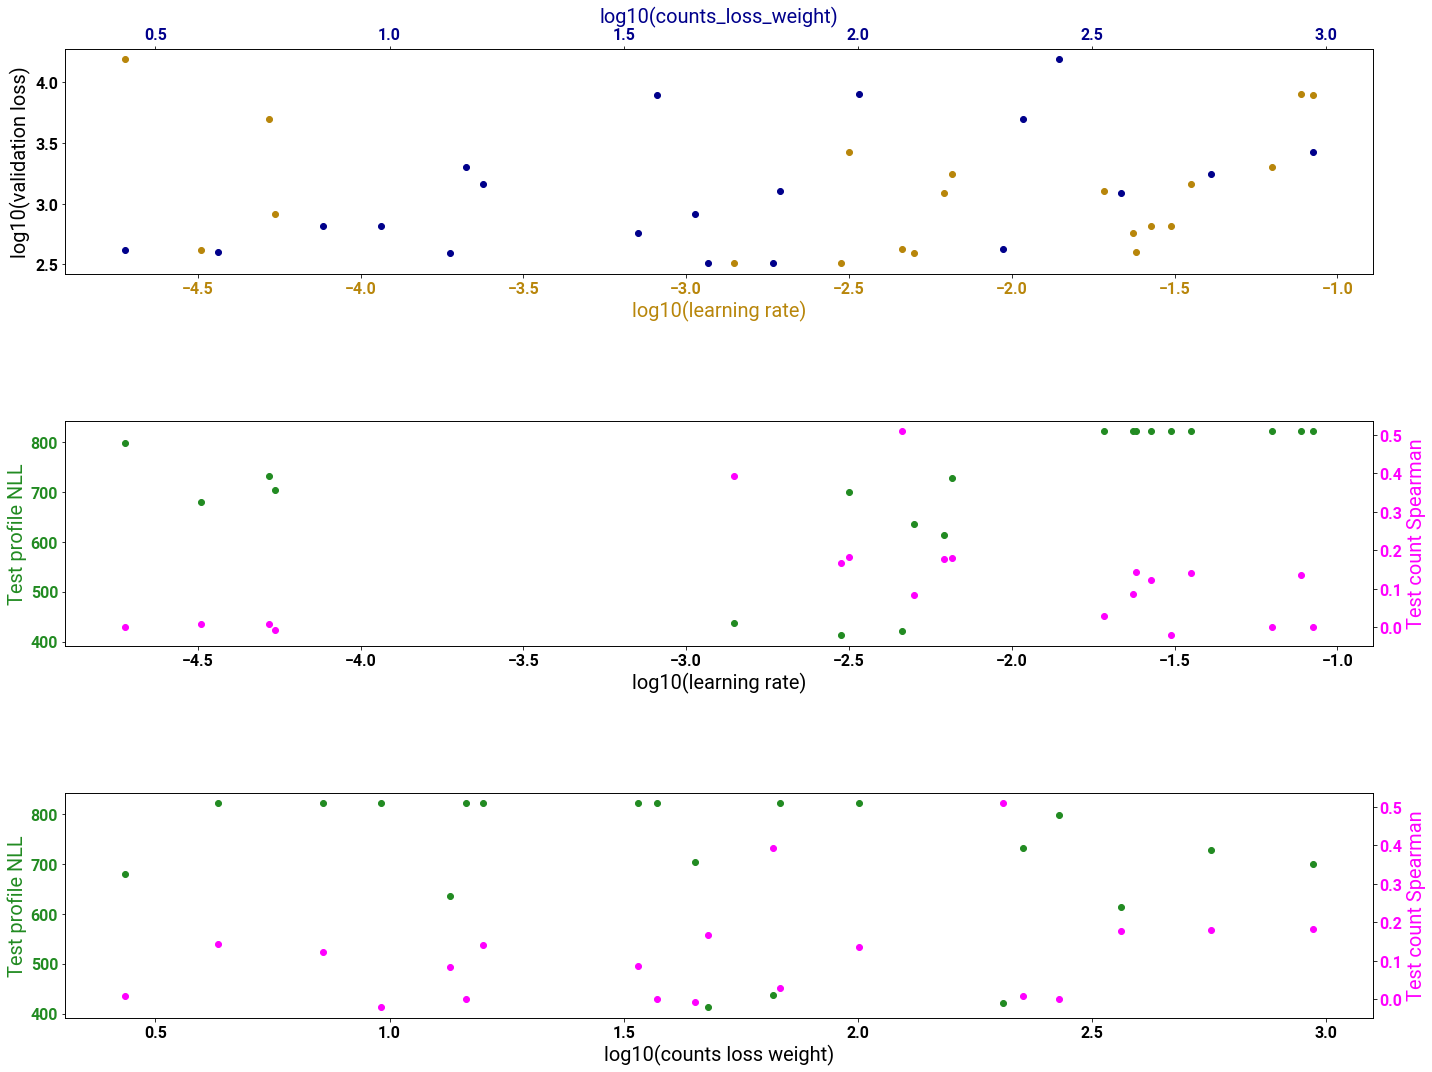

REST: task_8


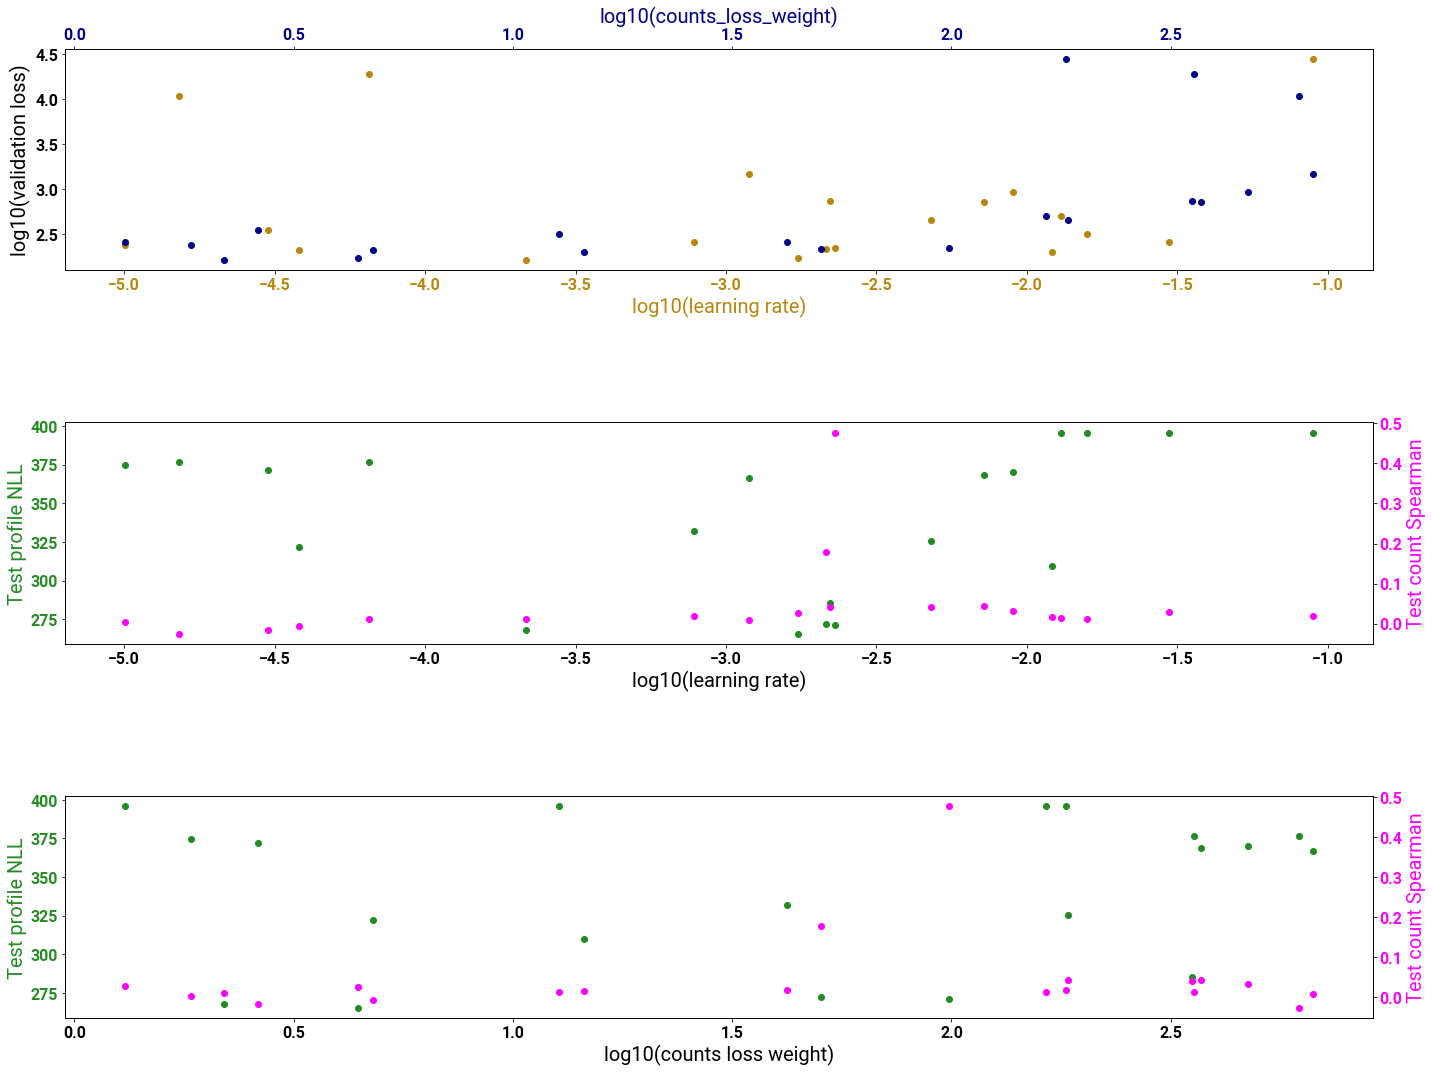

REST: task_9


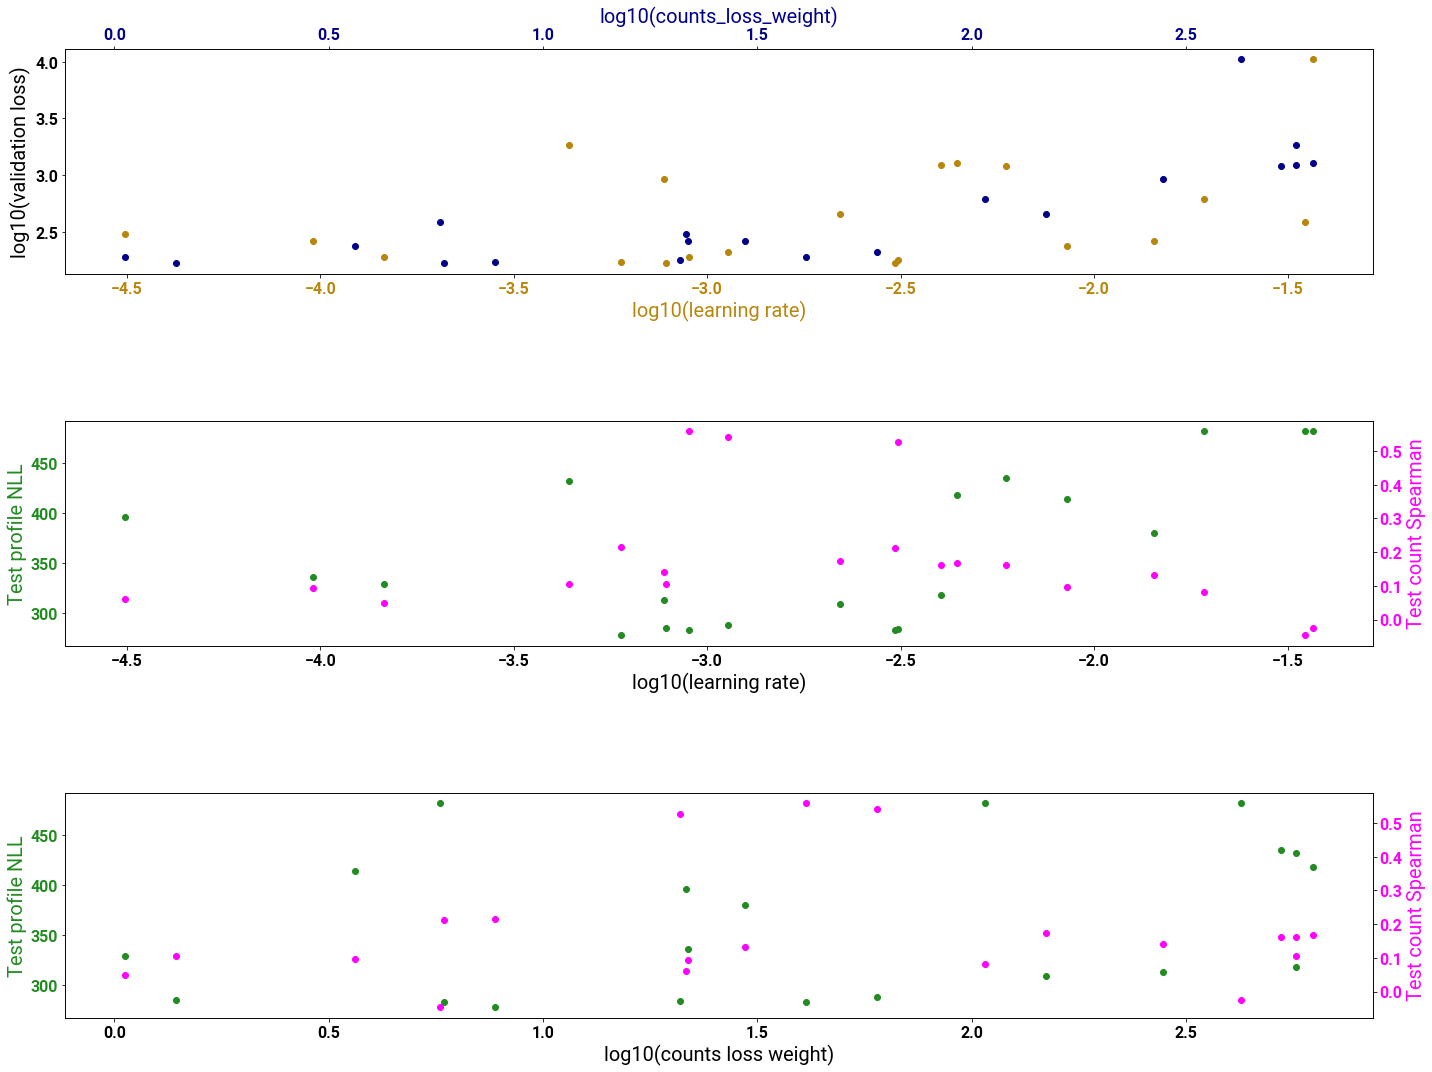

REST: task_10


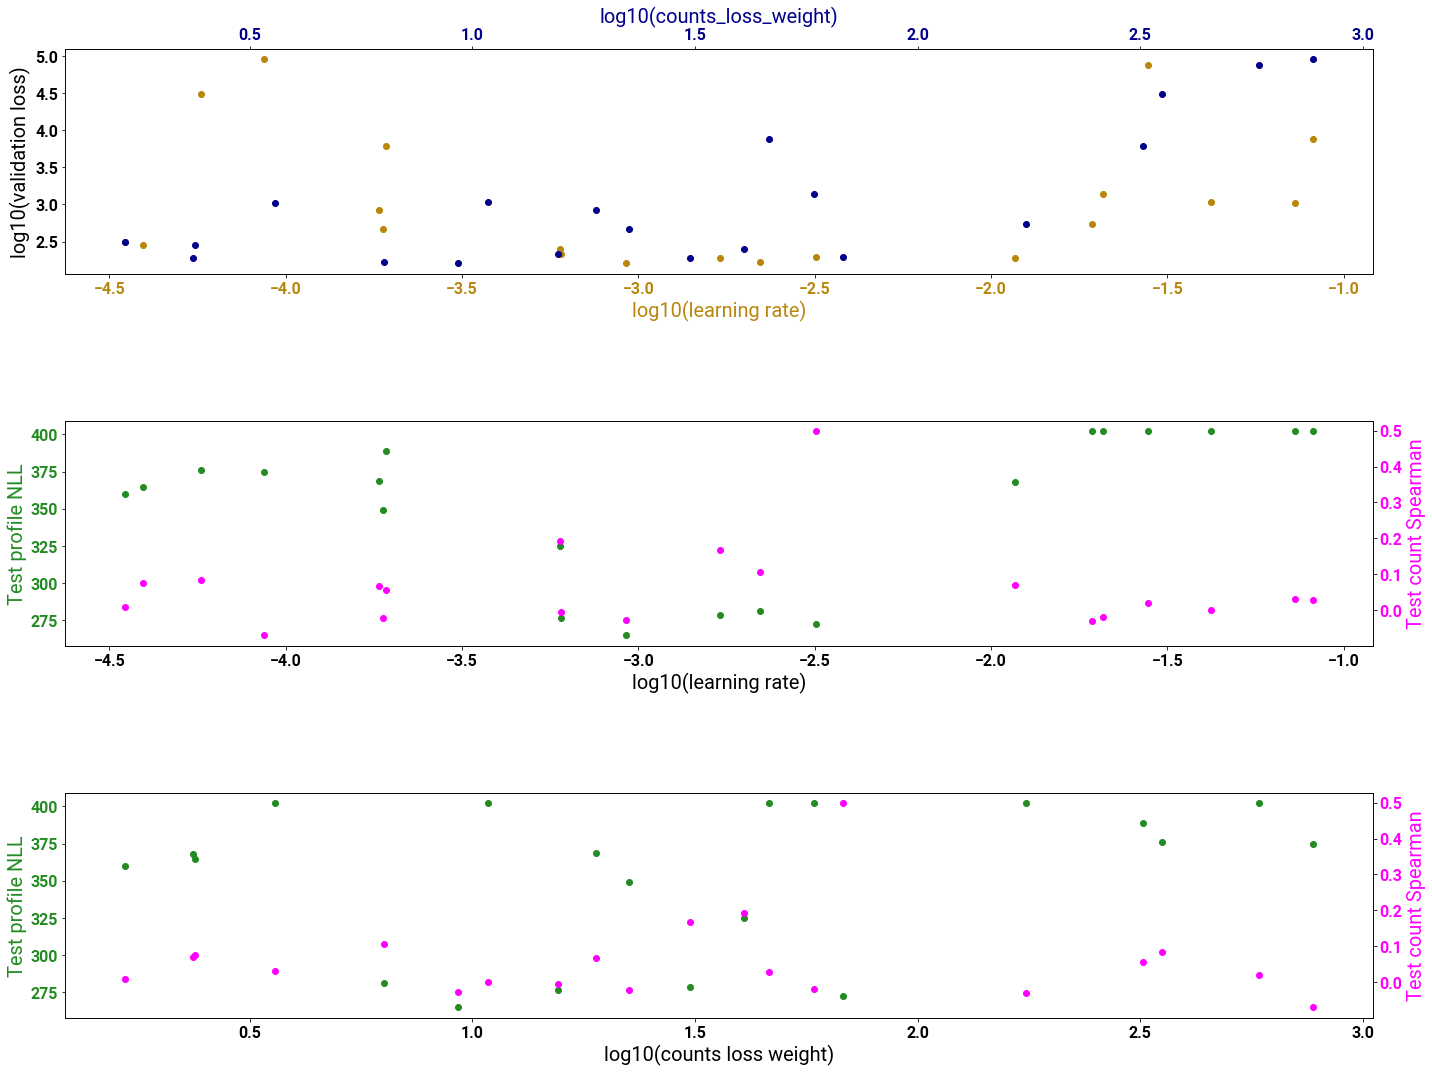

REST: task_11


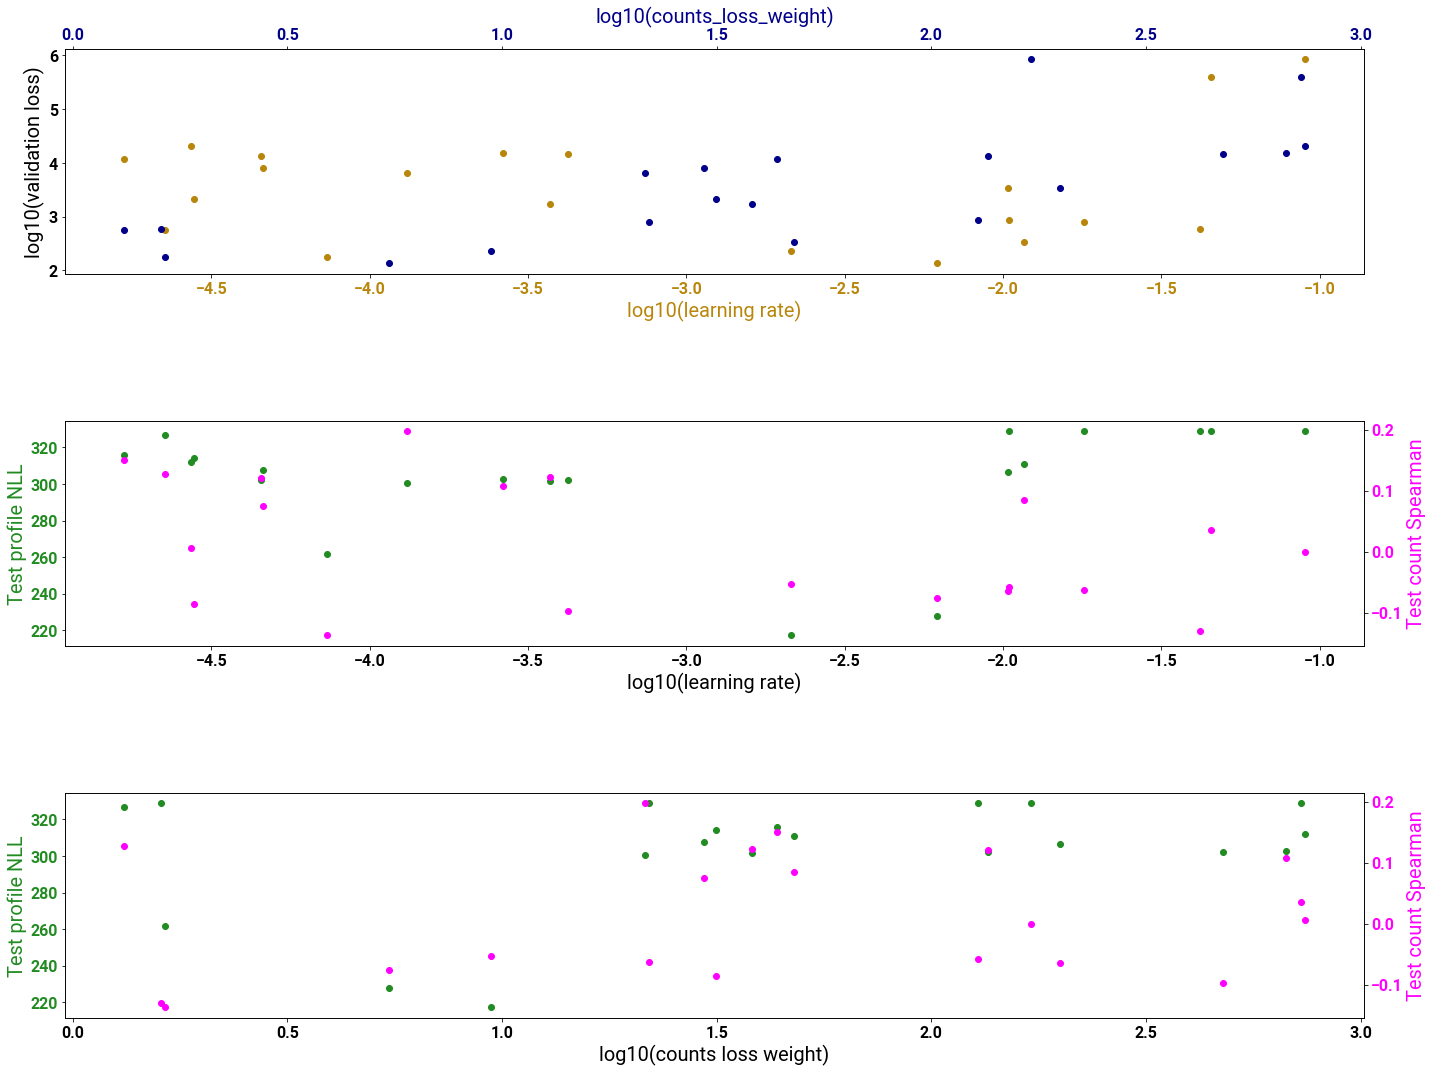

REST: task_12


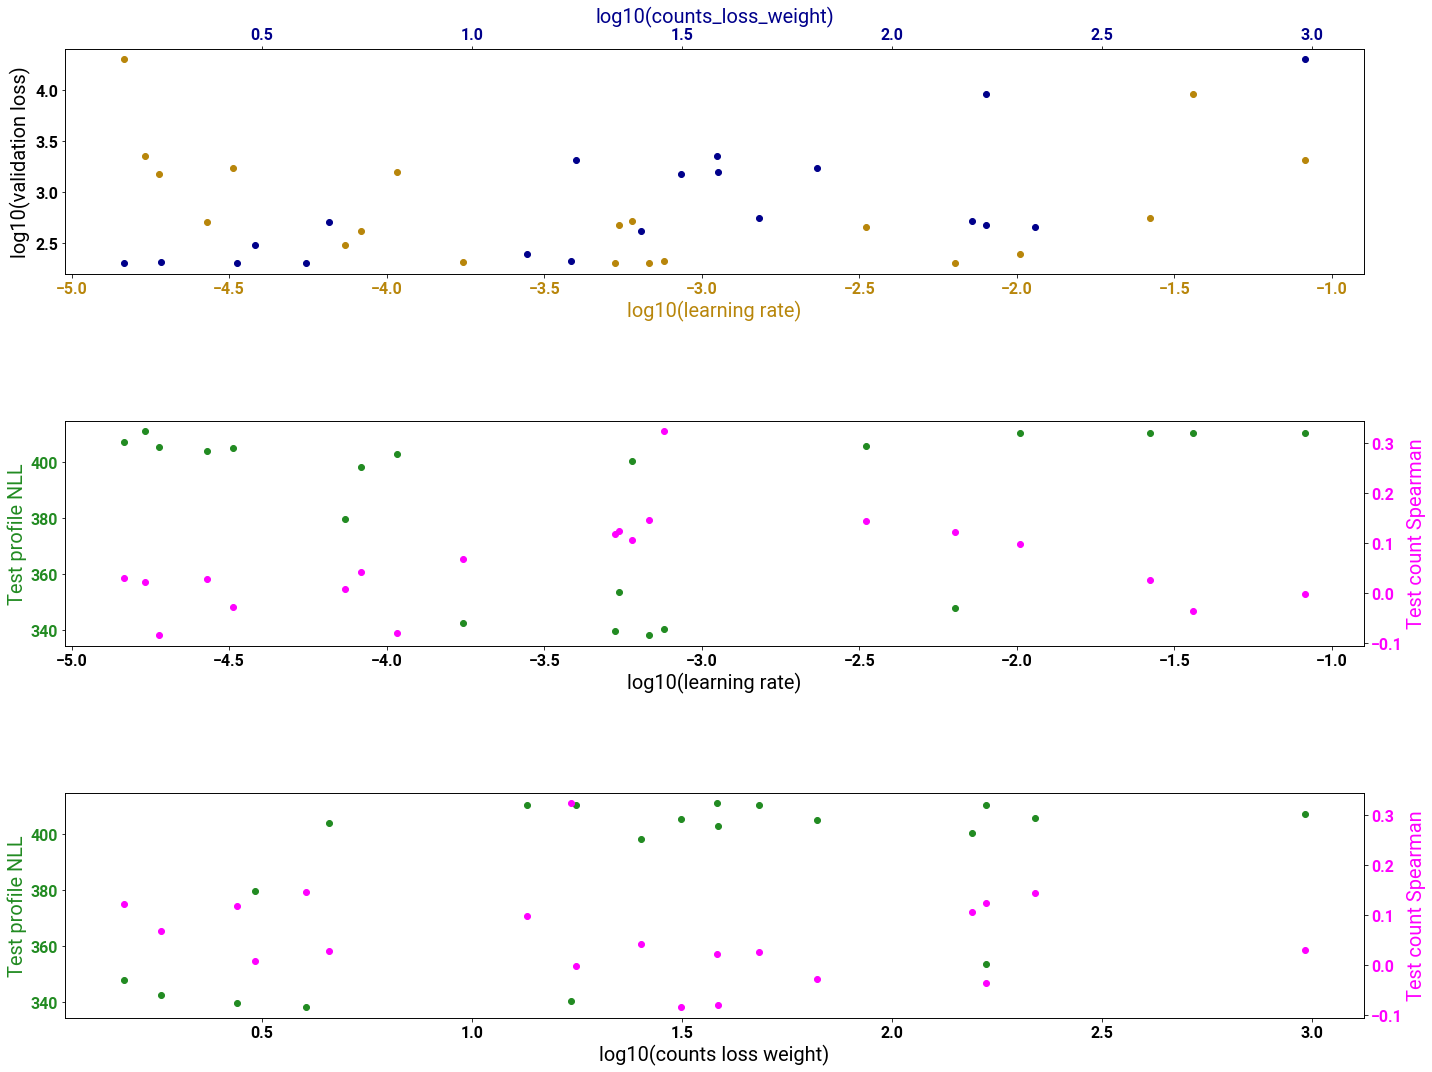

REST: task_13


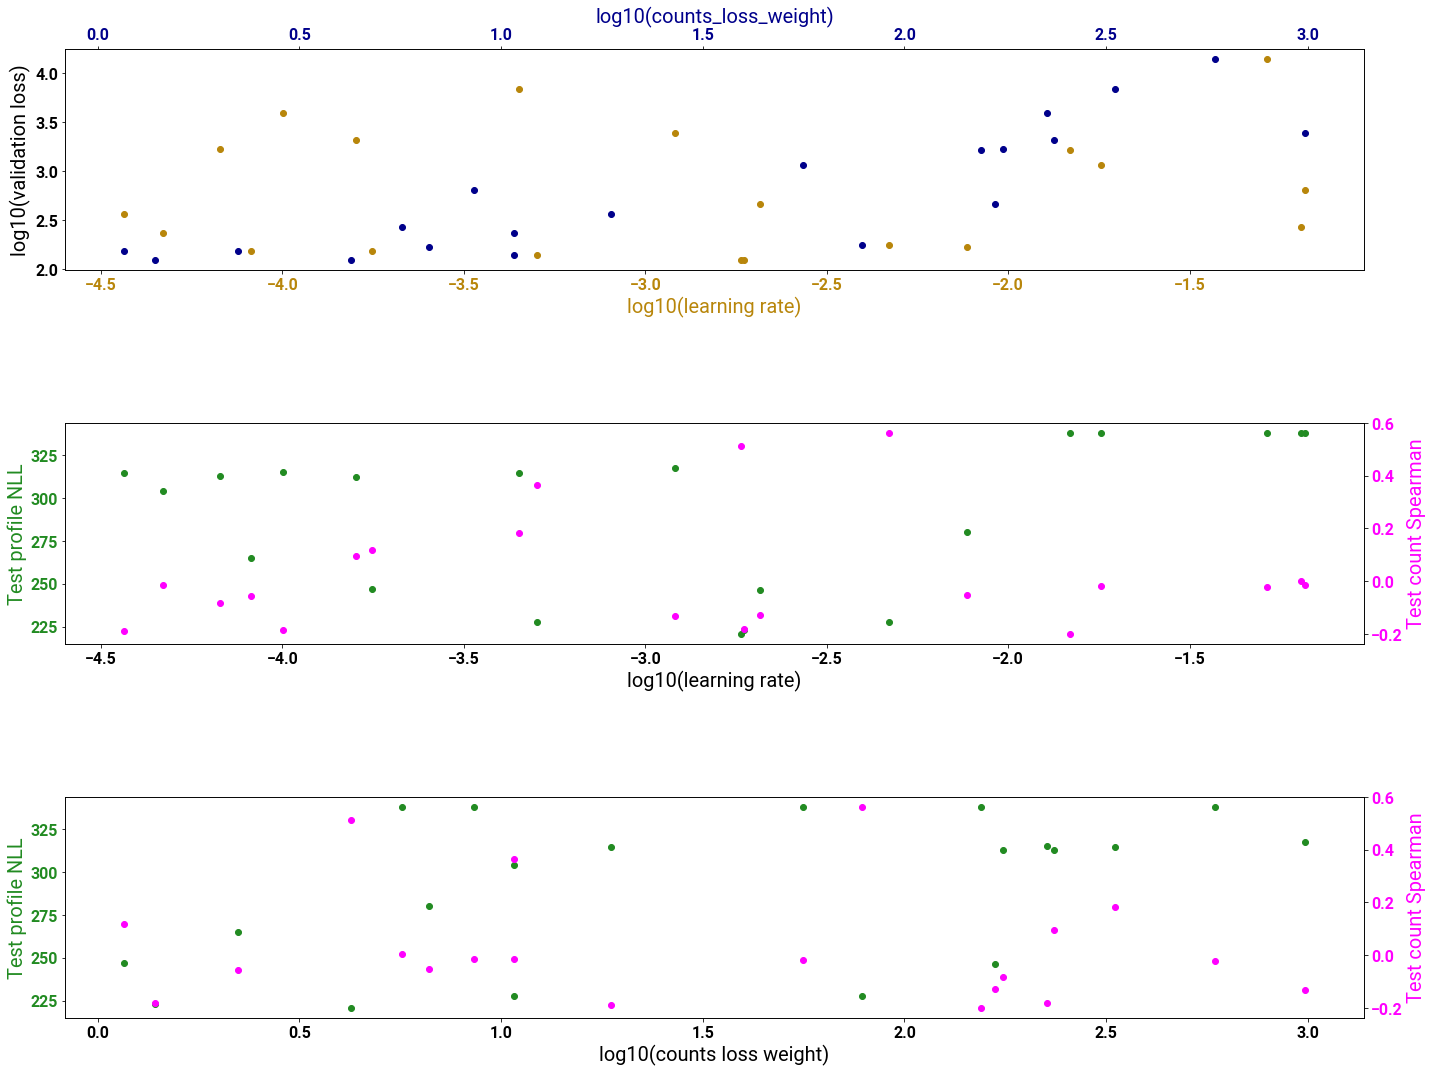

REST: task_14


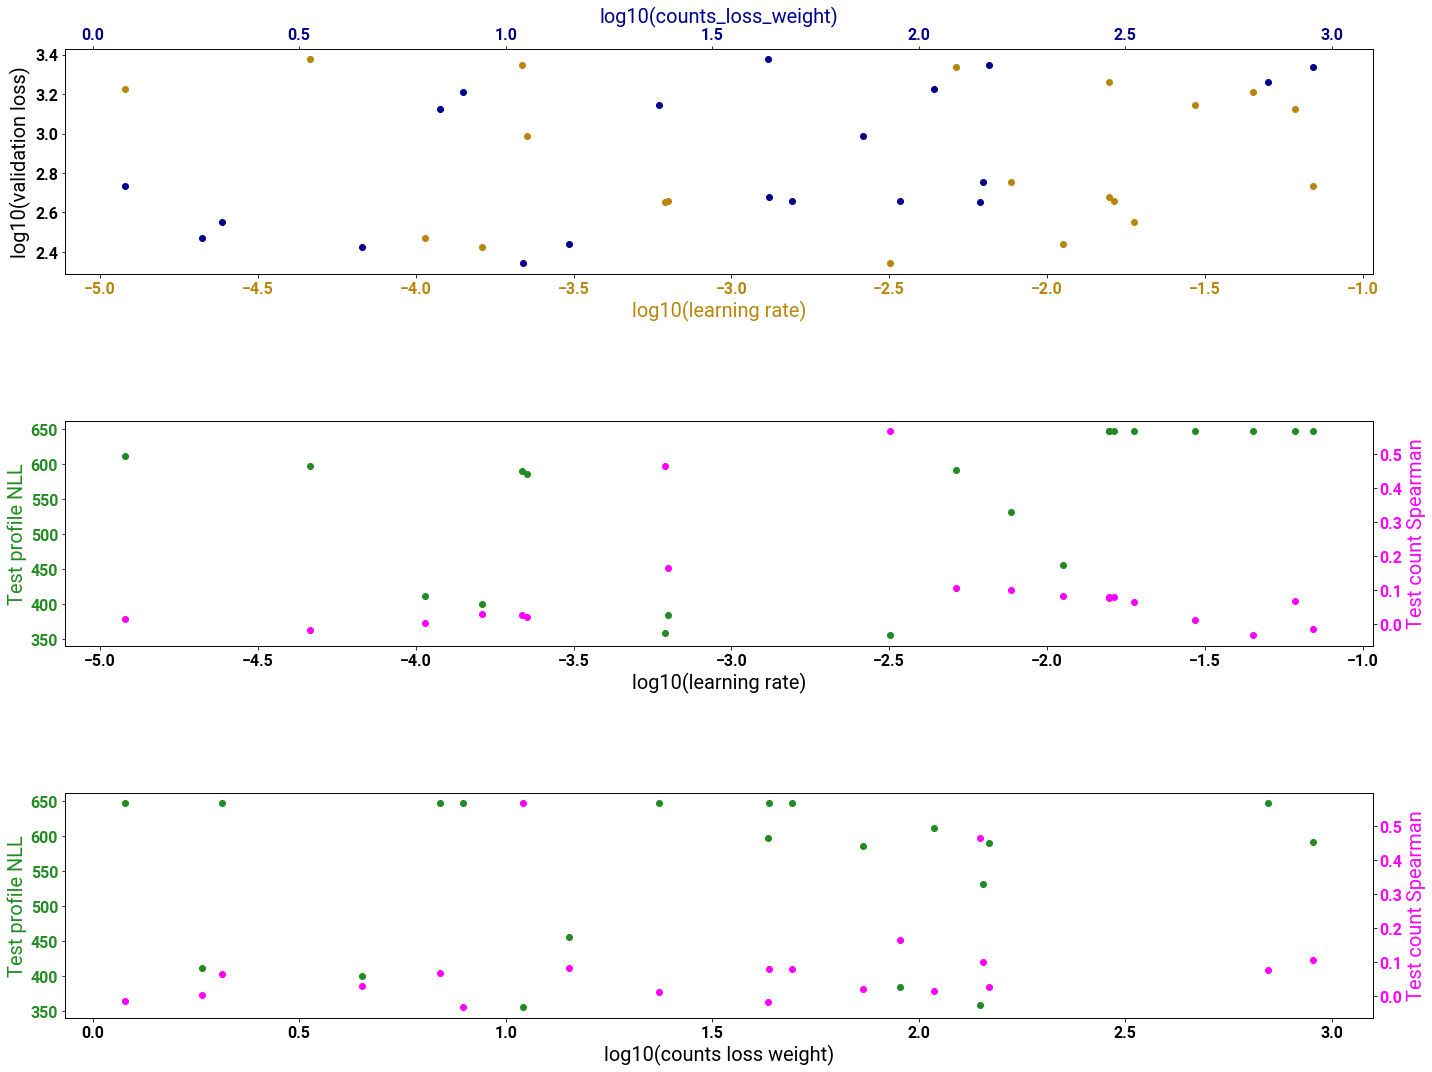

REST: task_15


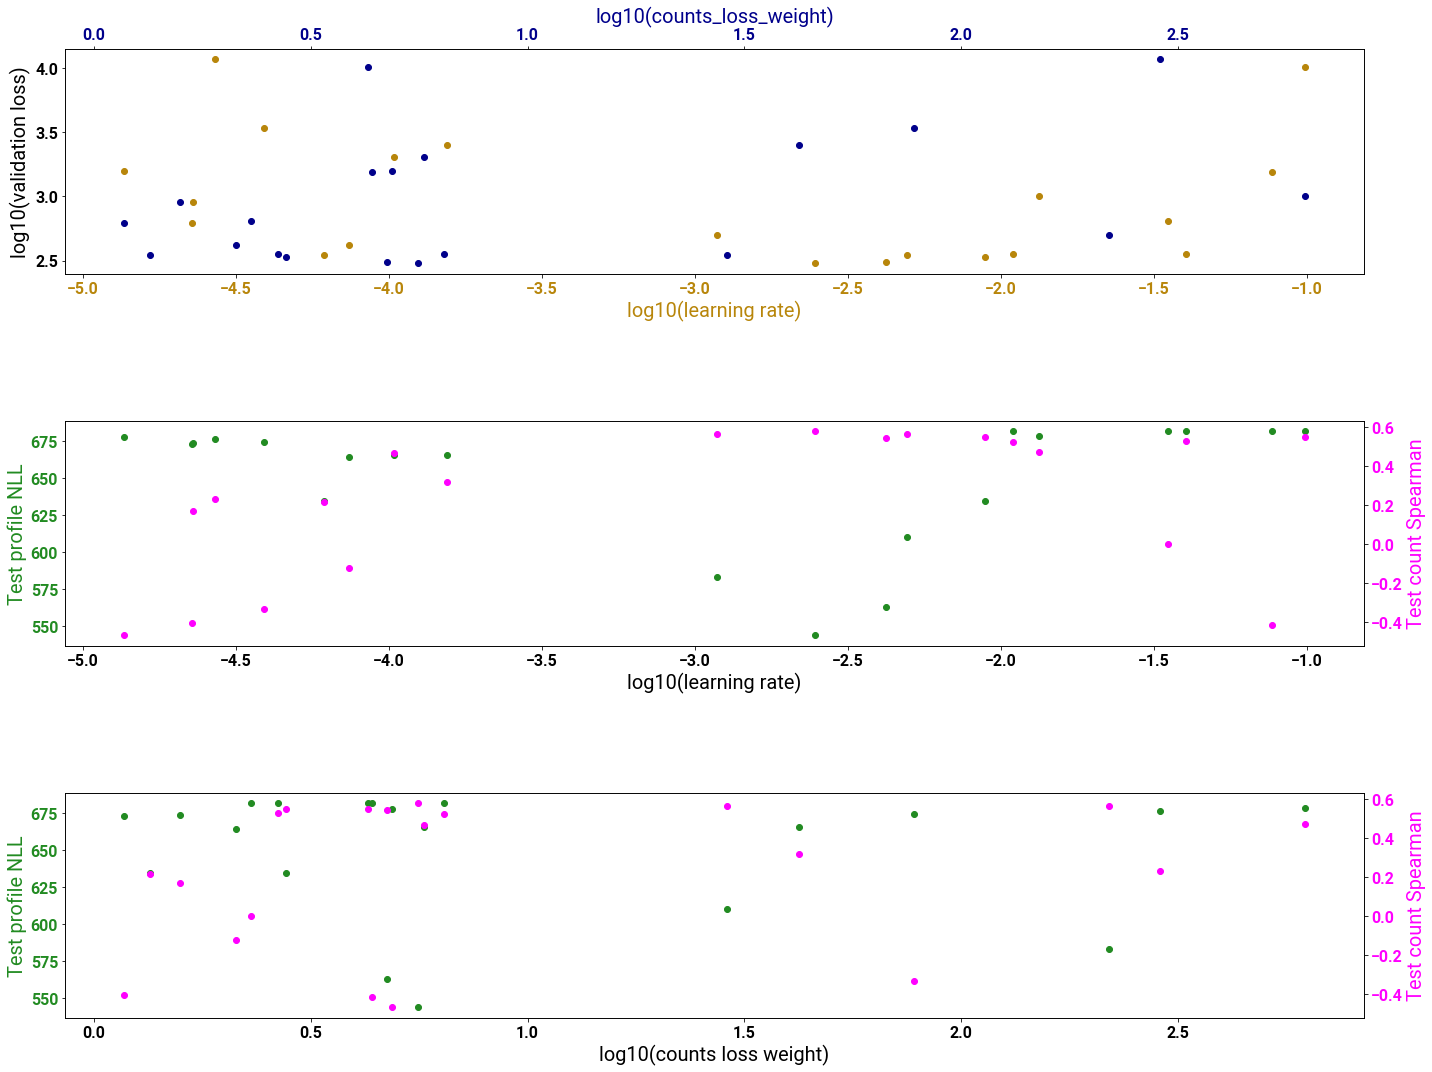

REST: task_16


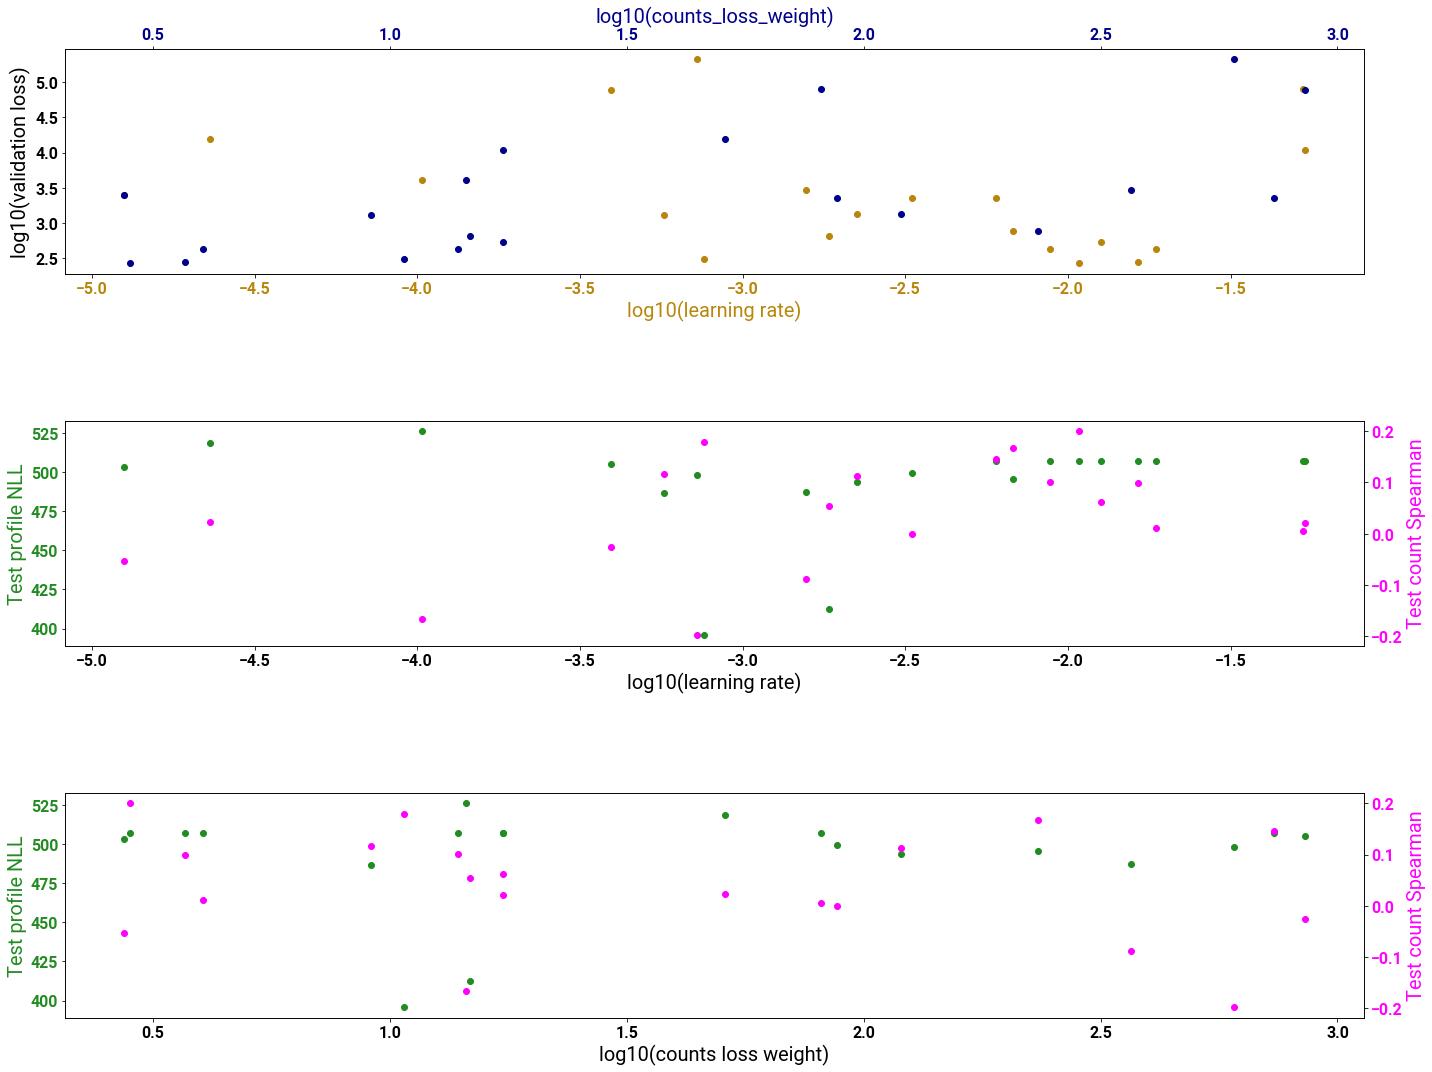

REST: task_17


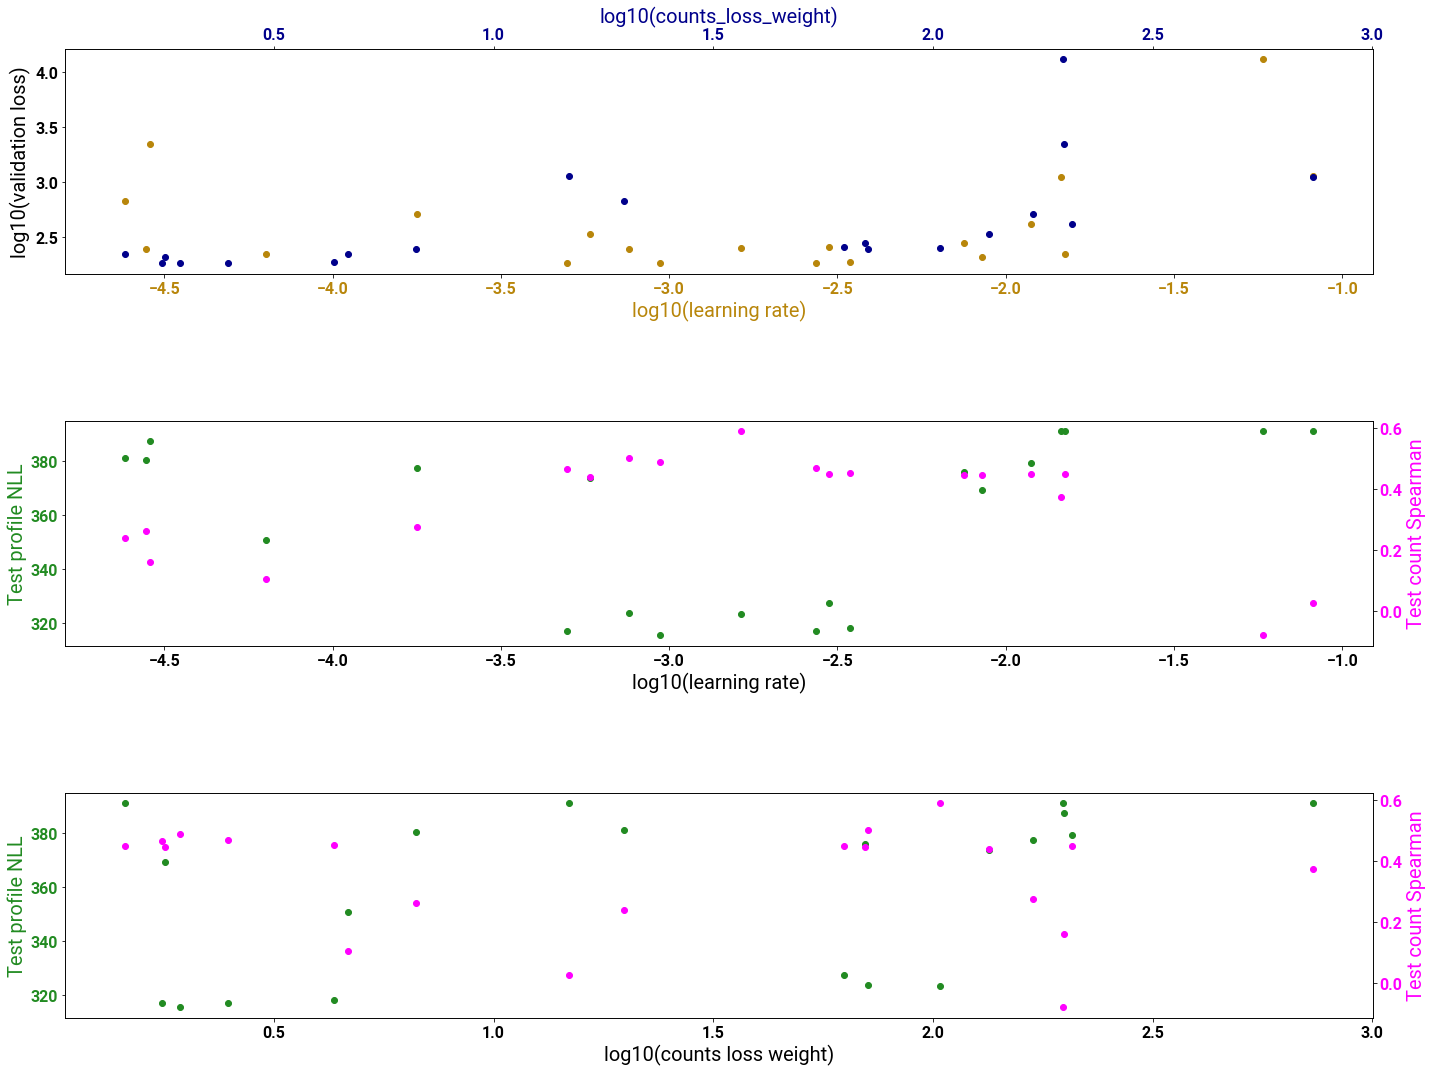

REST: task_18


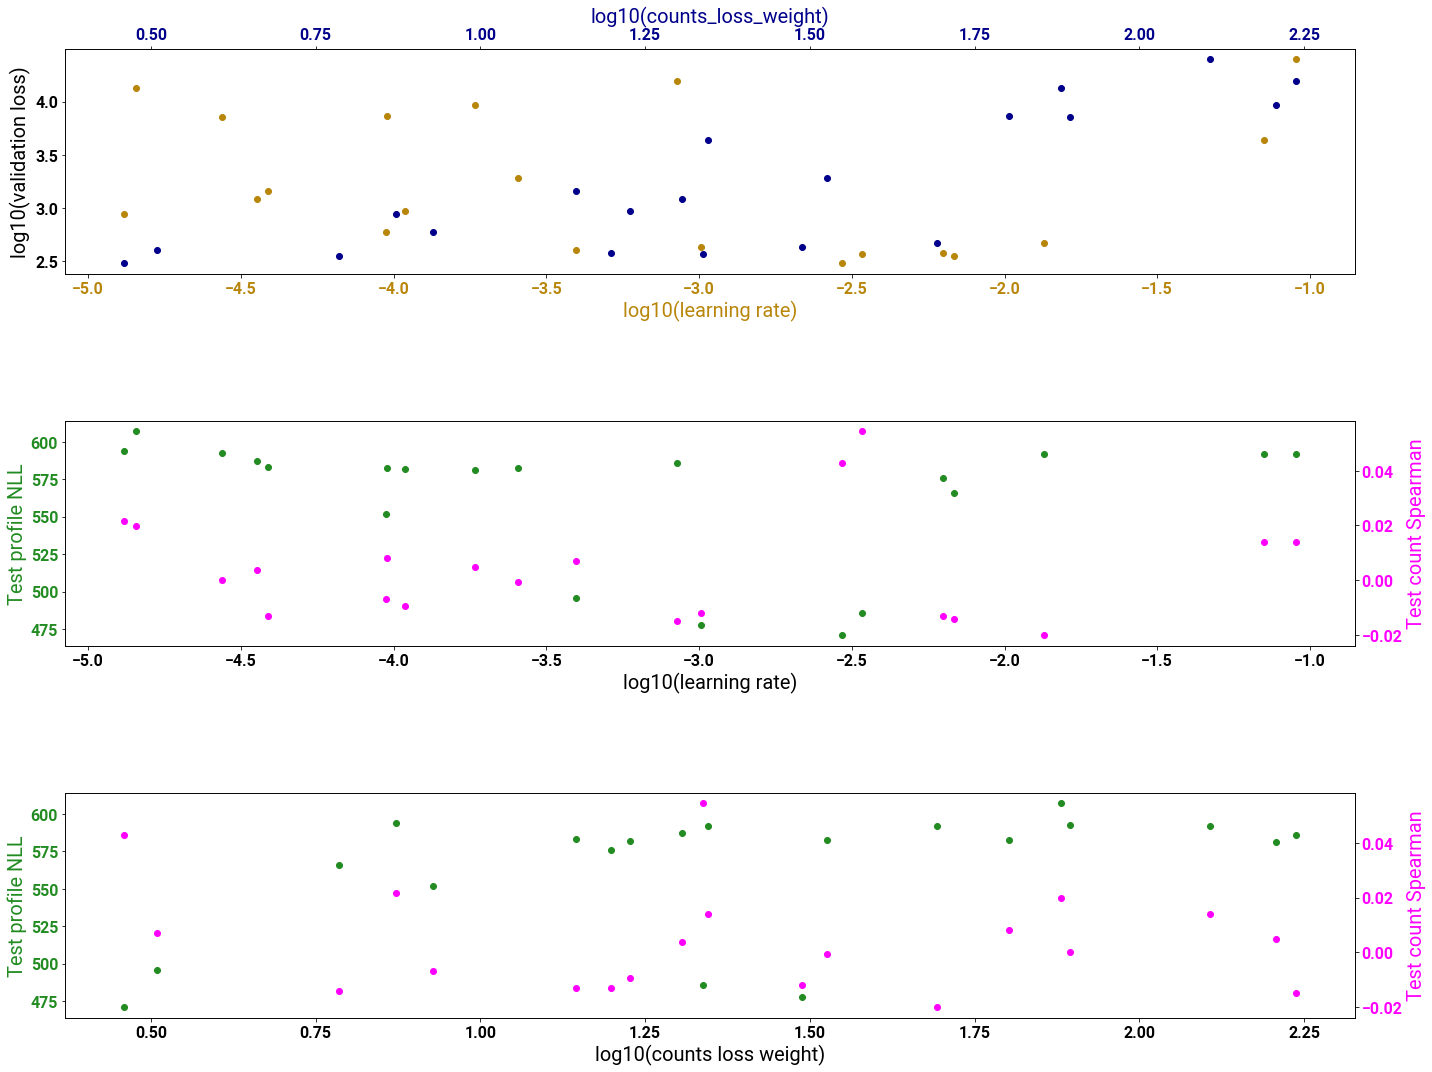

REST: task_19


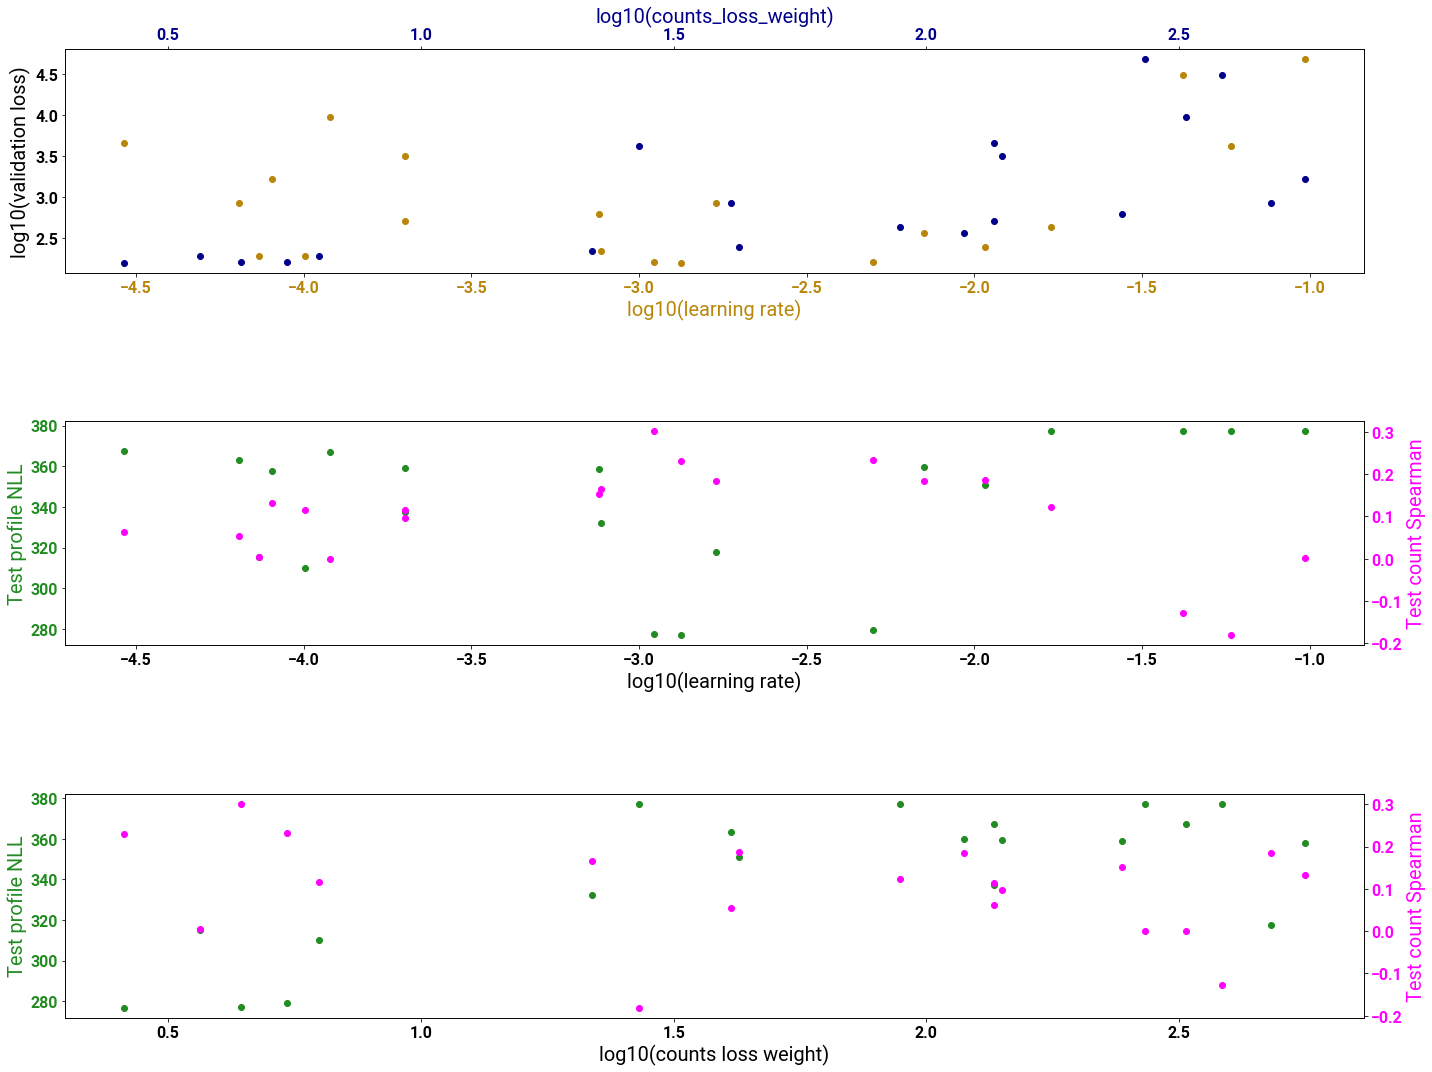

In [12]:
# Single-task models
for tf in tfs:
    for task_index in range(tf_num_tasks[tf]):
        print("%s: task_%d" % (tf, task_index))
        plot_hyperparam_performance(
            os.path.join(
                model_base,
                "singletask_profile_hypertune",
                "%s_singletask_profile_hypertune_fold1" % tf,
                "task_%d" % task_index
            )
        )